In [5]:
import __init__
import vsrl_utils as vu
import numpy as np
import copy

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [6]:
def draw_bbox(plt, ax, rois, fill=False, linewidth=2, edgecolor=[1.0, 0.0, 0.0], **kwargs):
    for i in range(rois.shape[0]):
        roi = rois[i,:].astype(np.int)
        ax.add_patch(plt.Rectangle((roi[0], roi[1]),
            roi[2] - roi[0], roi[3] - roi[1],
            fill=False, linewidth=linewidth, edgecolor=edgecolor, **kwargs))

def subplot(plt, (Y, X), (sz_y, sz_x) = (10, 10)):
    plt.rcParams['figure.figsize'] = (X*sz_x, Y*sz_y)
    fig, axes = plt.subplots(Y, X)
    return fig, axes

In [7]:
class_dict = {}
ignore_list = [12, 26, 29, 30, 45, 66, 68 ,69, 71, 83]
j = -1
for i in range(91):
    if i in ignore_list:
        continue
    j += 1
    class_dict[i] = j 
print class_dict

multiobj_dict = {}
multiobj_dict[-7] = 27
multiobj_dict[-8] = 28
multiobj_dict[-15] = 29

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24, 27: 25, 28: 26, 31: 27, 32: 28, 33: 29, 34: 30, 35: 31, 36: 32, 37: 33, 38: 34, 39: 35, 40: 36, 41: 37, 42: 38, 43: 39, 44: 40, 46: 41, 47: 42, 48: 43, 49: 44, 50: 45, 51: 46, 52: 47, 53: 48, 54: 49, 55: 50, 56: 51, 57: 52, 58: 53, 59: 54, 60: 55, 61: 56, 62: 57, 63: 58, 64: 59, 65: 60, 67: 61, 70: 62, 72: 63, 73: 64, 74: 65, 75: 66, 76: 67, 77: 68, 78: 69, 79: 70, 80: 71, 81: 72, 82: 73, 84: 74, 85: 75, 86: 76, 87: 77, 88: 78, 89: 79, 90: 80}


In [28]:
# Load COCO annotations for V-COCO images
coco = vu.load_coco()

# Load the VCOCO annotations for vcoco_train image set
vcoco_all = vu.load_vcoco('vcoco_test')
for x in vcoco_all:
    x = vu.attach_gt_boxes(x, coco)

In [9]:
# Action classes and roles in V-COCO
classes = [x['action_name'] for x in vcoco_all]
aid_dict = {}
for i, x in enumerate(vcoco_all):
    #print '{:>20s}'.format(x['action_name']), x['role_name']
    aid_dict[i+1] = [x['action_name']]
    if len(x['role_name']) > 1:
        aid_dict[i+1].append(x['role_name'][1])
aid_dict[27] = ['hit', 'obj']
aid_dict[28] = ['eat', 'instr']
aid_dict[29] = ['cut', 'obj']
print aid_dict

{1: ['hold', 'obj'], 2: ['stand'], 3: ['sit', 'instr'], 4: ['ride', 'instr'], 5: ['walk'], 6: ['look', 'obj'], 7: ['hit', 'instr'], 8: ['eat', 'obj'], 9: ['jump', 'instr'], 10: ['lay', 'instr'], 11: ['talk_on_phone', 'instr'], 12: ['carry', 'obj'], 13: ['throw', 'obj'], 14: ['catch', 'obj'], 15: ['cut', 'instr'], 16: ['run'], 17: ['work_on_computer', 'instr'], 18: ['ski', 'instr'], 19: ['surf', 'instr'], 20: ['skateboard', 'instr'], 21: ['smile'], 22: ['drink', 'instr'], 23: ['kick', 'obj'], 24: ['point', 'instr'], 25: ['read', 'obj'], 26: ['snowboard', 'instr'], 27: ['hit', 'obj'], 28: ['eat', 'instr'], 29: ['cut', 'obj']}


In [8]:
import pickle
pickle_out = open("aid_dict.pkl","wb")
pickle.dump(aid_dict, pickle_out)
pickle_out.close()

In [9]:
x = vcoco_all[0]
for key in x:
    print key, type(x[key])

role_object_id <type 'numpy.ndarray'>
ann_id <type 'numpy.ndarray'>
action_name <type 'str'>
image_id <type 'numpy.ndarray'>
role_name <type 'list'>
label <type 'numpy.ndarray'>
role_bbox <type 'numpy.ndarray'>
include <type 'list'>
bbox <type 'numpy.ndarray'>


In [37]:
dict_imgid = {}
for x in vcoco_all:
    anno_n = 0
    cls_id = classes.index(x['action_name'])+1
    rn = x['role_bbox'][0].size/4
    #print x['role_bbox'][0].size
    print x['action_name']
    for index in range(x['ann_id'].size):
        imgid = x['image_id'][index][0]
        if imgid not in dict_imgid:
            dict_imgid[imgid] = [[], []]
        if x['label'][index] != 1:
            continue
        anno_n += 1
        annsh = x['role_object_id'][index].ravel().tolist()
        anns_cls = []
        for index2 in annsh:
            if index2 > 0:
                anns_cls.append(coco.loadAnns(index2)[0]['category_id'])
            else:
                anns_cls.append(0)
        assert anns_cls[0] == 1
        while (len(anns_cls) < 3):
            anns_cls.append(0)
        bboxh = list(x['role_bbox'][index])
        fillbox = bboxh[:4]
        #fillbox = [-1, -1, 0, 0]
        while (len(bboxh) < 12):
            bboxh.extend(fillbox)
        for pos, i in enumerate(anns_cls):
            if i==0:
                bboxh[pos*4: pos*4+4] = fillbox
        res1 = [cls_id, class_dict[anns_cls[0]]]
        res1.extend(bboxh[:4])
        res1.append(class_dict[anns_cls[1]])
        res1.extend(bboxh[4:8])
        #print res1
        dict_imgid[imgid][1].append(res1)
        if rn > 2 :
            res2 = [multiobj_dict[-cls_id], class_dict[anns_cls[0]]]
            res2.extend(bboxh[:4])
            res2.append(class_dict[anns_cls[2]])
            res2.extend(bboxh[8:12])
            dict_imgid[imgid][1].append(res2)
            #print res2
    print anno_n
    anno_n = 0
print(len(dict_imgid))

hold
3608
stand
4118
sit
1916
ride
556
walk
597
look
3347
hit
349
eat
521
jump
635
lay
387
talk_on_phone
285
carry
472
throw
244
catch
246
cut
269
run
687
work_on_computer
410
ski
424
surf
486
skateboard
417
smile
1415
drink
82
kick
180
point
31
read
111
snowboard
277
4946


In [19]:
def xyhw_to_xyxy(bbox):
  out = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]
  return out

In [38]:
imgid_list = list(dict_imgid.keys())
anns = coco.getAnnIds(imgIds=dict_imgid.keys())
for index in anns:
    x = coco.loadAnns(index)[0]
    imgid = x['image_id']
    bbox = x['bbox']
    bbox = xyhw_to_xyxy(bbox)
    res = [class_dict[x['category_id']]]
    res.extend(bbox)
    dict_imgid[imgid][0].append(res)

In [39]:
img_list = coco.loadImgs(imgid_list)
print len(img_list)
print img_list[0]['file_name']

4946
000000565248.jpg


In [40]:
for index, imgid in enumerate(imgid_list):
    print '#', index
    img = img_list[index]
    print img['file_name']
    print img['width'], img['height']
    print len(dict_imgid[imgid][0])
    for x in dict_imgid[imgid][0]:
        for num in x:
            if type(num) == int:
                print(num),
            else:
                print("{0:.2f}".format(num)),
        print ' '
    action_list = [i for i in dict_imgid[imgid][1]]
    print len(action_list)
    for x in action_list:
        for num in x:
            if type(num) == int:
                print(num),
            else:
                print("{0:.2f}".format(num)),
        print ' '
    print ' '

# 0
000000565248.jpg
640 483
7
18 73.59 392.83 393.86 481.96  
1 0.00 128.83 160.64 476.16  
1 175.44 165.82 335.72 401.90  
18 127.03 328.95 505.86 483.00  
27 51.84 269.06 134.53 433.85  
27 267.47 246.29 336.14 321.07  
25 296.41 246.90 337.52 324.42  
6
3 1 0.00 128.83 160.64 476.16 18 73.59 392.83 393.86 481.96  
3 1 175.44 165.82 335.72 401.90 18 127.03 328.95 505.86 483.00  
4 1 0.00 128.83 160.64 476.16 18 73.59 392.83 393.86 481.96  
4 1 175.44 165.82 335.72 401.90 18 127.03 328.95 505.86 483.00  
21 1 0.00 128.83 160.64 476.16 0 0.00 128.83 160.64 476.16  
21 1 175.44 165.82 335.72 401.90 0 175.44 165.82 335.72 401.90  
 
# 1
000000477867.jpg
480 640
11
1 166.09 229.22 356.51 426.81  
1 269.76 3.38 299.13 83.82  
38 270.90 371.03 375.17 479.11  
38 0.22 99.70 53.81 149.29  
38 224.13 112.50 369.35 131.19  
1 323.07 0.32 347.90 55.50  
1 392.49 0.14 420.80 49.69  
1 424.89 0.12 447.39 46.74  
38 60.70 54.04 128.96 111.81  
1 82.89 6.60 145.90 194.61  
1 159.60 2.69 237.04 186.

6 1 23.01 0.30 479.85 640.00 55 242.49 446.89 368.82 538.59  
8 1 23.01 0.30 479.85 640.00 55 242.49 446.89 368.82 538.59  
28 1 23.01 0.30 479.85 640.00 0 23.01 0.30 479.85 640.00  
 
# 17
000000289423.jpg
640 426
3
1 38.42 181.11 237.37 426.00  
1 214.44 186.38 398.24 419.96  
30 230.90 41.30 267.64 59.96  
8
2 1 38.42 181.11 237.37 426.00 0 38.42 181.11 237.37 426.00  
2 1 214.44 186.38 398.24 419.96 0 214.44 186.38 398.24 419.96  
6 1 38.42 181.11 237.37 426.00 30 230.90 41.30 267.64 59.96  
6 1 214.44 186.38 398.24 419.96 30 230.90 41.30 267.64 59.96  
14 1 38.42 181.11 237.37 426.00 0 38.42 181.11 237.37 426.00  
14 1 214.44 186.38 398.24 419.96 30 230.90 41.30 267.64 59.96  
16 1 38.42 181.11 237.37 426.00 0 38.42 181.11 237.37 426.00  
16 1 214.44 186.38 398.24 419.96 0 214.44 186.38 398.24 419.96  
 
# 18
000000040989.jpg
640 425
25
26 358.52 183.54 549.69 275.21  
26 233.97 166.04 259.75 175.24  
26 68.69 176.38 91.39 184.79  
26 57.23 177.05 73.33 182.59  
26 427.71 234.75 5

1 180.27 168.96 237.12 249.66  
1 4.73 161.03 11.82 185.69  
1 127.98 162.61 168.13 237.90  
2
2 1 346.25 176.90 458.43 426.07 0 346.25 176.90 458.43 426.07  
26 1 346.25 176.90 458.43 426.07 32 323.97 370.29 471.33 452.64  
 
# 33
000000330665.jpg
591 640
7
28 164.21 191.14 191.12 354.17  
68 382.81 215.86 395.61 231.96  
68 370.23 259.45 385.01 283.72  
1 186.97 138.07 488.99 631.37  
1 103.55 94.92 287.64 632.81  
1 257.97 152.17 284.75 232.07  
27 360.85 403.00 529.12 559.77  
7
1 1 186.97 138.07 488.99 631.37 68 370.23 259.45 385.01 283.72  
2 1 186.97 138.07 488.99 631.37 0 186.97 138.07 488.99 631.37  
2 1 103.55 94.92 287.64 632.81 0 103.55 94.92 287.64 632.81  
5 1 103.55 94.92 287.64 632.81 0 103.55 94.92 287.64 632.81  
11 1 186.97 138.07 488.99 631.37 68 370.23 259.45 385.01 283.72  
12 1 186.97 138.07 488.99 631.37 68 382.81 215.86 395.61 231.96  
21 1 186.97 138.07 488.99 631.37 0 186.97 138.07 488.99 631.37  
 
# 34
000000000764.jpg
500 343
15
30 135.23 135.93 178.76 153

6 1 58.97 156.52 227.24 585.11 1 167.33 51.31 193.34 82.28  
12 1 58.97 156.52 227.24 585.11 38 170.33 283.54 238.18 446.02  
 
# 47
000000372913.jpg
640 425
6
33 438.32 237.11 485.29 286.02  
1 160.45 132.59 377.25 382.82  
1 412.56 104.34 598.25 389.58  
1 522.42 135.62 638.93 354.33  
1 108.14 181.60 151.38 270.97  
1 615.23 195.32 640.00 298.07  
8
2 1 160.45 132.59 377.25 382.82 0 160.45 132.59 377.25 382.82  
2 1 522.42 135.62 638.93 354.33 0 522.42 135.62 638.93 354.33  
6 1 160.45 132.59 377.25 382.82 33 438.32 237.11 485.29 286.02  
6 1 412.56 104.34 598.25 389.58 33 438.32 237.11 485.29 286.02  
16 1 160.45 132.59 377.25 382.82 0 160.45 132.59 377.25 382.82  
16 1 412.56 104.34 598.25 389.58 0 412.56 104.34 598.25 389.58  
16 1 522.42 135.62 638.93 354.33 0 522.42 135.62 638.93 354.33  
23 1 160.45 132.59 377.25 382.82 33 438.32 237.11 485.29 286.02  
 
# 48
000000258061.jpg
640 457
2
1 229.01 129.40 413.87 315.28  
38 275.97 277.52 428.83 338.88  
2
1 1 229.01 129.40 413.87 

15 1 134.89 84.09 393.18 564.81 0 134.89 84.09 393.18 564.81  
29 1 134.89 84.09 393.18 564.81 54 145.98 342.73 258.10 396.57  
 
# 60
000000478567.jpg
640 425
5
33 274.83 303.56 312.08 336.86  
1 213.45 59.03 345.91 315.37  
1 0.00 89.87 18.41 151.60  
1 314.54 79.00 401.67 316.48  
1 407.91 81.08 467.98 217.54  
8
2 1 213.45 59.03 345.91 315.37 0 213.45 59.03 345.91 315.37  
2 1 314.54 79.00 401.67 316.48 0 314.54 79.00 401.67 316.48  
6 1 213.45 59.03 345.91 315.37 33 274.83 303.56 312.08 336.86  
6 1 314.54 79.00 401.67 316.48 33 274.83 303.56 312.08 336.86  
16 1 213.45 59.03 345.91 315.37 0 213.45 59.03 345.91 315.37  
16 1 314.54 79.00 401.67 316.48 0 314.54 79.00 401.67 316.48  
23 1 213.45 59.03 345.91 315.37 33 274.83 303.56 312.08 336.86  
23 1 314.54 79.00 401.67 316.48 33 274.83 303.56 312.08 336.86  
 
# 61
000000088436.jpg
640 480
33
68 69.91 423.80 123.50 445.48  
68 455.55 313.30 492.26 330.35  
57 5.02 146.57 55.32 217.41  
57 322.04 94.33 400.01 132.72  
1 137.30 73.

8 1 0.00 22.53 275.06 480.00 54 236.22 350.56 416.36 470.29  
28 1 0.00 22.53 275.06 480.00 0 0.00 22.53 275.06 480.00  
8 1 295.96 30.26 638.21 448.91 54 315.94 210.05 455.72 305.22  
28 1 295.96 30.26 638.21 448.91 0 295.96 30.26 638.21 448.91  
21 1 0.00 22.53 275.06 480.00 0 0.00 22.53 275.06 480.00  
21 1 295.96 30.26 638.21 448.91 0 295.96 30.26 638.21 448.91  
 
# 73
000000155774.jpg
479 640
15
28 280.93 273.62 313.19 534.56  
1 237.30 103.55 477.48 632.81  
1 74.45 160.50 269.17 630.12  
1 0.00 211.10 80.98 474.31  
74 364.98 526.45 426.52 623.92  
42 389.02 181.95 406.81 194.45  
42 414.16 181.92 433.15 194.83  
42 434.83 181.95 455.29 195.12  
42 459.15 182.37 477.69 195.33  
46 424.19 241.89 440.41 256.94  
46 349.76 175.59 370.44 194.67  
42 406.81 183.92 418.33 194.88  
1 26.15 197.36 84.39 300.00  
42 113.93 165.08 129.22 192.30  
27 51.91 521.78 167.31 631.93  
6
1 1 237.30 103.55 477.48 632.81 74 364.98 526.45 426.52 623.92  
1 1 74.45 160.50 269.17 630.12 27 51.91 521.

1 338.38 244.40 360.38 313.74  
1 14.30 324.89 43.73 373.94  
1 79.52 254.98 94.21 306.74  
1 296.69 252.89 316.51 283.04  
1 321.47 248.08 345.25 317.86  
27 142.97 270.23 160.72 306.04  
68 338.85 274.88 340.78 276.14  
1 181.78 248.08 197.85 312.64  
27 309.29 275.87 318.47 288.76  
27 116.65 291.16 133.60 325.05  
1 344.27 241.29 358.59 258.19  
1 0 218 427 453  
4
1 1 176.11 229.22 349.35 601.48 68 247.27 268.94 261.09 292.88  
2 1 176.11 229.22 349.35 601.48 0 176.11 229.22 349.35 601.48  
5 1 176.11 229.22 349.35 601.48 0 176.11 229.22 349.35 601.48  
11 1 176.11 229.22 349.35 601.48 68 247.27 268.94 261.09 292.88  
 
# 91
000000345456.jpg
640 344
27
2 164.51 181.90 218.14 252.80  
7 215.39 47.65 516.77 322.69  
1 209.83 140.41 252.73 260.54  
1 230.17 128.05 258.09 188.74  
1 109.83 142.68 167.00 243.28  
1 133.87 127.57 153.41 169.30  
1 149.45 132.22 161.82 169.57  
1 171.52 132.69 195.44 188.90  
1 58.50 131.20 97.73 229.28  
1 582.39 154.69 615.20 206.07  
25 147.87 163.06 

1 44.22 181.24 239.46 476.79  
14 7.55 214.47 545.80 474.43  
42 471.41 391.26 507.54 447.50  
54 397.27 279.72 464.75 316.48  
54 43.05 271.21 85.02 293.81  
3 86.49 132.31 109.17 163.77  
3 467.18 104.82 478.59 115.32  
3 558.15 99.05 581.40 113.08  
3 107.33 125.58 166.15 164.86  
3 228.66 124.41 250.54 147.71  
3 0.00 125.13 100.69 177.73  
27 395.63 324.38 492.76 407.10  
42 299.58 246.08 341.39 304.43  
3 344.73 117.00 375.07 127.27  
9
1 1 272.90 121.89 437.93 474.61 54 397.27 279.72 464.75 316.48  
1 1 44.22 181.24 239.46 476.79 0 44.22 181.24 239.46 476.79  
3 1 272.90 121.89 437.93 474.61 14 7.55 214.47 545.80 474.43  
3 1 44.22 181.24 239.46 476.79 14 7.55 214.47 545.80 474.43  
8 1 44.22 181.24 239.46 476.79 0 44.22 181.24 239.46 476.79  
28 1 44.22 181.24 239.46 476.79 0 44.22 181.24 239.46 476.79  
21 1 272.90 121.89 437.93 474.61 0 272.90 121.89 437.93 474.61  
21 1 44.22 181.24 239.46 476.79 0 44.22 181.24 239.46 476.79  
22 1 272.90 121.89 437.93 474.61 42 299.58 246.0

12 1 154.71 34.83 305.37 288.23 27 175.69 80.70 229.38 179.87  
16 1 154.71 34.83 305.37 288.23 0 154.71 34.83 305.37 288.23  
 
# 121
000000188624.jpg
640 330
14
1 200.22 44.49 370.79 284.76  
1 424.18 141.52 510.20 270.55  
1 171.89 122.31 218.39 219.51  
37 231.59 218.27 319.64 315.20  
1 191.19 141.63 226.76 197.00  
14 50.16 212.45 441.24 272.93  
1 34.44 160.50 85.86 275.05  
1 75.54 162.06 108.54 233.71  
1 545.86 144.42 609.53 266.33  
1 594.93 66.70 640.00 326.20  
1 402.21 150.40 431.72 213.29  
1 275.65 187.13 321.46 224.40  
1 207.80 173.55 250.02 224.28  
1 215.29 132.01 235.44 157.75  
4
6 1 200.22 44.49 370.79 284.76 0 200.22 44.49 370.79 284.76  
9 1 200.22 44.49 370.79 284.76 37 231.59 218.27 319.64 315.20  
20 1 200.22 44.49 370.79 284.76 37 231.59 218.27 319.64 315.20  
21 1 200.22 44.49 370.79 284.76 0 200.22 44.49 370.79 284.76  
 
# 122
000000262353.jpg
640 513
24
40 356.15 323.93 382.91 401.69  
40 326.66 316.11 350.90 382.41  
68 373.98 194.88 398.91 208.90  
57

1 198.52 302.20 244.56 414.38  
39 182.94 315.64 217.73 335.40  
33 242.01 391.91 246.00 396.33  
6
1 1 198.52 302.20 244.56 414.38 39 182.94 315.64 217.73 335.40  
2 1 198.52 302.20 244.56 414.38 0 198.52 302.20 244.56 414.38  
6 1 198.52 302.20 244.56 414.38 33 350.66 250.71 356.83 257.58  
7 1 198.52 302.20 244.56 414.38 39 182.94 315.64 217.73 335.40  
27 1 198.52 302.20 244.56 414.38 33 350.66 250.71 356.83 257.58  
16 1 198.52 302.20 244.56 414.38 0 198.52 302.20 244.56 414.38  
 
# 134
000000566651.jpg
640 480
21
26 451.37 190.06 500.38 204.62  
26 396.66 192.58 458.49 227.45  
33 309.89 355.93 321.00 366.11  
1 133.22 211.18 173.54 329.54  
1 530.33 241.79 598.88 453.54  
1 211.69 213.08 225.70 229.32  
1 381.80 210.21 392.76 227.22  
26 24.74 191.81 123.43 218.67  
33 243.07 275.28 248.15 281.38  
33 238.95 277.64 244.25 282.79  
33 235.32 281.00 240.35 285.76  
33 227.90 279.84 231.61 283.07  
33 231.16 279.05 235.40 284.42  
33 220.04 289.50 225.16 294.05  
39 156.88 253.23 

21 1 160.55 21.50 598.28 600.57 0 160.55 21.50 598.28 600.57  
 
# 148
000000262404.jpg
640 480
21
1 1.08 88.27 293.39 473.35  
1 398.02 47.46 639.64 346.25  
1 128.86 3.33 272.75 288.96  
1 231.91 17.26 367.82 256.72  
1 60.40 75.51 241.62 371.06  
46 345.47 210.94 391.75 261.52  
56 268.03 281.13 470.39 398.50  
61 88.45 175.82 639.64 473.53  
44 266.62 276.48 338.01 299.27  
44 430.39 154.16 498.85 210.23  
44 348.97 247.14 385.97 285.35  
44 249.51 296.80 307.19 366.44  
44 288.04 337.04 326.76 380.71  
44 204.36 308.24 285.57 330.12  
57 533.12 19.91 581.33 59.47  
46 199.83 217.93 247.31 239.43  
46 244.41 206.51 299.93 245.01  
57 395.65 122.50 489.86 263.50  
57 367.04 19.64 511.02 198.80  
57 3.06 67.59 89.12 112.13  
44 405.53 212.45 427.29 232.82  
18
1 1 1.08 88.27 293.39 473.35 44 249.51 296.80 307.19 366.44  
1 1 398.02 47.46 639.64 346.25 44 430.39 154.16 498.85 210.23  
1 1 128.86 3.33 272.75 288.96 44 266.62 276.48 338.01 299.27  
3 1 1.08 88.27 293.39 473.35 0 1.08 88

1 1 193.08 293.39 455.19 472.45 27 224.92 350.84 299.77 478.33  
2 1 193.08 293.39 455.19 472.45 0 193.08 293.39 455.19 472.45  
5 1 193.08 293.39 455.19 472.45 0 193.08 293.39 455.19 472.45  
12 1 193.08 293.39 455.19 472.45 27 224.92 350.84 299.77 478.33  
 
# 162
000000450845.jpg
427 640
17
33 291.89 229.05 306.12 244.26  
3 29.85 301.30 138.02 351.57  
3 246.29 308.75 306.94 342.38  
3 331.88 300.14 410.97 344.48  
1 162.22 303.56 202.07 434.73  
1 185.16 304.08 231.01 435.78  
1 223.70 297.75 242.74 346.09  
35 53.23 348.96 176.18 406.68  
1 302.23 301.50 323.58 348.04  
1 0.71 298.35 14.91 321.92  
1 324.27 306.23 343.81 347.45  
1 291.19 295.85 303.53 318.98  
3 0.00 315.91 37.97 347.34  
3 376.13 308.63 426.72 339.33  
3 235.96 327.92 268.59 342.05  
1 106.38 279.99 201.31 534.91  
1 253.34 301.09 263.39 317.33  
5
1 1 106.38 279.99 201.31 534.91 35 53.23 348.96 176.18 406.68  
2 1 106.38 279.99 201.31 534.91 0 106.38 279.99 201.31 534.91  
6 1 106.38 279.99 201.31 534.91 33 29

21 1 233.20 173.09 374.69 480.00 0 233.20 173.09 374.69 480.00  
 
# 178
000000075375.jpg
640 427
17
1 268.38 279.78 279.75 299.94  
1 61.64 290.12 81.19 320.88  
1 514.71 289.97 525.42 305.03  
1 102.25 272.65 110.14 290.28  
1 0.00 282.41 9.56 295.79  
38 446.82 362.56 496.82 377.83  
34 309.34 34.86 346.48 99.60  
34 439.49 142.40 465.76 169.72  
34 254.98 58.91 291.71 106.58  
34 114.00 86.97 150.27 141.50  
34 38.96 7.30 64.47 33.19  
34 439.94 0.02 465.61 11.16  
34 403.96 80.65 423.00 104.63  
34 631.14 41.72 640.00 88.73  
1 439.10 284.99 451.28 299.94  
1 552.01 287.41 561.85 299.15  
1 473.46 313.94 521.03 370.36  
3
1 1 473.46 313.94 521.03 370.36 38 446.82 362.56 496.82 377.83  
6 1 473.46 313.94 521.03 370.36 34 254.98 58.91 291.71 106.58  
19 1 473.46 313.94 521.03 370.36 38 446.82 362.56 496.82 377.83  
 
# 179
000000467257.jpg
500 375
6
58 228.58 217.19 500.00 330.26  
1 247.75 169.31 454.75 325.13  
64 260.90 213.49 387.08 300.05  
66 421.58 325.34 485.66 332.82  
17 9

68 91.45 339.64 145.42 391.17  
57 350.87 1.92 422.96 130.24  
1 310.74 8.81 640.00 480.00  
1 577.08 1.08 640.00 152.09  
64 134.83 256.72 417.44 451.96  
65 26.08 383.88 68.92 428.20  
1 527.18 0.00 606.67 30.21  
42 0.00 4.45 234.54 372.89  
57 41.32 186.38 214.10 334.75  
57 441.15 55.13 457.47 130.35  
57 464.28 426.14 492.64 466.34  
61 0.00 316.69 472.75 480.00  
2
3 1 310.74 8.81 640.00 480.00 57 464.28 426.14 492.64 466.34  
17 1 310.74 8.81 640.00 480.00 64 134.83 256.72 417.44 451.96  
 
# 196
000000033104.jpg
428 500
9
1 23.70 27.50 213.32 463.17  
1 148.31 35.96 380.90 475.28  
1 289.24 21.30 396.86 181.61  
1 361.80 0.00 428.00 97.75  
14 270.79 0.00 365.17 57.12  
31 215.90 415.03 307.33 442.46  
31 6.55 249.68 77.81 279.12  
1 396.63 28.34 428.00 293.61  
1 0.00 15.36 51.59 255.30  
7
1 1 148.31 35.96 380.90 475.28 0 148.31 35.96 380.90 475.28  
2 1 23.70 27.50 213.32 463.17 0 23.70 27.50 213.32 463.17  
2 1 148.31 35.96 380.90 475.28 0 148.31 35.96 380.90 475.28  
6 1 

1 58.83 329.97 284.13 609.79  
28 310.90 116.47 332.13 165.16  
3
2 1 178.64 38.17 403.11 418.46 0 178.64 38.17 403.11 418.46  
6 1 178.64 38.17 403.11 418.46 1 58.83 329.97 284.13 609.79  
10 1 58.83 329.97 284.13 609.79 0 58.83 329.97 284.13 609.79  
 
# 213
000000204935.jpg
640 424
2
38 269.58 284.09 380.57 315.69  
1 246.74 189.73 360.51 300.16  
2
2 1 246.74 189.73 360.51 300.16 0 246.74 189.73 360.51 300.16  
19 1 246.74 189.73 360.51 300.16 38 269.58 284.09 380.57 315.69  
 
# 214
000000360818.jpg
640 428
2
1 264.13 107.00 561.99 280.51  
14 214.00 51.09 596.69 428.00  
1
10 1 264.13 107.00 561.99 280.51 14 214.00 51.09 596.69 428.00  
 
# 215
000000556966.jpg
640 427
2
1 221.69 73.26 390.37 373.99  
38 204.92 320.78 383.42 388.54  
3
2 1 221.69 73.26 390.37 373.99 0 221.69 73.26 390.37 373.99  
19 1 221.69 73.26 390.37 373.99 38 204.92 320.78 383.42 388.54  
21 1 221.69 73.26 390.37 373.99 0 221.69 73.26 390.37 373.99  
 
# 216
000000434548.jpg
640 480
3
1 182.03 124.33 353.23 

1 515.26 139.82 566.89 189.24  
1 503.69 117.13 523.81 139.48  
1 567.46 150.04 632.86 259.69  
1 0.00 87.85 60.16 249.85  
1 52.15 126.25 91.60 195.83  
1 26.45 127.28 66.67 201.86  
14 263.71 150.86 353.18 196.55  
14 118.36 144.14 157.96 198.59  
14 501.27 152.03 554.13 195.50  
14 448.12 145.14 490.01 180.66  
37 375.72 190.40 394.63 241.03  
1 287.03 95.33 301.69 134.18  
1 134.99 101.51 184.79 233.64  
1 340.22 109.99 395.04 245.75  
37 102.54 155.18 116.91 201.15  
37 68.52 193.75 108.36 202.84  
37 49.28 197.55 70.60 205.11  
1 492.71 102.07 512.30 134.29  
14 32.59 140.54 119.69 193.32  
1 77 58 639 203  
3
6 1 151.96 35.59 342.40 308.74 37 172.65 257.20 279.26 316.86  
9 1 151.96 35.59 342.40 308.74 37 172.65 257.20 279.26 316.86  
20 1 151.96 35.59 342.40 308.74 37 172.65 257.20 279.26 316.86  
 
# 234
000000459153.jpg
427 640
4
1 109.97 180.77 391.04 531.64  
14 25.89 202.79 362.43 602.61  
64 231.80 289.20 342.61 386.16  
25 328.84 403.85 366.71 473.37  
4
1 1 109.97 180.7

19
1 243.78 0.75 437.93 268.25  
1 10.76 1.20 247.53 270.26  
1 483.24 0.00 640.00 297.71  
41 19.79 213.43 84.55 310.84  
43 519.55 306.56 560.26 357.44  
44 241.23 184.70 290.23 244.80  
56 204.32 272.97 483.24 423.24  
41 0.00 222.01 29.39 289.97  
41 12.78 58.61 34.45 95.32  
56 262.22 243.28 292.20 268.11  
61 4.30 174.06 640.00 472.59  
1 0.31 13.25 33.13 95.07  
1 509.48 406.20 591.43 480.00  
43 232.34 436.86 323.60 480.00  
43 311.49 457.26 428.21 478.19  
43 221.94 451.28 298.76 480.00  
43 214.46 463.42 261.01 478.46  
43 538.30 399.74 640.00 460.97  
43 219.30 458.18 288.98 480.00  
11
1 1 243.78 0.75 437.93 268.25 44 241.23 184.70 290.23 244.80  
1 1 483.24 0.00 640.00 297.71 0 483.24 0.00 640.00 297.71  
2 1 243.78 0.75 437.93 268.25 0 243.78 0.75 437.93 268.25  
3 1 243.78 0.75 437.93 268.25 0 243.78 0.75 437.93 268.25  
3 1 10.76 1.20 247.53 270.26 0 10.76 1.20 247.53 270.26  
3 1 483.24 0.00 640.00 297.71 0 483.24 0.00 640.00 297.71  
6 1 243.78 0.75 437.93 268.25 44 2

42 610.63 109.70 626.51 146.41  
42 566.00 107.17 583.18 137.23  
1 388.62 1.53 437.53 204.38  
1 573.03 0.00 628.85 60.87  
29 233.70 256.30 303.90 421.71  
41 543.87 94.34 561.61 135.06  
41 628.81 105.95 640.00 146.40  
42 589.96 104.17 609.53 142.47  
42 630.95 87.73 639.82 112.70  
42 578.59 86.28 588.09 116.75  
1 531.52 0.18 561.26 40.65  
41 531.05 77.15 548.83 110.34  
41 574.98 83.21 588.43 93.08  
41 550.37 33.62 559.44 60.13  
41 617.96 10.01 625.83 17.41  
41 582.63 90.55 591.36 101.64  
42 547.18 83.55 563.62 104.61  
42 558.09 103.46 567.26 126.65  
42 596.06 87.28 612.60 119.25  
42 629.83 111.26 640.00 144.98  
42 562.65 79.01 577.18 95.37  
4
1 1 146.50 107.57 274.35 422.33 29 233.70 256.30 303.90 421.71  
2 1 146.50 107.57 274.35 422.33 0 146.50 107.57 274.35 422.33  
2 1 427.96 0.96 530.63 253.32 0 427.96 0.96 530.63 253.32  
12 1 146.50 107.57 274.35 422.33 29 233.70 256.30 303.90 421.71  
 
# 259
000000568205.jpg
640 480
2
1 316.04 1.08 640.00 474.61  
70 1.08 23.

57 22.23 343.24 49.12 449.57  
4
1 1 37.39 48.90 522.07 517.75 0 37.39 48.90 522.07 517.75  
3 1 37.39 48.90 522.07 517.75 57 22.23 343.24 49.12 449.57  
8 1 37.39 48.90 522.07 517.75 0 37.39 48.90 522.07 517.75  
28 1 37.39 48.90 522.07 517.75 0 37.39 48.90 522.07 517.75  
 
# 278
000000230819.jpg
640 432
2
1 202.06 153.38 282.70 274.59  
38 220.80 265.89 293.56 284.41  
3
2 1 202.06 153.38 282.70 274.59 0 202.06 153.38 282.70 274.59  
6 1 202.06 153.38 282.70 274.59 38 220.80 265.89 293.56 284.41  
19 1 202.06 153.38 282.70 274.59 38 220.80 265.89 293.56 284.41  
 
# 279
000000442836.jpg
640 457
4
1 136.11 37.44 257.21 417.58  
1 300.90 142.82 449.81 410.85  
30 406.68 271.27 450.84 316.45  
1 47.24 150.87 116.56 349.34  
8
1 1 300.90 142.82 449.81 410.85 30 406.68 271.27 450.84 316.45  
2 1 136.11 37.44 257.21 417.58 0 136.11 37.44 257.21 417.58  
2 1 300.90 142.82 449.81 410.85 0 300.90 142.82 449.81 410.85  
2 1 47.24 150.87 116.56 349.34 0 47.24 150.87 116.56 349.34  
5 1 47.24 1

2 1 322.16 329.35 399.82 588.22 0 322.16 329.35 399.82 588.22  
 
# 299
000000262642.jpg
375 500
8
53 192.80 268.71 223.99 295.77  
49 191.78 268.40 223.95 296.18  
1 42.70 142.77 259.55 487.72  
3 312.20 165.22 375.00 234.10  
3 279.12 163.67 313.75 176.46  
3 196.48 173.90 252.89 249.32  
3 0.00 188.47 13.89 219.14  
3 289.04 169.45 353.21 247.09  
4
1 1 42.70 142.77 259.55 487.72 53 192.80 268.71 223.99 295.77  
2 1 42.70 142.77 259.55 487.72 0 42.70 142.77 259.55 487.72  
8 1 42.70 142.77 259.55 487.72 53 192.80 268.71 223.99 295.77  
28 1 42.70 142.77 259.55 487.72 0 42.70 142.77 259.55 487.72  
 
# 300
000000557556.jpg
640 414
5
30 331.20 122.80 424.23 213.98  
1 309.11 70.55 490.12 408.43  
1 551.80 248.25 587.24 356.74  
1 18.43 267.02 61.06 312.77  
1 108.86 226.65 156.67 332.64  
3
1 1 309.11 70.55 490.12 408.43 30 331.20 122.80 424.23 213.98  
14 1 309.11 70.55 490.12 408.43 30 331.20 122.80 424.23 213.98  
21 1 309.11 70.55 490.12 408.43 0 309.11 70.55 490.12 408.43  
 
# 3

28 1 0.00 0.00 478.00 631.06 0 0.00 0.00 478.00 631.06  
 
# 314
000000451084.jpg
426 640
2
1 167.46 121.24 315.59 378.68  
37 185.77 304.79 285.95 420.88  
3
6 1 167.46 121.24 315.59 378.68 37 185.77 304.79 285.95 420.88  
9 1 167.46 121.24 315.59 378.68 37 185.77 304.79 285.95 420.88  
20 1 167.46 121.24 315.59 378.68 37 185.77 304.79 285.95 420.88  
 
# 315
000000017273.jpg
640 429
6
68 499.71 338.86 559.18 386.93  
64 251.62 261.26 442.50 424.18  
65 181.73 267.61 216.56 328.01  
1 177.55 1.05 435.72 358.07  
61 5.59 148.59 640.00 421.18  
74 587.23 294.17 640.00 422.31  
3
3 1 177.55 1.05 435.72 358.07 0 177.55 1.05 435.72 358.07  
6 1 177.55 1.05 435.72 358.07 64 251.62 261.26 442.50 424.18  
17 1 177.55 1.05 435.72 358.07 64 251.62 261.26 442.50 424.18  
 
# 316
000000393743.jpg
333 500
6
33 131.46 420.22 200.00 483.15  
1 42.89 119.36 151.24 485.05  
1 61.89 241.80 70.98 261.24  
1 266.81 239.87 295.61 288.08  
1 0.00 233.26 13.28 277.16  
1 209.62 213.19 247.77 285.20  
2
2 1 

1 237.40 295.74 281.92 334.43  
1 0.09 285.88 15.81 329.04  
28 27.93 334.85 53.84 387.48  
74 325.67 380.86 386.81 394.24  
74 341.63 370.93 420.52 383.66  
64 273.95 348.85 346.98 381.54  
64 439.62 350.46 480.77 374.23  
5
1 1 230.63 272.43 461.26 379.10 64 273.95 348.85 346.98 381.54  
3 1 230.63 272.43 461.26 379.10 0 230.63 272.43 461.26 379.10  
6 1 100.22 242.48 279.03 385.06 1 230.63 272.43 461.26 379.10  
6 1 230.63 272.43 461.26 379.10 64 273.95 348.85 346.98 381.54  
17 1 230.63 272.43 461.26 379.10 64 273.95 348.85 346.98 381.54  
 
# 335
000000393777.jpg
500 375
6
63 241.85 86.80 339.61 173.60  
1 208.06 175.20 364.52 368.75  
1 63.76 163.75 247.48 303.85  
64 144.33 135.30 224.19 232.39  
58 0.00 97.07 152.78 230.96  
58 0.00 229.61 301.49 369.18  
5
1 1 208.06 175.20 364.52 368.75 0 208.06 175.20 364.52 368.75  
2 1 208.06 175.20 364.52 368.75 0 208.06 175.20 364.52 368.75  
3 1 63.76 163.75 247.48 303.85 58 0.00 229.61 301.49 369.18  
6 1 208.06 175.20 364.52 368.75 63

 
# 346
000000080651.jpg
640 629
3
40 72.59 318.04 140.38 390.12  
68 112.14 145.82 139.02 198.00  
1 22.62 24.03 335.00 619.11  
4
1 1 22.62 24.03 335.00 619.11 40 72.59 318.04 140.38 390.12  
2 1 22.62 24.03 335.00 619.11 0 22.62 24.03 335.00 619.11  
11 1 22.62 24.03 335.00 619.11 68 112.14 145.82 139.02 198.00  
21 1 22.62 24.03 335.00 619.11 0 22.62 24.03 335.00 619.11  
 
# 347
000000357814.jpg
614 640
11
1 162.52 89.17 614.00 628.49  
1 0.00 1.44 292.61 640.00  
1 248.59 217.76 285.45 271.73  
78 18.70 302.02 394.07 631.37  
1 277.77 228.21 282.27 235.35  
3 295.13 227.58 321.70 238.61  
1 305.54 225.46 349.76 281.18  
3 273.73 225.94 292.08 259.37  
62 348.33 215.78 385.92 265.59  
3 289.17 230.84 310.84 252.50  
3 292.26 208.64 319.49 218.40  
4
1 1 162.52 89.17 614.00 628.49 78 18.70 302.02 394.07 631.37  
1 1 0.00 1.44 292.61 640.00 78 18.70 302.02 394.07 631.37  
2 1 0.00 1.44 292.61 640.00 0 0.00 1.44 292.61 640.00  
21 1 0.00 1.44 292.61 640.00 0 0.00 1.44 292.61 640.00  

32 163.24 391.67 180.74 405.61  
3
6 1 164.17 322.40 245.76 404.58 0 164.17 322.40 245.76 404.58  
9 1 164.17 322.40 245.76 404.58 0 164.17 322.40 245.76 404.58  
26 1 164.17 322.40 245.76 404.58 0 164.17 322.40 245.76 404.58  
 
# 362
000000213592.jpg
640 427
16
18 0.00 129.54 83.48 267.71  
18 204.86 132.15 271.59 260.54  
18 250.51 142.72 376.08 256.49  
18 371.35 137.99 436.48 247.33  
18 447.21 128.10 547.47 246.78  
3 532.86 187.68 583.25 201.67  
1 281.41 101.75 322.63 205.17  
1 472.11 102.84 519.67 198.89  
1 15.45 93.91 75.64 203.51  
1 371.08 105.13 420.78 197.68  
3 419.65 186.78 485.08 199.51  
3 70.87 173.49 102.82 197.71  
3 616.48 189.77 640.00 201.93  
3 418.10 186.82 484.99 199.58  
3 161.13 180.82 208.71 196.97  
1 205.44 94.33 253.29 207.45  
15
1 1 281.41 101.75 322.63 205.17 18 250.51 142.72 376.08 256.49  
1 1 472.11 102.84 519.67 198.89 18 447.21 128.10 547.47 246.78  
1 1 15.45 93.91 75.64 203.51 18 0.00 129.54 83.48 267.71  
3 1 281.41 101.75 322.63 205.17 18 

# 378
000000082551.jpg
500 375
7
40 59.55 123.61 85.30 202.47  
1 0.00 65.82 460.50 370.56  
64 66.24 222.38 272.04 375.00  
74 299.46 76.93 336.28 96.91  
57 0.43 12.68 88.40 143.15  
60 369.94 31.04 500.00 171.77  
57 283.96 132.39 500.00 375.00  
3
3 1 0.00 65.82 460.50 370.56 57 283.96 132.39 500.00 375.00  
17 1 0.00 65.82 460.50 370.56 64 66.24 222.38 272.04 375.00  
21 1 0.00 65.82 460.50 370.56 0 0.00 65.82 460.50 370.56  
 
# 379
000000382462.jpg
640 429
6
33 438.17 327.45 482.95 371.38  
1 153.51 111.62 329.54 373.74  
1 2.89 26.03 143.64 396.22  
1 245.83 112.50 532.15 377.61  
1 224.16 58.94 315.95 343.01  
1 343.05 110.41 436.92 372.44  
7
2 1 153.51 111.62 329.54 373.74 0 153.51 111.62 329.54 373.74  
2 1 2.89 26.03 143.64 396.22 0 2.89 26.03 143.64 396.22  
5 1 2.89 26.03 143.64 396.22 0 2.89 26.03 143.64 396.22  
6 1 153.51 111.62 329.54 373.74 33 438.17 327.45 482.95 371.38  
6 1 245.83 112.50 532.15 377.61 33 438.17 327.45 482.95 371.38  
16 1 245.83 112.50 532.15 377

25 48.21 329.56 109.43 401.13  
61 452.51 260.29 564.28 395.93  
66 268.82 132.53 277.88 145.87  
66 483.35 264.99 492.88 272.45  
74 17.55 274.82 67.31 291.51  
25 46.55 212.75 78.35 243.84  
40 546.84 118.68 590.37 137.04  
61 0.00 284.44 81.93 436.98  
74 10.24 292.15 60.28 300.30  
74 474.95 264.85 490.14 277.23  
74 30.43 286.28 62.93 294.45  
57 69.33 216.49 96.26 238.07  
6
1 1 151.77 127.02 306.78 451.01 0 151.77 127.02 306.78 451.01  
1 1 522.26 96.04 640.00 458.72 40 546.84 118.68 590.37 137.04  
2 1 151.77 127.02 306.78 451.01 0 151.77 127.02 306.78 451.01  
2 1 522.26 96.04 640.00 458.72 0 522.26 96.04 640.00 458.72  
6 1 151.77 127.02 306.78 451.01 63 218.51 22.68 392.89 177.68  
9 1 151.77 127.02 306.78 451.01 0 151.77 127.02 306.78 451.01  
 
# 390
000000459400.jpg
333 500
2
1 4.83 246.38 328.89 494.41  
62 47.62 0.00 250.57 320.86  
2
1 1 4.83 246.38 328.89 494.41 0 4.83 246.38 328.89 494.41  
10 1 4.83 246.38 328.89 494.41 0 4.83 246.38 328.89 494.41  
 
# 391
00000056

6 1 136.37 60.27 238.72 421.18 46 206.42 214.32 246.60 232.39  
15 1 136.37 60.27 238.72 421.18 0 136.37 60.27 238.72 421.18  
29 1 136.37 60.27 238.72 421.18 0 136.37 60.27 238.72 421.18  
 
# 407
000000056091.jpg
640 480
4
1 280.29 177.79 349.81 366.47  
1 351.83 191.83 361.26 221.91  
1 467.74 210.35 481.49 230.30  
39 236.81 270.45 292.04 319.94  
5
1 1 280.29 177.79 349.81 366.47 39 236.81 270.45 292.04 319.94  
2 1 280.29 177.79 349.81 366.47 0 280.29 177.79 349.81 366.47  
5 1 280.29 177.79 349.81 366.47 0 280.29 177.79 349.81 366.47  
7 1 280.29 177.79 349.81 366.47 39 236.81 270.45 292.04 319.94  
27 1 280.29 177.79 349.81 366.47 0 280.29 177.79 349.81 366.47  
 
# 408
000000557732.jpg
640 427
5
1 293.57 167.31 401.82 384.45  
1 606.67 227.87 617.54 259.35  
1 600.11 231.26 610.57 260.79  
31 326.25 355.03 364.63 390.54  
32 323.93 353.27 388.50 388.49  
3
2 1 293.57 167.31 401.82 384.45 0 293.57 167.31 401.82 384.45  
21 1 293.57 167.31 401.82 384.45 0 293.57 167.31 401.82 38

1 365.79 77.63 382.16 125.91  
2
2 1 165.22 71.73 268.58 256.84 0 165.22 71.73 268.58 256.84  
5 1 165.22 71.73 268.58 256.84 0 165.22 71.73 268.58 256.84  
 
# 421
000000160345.jpg
500 333
5
3 186.98 41.56 309.47 92.27  
14 58.50 127.13 415.50 253.12  
74 140.43 142.61 179.46 155.68  
3 0.82 67.42 62.49 138.96  
1 113.58 90.43 215.98 256.50  
4
1 1 113.58 90.43 215.98 256.50 74 140.43 142.61 179.46 155.68  
3 1 113.58 90.43 215.98 256.50 14 58.50 127.13 415.50 253.12  
6 1 113.58 90.43 215.98 256.50 74 140.43 142.61 179.46 155.68  
25 1 113.58 90.43 215.98 256.50 74 140.43 142.61 179.46 155.68  
 
# 422
000000508605.jpg
426 640
2
1 79.47 213.87 185.26 350.34  
37 112.46 328.47 183.73 363.04  
3
6 1 79.47 213.87 185.26 350.34 37 112.46 328.47 183.73 363.04  
9 1 79.47 213.87 185.26 350.34 37 112.46 328.47 183.73 363.04  
20 1 79.47 213.87 185.26 350.34 37 112.46 328.47 183.73 363.04  
 
# 423
000000066238.jpg
640 426
2
1 265.53 62.78 366.54 212.16  
32 234.89 116.94 385.21 166.39  
3
6

2 1 289.39 232.82 478.50 497.35 0 289.39 232.82 478.50 497.35  
26 1 289.39 232.82 478.50 497.35 32 402.30 493.19 480.00 529.25  
 
# 438
000000107226.jpg
480 640
18
17 146.56 290.11 253.57 496.48  
17 57.81 283.53 156.90 512.00  
17 1.38 360.60 77.08 589.08  
1 346.09 76.86 480.00 365.19  
1 11.12 155.31 53.80 217.21  
1 137.28 131.14 308.45 342.30  
26 0.52 33.67 208.31 109.37  
26 85.01 78.94 258.89 127.69  
26 311.59 105.55 408.22 142.97  
26 217.11 129.51 299.90 155.17  
1 232.64 127.44 272.92 165.72  
1 326.27 133.53 350.05 212.71  
1 35.40 148.56 83.29 215.45  
1 103.32 124.96 161.53 240.83  
1 267.23 137.74 331.33 325.99  
2 386.55 253.65 479.77 490.54  
1 344.23 141.40 370.49 202.30  
1 63.62 111.22 122.78 216.89  
7
1 1 346.09 76.86 480.00 365.19 2 386.55 253.65 479.77 490.54  
1 1 137.28 131.14 308.45 342.30 0 137.28 131.14 308.45 342.30  
4 1 346.09 76.86 480.00 365.19 2 386.55 253.65 479.77 490.54  
4 1 137.28 131.14 308.45 342.30 0 137.28 131.14 308.45 342.30  
6 1 346.09

1 140.68 144.72 205.54 239.06  
1 91.16 155.45 139.13 316.65  
1 324.79 210.25 372.55 317.24  
1 308.38 140.46 325.37 178.50  
1 234.22 148.46 251.78 182.08  
29 242.16 272.40 294.16 314.39  
29 263.27 225.43 308.89 270.35  
29 69.24 237.43 112.68 308.85  
1 254.73 144.95 271.70 168.30  
1 462.36 135.29 476.73 156.93  
27 86.87 183.10 106.08 235.73  
29 370.39 268.39 418.36 313.49  
29 241.55 217.22 276.45 249.95  
29 269.47 200.70 304.27 230.40  
29 301.46 220.80 331.48 237.14  
29 307.59 236.25 340.45 259.64  
29 356.49 214.32 393.91 245.47  
29 292.64 282.14 312.93 312.32  
9 227.93 176.47 394.76 250.90  
25 306.86 201.26 333.71 219.93  
29 249.55 253.98 299.45 290.58  
29 367.77 245.54 395.51 277.48  
7
1 1 91.16 155.45 139.13 316.65 29 69.24 237.43 112.68 308.85  
2 1 140.68 144.72 205.54 239.06 0 140.68 144.72 205.54 239.06  
2 1 91.16 155.45 139.13 316.65 0 91.16 155.45 139.13 316.65  
5 1 91.16 155.45 139.13 316.65 0 91.16 155.45 139.13 316.65  
6 1 140.68 144.72 205.54 239.06 

1 1 365.34 115.54 434.99 202.43 0 365.34 115.54 434.99 202.43  
1 1 293.08 77.52 326.17 134.00 0 293.08 77.52 326.17 134.00  
1 1 207.51 66.62 248.47 120.44 0 207.51 66.62 248.47 120.44  
1 1 134.92 80.38 178.33 124.81 0 134.92 80.38 178.33 124.81  
2 1 365.34 115.54 434.99 202.43 0 365.34 115.54 434.99 202.43  
6 1 365.34 115.54 434.99 202.43 31 377.77 189.49 452.66 211.59  
6 1 293.08 77.52 326.17 134.00 0 293.08 77.52 326.17 134.00  
6 1 207.51 66.62 248.47 120.44 0 207.51 66.62 248.47 120.44  
9 1 365.34 115.54 434.99 202.43 31 377.77 189.49 452.66 211.59  
9 1 293.08 77.52 326.17 134.00 0 293.08 77.52 326.17 134.00  
9 1 207.51 66.62 248.47 120.44 0 207.51 66.62 248.47 120.44  
9 1 134.92 80.38 178.33 124.81 31 97.23 102.85 184.17 161.53  
18 1 365.34 115.54 434.99 202.43 31 377.77 189.49 452.66 211.59  
18 1 293.08 77.52 326.17 134.00 0 293.08 77.52 326.17 134.00  
18 1 207.51 66.62 248.47 120.44 0 207.51 66.62 248.47 120.44  
18 1 134.92 80.38 178.33 124.81 31 97.23 102.85 184.1

33 227.42 296.40 287.52 358.89  
1 284.27 147.09 516.85 532.14  
1 80.43 101.04 218.36 427.88  
1 247.37 94.95 287.94 193.40  
1 176.81 125.45 289.78 452.02  
7
2 1 284.27 147.09 516.85 532.14 0 284.27 147.09 516.85 532.14  
2 1 80.43 101.04 218.36 427.88 0 80.43 101.04 218.36 427.88  
6 1 284.27 147.09 516.85 532.14 33 227.42 296.40 287.52 358.89  
6 1 80.43 101.04 218.36 427.88 33 227.42 296.40 287.52 358.89  
9 1 80.43 101.04 218.36 427.88 0 80.43 101.04 218.36 427.88  
16 1 284.27 147.09 516.85 532.14 0 284.27 147.09 516.85 532.14  
16 1 80.43 101.04 218.36 427.88 0 80.43 101.04 218.36 427.88  
 
# 484
000000082715.jpg
640 427
2
1 170.55 118.96 306.87 206.82  
38 218.93 71.45 332.66 198.61  
2
6 1 170.55 118.96 306.87 206.82 0 170.55 118.96 306.87 206.82  
19 1 170.55 118.96 306.87 206.82 38 218.93 71.45 332.66 198.61  
 
# 485
000000361245.jpg
640 427
4
1 98.09 83.19 257.74 357.28  
1 440.97 138.83 569.38 327.44  
31 222.20 336.59 257.87 353.47  
1 45.41 271.76 62.67 307.88  
7
1 

1 155.22 291.70 191.02 439.26  
1 276.05 293.72 295.87 384.17  
1 46.74 297.70 80.44 415.33  
1 249.25 311.29 275.91 398.31  
5
1 1 314.54 133.57 480.00 619.62 68 367.78 169.14 400.16 201.76  
2 1 314.54 133.57 480.00 619.62 0 314.54 133.57 480.00 619.62  
5 1 314.54 133.57 480.00 619.62 0 314.54 133.57 480.00 619.62  
11 1 314.54 133.57 480.00 619.62 68 367.78 169.14 400.16 201.76  
12 1 314.54 133.57 480.00 619.62 68 367.78 169.14 400.16 201.76  
 
# 501
000000517967.jpg
457 640
3
57 264.97 178.18 398.92 567.87  
64 95.08 329.84 251.82 522.01  
1 63.17 81.45 364.05 583.48  
2
3 1 63.17 81.45 364.05 583.48 57 264.97 178.18 398.92 567.87  
17 1 63.17 81.45 364.05 583.48 64 95.08 329.84 251.82 522.01  
 
# 502
000000273155.jpg
640 569
2
39 215.76 255.14 302.73 318.73  
1 264.09 187.54 558.79 543.48  
5
1 1 264.09 187.54 558.79 543.48 39 215.76 255.14 302.73 318.73  
2 1 264.09 187.54 558.79 543.48 0 264.09 187.54 558.79 543.48  
7 1 264.09 187.54 558.79 543.48 39 215.76 255.14 302.73 31

2 1 48.90 2.44 437.21 629.49 0 48.90 2.44 437.21 629.49  
21 1 48.90 2.44 437.21 629.49 0 48.90 2.44 437.21 629.49  
 
# 517
000000320350.jpg
500 333
6
17 250.32 216.62 282.10 289.22  
17 217.27 212.90 271.97 292.49  
1 142.18 102.57 242.45 294.14  
1 258.70 112.92 343.72 287.92  
31 161.22 278.54 245.78 307.66  
31 279.78 286.84 310.84 305.15  
8
1 1 142.18 102.57 242.45 294.14 17 217.27 212.90 271.97 292.49  
1 1 258.70 112.92 343.72 287.92 17 250.32 216.62 282.10 289.22  
2 1 142.18 102.57 242.45 294.14 0 142.18 102.57 242.45 294.14  
2 1 258.70 112.92 343.72 287.92 0 258.70 112.92 343.72 287.92  
18 1 142.18 102.57 242.45 294.14 31 161.22 278.54 245.78 307.66  
18 1 258.70 112.92 343.72 287.92 31 279.78 286.84 310.84 305.15  
21 1 142.18 102.57 242.45 294.14 0 142.18 102.57 242.45 294.14  
21 1 258.70 112.92 343.72 287.92 0 258.70 112.92 343.72 287.92  
 
# 518
000000230240.jpg
640 480
8
1 281.01 117.96 355.01 393.65  
1 342.52 111.41 452.74 389.93  
8 497.82 232.16 534.67 244.68  

63 0.27 181.61 71.64 309.05  
1 366.29 43.69 637.56 421.21  
64 221.03 223.57 357.82 335.82  
1 0.00 134.17 273.94 419.29  
6
1 1 0.00 134.17 273.94 419.29 0 0.00 134.17 273.94 419.29  
2 1 366.29 43.69 637.56 421.21 0 366.29 43.69 637.56 421.21  
3 1 0.00 134.17 273.94 419.29 0 0.00 134.17 273.94 419.29  
6 1 366.29 43.69 637.56 421.21 64 221.03 223.57 357.82 335.82  
6 1 0.00 134.17 273.94 419.29 64 221.03 223.57 357.82 335.82  
17 1 0.00 134.17 273.94 419.29 64 221.03 223.57 357.82 335.82  
 
# 535
000000549754.jpg
640 400
2
1 121.62 23.42 487.39 343.24  
32 324.49 171.69 576.18 379.33  
3
1 1 121.62 23.42 487.39 343.24 32 324.49 171.69 576.18 379.33  
6 1 121.62 23.42 487.39 343.24 32 324.49 171.69 576.18 379.33  
26 1 121.62 23.42 487.39 343.24 32 324.49 171.69 576.18 379.33  
 
# 536
000000025467.jpg
640 479
2
1 412.44 242.79 518.78 334.87  
32 479.46 306.32 520.16 341.93  
2
3 1 412.44 242.79 518.78 334.87 0 412.44 242.79 518.78 334.87  
26 1 412.44 242.79 518.78 334.87 32 479.4

640 609
2
1 186.96 95.20 603.50 602.47  
34 70.21 33.32 319.55 466.06  
3
1 1 186.96 95.20 603.50 602.47 34 70.21 33.32 319.55 466.06  
2 1 186.96 95.20 603.50 602.47 0 186.96 95.20 603.50 602.47  
16 1 186.96 95.20 603.50 602.47 0 186.96 95.20 603.50 602.47  
 
# 552
000000041875.jpg
504 640
4
1 1.41 33.76 407.91 634.37  
54 182.00 302.00 309.00 367.00  
14 0.00 160.88 504.00 640.00  
57 395.00 314.48 504.00 464.23  
4
1 1 1.41 33.76 407.91 634.37 54 182.00 302.00 309.00 367.00  
3 1 1.41 33.76 407.91 634.37 57 395.00 314.48 504.00 464.23  
8 1 1.41 33.76 407.91 634.37 54 182.00 302.00 309.00 367.00  
28 1 1.41 33.76 407.91 634.37 0 1.41 33.76 407.91 634.37  
 
# 553
000000254869.jpg
480 640
7
1 34.27 139.45 168.33 566.53  
1 174.81 96.43 309.16 630.97  
66 251.35 360.86 305.19 408.12  
41 113.86 264.52 149.83 312.92  
42 252.10 560.84 293.90 640.00  
61 187.82 606.58 399.77 640.00  
58 244.40 367.61 480.00 528.95  
5
1 1 34.27 139.45 168.33 566.53 41 113.86 264.52 149.83 312.92  
1 1

2 1 226.58 50.57 317.96 259.11 0 226.58 50.57 317.96 259.11  
12 1 226.58 50.57 317.96 259.11 25 290.14 151.75 352.30 231.68  
 
# 567
000000303260.jpg
640 414
4
68 140.43 115.42 152.11 142.50  
1 17.68 57.68 291.20 408.42  
1 242.82 115.36 494.94 411.21  
1 593.50 384.09 636.26 414.00  
5
1 1 17.68 57.68 291.20 408.42 68 140.43 115.42 152.11 142.50  
2 1 17.68 57.68 291.20 408.42 0 17.68 57.68 291.20 408.42  
2 1 242.82 115.36 494.94 411.21 0 242.82 115.36 494.94 411.21  
6 1 242.82 115.36 494.94 411.21 1 17.68 57.68 291.20 408.42  
11 1 17.68 57.68 291.20 408.42 68 140.43 115.42 152.11 142.50  
 
# 568
000000140203.jpg
640 480
8
17 485.46 42.85 578.32 114.61  
1 508.80 20.30 589.49 246.38  
1 0.00 118.11 43.08 410.42  
1 7.60 47.00 27.27 113.41  
8 19.37 0.00 503.68 389.60  
1 17.05 18.84 37.80 84.49  
1 229.09 48.19 254.32 90.52  
1 0.00 20.52 29.07 69.22  
5
1 1 508.80 20.30 589.49 246.38 17 485.46 42.85 578.32 114.61  
2 1 508.80 20.30 589.49 246.38 0 508.80 20.30 589.49 246.38  


27 480.68 91.75 500.00 109.18  
27 142.14 83.69 156.28 106.32  
29 233.28 118.17 267.24 187.18  
29 281.80 106.53 309.51 172.83  
29 91.60 197.38 194.20 331.12  
29 190.03 212.42 247.47 283.36  
29 204.91 116.87 235.66 185.32  
1 222.52 64.12 245.77 136.32  
1 141.59 64.97 168.39 157.79  
1 118.89 63.76 148.57 154.31  
1 90.26 65.11 115.78 132.23  
1 23.60 35.39 93.54 267.98  
1 455.90 67.42 500.00 168.54  
29 329.49 230.76 414.61 323.46  
29 415.38 241.11 500.00 316.81  
29 306.00 134.50 328.35 153.83  
29 452.61 163.76 499.40 192.42  
29 457.58 181.02 499.96 214.02  
1 264.32 67.55 280.53 119.10  
1 68.96 62.34 87.36 131.38  
1 183.02 65.52 196.49 120.39  
1 401.38 59.83 427.16 135.93  
1 199.92 61.49 223.63 139.66  
25 259.55 78.83 269.34 94.95  
25 397.91 133.75 439.80 173.49  
1 438.97 63.53 465.58 168.79  
27 362.02 139.48 386.37 166.48  
27 98.38 75.09 117.57 100.74  
27 356.57 82.69 369.08 104.61  
27 317.12 81.19 335.86 116.49  
27 396.08 90.83 405.30 106.49  
29 373.90 186.32

27 325.05 108.48 382.16 165.59  
1 12.88 189.16 32.99 259.40  
1 414.60 180.59 423.40 196.67  
1 171.20 82.26 280.15 404.65  
1 437.35 177.34 446.47 195.51  
1 421 175 516 195  
6
1 1 297.78 63.37 421.30 404.24 29 397.22 223.14 549.19 428.00  
2 1 61.05 108.92 176.16 370.72 0 61.05 108.92 176.16 370.72  
2 1 297.78 63.37 421.30 404.24 0 297.78 63.37 421.30 404.24  
5 1 61.05 108.92 176.16 370.72 0 61.05 108.92 176.16 370.72  
5 1 297.78 63.37 421.30 404.24 0 297.78 63.37 421.30 404.24  
12 1 297.78 63.37 421.30 404.24 29 397.22 223.14 549.19 428.00  
 
# 595
000000273230.jpg
480 640
2
1 154.98 373.26 276.95 634.43  
30 152.16 303.43 185.34 360.40  
3
2 1 154.98 373.26 276.95 634.43 0 154.98 373.26 276.95 634.43  
6 1 154.98 373.26 276.95 634.43 30 152.16 303.43 185.34 360.40  
14 1 154.98 373.26 276.95 634.43 30 152.16 303.43 185.34 360.40  
 
# 596
000000394199.jpg
640 480
2
4 52.85 124.04 373.21 480.00  
1 328.65 35.68 640.00 480.00  
1
21 1 328.65 35.68 640.00 480.00 0 328.65 35.68 

57 179.81 164.90 215.37 181.37  
61 1.03 311.78 640.00 453.80  
41 186.70 326.35 231.30 421.92  
56 233.64 416.61 263.61 442.46  
1 341.46 59.36 376.93 106.50  
1 305.66 117.32 596.91 451.80  
1 512.64 67.04 634.35 248.58  
1 318.49 66.87 431.81 252.59  
42 415.04 383.95 467.57 417.17  
43 349.84 420.82 399.31 432.97  
43 340.11 433.06 369.43 440.87  
1 452.52 48.45 563.96 153.41  
1 272.03 43.69 347.30 146.33  
1 34.99 51.46 114.24 182.16  
1 94.38 37.55 142.09 86.09  
1 26.72 73.93 277.49 377.17  
1 138.93 33.36 193.63 115.19  
1 0.00 57.79 40.70 227.37  
1 179.51 57.38 305.62 358.45  
41 421.24 405.90 480.97 459.00  
41 0.02 317.94 34.53 372.61  
41 285.90 125.20 308.11 153.75  
41 258.81 127.35 280.07 173.00  
41 310.80 139.17 335.69 177.32  
41 426.24 128.61 442.97 143.15  
61 274.61 148.63 339.02 275.29  
1 10.00 42.88 56.13 157.06  
42 261.72 129.74 280.13 160.42  
1 0 45 639 458  
5
3 1 305.66 117.32 596.91 451.80 0 305.66 117.32 596.91 451.80  
3 1 26.72 73.93 277.49 377.17 0 

1 367.99 126.85 593.58 373.79  
31 95.35 386.14 149.77 411.55  
12
1 1 215.73 130.52 387.24 402.34 0 215.73 130.52 387.24 402.34  
1 1 43.05 136.63 228.16 409.99 0 43.05 136.63 228.16 409.99  
1 1 367.99 126.85 593.58 373.79 0 367.99 126.85 593.58 373.79  
2 1 215.73 130.52 387.24 402.34 0 215.73 130.52 387.24 402.34  
2 1 43.05 136.63 228.16 409.99 0 43.05 136.63 228.16 409.99  
2 1 367.99 126.85 593.58 373.79 0 367.99 126.85 593.58 373.79  
18 1 215.73 130.52 387.24 402.34 0 215.73 130.52 387.24 402.34  
18 1 43.05 136.63 228.16 409.99 31 95.35 386.14 149.77 411.55  
18 1 367.99 126.85 593.58 373.79 0 367.99 126.85 593.58 373.79  
21 1 215.73 130.52 387.24 402.34 0 215.73 130.52 387.24 402.34  
21 1 43.05 136.63 228.16 409.99 0 43.05 136.63 228.16 409.99  
21 1 367.99 126.85 593.58 373.79 0 367.99 126.85 593.58 373.79  
 
# 620
000000282553.jpg
640 480
6
68 348.56 225.64 354.82 235.64  
1 328.31 202.53 386.78 392.02  
1 111.98 227.51 166.39 425.77  
27 331.95 233.78 345.51 317.94  
2

6 1 530.63 169.84 640.00 397.25 33 262.74 104.02 285.04 127.65  
6 1 256.58 124.08 435.62 419.92 33 262.74 104.02 285.04 127.65  
13 1 256.58 124.08 435.62 419.92 33 262.74 104.02 285.04 127.65  
 
# 635
000000156704.jpg
640 427
17
1 180.40 57.57 402.05 403.97  
1 379.16 0.00 594.14 427.00  
1 234.13 59.49 254.28 130.50  
1 61.70 75.71 77.93 142.83  
1 211.54 70.47 237.30 132.45  
1 268.83 62.46 282.03 118.41  
38 139.55 141.81 429.78 252.42  
1 389.34 45.08 429.71 143.54  
1 617.95 39.34 638.10 194.79  
1 80.44 104.34 117.35 142.33  
26 601.52 17.89 632.71 29.03  
26 550.32 13.44 589.88 28.97  
1 117.55 71.36 124.10 102.73  
1 530.68 34.23 576.53 105.43  
1 376.19 51.14 399.48 130.38  
1 611.11 44.63 629.92 159.09  
1 283 40 384 141  
4
1 1 379.16 0.00 594.14 427.00 0 379.16 0.00 594.14 427.00  
2 1 379.16 0.00 594.14 427.00 0 379.16 0.00 594.14 427.00  
5 1 379.16 0.00 594.14 427.00 0 379.16 0.00 594.14 427.00  
12 1 379.16 0.00 594.14 427.00 0 379.16 0.00 594.14 427.00  
 
# 636
000

21 1 0.00 0.18 127.18 141.38 0 0.00 0.18 127.18 141.38  
 
# 650
000000328757.jpg
500 332
7
40 53.27 236.74 67.09 275.29  
1 184.28 61.18 493.90 328.27  
45 188.24 158.15 314.25 189.78  
51 298.07 291.86 320.23 307.52  
51 271.67 290.75 297.17 308.97  
69 427.50 202.93 500.00 302.16  
70 59.53 197.89 281.64 332.00  
4
1 1 184.28 61.18 493.90 328.27 45 188.24 158.15 314.25 189.78  
3 1 184.28 61.18 493.90 328.27 0 184.28 61.18 493.90 328.27  
8 1 184.28 61.18 493.90 328.27 0 184.28 61.18 493.90 328.27  
28 1 184.28 61.18 493.90 328.27 45 188.24 158.15 314.25 189.78  
 
# 651
000000025654.jpg
640 427
3
1 408.77 153.59 640.00 332.07  
1 2.88 4.80 305.14 422.20  
77 286.91 138.18 516.24 321.45  
3
1 1 2.88 4.80 305.14 422.20 0 2.88 4.80 305.14 422.20  
2 1 2.88 4.80 305.14 422.20 0 2.88 4.80 305.14 422.20  
6 1 2.88 4.80 305.14 422.20 77 286.91 138.18 516.24 321.45  
 
# 652
000000574520.jpg
640 399
2
1 285.09 77.61 418.70 200.86  
38 234.56 182.38 313.01 256.96  
2
6 1 285.09 77.61 418.70

57 153.83 167.10 234.74 209.97  
12
3 1 227.72 87.90 420.00 303.81 57 153.83 167.10 234.74 209.97  
3 1 510.64 120.57 640.00 308.99 0 510.64 120.57 640.00 308.99  
3 1 9.67 39.74 181.53 380.25 57 1.07 154.68 52.63 199.79  
6 1 510.64 120.57 640.00 308.99 1 227.72 87.90 420.00 303.81  
8 1 227.72 87.90 420.00 303.81 0 227.72 87.90 420.00 303.81  
28 1 227.72 87.90 420.00 303.81 0 227.72 87.90 420.00 303.81  
8 1 510.64 120.57 640.00 308.99 0 510.64 120.57 640.00 308.99  
28 1 510.64 120.57 640.00 308.99 0 510.64 120.57 640.00 308.99  
8 1 9.67 39.74 181.53 380.25 0 9.67 39.74 181.53 380.25  
28 1 9.67 39.74 181.53 380.25 0 9.67 39.74 181.53 380.25  
21 1 510.64 120.57 640.00 308.99 0 510.64 120.57 640.00 308.99  
21 1 9.67 39.74 181.53 380.25 0 9.67 39.74 181.53 380.25  
 
# 669
000000063595.jpg
640 427
4
33 290.17 59.94 304.17 74.85  
1 277.31 82.52 441.39 392.46  
1 0.02 46.00 90.55 323.05  
39 426.27 80.54 473.98 162.02  
10
1 1 277.31 82.52 441.39 392.46 39 426.27 80.54 473.98 162.0

2 1 143.11 193.78 223.11 355.56 0 143.11 193.78 223.11 355.56  
6 1 143.11 193.78 223.11 355.56 68 145.93 243.91 159.78 248.93  
12 1 356.77 122.69 461.70 353.54 27 342.00 175.14 398.00 249.33  
12 1 566.31 102.56 623.49 241.35 27 575.59 125.30 616.72 171.40  
 
# 682
000000230501.jpg
320 240
3
16 0.00 64.18 186.61 237.30  
1 2.16 1.08 318.74 237.30  
64 83.06 159.64 210.34 237.30  
1
6 1 2.16 1.08 318.74 237.30 16 0.00 64.18 186.61 237.30  
 
# 683
000000408120.jpg
640 427
5
26 259.36 85.63 321.01 141.93  
3 268.27 74.19 337.06 102.81  
3 345.02 75.47 390.46 100.88  
3 242.71 68.79 256.72 92.23  
1 285.45 104.75 318.13 207.66  
4
1 1 285.45 104.75 318.13 207.66 26 259.36 85.63 321.01 141.93  
2 1 285.45 104.75 318.13 207.66 0 285.45 104.75 318.13 207.66  
5 1 285.45 104.75 318.13 207.66 0 285.45 104.75 318.13 207.66  
12 1 285.45 104.75 318.13 207.66 26 259.36 85.63 321.01 141.93  
 
# 684
000000083049.jpg
640 427
6
40 343.59 175.68 355.53 190.37  
1 211.44 118.64 293.18 230.74  
1 46

1 538.49 83.19 552.70 102.73  
38 378.33 24.34 401.76 28.15  
1 617.31 30.52 636.33 37.81  
1 328.69 14.49 393.58 29.26  
1
19 1 277.73 180.49 328.61 239.24 38 277.21 212.27 301.54 250.39  
 
# 701
000000457580.jpg
640 480
29
59 287.90 202.27 387.63 299.65  
28 236.73 227.57 244.66 262.47  
28 492.38 237.22 508.42 276.97  
28 116.78 211.52 151.97 287.00  
42 380.67 291.75 419.44 338.58  
42 74.52 297.73 135.09 367.21  
42 234.85 272.86 260.83 302.99  
1 46.38 137.26 169.35 305.53  
1 186.25 178.15 291.31 280.94  
1 482.89 82.69 640.00 480.00  
1 410.54 214.69 467.10 257.82  
1 462.42 210.13 488.81 244.28  
1 382.02 175.08 550.49 279.54  
1 448.94 133.65 639.52 363.76  
1 255.28 194.26 297.47 263.52  
1 0.06 247.11 75.07 342.13  
28 532.07 217.30 572.92 306.97  
42 167.30 277.43 191.62 294.67  
42 458.59 311.16 484.81 337.05  
42 420.87 278.53 437.75 292.70  
57 155.11 237.26 192.96 281.56  
61 0.00 252.40 622.38 472.45  
74 426.36 319.18 520.84 383.30  
74 0.35 316.89 75.51 345.29  
42

1 323.31 226.54 393.00 285.08  
1 281.82 222.71 349.90 318.41  
1 154.41 257.73 262.27 385.48  
1 14.02 253.48 160.72 464.90  
1 153.17 298.41 305.00 479.67  
1 426.35 256.22 509.12 365.48  
1 454.15 243.71 523.01 335.99  
1 491.23 214.07 530.57 287.79  
1 338.18 220.21 392.37 266.41  
1 235.15 251.33 304.18 339.78  
14 518.08 303.10 536.00 351.75  
57 12.57 277.82 47.91 291.79  
57 122.22 280.91 155.22 342.93  
57 503.38 327.39 520.21 372.16  
61 130.10 260.83 188.86 320.02  
64 408.30 249.00 426.61 268.25  
25 522.92 326.42 544.99 364.31  
25 406.00 248.46 427.23 268.84  
57 379.49 401.06 527.38 480.00  
57 506.53 355.16 524.75 403.20  
57 36.73 409.77 134.95 479.78  
57 514.61 303.87 534.05 356.26  
57 133.51 447.08 239.04 479.38  
61 253.58 330.79 405.60 437.54  
61 0.44 253.38 45.48 262.65  
61 2.49 281.39 82.29 322.54  
64 387.96 265.52 400.97 285.72  
64 348.90 272.43 370.69 283.33  
64 289.39 285.42 339.00 331.48  
1 217.21 232.24 262.33 291.22  
25 506.19 418.04 570.28 479.26 

1 0.00 73.16 424.00 631.55  
1 171.15 23.01 264.63 90.61  
5
1 1 0.00 73.16 424.00 631.55 54 289.08 323.60 422.83 474.61  
3 1 0.00 73.16 424.00 631.55 0 0.00 73.16 424.00 631.55  
6 1 0.00 73.16 424.00 631.55 54 289.08 323.60 422.83 474.61  
8 1 0.00 73.16 424.00 631.55 54 289.08 323.60 422.83 474.61  
28 1 0.00 73.16 424.00 631.55 0 0.00 73.16 424.00 631.55  
 
# 735
000000074951.jpg
640 427
6
33 309.17 315.80 370.58 375.49  
1 209.65 60.11 384.68 358.24  
1 369.64 106.86 505.54 369.38  
1 417.40 46.06 504.72 164.08  
1 31.74 38.95 202.92 388.05  
1 579.17 45.51 640.00 338.24  
11
2 1 209.65 60.11 384.68 358.24 0 209.65 60.11 384.68 358.24  
2 1 369.64 106.86 505.54 369.38 0 369.64 106.86 505.54 369.38  
2 1 31.74 38.95 202.92 388.05 0 31.74 38.95 202.92 388.05  
6 1 209.65 60.11 384.68 358.24 33 309.17 315.80 370.58 375.49  
6 1 369.64 106.86 505.54 369.38 33 309.17 315.80 370.58 375.49  
6 1 31.74 38.95 202.92 388.05 33 309.17 315.80 370.58 375.49  
16 1 209.65 60.11 384.68 358.24 

7 1 280.84 211.46 358.82 327.01 39 254.07 220.74 280.70 239.06  
27 1 280.84 211.46 358.82 327.01 0 280.84 211.46 358.82 327.01  
9 1 280.84 211.46 358.82 327.01 0 280.84 211.46 358.82 327.01  
16 1 280.84 211.46 358.82 327.01 0 280.84 211.46 358.82 327.01  
 
# 749
000000107741.jpg
480 640
17
26 124.94 193.98 370.28 350.33  
26 12.43 224.20 79.78 259.46  
26 337.90 187.70 480.00 219.20  
1 153.34 222.35 339.62 630.52  
1 3.13 230.42 57.60 380.04  
1 116.49 244.05 140.35 353.13  
27 161.11 294.34 277.91 439.37  
1 292.38 237.62 403.48 576.12  
1 424.21 280.14 447.75 324.74  
1 447.50 285.14 471.53 313.28  
68 270.83 261.19 287.89 285.27  
1 42.88 238.78 59.95 272.24  
1 50.82 237.75 97.68 378.94  
1 86.07 235.21 108.31 364.99  
1 376.48 281.61 388.66 292.93  
1 470.85 281.52 480.00 307.63  
26 100.15 229.13 149.20 247.24  
5
1 1 153.34 222.35 339.62 630.52 26 124.94 193.98 370.28 350.33  
2 1 153.34 222.35 339.62 630.52 0 153.34 222.35 339.62 630.52  
5 1 153.34 222.35 339.62 630.52 0 

1 161.08 1.00 373.93 593.54  
3
1 1 161.08 1.00 373.93 593.54 68 306.96 40.40 324.51 79.76  
2 1 161.08 1.00 373.93 593.54 0 161.08 1.00 373.93 593.54  
11 1 161.08 1.00 373.93 593.54 68 306.96 40.40 324.51 79.76  
 
# 765
000000378096.jpg
640 425
15
57 19.22 220.11 156.67 342.07  
61 236.51 321.75 640.00 425.00  
1 138.48 78.16 327.58 335.07  
1 323.27 57.14 532.44 346.18  
41 247.37 263.36 288.98 394.61  
41 403.30 283.40 451.94 396.47  
45 342.08 337.52 381.98 368.04  
56 149.72 344.68 169.64 366.09  
57 527.68 286.89 577.82 323.94  
43 341.78 336.78 383.92 368.20  
43 86.05 359.11 161.21 369.40  
45 86.43 360.30 145.95 368.25  
46 110.81 343.16 178.39 375.80  
57 1.10 227.40 34.22 344.42  
61 0.35 335.44 232.92 425.00  
4
3 1 138.48 78.16 327.58 335.07 57 19.22 220.11 156.67 342.07  
3 1 323.27 57.14 532.44 346.18 57 527.68 286.89 577.82 323.94  
21 1 138.48 78.16 327.58 335.07 0 138.48 78.16 327.58 335.07  
21 1 323.27 57.14 532.44 346.18 0 323.27 57.14 532.44 346.18  
 
# 766
000

3 117.38 58.24 139.55 67.39  
3 89.78 57.85 116.63 69.25  
3 4.47 62.54 29.11 75.00  
3 332.67 44.09 370.30 61.44  
3 80.83 56.25 91.31 69.09  
3 46.86 60.63 57.59 70.03  
3 257.05 59.86 272.81 68.60  
11 368.30 59.48 376.13 70.79  
3 426.15 42.24 439.65 48.12  
3 190.87 54.33 215.61 63.18  
3 319.08 46.81 342.61 62.80  
3 148.59 54.61 156.84 64.44  
3 51.49 61.40 81.38 72.06  
3
2 1 274.62 172.97 386.56 338.00 0 274.62 172.97 386.56 338.00  
20 1 391.29 120.66 495.58 283.57 37 471.64 264.44 495.46 290.18  
20 1 274.62 172.97 386.56 338.00 0 274.62 172.97 386.56 338.00  
 
# 778
000000566529.jpg
500 375
3
1 0.00 0.31 469.81 371.08  
78 0.00 4.92 304.21 320.93  
60 343.75 245.35 500.00 371.20  
3
1 1 0.00 0.31 469.81 371.08 78 0.00 4.92 304.21 320.93  
10 1 0.00 0.31 469.81 371.08 60 343.75 245.35 500.00 371.20  
21 1 0.00 0.31 469.81 371.08 0 0.00 0.31 469.81 371.08  
 
# 779
000000148739.jpg
640 426
2
1 74.11 120.38 165.45 240.74  
38 140.85 231.26 176.11 247.23  
1
19 1 74.11 120.38 

10 1 196.51 158.96 342.95 327.08 58 153.75 145.92 500.00 327.44  
 
# 797
000000414673.jpg
500 332
25
1 153.01 94.14 200.91 180.91  
1 463.31 264.85 499.12 328.27  
1 289.90 62.52 342.48 185.33  
1 161.15 129.07 249.93 254.41  
1 130.33 138.99 164.63 178.81  
1 414.91 111.44 448.68 145.34  
1 452.21 119.47 499.58 244.55  
1 188.03 93.85 217.15 152.72  
1 109.87 90.96 149.69 141.54  
1 79.54 93.68 118.17 188.65  
35 130.31 170.08 166.36 192.16  
33 252.62 215.22 262.50 224.16  
36 468.03 179.83 487.67 194.21  
36 90.67 137.22 104.34 155.23  
35 339.16 290.17 408.22 306.66  
57 1.81 97.84 27.93 137.02  
1 38.79 86.48 71.71 141.21  
1 0.00 85.89 20.99 135.91  
1 245.45 107.40 279.41 156.85  
57 111.33 100.83 143.37 145.68  
57 191.59 103.57 222.29 148.36  
57 330.23 115.03 343.35 147.83  
57 468.64 109.26 491.97 125.90  
57 36.78 101.15 78.35 140.65  
1 60 0 499 331  
12
1 1 161.15 129.07 249.93 254.41 35 130.31 170.08 166.36 192.16  
1 1 79.54 93.68 118.17 188.65 36 90.67 137.22 104.34 1

61 0.60 104.55 157.52 155.56  
57 0.00 213.79 212.83 252.89  
41 500.95 63.23 621.04 227.74  
4
1 1 142.70 0.54 638.92 240.54 43 249.66 101.23 322.76 228.04  
3 1 142.70 0.54 638.92 240.54 0 142.70 0.54 638.92 240.54  
8 1 142.70 0.54 638.92 240.54 54 298.79 195.24 436.85 245.93  
28 1 142.70 0.54 638.92 240.54 43 249.66 101.23 322.76 228.04  
 
# 811
000000353593.jpg
640 480
9
1 2.16 87.03 310.27 295.68  
1 287.57 156.22 344.86 269.73  
1 491.98 104.90 521.38 141.85  
38 0.00 251.11 536.65 290.45  
38 302.93 260.23 600.60 281.92  
8 440.09 98.16 583.55 161.80  
38 390.41 125.49 491.93 157.62  
38 470.20 84.96 588.22 98.11  
1 317.80 148.08 398.73 266.00  
3
1 1 2.16 87.03 310.27 295.68 38 0.00 251.11 536.65 290.45  
10 1 2.16 87.03 310.27 295.68 0 2.16 87.03 310.27 295.68  
21 1 2.16 87.03 310.27 295.68 0 2.16 87.03 310.27 295.68  
 
# 812
000000353595.jpg
375 500
2
41 61.88 177.73 205.62 268.74  
1 106.74 89.89 373.03 493.26  
3
1 1 106.74 89.89 373.03 493.26 41 61.88 177.73 205.62 2

2 1 224.40 3.16 480.00 640.00 0 224.40 3.16 480.00 640.00  
12 1 224.40 3.16 480.00 640.00 27 222.42 101.88 454.89 427.62  
 
# 827
000000492885.jpg
640 354
9
4 112.96 110.13 461.62 317.37  
4 0.00 155.27 77.37 349.65  
1 219.25 100.68 346.39 287.20  
1 300.70 97.85 398.55 277.63  
1 230.44 120.92 261.81 164.83  
29 405.96 170.95 453.62 219.66  
1 273.35 48.63 334.00 149.23  
1 0.00 94.47 13.66 156.68  
27 401.55 144.03 450.64 177.47  
5
3 1 219.25 100.68 346.39 287.20 4 112.96 110.13 461.62 317.37  
3 1 300.70 97.85 398.55 277.63 4 112.96 110.13 461.62 317.37  
4 1 219.25 100.68 346.39 287.20 4 112.96 110.13 461.62 317.37  
4 1 300.70 97.85 398.55 277.63 4 112.96 110.13 461.62 317.37  
6 1 300.70 97.85 398.55 277.63 0 300.70 97.85 398.55 277.63  
 
# 828
000000419158.jpg
640 427
6
68 309.89 226.44 360.98 277.86  
1 0.00 86.36 375.18 419.32  
1 194.79 5.76 640.00 420.28  
1 0.00 74.29 130.21 389.28  
68 121.69 193.55 171.21 304.23  
1 544.50 116.63 639.07 421.36  
10
1 1 0.00 86.36 375

 
# 840
000000353644.jpg
415 500
6
17 0.00 420.24 103.39 500.00  
1 66.66 150.45 115.83 325.97  
37 59.73 280.23 120.63 327.82  
37 315.59 393.62 415.00 427.57  
37 86.67 312.32 130.41 328.43  
1 42.31 166.67 80.97 325.95  
4
2 1 66.66 150.45 115.83 325.97 0 66.66 150.45 115.83 325.97  
2 1 42.31 166.67 80.97 325.95 0 42.31 166.67 80.97 325.95  
20 1 66.66 150.45 115.83 325.97 37 86.67 312.32 130.41 328.43  
20 1 42.31 166.67 80.97 325.95 37 59.73 280.23 120.63 327.82  
 
# 841
000000017776.jpg
427 640
2
68 204.41 151.09 219.96 179.18  
1 47.35 58.83 332.91 631.39  
4
1 1 47.35 58.83 332.91 631.39 68 204.41 151.09 219.96 179.18  
2 1 47.35 58.83 332.91 631.39 0 47.35 58.83 332.91 631.39  
5 1 47.35 58.83 332.91 631.39 0 47.35 58.83 332.91 631.39  
11 1 47.35 58.83 332.91 631.39 68 204.41 151.09 219.96 179.18  
 
# 842
000000525682.jpg
640 428
20
57 422.36 219.32 539.01 379.62  
57 278.69 179.47 329.19 245.46  
58 337.60 182.18 457.52 243.06  
58 0.00 195.17 289.40 379.56  
1 452.34 152

27 1 480.89 163.36 631.40 388.32 33 94.38 0.66 110.68 9.68  
9 1 480.89 163.36 631.40 388.32 0 480.89 163.36 631.40 388.32  
16 1 480.89 163.36 631.40 388.32 0 480.89 163.36 631.40 388.32  
 
# 853
000000357279.jpg
640 360
7
1 167.46 16.18 457.08 290.43  
1 99.51 166.65 177.17 355.15  
32 176.36 251.60 487.01 299.33  
1 321.81 328.31 349.44 360.00  
1 17.15 156.74 97.79 315.41  
1 287.30 317.32 310.04 360.00  
1 355.72 336.11 372.02 360.00  
2
9 1 167.46 16.18 457.08 290.43 32 176.36 251.60 487.01 299.33  
26 1 167.46 16.18 457.08 290.43 32 176.36 251.60 487.01 299.33  
 
# 854
000000058754.jpg
640 427
2
31 311.38 189.88 365.03 220.89  
1 318.58 124.28 365.88 209.05  
5
2 1 318.58 124.28 365.88 209.05 0 318.58 124.28 365.88 209.05  
6 1 318.58 124.28 365.88 209.05 31 311.38 189.88 365.03 220.89  
9 1 318.58 124.28 365.88 209.05 31 311.38 189.88 365.03 220.89  
18 1 318.58 124.28 365.88 209.05 31 311.38 189.88 365.03 220.89  
26 1 318.58 124.28 365.88 209.05 0 318.58 124.28 365.88 209.0

3 1 369.98 2.52 640.00 465.98 0 369.98 2.52 640.00 465.98  
 
# 868
000000001436.jpg
500 375
6
58 136.29 26.61 500.00 370.97  
1 0.00 0.21 120.51 187.29  
64 128.93 108.57 351.40 286.38  
64 82.58 115.31 257.87 319.24  
64 2.53 128.93 244.38 358.15  
1 0.00 58.99 471.91 370.79  
4
6 1 0.00 58.99 471.91 370.79 64 128.93 108.57 351.40 286.38  
10 1 0.00 58.99 471.91 370.79 58 136.29 26.61 500.00 370.97  
17 1 0.00 58.99 471.91 370.79 64 128.93 108.57 351.40 286.38  
21 1 0.00 58.99 471.91 370.79 0 0.00 58.99 471.91 370.79  
 
# 869
000000132509.jpg
612 612
8
1 451.80 472.35 476.84 570.34  
1 365.17 464.08 369.42 474.25  
38 383.41 471.00 540.33 492.69  
3 416.56 443.14 433.81 456.59  
3 491.78 438.94 520.90 450.10  
3 435.66 443.52 463.76 455.26  
3 523.88 438.94 547.58 452.12  
3 547.59 439.11 564.25 451.73  
4
1 1 451.80 472.35 476.84 570.34 38 383.41 471.00 540.33 492.69  
2 1 451.80 472.35 476.84 570.34 0 451.80 472.35 476.84 570.34  
5 1 451.80 472.35 476.84 570.34 0 451.80 472.35 4

1 1 102.80 42.64 199.18 150.26 21 121.01 71.85 300.91 169.47  
3 1 350.93 33.88 474.36 175.87 21 293.72 149.14 531.40 336.17  
4 1 350.93 33.88 474.36 175.87 21 293.72 149.14 531.40 336.17  
6 1 102.80 42.64 199.18 150.26 21 121.01 71.85 300.91 169.47  
6 1 350.93 33.88 474.36 175.87 21 293.72 149.14 531.40 336.17  
 
# 886
000000411472.jpg
640 425
3
1 62.22 105.77 195.27 301.04  
37 135.44 243.34 172.46 302.30  
14 163.31 208.44 368.65 332.60  
4
2 1 62.22 105.77 195.27 301.04 0 62.22 105.77 195.27 301.04  
6 1 62.22 105.77 195.27 301.04 37 135.44 243.34 172.46 302.30  
9 1 62.22 105.77 195.27 301.04 37 135.44 243.34 172.46 302.30  
20 1 62.22 105.77 195.27 301.04 37 135.44 243.34 172.46 302.30  
 
# 887
000000015597.jpg
433 640
3
37 104.13 319.75 197.20 384.09  
2 311.28 420.74 425.92 462.89  
1 8.70 177.38 203.67 375.84  
4
1 1 8.70 177.38 203.67 375.84 37 104.13 319.75 197.20 384.09  
6 1 8.70 177.38 203.67 375.84 37 104.13 319.75 197.20 384.09  
9 1 8.70 177.38 203.67 375.84 37 10

1 1 182.31 147.48 307.06 419.99 38 59.74 198.31 449.67 363.51  
2 1 182.31 147.48 307.06 419.99 0 182.31 147.48 307.06 419.99  
12 1 182.31 147.48 307.06 419.99 38 59.74 198.31 449.67 363.51  
21 1 182.31 147.48 307.06 419.99 0 182.31 147.48 307.06 419.99  
 
# 906
000000542163.jpg
640 458
2
1 219.22 61.75 361.25 231.57  
38 129.50 190.27 296.87 257.46  
2
6 1 219.22 61.75 361.25 231.57 38 129.50 190.27 296.87 257.46  
19 1 219.22 61.75 361.25 231.57 38 129.50 190.27 296.87 257.46  
 
# 907
000000280022.jpg
427 640
3
33 166.86 122.97 199.90 144.44  
39 113.76 85.71 248.50 161.62  
1 195.16 50.37 411.84 515.30  
7
1 1 195.16 50.37 411.84 515.30 39 113.76 85.71 248.50 161.62  
2 1 195.16 50.37 411.84 515.30 0 195.16 50.37 411.84 515.30  
6 1 195.16 50.37 411.84 515.30 33 166.86 122.97 199.90 144.44  
7 1 195.16 50.37 411.84 515.30 39 113.76 85.71 248.50 161.62  
27 1 195.16 50.37 411.84 515.30 33 166.86 122.97 199.90 144.44  
9 1 195.16 50.37 411.84 515.30 0 195.16 50.37 411.84 515.30  


19 1 308.12 111.82 369.59 195.77 0 308.12 111.82 369.59 195.77  
 
# 922
000000501225.jpg
640 427
4
1 192.87 39.18 456.75 263.72  
1 618.08 279.83 639.57 308.48  
37 293.10 256.87 440.61 304.35  
1 14.25 310.27 28.81 336.22  
3
6 1 192.87 39.18 456.75 263.72 37 293.10 256.87 440.61 304.35  
9 1 192.87 39.18 456.75 263.72 37 293.10 256.87 440.61 304.35  
20 1 192.87 39.18 456.75 263.72 37 293.10 256.87 440.61 304.35  
 
# 923
000000116202.jpg
332 500
11
1 56.67 327.03 152.29 500.00  
1 93.86 104.08 192.48 209.44  
1 249.65 169.17 325.89 279.86  
1 294.99 107.10 332.00 185.68  
37 261.63 228.48 303.87 279.00  
37 99.77 174.60 172.34 198.41  
37 182.23 178.58 251.21 198.38  
1 6.35 220.32 130.19 377.14  
1 159.23 88.59 292.67 193.00  
37 15.80 304.33 44.60 353.96  
37 324.97 178.75 332.00 200.22  
5
2 1 56.67 327.03 152.29 500.00 0 56.67 327.03 152.29 500.00  
2 1 6.35 220.32 130.19 377.14 0 6.35 220.32 130.19 377.14  
6 1 56.67 327.03 152.29 500.00 1 93.86 104.08 192.48 209.44  
6 1 6.35

1 1 189.13 0.21 504.41 341.99 43 375.39 295.49 481.20 337.12  
3 1 189.13 0.21 504.41 341.99 57 460.58 190.44 552.70 421.70  
6 1 189.13 0.21 504.41 341.99 54 288.87 300.57 395.15 356.92  
8 1 189.13 0.21 504.41 341.99 54 288.87 300.57 395.15 356.92  
28 1 189.13 0.21 504.41 341.99 43 375.39 295.49 481.20 337.12  
 
# 946
000000263700.jpg
640 480
5
4 236.76 129.73 500.54 465.95  
4 4.33 198.01 150.61 397.38  
1 123.09 71.57 260.44 479.52  
1 511.28 59.33 640.00 415.28  
4 0.00 172.26 85.94 321.15  
4
2 1 123.09 71.57 260.44 479.52 0 123.09 71.57 260.44 479.52  
2 1 511.28 59.33 640.00 415.28 0 511.28 59.33 640.00 415.28  
6 1 511.28 59.33 640.00 415.28 4 236.76 129.73 500.54 465.95  
24 1 123.09 71.57 260.44 479.52 4 236.76 129.73 500.54 465.95  
 
# 947
000000247317.jpg
640 425
21
61 0.00 304.14 445.23 425.00  
1 338.09 91.69 624.61 419.27  
1 54.44 120.34 253.09 340.96  
1 588.63 152.63 640.00 249.31  
41 91.73 315.94 131.30 392.68  
41 205.93 355.86 256.03 425.00  
41 242.62 377.62 

1 334.68 264.47 452.00 407.77  
35 152.29 199.28 226.51 279.28  
36 303.68 297.29 338.06 329.49  
9
1 1 209.18 127.62 347.36 328.17 35 152.29 199.28 226.51 279.28  
2 1 209.18 127.62 347.36 328.17 0 209.18 127.62 347.36 328.17  
3 1 334.68 264.47 452.00 407.77 0 334.68 264.47 452.00 407.77  
6 1 209.18 127.62 347.36 328.17 33 143.06 223.86 152.91 234.94  
6 1 391.50 229.33 553.66 419.32 33 143.06 223.86 152.91 234.94  
6 1 334.68 264.47 452.00 407.77 33 143.06 223.86 152.91 234.94  
7 1 209.18 127.62 347.36 328.17 35 152.29 199.28 226.51 279.28  
27 1 209.18 127.62 347.36 328.17 33 143.06 223.86 152.91 234.94  
14 1 334.68 264.47 452.00 407.77 0 334.68 264.47 452.00 407.77  
 
# 967
000000280114.jpg
640 360
2
1 96.70 11.17 547.72 305.35  
14 0.81 2.43 639.91 355.15  
1
10 1 96.70 11.17 547.72 305.35 14 0.81 2.43 639.91 355.15  
 
# 968
000000542260.jpg
640 502
10
1 135.37 85.73 311.35 482.82  
1 336.31 197.18 370.89 300.14  
1 551.41 201.15 595.50 307.99  
1 534.68 199.28 560.37 289.35

6 1 1.14 68.76 311.12 310.51 74 434.36 161.22 575.14 264.73  
6 1 318.91 199.50 592.89 441.46 74 434.36 161.22 575.14 264.73  
10 1 1.14 68.76 311.12 310.51 60 0.00 24.00 640.00 474.88  
10 1 154.49 99.70 390.73 362.47 60 0.00 24.00 640.00 474.88  
10 1 318.91 199.50 592.89 441.46 60 0.00 24.00 640.00 474.88  
21 1 1.14 68.76 311.12 310.51 0 1.14 68.76 311.12 310.51  
25 1 154.49 99.70 390.73 362.47 74 263.69 177.20 355.38 238.84  
25 1 318.91 199.50 592.89 441.46 74 434.36 161.22 575.14 264.73  
 
# 985
000000419408.jpg
640 429
12
3 141.18 193.70 196.17 221.32  
1 226.55 111.53 361.52 277.35  
1 487.66 166.18 632.09 310.15  
14 434.78 224.62 580.36 334.52  
14 538.11 203.69 597.45 224.45  
37 229.45 257.17 331.84 289.80  
37 582.81 301.93 631.89 320.55  
3 480.41 190.79 544.69 216.46  
14 36.43 215.55 72.14 229.41  
14 625.39 208.34 640.00 275.04  
3 18.45 187.93 94.57 214.43  
3 351.47 192.81 372.70 206.26  
4
3 1 487.66 166.18 632.09 310.15 14 434.78 224.62 580.36 334.52  
6 1 226.5

1 50.70 164.17 121.89 398.02  
1 340.54 22.70 469.19 362.16  
1 472.21 188.23 532.78 353.48  
68 96.54 191.01 100.76 195.93  
74 301.47 383.49 338.94 430.44  
1 35.07 204.08 68.99 326.07  
27 364.93 353.59 538.40 478.27  
27 582.47 304.36 602.28 366.39  
29 581.10 312.20 592.58 361.59  
7
1 1 124.04 85.21 296.63 480.00 0 124.04 85.21 296.63 480.00  
1 1 259.96 78.74 453.03 471.37 27 300.42 198.78 452.89 419.01  
2 1 124.04 85.21 296.63 480.00 0 124.04 85.21 296.63 480.00  
2 1 259.96 78.74 453.03 471.37 0 259.96 78.74 453.03 471.37  
12 1 259.96 78.74 453.03 471.37 27 300.42 198.78 452.89 419.01  
21 1 124.04 85.21 296.63 480.00 0 124.04 85.21 296.63 480.00  
21 1 259.96 78.74 453.03 471.37 0 259.96 78.74 453.03 471.37  
 
# 1005
000000487698.jpg
640 512
5
11 353.22 117.36 485.54 497.04  
1 160.50 46.11 335.85 365.69  
14 0.00 212.57 27.33 319.01  
68 221.48 68.25 231.95 82.01  
27 207.42 141.31 282.77 219.89  
5
1 1 160.50 46.11 335.85 365.69 68 221.48 68.25 231.95 82.01  
2 1 160.50 

18 1 289.20 270.91 340.47 360.40 31 274.33 344.22 357.28 372.94  
18 1 486.79 207.92 517.67 283.97 31 484.60 274.98 526.30 283.79  
18 1 434.30 217.82 480.73 296.06 31 437.26 290.30 476.33 297.70  
18 1 375.72 240.71 417.45 320.24 31 365.58 312.39 418.54 324.92  
 
# 1019
000000468612.jpg
428 640
2
1 129.44 145.26 407.01 536.45  
30 45.98 343.94 136.21 371.63  
4
1 1 129.44 145.26 407.01 536.45 30 45.98 343.94 136.21 371.63  
7 1 129.44 145.26 407.01 536.45 0 129.44 145.26 407.01 536.45  
27 1 129.44 145.26 407.01 536.45 0 129.44 145.26 407.01 536.45  
13 1 129.44 145.26 407.01 536.45 30 45.98 343.94 136.21 371.63  
 
# 1020
000000575110.jpg
500 375
2
28 261.10 201.59 391.01 375.00  
1 32.87 0.00 498.03 375.00  
3
2 1 32.87 0.00 498.03 375.00 0 32.87 0.00 498.03 375.00  
6 1 32.87 0.00 498.03 375.00 0 32.87 0.00 498.03 375.00  
24 1 32.87 0.00 498.03 375.00 0 32.87 0.00 498.03 375.00  
 
# 1021
000000427655.jpg
427 640
14
18 51.54 230.65 263.45 608.64  
1 298.58 173.84 372.29 295.61  


21 1 46.91 87.18 640.00 417.45 0 46.91 87.18 640.00 417.45  
 
# 1037
000000281541.jpg
640 426
5
68 213.96 166.20 290.37 395.43  
1 0.00 0.11 432.69 426.00  
1 462.38 89.99 640.00 345.59  
74 353.22 269.31 633.38 399.80  
1 431.74 87.11 507.37 183.80  
2
1 1 0.00 0.11 432.69 426.00 68 213.96 166.20 290.37 395.43  
11 1 0.00 0.11 432.69 426.00 68 213.96 166.20 290.37 395.43  
 
# 1038
000000255649.jpg
640 478
6
18 82.59 98.85 371.66 464.32  
18 353.51 50.35 608.29 477.72  
1 234.56 57.62 309.89 294.47  
1 436.38 7.75 546.74 277.51  
1 19.66 259.74 114.13 361.83  
14 0.00 283.45 104.57 363.22  
4
3 1 234.56 57.62 309.89 294.47 18 82.59 98.85 371.66 464.32  
3 1 436.38 7.75 546.74 277.51 18 353.51 50.35 608.29 477.72  
4 1 234.56 57.62 309.89 294.47 18 82.59 98.85 371.66 464.32  
4 1 436.38 7.75 546.74 277.51 18 353.51 50.35 608.29 477.72  
 
# 1039
000000485027.jpg
337 640
3
33 26.19 16.44 42.40 31.79  
1 85.35 179.69 242.83 619.42  
39 233.48 248.29 322.18 321.37  
5
1 1 85.35 179.69 24

42 283.66 466.99 424.70 640.00  
54 104.99 412.32 294.83 521.63  
42 17.85 219.95 48.44 258.81  
42 281.84 194.81 314.32 232.91  
57 297.28 330.21 360.55 409.13  
57 322.15 260.65 425.00 420.52  
57 78.00 301.79 97.87 341.53  
1 15.82 118.58 154.87 435.34  
1 138.85 100.95 204.10 143.91  
1 1.50 66.00 68.50 222.00  
1 272.48 131.95 335.56 223.61  
59 351.97 37.53 424.98 140.28  
59 217.68 56.30 334.03 155.08  
61 8.66 248.51 71.68 296.25  
61 3.16 417.58 407.70 640.00  
4
3 1 58.97 137.83 368.18 434.10 57 297.28 330.21 360.55 409.13  
8 1 58.97 137.83 368.18 434.10 54 104.99 412.32 294.83 521.63  
28 1 58.97 137.83 368.18 434.10 0 58.97 137.83 368.18 434.10  
21 1 58.97 137.83 368.18 434.10 0 58.97 137.83 368.18 434.10  
 
# 1055
000000132796.jpg
640 426
9
57 47.65 231.68 151.53 341.27  
1 290.82 68.16 403.28 399.87  
1 401.11 61.33 548.53 246.09  
1 0.00 145.65 147.24 330.30  
14 408.40 139.80 580.72 273.82  
14 37.33 229.75 159.87 339.84  
21 146.47 186.38 640.00 419.96  
21 1.91 322

64 371.02 176.23 458.78 265.78  
64 505.70 146.74 542.86 207.07  
1 522.99 16.64 582.45 109.13  
1 467.77 69.14 528.46 165.23  
64 428.72 169.32 509.63 243.34  
8
1 1 0.96 13.54 288.43 420.22 64 93.56 284.76 333.43 409.17  
1 1 141.03 24.46 422.14 418.01 64 221.57 221.57 406.85 318.03  
3 1 0.96 13.54 288.43 420.22 57 0.00 115.34 56.70 424.95  
3 1 141.03 24.46 422.14 418.01 0 141.03 24.46 422.14 418.01  
6 1 0.96 13.54 288.43 420.22 64 93.56 284.76 333.43 409.17  
6 1 141.03 24.46 422.14 418.01 64 371.02 176.23 458.78 265.78  
17 1 0.96 13.54 288.43 420.22 64 93.56 284.76 333.43 409.17  
17 1 141.03 24.46 422.14 418.01 64 221.57 221.57 406.85 318.03  
 
# 1076
000000181980.jpg
428 640
8
33 115.20 185.26 129.57 199.17  
1 61.84 170.71 279.01 620.86  
1 0.00 221.19 7.78 249.25  
36 201.52 285.87 229.20 343.38  
1 0.24 178.74 15.09 221.46  
1 9.04 153.60 36.14 216.85  
1 268.13 270.14 398.94 497.26  
1 6.65 207.52 37.83 267.10  
4
1 1 61.84 170.71 279.01 620.86 36 201.52 285.87 229.20 34

21 1 108.41 116.45 234.86 402.13 0 108.41 116.45 234.86 402.13  
 
# 1092
000000042737.jpg
640 427
15
1 19.19 1.63 393.42 419.03  
37 115.15 368.17 179.44 419.99  
1 337.76 358.87 381.35 425.39  
1 158.78 321.98 206.94 427.00  
1 238.99 341.03 276.20 427.00  
1 34.54 317.32 143.93 418.08  
1 49.07 400.74 90.91 427.00  
1 506.28 373.31 563.00 427.00  
1 548.59 374.58 588.10 427.00  
1 0.00 357.54 50.88 427.00  
1 381.06 375.57 421.82 427.00  
1 456.46 342.75 515.39 427.00  
1 218.59 377.01 240.72 427.00  
1 586.51 379.53 632.69 426.35  
1 104 403 131 415  
3
6 1 19.19 1.63 393.42 419.03 37 115.15 368.17 179.44 419.99  
9 1 19.19 1.63 393.42 419.03 37 115.15 368.17 179.44 419.99  
20 1 19.19 1.63 393.42 419.03 37 115.15 368.17 179.44 419.99  
 
# 1093
000000427762.jpg
640 427
2
1 91.16 94.70 461.54 278.94  
38 298.49 275.94 485.61 323.97  
4
1 1 91.16 94.70 461.54 278.94 38 298.49 275.94 485.61 323.97  
10 1 91.16 94.70 461.54 278.94 0 91.16 94.70 461.54 278.94  
19 1 91.16 94.70 461.54 

2 1 124.08 130.27 330.00 467.78 0 124.08 130.27 330.00 467.78  
2 1 213.73 129.55 352.42 476.95 0 213.73 129.55 352.42 476.95  
6 1 124.08 130.27 330.00 467.78 74 245.79 256.09 335.05 315.60  
6 1 213.73 129.55 352.42 476.95 74 245.79 256.09 335.05 315.60  
25 1 124.08 130.27 330.00 467.78 74 245.79 256.09 335.05 315.60  
25 1 213.73 129.55 352.42 476.95 74 245.79 256.09 335.05 315.60  
 
# 1109
000000292482.jpg
640 427
4
57 445.23 186.82 569.97 398.88  
1 199.67 25.47 473.81 375.10  
77 245.11 218.91 281.21 266.86  
61 1.11 255.09 561.20 419.24  
6
1 1 199.67 25.47 473.81 375.10 77 245.11 218.91 281.21 266.86  
3 1 199.67 25.47 473.81 375.10 57 445.23 186.82 569.97 398.88  
6 1 199.67 25.47 473.81 375.10 77 245.11 218.91 281.21 266.86  
15 1 199.67 25.47 473.81 375.10 77 245.11 218.91 281.21 266.86  
29 1 199.67 25.47 473.81 375.10 0 199.67 25.47 473.81 375.10  
21 1 199.67 25.47 473.81 375.10 0 199.67 25.47 473.81 375.10  
 
# 1110
000000468751.jpg
427 640
8
68 254.03 90.29 265.00 11

1 255.96 82.32 371.76 247.64  
32 222.97 232.90 345.07 252.62  
40 341.71 184.91 374.14 218.15  
2
2 1 255.96 82.32 371.76 247.64 0 255.96 82.32 371.76 247.64  
26 1 255.96 82.32 371.76 247.64 32 222.97 232.90 345.07 252.62  
 
# 1125
000000319073.jpg
640 427
2
1 230.81 71.17 557.79 326.98  
38 379.37 299.18 556.45 402.11  
2
6 1 230.81 71.17 557.79 326.98 38 379.37 299.18 556.45 402.11  
19 1 230.81 71.17 557.79 326.98 38 379.37 299.18 556.45 402.11  
 
# 1126
000000010023.jpg
640 427
2
1 198.38 44.90 433.52 271.28  
37 220.70 273.47 323.37 352.16  
3
6 1 198.38 44.90 433.52 271.28 37 220.70 273.47 323.37 352.16  
9 1 198.38 44.90 433.52 271.28 37 220.70 273.47 323.37 352.16  
20 1 198.38 44.90 433.52 271.28 37 220.70 273.47 323.37 352.16  
 
# 1127
000000255784.jpg
640 429
17
25 557.21 238.74 577.16 265.34  
29 534.62 310.70 604.90 392.92  
29 519.50 266.09 548.81 310.78  
1 344.54 207.81 393.22 357.19  
1 422.84 212.43 444.78 256.31  
1 280.51 209.65 320.41 271.99  
1 397.14 214.03 

28 1 5.38 2.87 639.28 473.18 0 5.38 2.87 639.28 473.18  
21 1 5.38 2.87 639.28 473.18 0 5.38 2.87 639.28 473.18  
 
# 1141
000000293855.jpg
514 640
7
43 2.02 32.00 209.82 436.22  
48 256.34 277.78 381.37 356.74  
48 0.00 458.30 184.52 553.05  
48 114.76 360.62 261.69 493.68  
54 0.00 215.83 514.00 631.41  
1 0.00 0.00 514.00 226.36  
48 260.46 323.40 514.00 465.57  
3
1 1 0.00 0.00 514.00 226.36 43 2.02 32.00 209.82 436.22  
8 1 0.00 0.00 514.00 226.36 48 114.76 360.62 261.69 493.68  
28 1 0.00 0.00 514.00 226.36 43 2.02 32.00 209.82 436.22  
 
# 1142
000000288576.jpg
640 429
3
2 114.40 228.65 302.61 297.84  
1 321.15 116.85 406.97 294.58  
30 191.14 167.64 231.63 200.29  
3
2 1 321.15 116.85 406.97 294.58 0 321.15 116.85 406.97 294.58  
6 1 321.15 116.85 406.97 294.58 30 191.14 167.64 231.63 200.29  
13 1 321.15 116.85 406.97 294.58 30 191.14 167.64 231.63 200.29  
 
# 1143
000000059201.jpg
640 480
3
1 151.37 60.44 640.00 473.20  
54 120.81 208.18 341.93 307.42  
28 404.40 314.14 436.

74 565.35 342.67 580.79 415.66  
74 558.57 343.32 574.71 412.20  
74 474.06 318.68 521.97 400.72  
74 519.42 325.62 540.28 406.72  
74 591.04 173.44 607.18 230.57  
57 383.97 247.49 431.41 419.77  
63 42.28 253.82 217.62 471.44  
74 577.41 6.38 592.82 86.10  
74 597.02 174.47 617.45 233.56  
74 82 0 639 479  
3
3 1 210.27 143.29 430.09 419.44 57 383.97 247.49 431.41 419.77  
17 1 210.27 143.29 430.09 419.44 0 210.27 143.29 430.09 419.44  
21 1 210.27 143.29 430.09 419.44 0 210.27 143.29 430.09 419.44  
 
# 1160
000000477025.jpg
640 480
2
28 321.44 330.52 380.76 478.29  
1 276.13 77.66 640.00 474.61  
1
21 1 276.13 77.66 640.00 474.61 0 276.13 77.66 640.00 474.61  
 
# 1161
000000534373.jpg
640 457
13
33 403.15 40.09 431.46 65.42  
1 46.21 182.87 197.18 433.45  
1 484.67 43.04 640.00 457.00  
1 65.58 121.93 278.71 422.16  
1 480.62 23.50 549.43 174.46  
1 566.59 0.00 597.21 100.76  
1 194.55 32.40 265.18 95.25  
35 349.15 179.96 385.13 196.77  
36 141.85 213.19 202.38 295.45  
1 3.08 0.

11 1 129.28 173.94 236.23 473.64 0 129.28 173.94 236.23 473.64  
21 1 129.28 173.94 236.23 473.64 0 129.28 173.94 236.23 473.64  
 
# 1171
000000170007.jpg
573 640
5
14 12.94 322.16 569.53 624.18  
25 73.17 346.89 196.40 460.60  
1 216.11 191.98 422.10 624.95  
1 105.95 270.13 223.36 464.85  
74 131.42 382.06 281.42 454.14  
4
1 1 216.11 191.98 422.10 624.95 74 131.42 382.06 281.42 454.14  
3 1 216.11 191.98 422.10 624.95 14 12.94 322.16 569.53 624.18  
6 1 216.11 191.98 422.10 624.95 74 131.42 382.06 281.42 454.14  
25 1 216.11 191.98 422.10 624.95 74 131.42 382.06 281.42 454.14  
 
# 1172
000000345979.jpg
640 480
2
28 298.21 307.75 394.86 369.11  
1 148.85 103.37 590.02 475.51  
2
2 1 148.85 103.37 590.02 475.51 0 148.85 103.37 590.02 475.51  
21 1 148.85 103.37 590.02 475.51 0 148.85 103.37 590.02 475.51  
 
# 1173
000000051181.jpg
427 640
5
68 156.22 333.97 165.39 347.17  
1 130.46 286.55 266.56 560.80  
14 191.87 370.16 380.69 549.50  
1 211.45 147.25 228.81 153.90  
1 211.68 155.

33 26.06 324.36 59.64 356.86  
3 145.31 0.00 341.03 60.96  
3 474.03 19.01 633.70 76.84  
1 99.04 125.53 234.47 371.82  
1 572.64 75.27 635.52 211.52  
1 369.70 120.98 490.47 317.56  
1 460.70 145.59 595.01 334.96  
1 486.83 97.40 560.23 283.42  
1 531.67 340.95 628.85 419.08  
1 372.90 177.74 488.56 389.59  
3 276.35 0.00 450.94 66.84  
7
6 1 99.04 125.53 234.47 371.82 33 26.06 324.36 59.64 356.86  
6 1 460.70 145.59 595.01 334.96 33 26.06 324.36 59.64 356.86  
6 1 372.90 177.74 488.56 389.59 33 26.06 324.36 59.64 356.86  
16 1 99.04 125.53 234.47 371.82 0 99.04 125.53 234.47 371.82  
16 1 460.70 145.59 595.01 334.96 0 460.70 145.59 595.01 334.96  
16 1 372.90 177.74 488.56 389.59 0 372.90 177.74 488.56 389.59  
23 1 99.04 125.53 234.47 371.82 33 26.06 324.36 59.64 356.86  
 
# 1187
000000501652.jpg
640 480
4
68 133.36 254.25 177.04 275.00  
1 97.96 164.42 640.00 480.00  
3 0.00 0.54 640.00 475.14  
68 203.26 257.23 245.21 285.66  
5
1 1 97.96 164.42 640.00 480.00 68 203.26 257.23 245

54 334.87 202.46 615.92 347.72  
54 315.34 126.40 622.80 239.37  
54 81.50 131.00 371.50 347.00  
6
1 1 2.87 36.09 190.50 183.52 0 2.87 36.09 190.50 183.52  
1 1 216.02 0.57 438.04 140.06 0 216.02 0.57 438.04 140.06  
15 1 2.87 36.09 190.50 183.52 0 2.87 36.09 190.50 183.52  
29 1 2.87 36.09 190.50 183.52 54 81.50 131.00 371.50 347.00  
15 1 216.02 0.57 438.04 140.06 0 216.02 0.57 438.04 140.06  
29 1 216.02 0.57 438.04 140.06 54 315.34 126.40 622.80 239.37  
 
# 1199
000000010149.jpg
640 484
21
40 374.64 164.69 424.45 293.54  
40 471.51 167.58 541.25 292.48  
40 547.42 157.75 591.37 288.91  
40 591.80 152.66 606.34 290.46  
1 3.26 41.60 255.60 478.83  
44 248.33 265.27 278.33 297.26  
46 199.63 428.99 296.28 484.00  
40 422.30 166.33 475.55 292.75  
45 182.02 236.00 202.63 269.52  
45 223.74 118.02 249.16 217.51  
45 243.83 106.47 264.09 206.79  
45 204.82 265.64 219.07 282.74  
59 357.61 7.66 444.71 92.45  
42 529.25 321.54 576.98 401.50  
42 467.17 322.86 513.38 399.75  
42 410.61 3

13 1 99.56 80.25 426.96 421.05 30 209.97 0.30 274.72 20.14  
 
# 1216
000000296906.jpg
640 426
2
1 250.81 38.29 387.71 271.87  
32 298.64 207.64 416.15 279.72  
3
1 1 250.81 38.29 387.71 271.87 32 298.64 207.64 416.15 279.72  
9 1 250.81 38.29 387.71 271.87 32 298.64 207.64 416.15 279.72  
26 1 250.81 38.29 387.71 271.87 32 298.64 207.64 416.15 279.72  
 
# 1217
000000427980.jpg
424 640
15
57 3.17 255.70 128.34 549.51  
1 96.36 7.29 424.00 632.90  
1 1.91 157.51 65.86 248.67  
54 122.25 199.91 349.48 450.16  
1 137.09 151.72 167.44 215.21  
27 318.12 572.66 420.40 640.00  
40 71.57 205.64 82.07 239.49  
1 98.88 167.37 143.33 293.05  
1 0.00 196.13 37.50 247.28  
33 94.73 114.83 99.81 118.78  
61 31.86 294.06 112.38 342.64  
61 61.07 218.42 112.19 242.52  
61 1.08 421.01 93.09 576.70  
27 1.27 530.82 216.90 637.91  
57 364.57 224.12 424.00 281.76  
4
1 1 96.36 7.29 424.00 632.90 54 122.25 199.91 349.48 450.16  
3 1 96.36 7.29 424.00 632.90 0 96.36 7.29 424.00 632.90  
8 1 96.36 7.29 424

13 572.41 239.86 580.86 260.24  
13 411.26 213.77 417.34 228.42  
4
1 1 304.18 167.07 432.54 480.00 68 372.99 199.80 387.35 217.97  
2 1 304.18 167.07 432.54 480.00 0 304.18 167.07 432.54 480.00  
5 1 304.18 167.07 432.54 480.00 0 304.18 167.07 432.54 480.00  
11 1 304.18 167.07 432.54 480.00 68 372.99 199.80 387.35 217.97  
 
# 1231
000000506458.jpg
640 428
12
61 0.00 271.36 640.00 428.00  
1 97.72 87.95 291.20 338.10  
1 235.74 36.95 314.00 260.13  
1 255.84 29.82 470.32 325.09  
56 191.40 329.90 356.83 399.15  
44 276.33 302.51 292.45 331.36  
45 78.92 351.63 119.38 394.46  
45 452.41 344.54 507.26 394.89  
46 457.00 275.55 567.13 362.26  
46 0.00 285.36 101.95 396.93  
46 77.02 371.03 119.83 394.23  
40 9.79 168.34 39.64 231.03  
12
1 1 97.72 87.95 291.20 338.10 44 276.33 302.51 292.45 331.36  
1 1 255.84 29.82 470.32 325.09 44 276.33 302.51 292.45 331.36  
2 1 97.72 87.95 291.20 338.10 0 97.72 87.95 291.20 338.10  
2 1 255.84 29.82 470.32 325.09 0 255.84 29.82 470.32 325.09  
6 1 

27 1 224.30 94.60 406.43 280.11 0 224.30 94.60 406.43 280.11  
 
# 1245
000000075434.jpg
427 640
2
38 8.45 77.26 422.54 167.53  
1 148.86 106.79 302.98 494.57  
4
1 1 148.86 106.79 302.98 494.57 38 8.45 77.26 422.54 167.53  
2 1 148.86 106.79 302.98 494.57 0 148.86 106.79 302.98 494.57  
5 1 148.86 106.79 302.98 494.57 0 148.86 106.79 302.98 494.57  
12 1 148.86 106.79 302.98 494.57 38 8.45 77.26 422.54 167.53  
 
# 1246
000000247808.jpg
378 640
18
2 349.48 365.39 377.33 411.00  
2 267.08 360.59 302.91 407.43  
3 207.72 344.22 262.73 380.08  
3 261.87 344.23 316.23 371.58  
3 327.10 346.60 378.00 372.21  
3 250.88 345.36 304.73 376.18  
1 0.12 410.67 58.26 483.12  
1 56.09 415.31 110.69 483.16  
1 299.02 336.28 332.61 430.66  
1 115.79 212.59 231.49 509.86  
1 139.85 336.01 168.28 427.81  
33 118.16 216.38 127.82 225.54  
39 110.77 210.20 170.22 278.06  
1 159.19 332.38 180.81 398.42  
1 100.54 376.32 128.29 430.46  
1 81.19 370.91 111.71 427.46  
1 167.22 385.78 185.48 415.05  
1 226.

1 59.68 5.07 326.58 480.29  
65 0.33 375.75 41.57 428.93  
67 200.00 362.92 375.00 494.38  
57 7.88 140.77 129.50 344.59  
74 299.10 217.19 375.00 301.61  
54 184.91 165.46 244.60 222.15  
49 186.89 166.01 244.48 215.92  
6
1 1 59.68 5.07 326.58 480.29 54 184.91 165.46 244.60 222.15  
3 1 59.68 5.07 326.58 480.29 57 7.88 140.77 129.50 344.59  
6 1 59.68 5.07 326.58 480.29 67 200.00 362.92 375.00 494.38  
8 1 59.68 5.07 326.58 480.29 54 184.91 165.46 244.60 222.15  
28 1 59.68 5.07 326.58 480.29 0 59.68 5.07 326.58 480.29  
17 1 59.68 5.07 326.58 480.29 0 59.68 5.07 326.58 480.29  
 
# 1262
000000256031.jpg
640 432
2
1 260.44 140.66 478.28 278.33  
38 222.43 234.36 305.34 277.64  
3
2 1 260.44 140.66 478.28 278.33 0 260.44 140.66 478.28 278.33  
6 1 260.44 140.66 478.28 278.33 38 222.43 234.36 305.34 277.64  
19 1 260.44 140.66 478.28 278.33 38 222.43 234.36 305.34 277.64  
 
# 1263
000000334769.jpg
427 640
23
39 16.54 124.08 68.17 283.51  
1 28.66 57.69 266.56 613.20  
1 245.69 154.26 

8 1 21.91 1.69 444.94 372.47 53 294.71 77.65 380.29 201.18  
28 1 21.91 1.69 444.94 372.47 0 21.91 1.69 444.94 372.47  
 
# 1274
000000532209.jpg
640 426
3
1 359.14 57.99 383.06 86.03  
38 131.46 219.52 202.49 256.56  
1 159.70 114.50 261.02 235.71  
2
6 1 159.70 114.50 261.02 235.71 38 131.46 219.52 202.49 256.56  
19 1 159.70 114.50 261.02 235.71 38 131.46 219.52 202.49 256.56  
 
# 1275
000000453757.jpg
427 640
4
33 240.86 136.52 289.26 185.41  
1 235.28 211.07 393.97 558.91  
1 40.40 405.14 248.29 560.73  
1 192.88 233.24 393.75 548.50  
5
2 1 235.28 211.07 393.97 558.91 0 235.28 211.07 393.97 558.91  
6 1 235.28 211.07 393.97 558.91 33 240.86 136.52 289.26 185.41  
6 1 40.40 405.14 248.29 560.73 0 40.40 405.14 248.29 560.73  
16 1 235.28 211.07 393.97 558.91 0 235.28 211.07 393.97 558.91  
23 1 40.40 405.14 248.29 560.73 33 240.86 136.52 289.26 185.41  
 
# 1276
000000124979.jpg
640 422
4
2 291.33 131.56 559.06 299.29  
1 26.55 159.32 270.27 241.82  
29 277.95 120.65 355.08 168.16

1 1 34.82 297.33 105.12 449.55 0 34.82 297.33 105.12 449.55  
2 1 34.82 297.33 105.12 449.55 0 34.82 297.33 105.12 449.55  
6 1 244.53 164.96 383.11 315.93 37 217.26 249.78 255.86 293.77  
9 1 244.53 164.96 383.11 315.93 37 217.26 249.78 255.86 293.77  
20 1 244.53 164.96 383.11 315.93 37 217.26 249.78 255.86 293.77  
 
# 1289
000000559171.jpg
640 425
22
3 348.23 48.67 572.15 140.98  
3 320.81 28.33 398.49 73.12  
3 512.87 15.28 631.29 76.40  
3 500.73 19.73 562.34 70.85  
4 241.54 153.75 639.86 423.74  
4 189.92 73.06 278.26 185.29  
4 282.36 89.86 389.47 177.44  
4 559.59 64.84 602.92 127.64  
1 132.75 123.20 249.27 285.56  
1 178.52 53.23 206.83 122.86  
1 192.21 61.25 261.88 159.81  
1 393.48 105.12 494.72 337.20  
1 442.19 84.71 552.02 316.79  
3 134.11 33.15 307.59 143.01  
8 134.06 27.66 305.20 145.56  
1 581.08 26.81 633.17 106.47  
1 290.81 59.11 376.66 162.84  
1 313.44 43.67 334.56 71.11  
1 563.52 27.33 612.67 111.74  
4 569.39 67.55 640.00 229.13  
8 377.80 18.81 538.27 66

9 1 151.74 45.45 184.50 160.43 0 151.74 45.45 184.50 160.43  
 
# 1301
000000034900.jpg
640 426
9
10 530.95 15.34 550.96 74.94  
1 261.34 100.52 381.01 421.21  
3 255.04 170.87 275.01 182.70  
3 0.00 158.55 40.40 226.89  
74 352.92 258.96 385.97 278.43  
8 69.35 184.09 106.18 210.84  
11 510.68 192.52 532.75 239.33  
74 378.13 220.60 393.05 270.40  
3 141.09 181.13 164.78 201.47  
3
1 1 261.34 100.52 381.01 421.21 74 352.92 258.96 385.97 278.43  
2 1 261.34 100.52 381.01 421.21 0 261.34 100.52 381.01 421.21  
5 1 261.34 100.52 381.01 421.21 0 261.34 100.52 381.01 421.21  
 
# 1302
000000396302.jpg
640 480
13
49 246.46 240.65 346.55 328.90  
49 134.48 243.74 250.56 318.08  
61 0.00 164.42 640.00 471.06  
1 0.00 175.26 166.86 375.71  
42 114.52 295.05 234.98 448.50  
45 141.62 361.62 203.24 457.84  
46 189.84 409.89 384.00 474.61  
46 172.58 161.87 316.04 251.40  
46 539.57 380.19 640.00 479.43  
46 21.28 414.00 137.98 480.00  
14 124.84 3.17 640.00 193.67  
1 0.00 1.08 253.48 235.15  
4

57 101.03 194.55 130.26 201.50  
57 96.10 201.71 121.38 226.01  
61 366.46 255.94 480.00 302.34  
5
3 1 14.92 144.04 53.12 198.72 57 20.28 190.33 48.81 225.52  
3 1 158.20 146.04 207.01 231.13 57 154.38 181.75 181.70 228.40  
3 1 206.64 150.10 237.77 230.03 0 206.64 150.10 237.77 230.03  
6 1 158.20 146.04 207.01 231.13 1 206.64 150.10 237.77 230.03  
6 1 206.64 150.10 237.77 230.03 1 158.20 146.04 207.01 231.13  
 
# 1315
000000428140.jpg
333 500
10
1 66.96 99.40 259.99 498.95  
1 206.54 186.41 248.04 250.75  
1 17.37 141.38 96.66 251.70  
39 176.40 148.31 306.74 361.80  
1 59.59 138.70 128.68 246.31  
1 0.64 171.40 84.32 484.13  
1 203.70 133.33 260.49 196.30  
1 121.30 153.39 149.49 188.55  
1 305.70 139.90 333.00 270.73  
1 259.83 140.86 314.88 258.41  
4
1 1 66.96 99.40 259.99 498.95 39 176.40 148.31 306.74 361.80  
2 1 66.96 99.40 259.99 498.95 0 66.96 99.40 259.99 498.95  
7 1 66.96 99.40 259.99 498.95 39 176.40 148.31 306.74 361.80  
27 1 66.96 99.40 259.99 498.95 0 66.96 99.40

12 1 11.56 271.08 96.67 480.00 25 9.72 315.13 80.14 401.99  
 
# 1332
000000074092.jpg
332 500
16
33 229.25 93.08 239.18 103.18  
1 109.62 283.11 134.23 354.69  
1 22.22 159.83 44.85 192.51  
1 41.24 185.81 55.57 195.44  
1 0.60 231.83 29.74 256.29  
39 221.46 88.16 231.46 163.02  
1 124.73 184.09 151.11 204.93  
1 293.83 294.52 311.38 338.33  
1 0.04 230.35 8.56 253.98  
1 66.51 277.52 106.81 354.90  
1 150.96 187.11 168.57 207.21  
1 125.68 191.91 139.42 204.08  
1 100.42 191.88 125.79 211.55  
1 56.75 184.81 77.88 207.07  
1 145.76 163.51 234.01 431.70  
1 5 162 143 263  
6
1 1 145.76 163.51 234.01 431.70 39 221.46 88.16 231.46 163.02  
2 1 145.76 163.51 234.01 431.70 0 145.76 163.51 234.01 431.70  
6 1 145.76 163.51 234.01 431.70 33 229.25 93.08 239.18 103.18  
7 1 145.76 163.51 234.01 431.70 39 221.46 88.16 231.46 163.02  
27 1 145.76 163.51 234.01 431.70 33 229.25 93.08 239.18 103.18  
9 1 145.76 163.51 234.01 431.70 0 145.76 163.51 234.01 431.70  
 
# 1333
000000304834.jpg
640 4

1 1 363.51 99.24 639.64 475.69 42 327.64 207.90 383.25 304.85  
1 1 0.00 66.55 250.25 473.20 42 87.83 208.43 143.27 301.83  
3 1 363.51 99.24 639.64 475.69 0 363.51 99.24 639.64 475.69  
3 1 0.00 66.55 250.25 473.20 0 0.00 66.55 250.25 473.20  
21 1 363.51 99.24 639.64 475.69 0 363.51 99.24 639.64 475.69  
21 1 0.00 66.55 250.25 473.20 0 0.00 66.55 250.25 473.20  
22 1 363.51 99.24 639.64 475.69 42 327.64 207.90 383.25 304.85  
22 1 0.00 66.55 250.25 473.20 42 87.83 208.43 143.27 301.83  
 
# 1350
000000553330.jpg
427 640
5
1 113.96 115.37 301.00 547.03  
35 58.32 53.43 242.68 213.98  
1 207.23 21.48 249.47 93.14  
1 248.60 25.24 283.21 94.13  
57 211.58 57.63 233.32 104.17  
4
1 1 113.96 115.37 301.00 547.03 35 58.32 53.43 242.68 213.98  
2 1 113.96 115.37 301.00 547.03 0 113.96 115.37 301.00 547.03  
7 1 113.96 115.37 301.00 547.03 35 58.32 53.43 242.68 213.98  
27 1 113.96 115.37 301.00 547.03 0 113.96 115.37 301.00 547.03  
 
# 1351
000000059567.jpg
500 500
5
68 274.54 240.05 297.7

47 131.12 284.68 160.11 313.80  
47 128.01 281.02 134.25 303.06  
47 124.55 198.68 132.48 217.33  
47 119.50 199.63 129.13 220.23  
47 141.66 149.61 156.62 174.60  
47 133.11 155.26 140.80 176.29  
40 144.54 219.12 164.63 253.09  
74 382.92 107.52 422.98 123.04  
47 134.08 326.54 165.20 350.88  
47 138.71 260.36 151.54 279.61  
47 117.98 346.32 141.24 369.92  
47 142.27 356.18 158.67 374.97  
47 126.35 303.39 144.47 324.38  
47 122.00 307.46 130.07 323.34  
47 109 278 144 308  
2
2 1 278.72 198.06 329.39 369.51 0 278.72 198.06 329.39 369.51  
6 1 278.72 198.06 329.39 369.51 1 254.16 187.23 290.98 226.84  
 
# 1366
000000460997.jpg
640 427
2
1 122.14 63.95 303.90 310.15  
38 177.33 280.24 287.86 333.26  
2
2 1 122.14 63.95 303.90 310.15 0 122.14 63.95 303.90 310.15  
19 1 122.14 63.95 303.90 310.15 38 177.33 280.24 287.86 333.26  
 
# 1367
000000567494.jpg
640 480
6
33 73.60 179.48 79.06 183.61  
1 368.90 260.85 459.03 366.64  
1 355.68 254.02 396.75 328.42  
35 211.85 220.84 253.82 237

3 311.90 130.95 364.35 150.73  
1 182.02 105.08 234.27 228.96  
30 222.13 133.18 239.28 140.61  
10 15.38 97.42 20.79 107.34  
10 61.93 99.55 66.39 111.85  
10 44.38 68.13 48.58 79.31  
4
1 1 182.02 105.08 234.27 228.96 0 182.02 105.08 234.27 228.96  
2 1 182.02 105.08 234.27 228.96 0 182.02 105.08 234.27 228.96  
13 1 182.02 105.08 234.27 228.96 0 182.02 105.08 234.27 228.96  
21 1 182.02 105.08 234.27 228.96 0 182.02 105.08 234.27 228.96  
 
# 1383
000000501982.jpg
640 480
18
1 297.71 389.39 344.09 472.45  
1 389.71 109.68 411.63 188.33  
1 458.20 143.71 497.98 204.61  
1 162.63 17.27 183.68 39.96  
1 300.54 162.39 344.79 275.65  
1 570.14 385.12 639.09 437.08  
1 618.79 357.62 639.71 431.61  
1 628.05 168.12 640.00 225.46  
1 181.82 16.53 204.54 39.82  
1 40.29 120.00 57.33 144.49  
39 341.87 172.60 362.41 195.21  
1 597.76 1.50 618.49 15.33  
33 294.56 111.49 299.65 117.17  
75 294.33 146.39 341.80 160.03  
33 327.69 470.67 335.30 477.02  
57 534.95 42.02 553.20 58.41  
57 582.63 4

6 1 455.98 58.06 602.65 280.56 33 281.25 353.82 322.40 392.68  
16 1 92.40 107.19 277.78 378.15 0 92.40 107.19 277.78 378.15  
16 1 247.11 98.94 364.64 366.14 0 247.11 98.94 364.64 366.14  
23 1 92.40 107.19 277.78 378.15 33 281.25 353.82 322.40 392.68  
23 1 247.11 98.94 364.64 366.14 33 281.25 353.82 322.40 392.68  
 
# 1396
000000420090.jpg
640 426
5
17 311.52 282.73 361.12 306.01  
18 85.80 227.61 194.11 305.71  
1 126.38 208.76 158.93 279.60  
1 414.15 194.98 444.72 271.18  
18 368.10 232.26 493.51 307.62  
5
1 1 414.15 194.98 444.72 271.18 18 368.10 232.26 493.51 307.62  
3 1 126.38 208.76 158.93 279.60 18 85.80 227.61 194.11 305.71  
3 1 414.15 194.98 444.72 271.18 18 368.10 232.26 493.51 307.62  
4 1 126.38 208.76 158.93 279.60 18 85.80 227.61 194.11 305.71  
4 1 414.15 194.98 444.72 271.18 18 368.10 232.26 493.51 307.62  
 
# 1397
000000157948.jpg
493 640
3
1 35.96 66.16 483.24 605.48  
32 44.14 485.44 141.06 556.17  
32 20.62 523.20 109.14 620.17  
3
2 1 35.96 66.16 483.24 60

39 268.59 273.97 301.28 334.37  
10
1 1 300.49 64.25 406.78 284.55 39 320.25 52.98 365.84 88.66  
1 1 180.28 198.59 306.57 386.58 39 268.59 273.97 301.28 334.37  
2 1 300.49 64.25 406.78 284.55 0 300.49 64.25 406.78 284.55  
2 1 180.28 198.59 306.57 386.58 0 180.28 198.59 306.57 386.58  
6 1 180.28 198.59 306.57 386.58 33 338.68 341.87 352.90 353.95  
7 1 300.49 64.25 406.78 284.55 39 320.25 52.98 365.84 88.66  
27 1 300.49 64.25 406.78 284.55 0 300.49 64.25 406.78 284.55  
7 1 180.28 198.59 306.57 386.58 39 268.59 273.97 301.28 334.37  
27 1 180.28 198.59 306.57 386.58 33 338.68 341.87 352.90 353.95  
16 1 300.49 64.25 406.78 284.55 0 300.49 64.25 406.78 284.55  
 
# 1410
000000306139.jpg
640 426
26
57 578.28 220.73 630.49 292.34  
57 423.18 197.62 506.05 257.40  
57 0.59 89.59 22.85 120.49  
57 123.36 204.96 139.03 255.81  
1 350.54 208.80 567.36 426.00  
1 278.25 108.09 355.23 212.70  
1 470.04 124.45 602.14 294.85  
1 114.88 193.38 196.25 345.59  
1 130.49 129.05 213.00 266.25  
1 

1 586.95 277.90 612.00 333.69  
27 405.47 288.19 492.27 350.45  
4 18.53 280.01 265.03 410.86  
4 557.57 319.79 612.00 415.16  
5
1 1 108.38 225.63 192.90 381.61 4 18.53 280.01 265.03 410.86  
3 1 403.55 225.90 496.22 415.43 4 300.69 297.34 556.62 444.99  
3 1 108.38 225.63 192.90 381.61 4 18.53 280.01 265.03 410.86  
4 1 403.55 225.90 496.22 415.43 4 300.69 297.34 556.62 444.99  
4 1 108.38 225.63 192.90 381.61 4 18.53 280.01 265.03 410.86  
 
# 1428
000000125228.jpg
640 480
5
60 0.00 0.27 640.00 475.96  
1 148.11 40.54 390.27 308.65  
64 148.85 185.53 636.40 471.37  
67 199.55 260.03 459.51 385.15  
78 239.20 0.00 513.89 89.29  
3
3 1 148.11 40.54 390.27 308.65 60 0.00 0.27 640.00 475.96  
6 1 148.11 40.54 390.27 308.65 64 148.85 185.53 636.40 471.37  
17 1 148.11 40.54 390.27 308.65 64 148.85 185.53 636.40 471.37  
 
# 1429
000000510254.jpg
640 640
2
60 19.74 236.63 619.63 615.75  
1 85.58 154.62 395.59 430.85  
2
3 1 85.58 154.62 395.59 430.85 60 19.74 236.63 619.63 615.75  
21 1 8

27 54.07 274.96 76.88 322.86  
1 410.65 216.93 488.77 424.96  
1 557.74 205.22 576.83 228.43  
10
1 1 138.44 162.71 240.35 427.49 26 125.32 70.85 289.19 174.96  
2 1 238.53 151.00 368.37 423.19 0 238.53 151.00 368.37 423.19  
2 1 430.87 181.06 610.88 418.52 0 430.87 181.06 610.88 418.52  
2 1 138.44 162.71 240.35 427.49 0 138.44 162.71 240.35 427.49  
5 1 238.53 151.00 368.37 423.19 0 238.53 151.00 368.37 423.19  
5 1 430.87 181.06 610.88 418.52 0 430.87 181.06 610.88 418.52  
5 1 138.44 162.71 240.35 427.49 0 138.44 162.71 240.35 427.49  
12 1 238.53 151.00 368.37 423.19 25 279.88 220.25 354.90 384.72  
12 1 430.87 181.06 610.88 418.52 27 575.58 270.67 640.00 427.35  
12 1 138.44 162.71 240.35 427.49 27 126.09 212.93 235.86 427.41  
 
# 1446
000000485709.jpg
640 446
8
33 204.04 277.20 215.34 289.86  
1 168.62 87.90 387.13 394.21  
1 389.77 53.26 456.81 161.25  
1 105.84 47.27 206.91 151.67  
1 15.00 57.37 75.54 135.56  
1 258.22 45.45 342.20 157.19  
14 538.29 89.21 640.00 166.17  
36

1 395.23 48.68 485.84 281.96  
1 519.92 81.07 624.29 282.14  
1 3.85 106.76 90.41 245.26  
68 181.76 182.86 210.84 208.83  
42 353.37 207.66 383.25 248.56  
46 235.29 300.92 273.14 317.79  
70 367.16 293.58 602.48 380.58  
42 146.32 225.86 176.56 269.06  
70 0.00 245.26 29.82 338.55  
40 199.82 214.34 211.68 250.11  
45 443.44 261.26 479.42 287.58  
72 402.33 230.19 413.46 244.70  
12
1 1 24.04 88.73 206.79 424.39 68 181.76 182.86 210.84 208.83  
1 1 233.58 68.02 429.18 298.83 42 353.37 207.66 383.25 248.56  
2 1 24.04 88.73 206.79 424.39 0 24.04 88.73 206.79 424.39  
2 1 233.58 68.02 429.18 298.83 0 233.58 68.02 429.18 298.83  
6 1 24.04 88.73 206.79 424.39 68 181.76 182.86 210.84 208.83  
6 1 233.58 68.02 429.18 298.83 46 235.29 300.92 273.14 317.79  
8 1 24.04 88.73 206.79 424.39 0 24.04 88.73 206.79 424.39  
28 1 24.04 88.73 206.79 424.39 0 24.04 88.73 206.79 424.39  
8 1 233.58 68.02 429.18 298.83 0 233.58 68.02 429.18 298.83  
28 1 233.58 68.02 429.18 298.83 0 233.58 68.02 429.18

2 1 383.82 40.30 492.25 379.02 0 383.82 40.30 492.25 379.02  
6 1 211.45 85.65 340.08 386.77 33 206.48 235.44 257.96 280.25  
11 1 383.82 40.30 492.25 379.02 68 407.94 74.76 415.38 82.56  
 
# 1480
000000231806.jpg
640 513
15
1 300.88 3.46 631.74 502.62  
1 240.94 73.78 632.89 507.24  
44 184.21 180.51 305.97 217.93  
56 84.05 123.10 207.45 274.56  
56 155.45 297.56 199.55 323.51  
56 91.15 365.69 131.29 405.55  
56 119.61 424.09 164.80 473.26  
56 168.83 422.52 212.29 468.67  
56 55.87 491.33 100.49 513.00  
56 125.36 479.43 150.28 509.70  
56 163.89 359.77 207.86 407.74  
56 107.50 307.79 151.10 344.53  
56 75.06 418.08 115.62 467.06  
56 57.11 421.92 90.28 462.36  
56 209.44 421.14 233.32 457.44  
5
1 1 300.88 3.46 631.74 502.62 44 184.21 180.51 305.97 217.93  
2 1 300.88 3.46 631.74 502.62 0 300.88 3.46 631.74 502.62  
6 1 300.88 3.46 631.74 502.62 56 84.05 123.10 207.45 274.56  
15 1 300.88 3.46 631.74 502.62 44 184.21 180.51 305.97 217.93  
29 1 300.88 3.46 631.74 502.62 56 84.05

28 1 32.55 0.00 469.66 480.00 0 32.55 0.00 469.66 480.00  
21 1 32.55 0.00 469.66 480.00 0 32.55 0.00 469.66 480.00  
21 1 408.81 31.28 640.00 478.92 0 408.81 31.28 640.00 478.92  
 
# 1497
000000240028.jpg
263 500
2
1 34.83 57.12 202.25 482.96  
30 184.42 50.74 236.65 62.13  
4
1 1 34.83 57.12 202.25 482.96 30 184.42 50.74 236.65 62.13  
2 1 34.83 57.12 202.25 482.96 0 34.83 57.12 202.25 482.96  
6 1 34.83 57.12 202.25 482.96 30 184.42 50.74 236.65 62.13  
14 1 34.83 57.12 202.25 482.96 30 184.42 50.74 236.65 62.13  
 
# 1498
000000575901.jpg
640 458
32
33 423.28 234.41 430.86 241.68  
36 568.84 279.50 586.46 295.49  
36 328.76 212.85 343.58 228.24  
1 524.90 221.28 585.62 362.28  
1 310.38 176.35 370.12 277.53  
1 32.65 184.03 108.12 287.24  
1 115.50 167.20 180.33 252.98  
1 459.24 181.77 521.89 261.87  
1 136.44 75.61 173.83 134.45  
1 66.59 89.85 101.13 133.89  
1 41.61 101.55 70.11 138.14  
1 222.47 73.34 249.77 115.92  
1 264.94 90.83 289.38 130.27  
1 23.00 104.09 43.67 136.07 

1 1 170.29 67.06 344.12 341.47 35 336.59 141.35 390.60 217.14  
2 1 170.29 67.06 344.12 341.47 0 170.29 67.06 344.12 341.47  
6 1 170.29 67.06 344.12 341.47 33 433.22 142.63 451.42 160.82  
7 1 170.29 67.06 344.12 341.47 35 336.59 141.35 390.60 217.14  
27 1 170.29 67.06 344.12 341.47 33 433.22 142.63 451.42 160.82  
 
# 1510
000000268018.jpg
480 640
2
68 220.99 98.44 328.61 434.22  
1 47.35 3.04 480.00 635.86  
2
1 1 47.35 3.04 480.00 635.86 68 220.99 98.44 328.61 434.22  
11 1 47.35 3.04 480.00 635.86 68 220.99 98.44 328.61 434.22  
 
# 1511
000000281008.jpg
640 428
2
1 97.38 28.03 232.14 271.72  
38 98.52 230.74 209.46 303.14  
2
2 1 97.38 28.03 232.14 271.72 0 97.38 28.03 232.14 271.72  
19 1 97.38 28.03 232.14 271.72 38 98.52 230.74 209.46 303.14  
 
# 1512
000000575921.jpg
640 480
2
68 305.52 117.36 344.55 204.49  
1 176.11 6.55 632.48 480.00  
3
1 1 176.11 6.55 632.48 480.00 68 305.52 117.36 344.55 204.49  
2 1 176.11 6.55 632.48 480.00 0 176.11 6.55 632.48 480.00  
11 1 176.11 

1 291.62 2.00 487.95 426.00  
1 63.47 132.46 292.33 420.95  
1 121.93 1.15 296.24 149.57  
1 237.52 114.67 334.65 315.65  
56 419.47 112.85 538.84 203.17  
1 448.46 0.00 558.39 421.41  
61 527.70 183.74 640.00 356.44  
6
1 1 291.62 2.00 487.95 426.00 56 419.47 112.85 538.84 203.17  
1 1 63.47 132.46 292.33 420.95 1 237.52 114.67 334.65 315.65  
2 1 291.62 2.00 487.95 426.00 0 291.62 2.00 487.95 426.00  
3 1 63.47 132.46 292.33 420.95 57 25.29 357.75 62.70 426.00  
6 1 291.62 2.00 487.95 426.00 1 237.52 114.67 334.65 315.65  
6 1 63.47 132.46 292.33 420.95 1 237.52 114.67 334.65 315.65  
 
# 1530
000000166344.jpg
600 469
3
64 86.42 316.00 313.02 462.50  
1 220.27 11.59 550.15 462.68  
57 528.20 299.36 580.49 469.00  
1
3 1 220.27 11.59 550.15 462.68 57 528.20 299.36 580.49 469.00  
 
# 1531
000000390435.jpg
427 640
2
33 195.06 227.94 287.84 317.34  
1 61.29 66.99 272.25 453.27  
4
2 1 61.29 66.99 272.25 453.27 0 61.29 66.99 272.25 453.27  
6 1 61.29 66.99 272.25 453.27 33 195.06 227.94 

1 1 263.12 161.62 438.02 248.06 32 299.42 234.50 484.40 282.15  
9 1 263.12 161.62 438.02 248.06 32 299.42 234.50 484.40 282.15  
26 1 263.12 161.62 438.02 248.06 32 299.42 234.50 484.40 282.15  
 
# 1546
000000502240.jpg
375 500
14
17 87.93 306.42 286.36 457.79  
57 24.63 84.50 72.69 110.34  
57 5.97 61.56 85.61 118.27  
57 30.01 103.16 120.40 123.94  
1 215.58 108.07 375.00 439.90  
1 83.15 53.93 211.24 329.21  
1 197.83 3.75 310.81 237.04  
1 0.00 180.37 167.87 500.00  
1 171.52 431.17 375.00 500.00  
74 107.98 126.75 179.28 173.90  
1 239.32 28.07 352.56 316.53  
1 0.00 112.73 74.21 220.11  
57 114.73 229.44 200.80 295.86  
1 27.27 110.39 110.39 223.38  
9
1 1 83.15 53.93 211.24 329.21 74 107.98 126.75 179.28 173.90  
3 1 215.58 108.07 375.00 439.90 0 215.58 108.07 375.00 439.90  
3 1 83.15 53.93 211.24 329.21 57 114.73 229.44 200.80 295.86  
3 1 239.32 28.07 352.56 316.53 0 239.32 28.07 352.56 316.53  
6 1 215.58 108.07 375.00 439.90 1 0.00 112.73 74.21 220.11  
6 1 83.15 53.93 21

2 1 163.59 57.57 478.00 640.00 0 163.59 57.57 478.00 640.00  
6 1 163.59 57.57 478.00 640.00 54 17.26 362.43 260.31 514.88  
15 1 163.59 57.57 478.00 640.00 0 163.59 57.57 478.00 640.00  
29 1 163.59 57.57 478.00 640.00 54 17.26 362.43 260.31 514.88  
 
# 1560
000000444927.jpg
640 427
2
33 35.50 313.77 110.35 389.58  
1 112.27 6.72 545.98 404.93  
5
1 1 112.27 6.72 545.98 404.93 0 112.27 6.72 545.98 404.93  
6 1 112.27 6.72 545.98 404.93 33 35.50 313.77 110.35 389.58  
9 1 112.27 6.72 545.98 404.93 0 112.27 6.72 545.98 404.93  
16 1 112.27 6.72 545.98 404.93 0 112.27 6.72 545.98 404.93  
23 1 112.27 6.72 545.98 404.93 33 35.50 313.77 110.35 389.58  
 
# 1561
000000182785.jpg
640 428
6
40 495.80 87.00 508.42 118.80  
1 509.39 39.35 640.00 328.51  
1 70.21 75.82 333.74 300.88  
1 506.69 247.59 640.00 427.81  
37 261.98 185.32 347.39 312.00  
2 0.00 365.09 55.14 422.98  
7
3 1 509.39 39.35 640.00 328.51 0 509.39 39.35 640.00 328.51  
3 1 506.69 247.59 640.00 427.81 0 506.69 247.59 640.00 

1 68.99 359.71 280.62 640.00  
61 257.44 504.90 411.33 562.43  
64 241.64 447.19 342.45 537.05  
3 0.00 401.32 16.96 454.74  
10 318.01 227.30 335.49 261.57  
42 300.45 501.66 328.46 546.02  
3 0.00 341.06 31.85 367.13  
3 63.95 348.55 105.06 370.11  
4
1 1 68.99 359.71 280.62 640.00 64 241.64 447.19 342.45 537.05  
3 1 68.99 359.71 280.62 640.00 57 27.39 523.96 148.47 640.00  
6 1 68.99 359.71 280.62 640.00 64 241.64 447.19 342.45 537.05  
17 1 68.99 359.71 280.62 640.00 64 241.64 447.19 342.45 537.05  
 
# 1578
000000010779.jpg
532 640
5
63 125.12 0.00 362.43 158.20  
1 43.15 24.45 503.37 631.37  
28 213.54 216.50 324.42 613.12  
58 481.80 372.49 532.00 555.15  
64 394.51 506.32 472.35 547.94  
2
2 1 43.15 24.45 503.37 631.37 0 43.15 24.45 503.37 631.37  
21 1 43.15 24.45 503.37 631.37 0 43.15 24.45 503.37 631.37  
 
# 1579
000000092700.jpg
640 532
3
33 66.45 349.19 136.57 421.01  
1 169.33 75.36 624.47 494.47  
1 65.22 7.16 411.19 464.89  
8
2 1 169.33 75.36 624.47 494.47 0 169.33 7

1 528.68 299.68 568.06 330.27  
1 370.15 294.58 396.33 316.35  
1 588.18 260.98 640.00 366.06  
1 442.01 306.60 474.67 330.00  
1 89.60 216.66 111.21 242.80  
57 498.57 361.50 564.00 376.35  
57 305.55 351.74 352.35 368.91  
57 361.75 355.03 466.34 374.22  
57 474.95 319.78 512.71 326.67  
57 355.58 313.61 398.15 328.55  
57 570.75 363.40 614.02 377.53  
64 312.41 300.89 345.39 338.03  
64 348.70 276.49 359.63 289.61  
68 460.05 401.15 504.86 427.00  
1 8.57 261.69 61.99 318.57  
1 182.99 221.98 208.03 244.96  
1 158.33 223.41 184.39 257.24  
1 346.62 266.55 379.39 308.50  
42 9.82 303.69 41.22 332.58  
64 172.77 250.66 197.15 275.74  
1 488.25 279.09 506.27 297.93  
64 136.31 235.55 151.18 255.02  
1 61 134 614 318  
64 11 202 607 314  
3
3 1 130.50 284.03 254.28 422.20 0 130.50 284.03 254.28 422.20  
6 1 130.50 284.03 254.28 422.20 64 231.33 319.53 306.51 427.00  
17 1 130.50 284.03 254.28 422.20 64 231.33 319.53 306.51 427.00  
 
# 1595
000000453724.jpg
400 285
42
3 342.43 215.77 37

1 505.29 131.21 530.12 160.13  
1 257.59 46.70 279.93 69.53  
57 516.76 24.69 529.73 36.06  
57 518.68 14.69 534.58 27.48  
57 470.45 14.39 485.04 27.17  
57 502.74 15.18 515.98 25.75  
57 456.70 3.24 470.40 17.03  
57 472.96 3.46 486.16 25.20  
57 503.13 4.37 519.81 16.36  
1 378 108 451 162  
16
2 1 270.55 99.79 374.70 303.16 0 270.55 99.79 374.70 303.16  
2 1 416.63 108.51 504.40 304.40 0 416.63 108.51 504.40 304.40  
2 1 223.40 108.27 301.10 280.87 0 223.40 108.27 301.10 280.87  
2 1 42.83 92.99 124.27 262.79 0 42.83 92.99 124.27 262.79  
2 1 530.87 113.70 598.41 259.13 0 530.87 113.70 598.41 259.13  
6 1 270.55 99.79 374.70 303.16 0 270.55 99.79 374.70 303.16  
6 1 416.63 108.51 504.40 304.40 33 397.12 260.66 429.57 293.62  
6 1 223.40 108.27 301.10 280.87 33 397.12 260.66 429.57 293.62  
6 1 42.83 92.99 124.27 262.79 33 397.12 260.66 429.57 293.62  
6 1 530.87 113.70 598.41 259.13 33 397.12 260.66 429.57 293.62  
16 1 270.55 99.79 374.70 303.16 0 270.55 99.79 374.70 303.16  
16 1

3 1 222.70 200.54 430.27 480.00 57 394.79 306.34 528.54 472.45  
3 1 17.26 207.10 413.12 480.00 57 394.79 306.34 528.54 472.45  
15 1 222.70 200.54 430.27 480.00 77 232.25 211.00 389.40 236.01  
29 1 222.70 200.54 430.27 480.00 0 222.70 200.54 430.27 480.00  
15 1 17.26 207.10 413.12 480.00 77 232.25 211.00 389.40 236.01  
29 1 17.26 207.10 413.12 480.00 1 222.70 200.54 430.27 480.00  
 
# 1620
000000100111.jpg
500 375
14
57 10.96 153.58 102.81 275.77  
57 0.84 103.39 121.35 158.17  
57 0.00 236.03 73.24 375.00  
1 190.45 43.82 310.11 239.33  
1 5.03 123.40 317.11 370.05  
1 107.15 0.00 194.61 137.29  
1 198.03 18.87 260.07 56.09  
1 50.56 25.20 118.35 154.98  
64 326.12 31.18 394.38 112.08  
64 260.72 105.60 472.35 280.83  
67 314.33 198.03 380.90 267.98  
1 157.41 61.60 202.65 127.91  
57 272.53 99.97 300.22 150.04  
64 92.95 35.57 120.81 64.66  
3
3 1 5.03 123.40 317.11 370.05 57 0.00 236.03 73.24 375.00  
6 1 5.03 123.40 317.11 370.05 64 260.72 105.60 472.35 280.83  
17 1 5.03 123.

1 169.09 48.06 242.60 215.90  
57 287.93 131.97 308.28 171.38  
1 269.25 173.00 321.30 224.80  
1 458.61 53.45 483.40 79.00  
1 282.44 52.64 455.98 380.86  
57 253.54 128.70 289.35 205.00  
57 188.75 128.62 279.36 225.92  
25 500.49 181.55 541.42 210.28  
25 55.68 188.93 87.33 213.85  
1 0.00 156.02 12.17 194.74  
1 372.32 66.58 405.22 114.74  
8
2 1 362.68 54.21 588.15 390.02 0 362.68 54.21 588.15 390.02  
2 1 282.44 52.64 455.98 380.86 0 282.44 52.64 455.98 380.86  
6 1 362.68 54.21 588.15 390.02 33 216.82 344.92 286.55 407.96  
6 1 282.44 52.64 455.98 380.86 33 216.82 344.92 286.55 407.96  
16 1 362.68 54.21 588.15 390.02 0 362.68 54.21 588.15 390.02  
16 1 282.44 52.64 455.98 380.86 0 282.44 52.64 455.98 380.86  
23 1 362.68 54.21 588.15 390.02 33 216.82 344.92 286.55 407.96  
23 1 282.44 52.64 455.98 380.86 33 216.82 344.92 286.55 407.96  
 
# 1641
000000338552.jpg
614 640
5
1 178.34 129.44 319.28 271.82  
1 349.40 344.06 490.46 446.87  
32 274.41 270.49 401.80 302.49  
1 269.97 1

2 1 168.27 212.85 382.56 488.99 0 168.27 212.85 382.56 488.99  
2 1 424.63 168.13 565.40 522.06 0 424.63 168.13 565.40 522.06  
6 1 424.63 168.13 565.40 522.06 0 424.63 168.13 565.40 522.06  
18 1 168.27 212.85 382.56 488.99 31 64.51 432.18 374.19 487.76  
26 1 424.63 168.13 565.40 522.06 32 430.59 509.12 497.97 536.85  
 
# 1660
000000279030.jpg
427 640
7
1 2.88 503.13 169.71 632.57  
39 223.06 127.35 345.20 251.69  
1 300.58 490.43 425.71 631.37  
1 195.96 547.75 295.10 640.00  
1 145.70 514.18 224.93 640.00  
1 304.49 499.69 395.66 623.42  
1 99.23 28.42 310.88 555.33  
4
1 1 99.23 28.42 310.88 555.33 39 223.06 127.35 345.20 251.69  
2 1 99.23 28.42 310.88 555.33 0 99.23 28.42 310.88 555.33  
7 1 99.23 28.42 310.88 555.33 39 223.06 127.35 345.20 251.69  
27 1 99.23 28.42 310.88 555.33 0 99.23 28.42 310.88 555.33  
 
# 1661
000000545220.jpg
500 284
9
1 281.34 82.65 382.72 241.94  
1 264.90 134.53 268.74 146.42  
31 209.16 202.41 428.23 262.45  
1 259.53 132.37 263.82 142.62  
1 246.4

12 1 191.01 135.62 341.91 425.00 25 221.41 199.76 312.77 263.40  
21 1 191.01 135.62 341.91 425.00 0 191.01 135.62 341.91 425.00  
 
# 1678
000000068277.jpg
612 612
6
60 0.00 302.71 612.00 605.29  
1 2.75 304.03 599.62 581.84  
74 332.65 233.06 431.20 332.21  
78 0.00 193.66 246.73 494.15  
74 376.45 388.76 471.19 441.64  
1 431.78 321.52 529.24 362.73  
4
1 1 2.75 304.03 599.62 581.84 74 332.65 233.06 431.20 332.21  
6 1 2.75 304.03 599.62 581.84 74 332.65 233.06 431.20 332.21  
10 1 2.75 304.03 599.62 581.84 60 0.00 302.71 612.00 605.29  
25 1 2.75 304.03 599.62 581.84 74 332.65 233.06 431.20 332.21  
 
# 1679
000000273079.jpg
640 427
2
38 126.86 284.37 326.09 345.54  
1 147.05 193.74 267.41 321.50  
1
19 1 147.05 193.74 267.41 321.50 38 126.86 284.37 326.09 345.54  
 
# 1680
000000551608.jpg
640 360
2
68 181.75 126.84 190.95 136.88  
1 143.97 108.14 196.75 284.47  
2
2 1 143.97 108.14 196.75 284.47 0 143.97 108.14 196.75 284.47  
6 1 143.97 108.14 196.75 284.47 0 143.97 108.14 196.7

37 0.79 174.29 111.73 285.23  
1 17.22 0.00 268.34 272.65  
3
6 1 17.22 0.00 268.34 272.65 37 0.79 174.29 111.73 285.23  
9 1 17.22 0.00 268.34 272.65 37 0.79 174.29 111.73 285.23  
20 1 17.22 0.00 268.34 272.65 37 0.79 174.29 111.73 285.23  
 
# 1694
000000051920.jpg
375 500
5
57 313.76 219.07 372.53 282.68  
1 0.00 28.09 303.37 294.38  
1 238.85 108.57 293.50 179.24  
54 140.45 320.22 375.00 493.26  
54 0.00 247.19 334.83 346.07  
4
1 1 0.00 28.09 303.37 294.38 0 0.00 28.09 303.37 294.38  
3 1 0.00 28.09 303.37 294.38 0 0.00 28.09 303.37 294.38  
8 1 0.00 28.09 303.37 294.38 54 0.00 247.19 334.83 346.07  
28 1 0.00 28.09 303.37 294.38 0 0.00 28.09 303.37 294.38  
 
# 1695
000000047511.jpg
640 480
13
68 433.54 292.93 457.62 317.95  
1 208.65 178.92 458.38 416.76  
1 17.26 148.85 418.52 474.61  
74 391.87 397.44 532.79 469.80  
74 367.49 350.57 506.99 409.14  
74 460.64 321.73 578.46 376.94  
74 437.73 310.20 537.09 344.61  
74 561.98 327.73 587.87 378.43  
74 356.49 422.04 532.98 480.

 
# 1708
000000346863.jpg
415 640
11
57 144.75 279.75 237.76 411.99  
61 13.32 350.66 216.63 518.44  
1 125.55 155.77 415.00 638.84  
41 131.79 340.73 158.70 408.65  
41 145.07 331.81 171.01 400.56  
57 0.00 437.78 174.50 640.00  
57 0.00 297.67 50.57 513.33  
41 232.88 194.50 303.74 223.25  
57 314.35 448.11 415.00 625.22  
76 100.24 294.22 147.56 367.31  
41 161.65 323.59 184.30 388.01  
3
1 1 125.55 155.77 415.00 638.84 41 232.88 194.50 303.74 223.25  
3 1 125.55 155.77 415.00 638.84 57 314.35 448.11 415.00 625.22  
22 1 125.55 155.77 415.00 638.84 41 232.88 194.50 303.74 223.25  
 
# 1709
000000407903.jpg
640 427
8
1 381.19 89.26 443.42 195.34  
1 211.56 141.82 324.09 272.65  
1 276.48 89.42 341.03 128.32  
38 123.78 264.84 291.70 287.87  
38 47.31 163.83 129.83 188.78  
38 291.56 121.96 320.91 125.84  
38 65.82 174.70 112.02 183.99  
1 65.43 19.28 176.62 188.10  
5
2 1 65.43 19.28 176.62 188.10 0 65.43 19.28 176.62 188.10  
6 1 211.56 141.82 324.09 272.65 38 123.78 264.84 291.70 2

16 1 157.49 89.84 319.42 418.13 0 157.49 89.84 319.42 418.13  
 
# 1723
000000248591.jpg
480 640
16
16 81.20 258.75 311.05 375.74  
57 362.99 247.46 480.00 530.40  
57 43.15 101.67 363.87 429.58  
1 81.61 1.57 352.21 488.37  
42 81.70 443.11 155.15 530.84  
64 164.86 421.90 450.01 640.00  
74 12.56 192.30 40.55 250.23  
74 13.22 257.31 24.02 305.04  
74 18.78 191.21 47.46 250.42  
74 27.20 255.02 46.22 306.42  
74 32.78 332.55 45.41 357.82  
74 4.07 195.93 30.92 248.27  
74 7.47 193.57 34.56 250.27  
74 0.97 169.36 63.43 245.01  
74 2.07 274.10 9.08 304.48  
74 45.46 257.61 68.46 310.48  
4
3 1 81.61 1.57 352.21 488.37 57 43.15 101.67 363.87 429.58  
6 1 81.61 1.57 352.21 488.37 64 164.86 421.90 450.01 640.00  
17 1 81.61 1.57 352.21 488.37 64 164.86 421.90 450.01 640.00  
21 1 81.61 1.57 352.21 488.37 0 81.61 1.57 352.21 488.37  
 
# 1724
000000008771.jpg
640 480
5
1 126.14 23.88 134.57 45.10  
1 15.13 14.29 23.12 37.94  
32 210.34 308.49 495.10 395.87  
1 21.57 25.68 29.03 35.44  
1 

3 184.62 25.49 231.98 58.57  
27 241.86 276.20 356.73 408.33  
4
1 1 348.49 84.36 536.14 419.45 29 59.49 296.50 270.59 422.20  
2 1 348.49 84.36 536.14 419.45 0 348.49 84.36 536.14 419.45  
12 1 348.49 84.36 536.14 419.45 29 59.49 296.50 270.59 422.20  
21 1 348.49 84.36 536.14 419.45 0 348.49 84.36 536.14 419.45  
 
# 1742
000000133933.jpg
640 480
11
63 18.30 120.48 53.81 242.10  
1 268.58 100.31 371.06 472.45  
1 344.09 94.11 639.64 474.88  
68 583.42 169.81 600.34 192.00  
66 262.51 233.32 281.04 268.67  
74 45.85 135.59 79.01 164.64  
66 254.16 234.73 290.10 275.03  
68 600.77 375.44 640.00 420.32  
68 596.20 148.74 638.48 185.04  
1 239.26 183.50 422.72 468.28  
58 322.88 347.26 450.67 480.00  
4
1 1 344.09 94.11 639.64 474.88 68 596.20 148.74 638.48 185.04  
3 1 344.09 94.11 639.64 474.88 58 322.88 347.26 450.67 480.00  
6 1 344.09 94.11 639.64 474.88 63 18.30 120.48 53.81 242.10  
11 1 344.09 94.11 639.64 474.88 68 583.42 169.81 600.34 192.00  
 
# 1743
000000371503.jpg
640 360


14 1 195.54 113.73 327.62 229.57 30 240.95 100.28 282.10 110.66  
16 1 199.80 29.98 280.54 230.48 0 199.80 29.98 280.54 230.48  
16 1 387.70 97.80 492.81 257.97 0 387.70 97.80 492.81 257.97  
 
# 1753
000000204137.jpg
640 480
31
33 319.01 319.42 351.54 352.83  
3 618.63 126.78 640.00 147.12  
3 600.86 126.88 625.62 146.84  
3 544.87 114.80 603.99 144.68  
3 476.35 113.47 511.21 144.01  
3 402.33 106.71 480.61 143.45  
57 415.88 179.02 454.47 216.19  
14 0.00 196.40 108.94 219.81  
25 622.93 196.48 640.00 216.62  
25 399.88 197.96 409.40 216.56  
1 287.32 146.61 371.83 341.54  
1 176.12 157.51 253.98 349.56  
1 464.33 157.25 513.90 281.77  
1 253.46 158.06 296.23 276.90  
1 145.96 129.24 179.82 216.25  
1 361.38 159.56 385.41 186.67  
1 502.01 126.01 541.87 247.71  
1 246.35 156.78 261.35 187.14  
1 358.32 186.04 382.58 217.03  
1 15.79 164.61 39.87 217.83  
33 105.37 180.52 111.55 186.19  
1 63.65 156.99 84.45 187.18  
3 501.77 116.03 573.44 144.78  
3 176.54 116.45 199.80 131.21  
3 2

14 1 19.33 155.19 181.66 334.58 30 168.40 169.45 199.34 186.85  
16 1 19.33 155.19 181.66 334.58 0 19.33 155.19 181.66 334.58  
 
# 1770
000000035671.jpg
427 640
17
18 341.08 371.47 389.64 456.40  
18 237.84 376.94 299.82 490.81  
20 96.52 396.03 227.53 485.08  
1 104.99 268.50 139.51 326.03  
1 198.04 309.95 218.58 350.57  
1 164.46 282.48 184.70 355.99  
1 340.49 329.37 387.84 422.33  
1 316.07 329.58 363.16 394.01  
1 174.73 292.74 196.66 357.02  
1 64.64 282.64 105.46 361.62  
1 14.74 279.74 60.35 368.29  
1 371.24 296.93 392.39 328.31  
18 312.84 344.60 362.49 432.86  
1 379.66 333.09 400.37 353.98  
1 247.80 344.00 304.32 415.22  
1 229.90 316.45 240.35 343.12  
1 0.00 297.22 20.38 330.67  
14
1 1 247.80 344.00 304.32 415.22 20 96.52 396.03 227.53 485.08  
2 1 104.99 268.50 139.51 326.03 0 104.99 268.50 139.51 326.03  
2 1 64.64 282.64 105.46 361.62 0 64.64 282.64 105.46 361.62  
2 1 14.74 279.74 60.35 368.29 0 14.74 279.74 60.35 368.29  
3 1 340.49 329.37 387.84 422.33 18 341.08

8 1 320.64 60.13 540.86 328.63 0 320.64 60.13 540.86 328.63  
28 1 320.64 60.13 540.86 328.63 0 320.64 60.13 540.86 328.63  
21 1 320.64 60.13 540.86 328.63 0 320.64 60.13 540.86 328.63  
 
# 1785
000000126098.jpg
640 443
3
33 407.87 155.95 451.43 199.00  
1 268.44 103.75 423.26 360.25  
1 568.01 28.93 625.61 170.34  
3
2 1 268.44 103.75 423.26 360.25 0 268.44 103.75 423.26 360.25  
6 1 268.44 103.75 423.26 360.25 33 407.87 155.95 451.43 199.00  
13 1 268.44 103.75 423.26 360.25 33 407.87 155.95 451.43 199.00  
 
# 1786
000000070258.jpg
612 612
8
1 121.16 197.33 156.31 305.49  
1 427.19 264.79 515.64 476.05  
30 392.05 52.34 432.16 85.86  
30 580.73 125.38 612.00 138.54  
30 424.06 324.02 463.12 357.92  
1 79.65 221.56 120.95 321.53  
1 328.29 216.62 413.66 431.48  
1 396.71 199.04 438.14 309.15  
5
2 1 427.19 264.79 515.64 476.05 0 427.19 264.79 515.64 476.05  
2 1 328.29 216.62 413.66 431.48 0 328.29 216.62 413.66 431.48  
6 1 427.19 264.79 515.64 476.05 0 427.19 264.79 515.64 476.05

21 1 5.41 77.16 153.34 571.63 0 5.41 77.16 153.34 571.63  
 
# 1799
000000256903.jpg
640 359
11
32 43.08 191.47 193.38 241.25  
1 5.65 2.42 168.61 199.27  
1 414.43 141.58 474.57 271.79  
1 486.56 177.70 532.90 283.57  
1 602.83 206.51 638.35 280.60  
1 440.77 136.25 458.49 170.01  
1 282.71 36.01 298.73 56.75  
1 346.11 0.00 353.54 7.73  
1 233.12 57.29 320.18 240.43  
1 597.50 34.17 606.64 59.56  
1 553.05 197.65 593.04 282.55  
4
2 1 233.12 57.29 320.18 240.43 0 233.12 57.29 320.18 240.43  
9 1 5.65 2.42 168.61 199.27 32 43.08 191.47 193.38 241.25  
26 1 5.65 2.42 168.61 199.27 32 43.08 191.47 193.38 241.25  
26 1 233.12 57.29 320.18 240.43 0 233.12 57.29 320.18 240.43  
 
# 1800
000000469896.jpg
640 435
5
60 0.98 57.15 609.59 435.00  
75 385.39 86.58 439.42 125.73  
75 335.72 105.70 358.18 129.28  
1 138.81 55.72 385.15 296.19  
74 174.91 268.65 315.60 305.02  
4
1 1 138.81 55.72 385.15 296.19 74 174.91 268.65 315.60 305.02  
6 1 138.81 55.72 385.15 296.19 74 174.91 268.65 315.60 3

1 1 231.05 42.09 606.89 426.00 41 227.31 262.30 264.16 324.35  
2 1 231.05 42.09 606.89 426.00 0 231.05 42.09 606.89 426.00  
21 1 231.05 42.09 606.89 426.00 0 231.05 42.09 606.89 426.00  
 
# 1815
000000004592.jpg
640 424
30
33 43.01 85.24 57.36 94.49  
39 228.44 26.20 277.38 90.89  
1 269.71 72.30 441.64 345.89  
1 63.15 234.40 101.78 283.57  
1 226.24 225.41 257.76 254.03  
1 204.11 163.65 227.65 191.62  
1 243.45 143.30 262.09 167.11  
1 618.42 97.00 637.65 126.89  
1 420.73 191.21 442.63 223.48  
1 430.40 199.02 462.07 236.15  
1 535.70 152.54 565.73 186.14  
1 378.26 198.48 408.63 232.43  
28 190.55 146.29 194.72 159.81  
57 575.68 93.36 594.56 104.19  
57 592.81 93.13 612.85 105.23  
57 583.64 82.31 602.73 95.45  
57 416.29 140.97 436.11 166.30  
57 573.30 193.64 588.50 217.07  
57 451.59 117.42 467.50 139.05  
57 398.80 151.97 422.62 170.26  
57 86.43 126.47 103.73 141.63  
57 103.04 239.13 114.85 263.84  
57 609.76 72.58 613.40 80.67  
57 586.21 109.90 598.21 123.14  
1 250.46

2 1 129.21 76.59 236.48 342.33 0 129.21 76.59 236.48 342.33  
2 1 428.11 106.62 510.00 339.32 0 428.11 106.62 510.00 339.32  
5 1 129.21 76.59 236.48 342.33 0 129.21 76.59 236.48 342.33  
12 1 250.79 81.71 358.38 346.25 31 232.68 71.26 362.36 177.37  
12 1 129.21 76.59 236.48 342.33 31 148.89 30.03 173.57 185.87  
18 1 428.11 106.62 510.00 339.32 31 466.59 90.80 504.42 189.67  
 
# 1830
000000043957.jpg
433 500
3
1 121.35 25.84 410.11 334.83  
44 28.09 169.66 178.65 210.11  
56 33.49 340.53 384.41 408.01  
1
21 1 121.35 25.84 410.11 334.83 0 121.35 25.84 410.11 334.83  
 
# 1831
000000461751.jpg
640 569
6
3 3.84 31.97 640.00 382.32  
4 1.28 202.03 640.00 569.00  
1 47.97 112.06 339.80 477.18  
25 1.24 193.21 167.65 371.31  
1 268.52 94.62 475.66 218.65  
1 464.34 120.29 640.00 569.00  
3
1 1 47.97 112.06 339.80 477.18 4 1.28 202.03 640.00 569.00  
3 1 47.97 112.06 339.80 477.18 4 1.28 202.03 640.00 569.00  
4 1 47.97 112.06 339.80 477.18 4 1.28 202.03 640.00 569.00  
 
# 1832
000000166

21 1 260.54 0.54 637.84 475.14 0 260.54 0.54 637.84 475.14  
 
# 1844
000000330699.jpg
612 612
2
1 171.39 239.92 376.72 399.75  
38 158.16 297.06 268.18 468.97  
3
6 1 171.39 239.92 376.72 399.75 38 158.16 297.06 268.18 468.97  
9 1 171.39 239.92 376.72 399.75 38 158.16 297.06 268.18 468.97  
19 1 171.39 239.92 376.72 399.75 38 158.16 297.06 268.18 468.97  
 
# 1845
000000478157.jpg
640 480
9
17 255.94 177.84 420.12 323.68  
1 351.35 57.30 592.43 382.70  
1 275.68 0.54 462.70 118.38  
1 0.00 182.65 168.59 474.73  
42 228.25 43.39 254.46 83.02  
53 431.20 108.57 465.58 149.73  
17 134.65 206.96 325.40 365.30  
27 225.50 292.43 378.01 423.67  
53 99.62 206.77 133.42 250.17  
9
1 1 351.35 57.30 592.43 382.70 53 431.20 108.57 465.58 149.73  
1 1 0.00 182.65 168.59 474.73 53 99.62 206.77 133.42 250.17  
3 1 351.35 57.30 592.43 382.70 0 351.35 57.30 592.43 382.70  
3 1 0.00 182.65 168.59 474.73 0 0.00 182.65 168.59 474.73  
6 1 351.35 57.30 592.43 382.70 1 0.00 182.65 168.59 474.73  
8 1 351

6 1 153.20 48.82 316.42 496.96 37 144.61 462.39 240.87 529.60  
20 1 153.20 48.82 316.42 496.96 37 144.61 462.39 240.87 529.60  
 
# 1857
000000150677.jpg
375 500
2
28 182.68 210.33 214.49 317.80  
1 79.22 0.00 351.95 493.51  
2
2 1 79.22 0.00 351.95 493.51 0 79.22 0.00 351.95 493.51  
21 1 79.22 0.00 351.95 493.51 0 79.22 0.00 351.95 493.51  
 
# 1858
000000355297.jpg
640 426
2
1 262.05 102.18 551.25 325.52  
38 386.19 265.09 486.83 349.04  
3
6 1 262.05 102.18 551.25 325.52 38 386.19 265.09 486.83 349.04  
9 1 262.05 102.18 551.25 325.52 38 386.19 265.09 486.83 349.04  
19 1 262.05 102.18 551.25 325.52 38 386.19 265.09 486.83 349.04  
 
# 1859
000000207844.jpg
640 480
34
26 408.81 149.93 640.00 255.64  
26 237.80 194.84 364.49 267.01  
26 366.94 202.43 433.61 230.75  
1 509.73 303.23 596.27 352.06  
1 94.89 328.20 171.31 410.63  
1 342.99 249.68 366.79 275.93  
26 211.78 195.36 245.82 214.73  
26 1.08 181.03 25.89 209.08  
74 130.46 363.15 171.39 394.09  
1 361.28 221.44 376.48 269.5

43 340.83 214.68 407.48 267.45  
43 0.00 377.20 57.72 404.70  
42 259.31 282.22 316.64 335.80  
9
1 1 1.08 34.34 222.20 363.33 42 49.08 250.54 132.91 363.31  
3 1 1.08 34.34 222.20 363.33 0 1.08 34.34 222.20 363.33  
3 1 220.34 16.76 402.41 274.46 0 220.34 16.76 402.41 274.46  
6 1 1.08 34.34 222.20 363.33 42 49.08 250.54 132.91 363.31  
6 1 220.34 16.76 402.41 274.46 0 220.34 16.76 402.41 274.46  
8 1 220.34 16.76 402.41 274.46 0 220.34 16.76 402.41 274.46  
28 1 220.34 16.76 402.41 274.46 0 220.34 16.76 402.41 274.46  
21 1 220.34 16.76 402.41 274.46 0 220.34 16.76 402.41 274.46  
22 1 1.08 34.34 222.20 363.33 42 49.08 250.54 132.91 363.31  
 
# 1871
000000314356.jpg
500 375
3
1 192.59 120.65 280.58 273.62  
30 342.65 141.14 367.34 150.24  
14 213.05 215.45 276.46 236.99  
4
2 1 192.59 120.65 280.58 273.62 0 192.59 120.65 280.58 273.62  
6 1 192.59 120.65 280.58 273.62 30 342.65 141.14 367.34 150.24  
13 1 192.59 120.65 280.58 273.62 30 342.65 141.14 367.34 150.24  
16 1 192.59 120.6

66 39.25 177.59 70.43 222.62  
1 356.72 135.78 455.95 290.82  
1
1 1 50.37 67.53 453.80 588.56 66 39.25 177.59 70.43 222.62  
 
# 1883
000000246014.jpg
480 640
22
33 291.66 127.83 299.71 136.00  
1 79.46 398.37 160.36 602.08  
1 116.33 243.18 163.78 370.32  
1 111.01 182.21 173.40 232.00  
39 188.32 282.52 202.22 339.74  
1 173.16 274.36 220.96 334.84  
1 45.36 171.18 79.23 278.15  
1 308.34 268.72 343.44 305.89  
14 331.26 147.21 365.60 160.69  
57 167.18 300.03 210.57 365.94  
57 297.96 224.60 322.50 237.57  
1 187.62 274.87 281.76 479.41  
1 150.23 234.79 177.51 280.61  
1 176.03 188.81 204.95 231.31  
1 203.51 190.73 237.00 235.06  
1 457.73 240.97 479.23 287.66  
1 174.94 216.41 208.01 257.04  
57 125.45 140.94 138.57 150.15  
57 139.99 140.69 153.22 146.33  
57 156.22 140.79 169.09 148.87  
57 79.54 132.43 94.66 140.62  
1 169 188 478 307  
8
1 1 187.62 274.87 281.76 479.41 39 188.32 282.52 202.22 339.74  
2 1 79.46 398.37 160.36 602.08 0 79.46 398.37 160.36 602.08  
2 1 187.62 2

55 67.42 355.06 177.53 429.21  
55 254.50 387.39 354.73 474.10  
55 212.66 458.39 333.73 499.57  
55 5.63 401.46 121.62 467.91  
55 104.47 434.88 214.97 495.54  
2
1 1 53.03 0.94 374.93 500.00 55 155.53 372.54 258.23 460.09  
21 1 53.03 0.94 374.93 500.00 0 53.03 0.94 374.93 500.00  
 
# 1897
000000445468.jpg
640 428
13
4 0.84 101.10 36.29 195.04  
1 301.23 80.12 404.96 367.65  
26 185.63 45.04 303.93 126.80  
26 255.84 20.26 416.46 98.17  
1 0.00 79.85 34.02 116.70  
27 300.07 95.57 337.39 189.34  
1 220.25 84.64 303.93 293.35  
3 23.89 70.15 73.37 101.03  
3 173.05 68.42 210.45 104.25  
27 260.97 149.04 308.82 183.22  
29 552.94 212.46 585.18 289.17  
8 96.54 33.35 178.85 79.56  
3 75.79 67.43 178.33 154.37  
4
1 1 301.23 80.12 404.96 367.65 26 255.84 20.26 416.46 98.17  
2 1 301.23 80.12 404.96 367.65 0 301.23 80.12 404.96 367.65  
5 1 301.23 80.12 404.96 367.65 0 301.23 80.12 404.96 367.65  
12 1 301.23 80.12 404.96 367.65 26 255.84 20.26 416.46 98.17  
 
# 1898
000000003103.jpg
40

27 1 0.00 11.92 296.00 352.00 33 121.74 123.30 146.05 148.75  
16 1 0.00 11.92 296.00 352.00 0 0.00 11.92 296.00 352.00  
 
# 1913
000000289842.jpg
640 427
6
1 419.03 142.33 493.04 315.41  
39 477.55 138.41 501.77 191.06  
33 397.70 71.71 404.70 78.29  
57 192.33 69.17 234.14 126.32  
14 518.62 56.23 560.98 94.77  
1 194.78 48.09 233.40 126.78  
5
1 1 419.03 142.33 493.04 315.41 39 477.55 138.41 501.77 191.06  
2 1 419.03 142.33 493.04 315.41 0 419.03 142.33 493.04 315.41  
6 1 419.03 142.33 493.04 315.41 0 419.03 142.33 493.04 315.41  
7 1 419.03 142.33 493.04 315.41 39 477.55 138.41 501.77 191.06  
27 1 419.03 142.33 493.04 315.41 33 397.70 71.71 404.70 78.29  
 
# 1914
000000551987.jpg
480 640
7
40 436.95 184.78 469.41 275.14  
40 31.82 394.47 58.42 451.32  
60 381.98 338.02 480.00 633.51  
1 5.41 90.72 283.47 630.39  
52 352.68 364.70 384.08 478.22  
52 152.32 205.33 180.05 247.63  
1 223.98 247.60 452.82 640.00  
8
1 1 5.41 90.72 283.47 630.39 52 152.32 205.33 180.05 247.63  
1 1 

57 580.80 236.04 640.00 392.70  
57 114.27 172.25 145.46 205.82  
57 119.91 200.65 136.37 219.57  
1 125.52 128.60 303.76 355.65  
1 173.91 103.68 208.18 138.63  
1 229.85 103.86 291.40 171.18  
1 375.15 112.31 460.48 249.56  
1 414.50 109.64 533.75 290.44  
1 365.08 259.65 536.58 427.00  
61 250.05 190.42 484.70 396.23  
46 265.53 279.37 332.04 324.80  
1 320.25 133.32 383.25 196.80  
1 29.75 160.24 261.96 422.20  
1 310.20 109.59 357.01 179.56  
57 3.06 281.22 59.76 418.94  
61 219.57 169.06 381.84 220.90  
40 223.75 150.09 231.81 170.11  
68 320.07 167.98 329.34 179.48  
78 351.17 262.08 400.99 319.81  
3
3 1 125.52 128.60 303.76 355.65 0 125.52 128.60 303.76 355.65  
3 1 29.75 160.24 261.96 422.20 57 3.06 281.22 59.76 418.94  
21 1 29.75 160.24 261.96 422.20 0 29.75 160.24 261.96 422.20  
 
# 1932
000000437331.jpg
640 428
2
38 252.61 92.54 328.71 245.55  
1 255.86 122.74 355.08 239.54  
2
6 1 255.86 122.74 355.08 239.54 0 255.86 122.74 355.08 239.54  
19 1 255.86 122.74 355.08 239.

1 1 541.19 49.60 640.00 418.07 68 548.18 76.65 563.73 96.72  
1 1 198.15 136.99 293.61 397.25 0 198.15 136.99 293.61 397.25  
2 1 408.73 159.16 477.97 401.51 0 408.73 159.16 477.97 401.51  
2 1 291.80 141.02 365.78 404.78 0 291.80 141.02 365.78 404.78  
2 1 100.02 131.27 218.31 401.51 0 100.02 131.27 218.31 401.51  
2 1 541.19 49.60 640.00 418.07 0 541.19 49.60 640.00 418.07  
2 1 463.06 188.42 539.92 407.63 0 463.06 188.42 539.92 407.63  
2 1 507.11 143.56 609.44 396.21 0 507.11 143.56 609.44 396.21  
2 1 198.15 136.99 293.61 397.25 0 198.15 136.99 293.61 397.25  
5 1 408.73 159.16 477.97 401.51 0 408.73 159.16 477.97 401.51  
5 1 291.80 141.02 365.78 404.78 0 291.80 141.02 365.78 404.78  
5 1 100.02 131.27 218.31 401.51 0 100.02 131.27 218.31 401.51  
5 1 463.06 188.42 539.92 407.63 0 463.06 188.42 539.92 407.63  
5 1 507.11 143.56 609.44 396.21 0 507.11 143.56 609.44 396.21  
5 1 198.15 136.99 293.61 397.25 0 198.15 136.99 293.61 397.25  
6 1 541.19 49.60 640.00 418.07 68 548.18 76.

31 521.54 69.44 554.03 106.68  
2
2 1 189.56 81.56 526.68 359.25 0 189.56 81.56 526.68 359.25  
26 1 189.56 81.56 526.68 359.25 32 417.98 283.44 550.45 369.71  
 
# 1964
000000325885.jpg
640 427
3
33 318.27 214.75 335.36 231.30  
39 144.82 195.61 260.57 293.21  
1 187.03 42.05 383.95 378.46  
5
1 1 187.03 42.05 383.95 378.46 39 144.82 195.61 260.57 293.21  
6 1 187.03 42.05 383.95 378.46 33 318.27 214.75 335.36 231.30  
7 1 187.03 42.05 383.95 378.46 39 144.82 195.61 260.57 293.21  
27 1 187.03 42.05 383.95 378.46 33 318.27 214.75 335.36 231.30  
16 1 187.03 42.05 383.95 378.46 0 187.03 42.05 383.95 378.46  
 
# 1965
000000467477.jpg
640 356
2
1 222.67 143.50 325.59 266.17  
38 219.72 247.59 293.60 284.42  
1
19 1 222.67 143.50 325.59 266.17 38 219.72 247.59 293.60 284.42  
 
# 1966
000000552065.jpg
640 427
2
37 355.45 142.46 426.86 182.59  
1 380.59 21.20 527.87 171.48  
3
6 1 380.59 21.20 527.87 171.48 37 355.45 142.46 426.86 182.59  
9 1 380.59 21.20 527.87 171.48 37 355.45 142.46 4

# 1981
000000363666.jpg
640 419
40
49 258.47 217.68 296.79 238.75  
49 188.67 155.00 218.32 182.35  
49 86.07 268.29 128.70 306.46  
57 433.56 255.58 640.00 419.00  
1 420.87 65.71 638.34 410.65  
1 267.40 5.07 427.42 181.59  
1 16.95 39.55 219.39 414.29  
1 156.54 0.00 273.71 147.26  
42 414.42 174.81 445.25 207.68  
42 194.66 220.71 230.00 253.62  
42 265.52 171.41 293.52 203.90  
43 417.47 230.37 434.53 256.60  
43 366.62 181.31 381.69 208.58  
55 406.55 294.87 433.59 317.31  
1 0.94 12.24 58.38 128.05  
1 112.64 0.00 212.03 54.60  
44 388.36 219.71 435.56 228.77  
55 110.11 252.12 130.94 269.79  
57 107.34 357.80 351.21 414.29  
61 38.60 149.71 467.96 419.00  
61 103.57 25.42 201.50 110.16  
61 43.93 4.19 152.68 38.94  
42 311.30 313.32 367.72 363.82  
42 125.86 78.59 136.28 97.54  
42 144.31 57.27 159.00 71.49  
42 119.59 52.64 130.33 70.46  
49 211.70 166.83 239.10 186.81  
55 123.43 262.56 146.55 281.00  
55 405.87 313.65 434.93 337.09  
55 86.86 268.72 127.49 294.34  
55 375.17

6 1 542.45 256.07 635.51 383.95 0 542.45 256.07 635.51 383.95  
13 1 277.50 177.57 346.50 275.07 0 277.50 177.57 346.50 275.07  
16 1 536.21 247.87 640.00 348.51 0 536.21 247.87 640.00 348.51  
16 1 542.45 256.07 635.51 383.95 0 542.45 256.07 635.51 383.95  
 
# 1997
000000257198.jpg
526 640
4
1 63.28 25.89 512.00 477.48  
53 243.95 406.59 432.19 504.47  
27 40.27 322.16 205.66 513.44  
49 253.12 406.29 435.43 511.14  
6
1 1 63.28 25.89 512.00 477.48 49 253.12 406.29 435.43 511.14  
3 1 63.28 25.89 512.00 477.48 0 63.28 25.89 512.00 477.48  
6 1 63.28 25.89 512.00 477.48 53 243.95 406.59 432.19 504.47  
8 1 63.28 25.89 512.00 477.48 53 243.95 406.59 432.19 504.47  
28 1 63.28 25.89 512.00 477.48 0 63.28 25.89 512.00 477.48  
21 1 63.28 25.89 512.00 477.48 0 63.28 25.89 512.00 477.48  
 
# 1998
000000425160.jpg
428 640
2
28 217.17 290.28 336.54 634.01  
1 1.44 9.75 427.63 632.42  
2
2 1 1.44 9.75 427.63 632.42 0 1.44 9.75 427.63 632.42  
21 1 1.44 9.75 427.63 632.42 0 1.44 9.75 427.63 6

1 29.07 253.17 35.18 269.02  
1 132.90 89.95 136.89 96.86  
1 0.00 264.75 5.84 279.36  
1 603.72 176.84 619.70 229.49  
1 629.54 177.25 640.00 229.32  
1 24.34 253.00 28.93 265.64  
1 5.03 267.90 7.06 280.38  
1 575.47 19.93 577.99 26.89  
31 83.84 223.09 250.71 310.73  
1 306 5 635 233  
4
1 1 139.61 149.90 291.81 277.19 0 139.61 149.90 291.81 277.19  
6 1 139.61 149.90 291.81 277.19 31 83.84 223.09 250.71 310.73  
9 1 139.61 149.90 291.81 277.19 31 83.84 223.09 250.71 310.73  
18 1 139.61 149.90 291.81 277.19 31 83.84 223.09 250.71 310.73  
 
# 2014
000000371910.jpg
500 400
4
1 0.00 0.90 220.22 256.18  
64 78.75 2.77 292.62 190.69  
65 88.01 204.35 144.54 240.54  
66 72.81 284.94 231.01 328.99  
3
1 1 0.00 0.90 220.22 256.18 65 88.01 204.35 144.54 240.54  
3 1 0.00 0.90 220.22 256.18 0 0.00 0.90 220.22 256.18  
17 1 0.00 0.90 220.22 256.18 64 78.75 2.77 292.62 190.69  
 
# 2015
000000191687.jpg
640 404
6
1 56.80 98.02 173.14 298.65  
1 475.95 86.26 607.07 370.99  
1 266.91 87.91 356.

74 49.97 133.88 61.91 151.25  
74 1 60 228 211  
7
2 1 266.31 57.02 512.21 350.17 0 266.31 57.02 512.21 350.17  
3 1 443.33 157.48 640.00 385.08 0 443.33 157.48 640.00 385.08  
3 1 124.18 126.82 273.27 335.67 0 124.18 126.82 273.27 335.67  
6 1 124.18 126.82 273.27 335.67 56 64.72 298.79 379.69 401.26  
21 1 266.31 57.02 512.21 350.17 0 266.31 57.02 512.21 350.17  
21 1 443.33 157.48 640.00 385.08 0 443.33 157.48 640.00 385.08  
21 1 124.18 126.82 273.27 335.67 0 124.18 126.82 273.27 335.67  
 
# 2027
000000535770.jpg
500 375
11
59 26.91 27.41 112.67 232.57  
40 371.45 252.52 408.11 321.16  
58 97.58 88.71 463.71 375.00  
1 0.84 136.47 359.90 370.53  
68 234.63 242.25 254.28 248.48  
42 353.71 281.04 406.23 344.85  
64 148.49 186.32 272.65 296.22  
27 106.65 248.41 234.58 332.43  
46 430.70 349.10 472.22 375.00  
59 276.97 1.11 370.95 53.69  
40 403.95 300.34 424.63 334.62  
3
1 1 0.84 136.47 359.90 370.53 64 148.49 186.32 272.65 296.22  
3 1 0.84 136.47 359.90 370.53 58 97.58 88.71 46

1 230.01 142.65 249.47 183.93  
1 265.81 149.56 285.17 183.69  
1 276.64 151.99 340.87 240.39  
1 219.11 142.13 228.44 158.59  
1 255.87 142.21 268.32 167.29  
1 0.00 133.11 29.02 237.16  
1 59.70 129.92 112.54 212.32  
4 249.68 154.09 255.95 166.00  
4 94.39 145.14 99.91 151.61  
4 221.24 149.75 225.44 160.18  
1 101.49 140.25 110.13 151.09  
1 23.52 131.58 100.70 266.83  
4
3 1 271.58 154.06 379.45 283.00 4 290.63 221.31 372.67 279.82  
3 1 23.52 131.58 100.70 266.83 4 13.99 195.24 117.02 278.55  
4 1 271.58 154.06 379.45 283.00 4 290.63 221.31 372.67 279.82  
4 1 23.52 131.58 100.70 266.83 4 13.99 195.24 117.02 278.55  
 
# 2042
000000427901.jpg
640 429
35
33 304.32 274.77 308.66 278.92  
33 188.43 261.06 192.24 264.86  
39 304.14 165.54 324.51 175.54  
39 419.66 169.82 436.98 181.37  
39 273.67 293.95 287.89 307.61  
1 239.77 270.48 279.92 341.91  
1 577.80 374.41 601.95 424.65  
1 59.41 122.04 75.63 147.57  
1 70.66 253.36 97.91 316.96  
1 101.31 139.37 115.58 154.47  
1 87.97 140

17 1 298.79 220.04 408.81 325.75 64 400.14 278.30 465.54 332.12  
 
# 2054
000000263073.jpg
640 429
2
1 425.03 157.01 476.10 268.13  
32 424.14 213.20 441.79 277.61  
3
6 1 425.03 157.01 476.10 268.13 32 424.14 213.20 441.79 277.61  
9 1 425.03 157.01 476.10 268.13 32 424.14 213.20 441.79 277.61  
26 1 425.03 157.01 476.10 268.13 32 424.14 213.20 441.79 277.61  
 
# 2055
000000544002.jpg
640 426
4
68 353.66 46.81 363.15 57.08  
1 254.26 2.40 461.50 418.80  
1 27.74 12.08 89.81 238.63  
3 140.33 28.07 640.00 382.90  
4
1 1 254.26 2.40 461.50 418.80 68 353.66 46.81 363.15 57.08  
2 1 254.26 2.40 461.50 418.80 0 254.26 2.40 461.50 418.80  
3 1 254.26 2.40 461.50 418.80 0 254.26 2.40 461.50 418.80  
11 1 254.26 2.40 461.50 418.80 68 353.66 46.81 363.15 57.08  
 
# 2056
000000216325.jpg
640 480
17
1 173.64 170.15 380.85 355.65  
1 287.60 30.19 341.61 194.36  
1 128.02 19.04 261.41 250.16  
1 45.93 12.96 79.68 100.40  
1 370.64 20.43 430.85 207.02  
1 431.74 18.66 490.54 232.97  
1 546.56 35

1 406.31 37.25 460.88 172.58  
1 485.90 194.30 640.00 427.00  
1 187.78 30.58 239.98 115.92  
1 0.00 289.91 143.78 427.00  
40 270.70 32.96 276.93 49.99  
40 293.32 28.43 300.82 51.22  
40 284.63 33.64 291.60 50.61  
40 299.83 29.94 305.86 50.54  
40 313.97 28.93 319.94 50.55  
40 365.13 28.33 372.55 49.69  
40 345.55 29.29 351.14 51.43  
42 380.04 233.50 397.57 240.98  
42 492.69 305.38 514.73 334.31  
42 329.37 285.58 356.02 311.63  
42 471.16 290.98 496.71 322.41  
42 480.31 368.20 511.95 406.84  
42 429.71 375.53 460.69 414.04  
42 264.23 381.14 295.78 419.42  
42 130.18 380.60 163.54 419.07  
42 116.92 293.91 139.30 313.92  
45 314.86 375.94 350.00 427.00  
45 253.85 294.26 257.62 307.92  
46 375.96 381.30 425.05 421.66  
46 331.80 377.36 367.34 410.98  
46 391.41 297.96 419.56 319.52  
46 196.90 353.52 244.85 389.34  
52 285.28 111.30 318.61 129.84  
1 423.04 75.51 510.95 208.18  
42 131.71 300.75 157.06 332.51  
42 161.83 365.91 192.30 397.73  
46 192.34 325.85 238.41 353.56  
4

1 1.08 242.70 160.72 471.37  
40 424.32 296.11 442.49 346.71  
1 170.43 161.87 339.78 478.99  
1 14.05 237.30 83.24 265.41  
68 147.17 360.86 173.39 376.21  
5
1 1 170.43 161.87 339.78 478.99 68 237.54 225.84 242.83 238.06  
2 1 456.32 256.14 637.13 473.54 0 456.32 256.14 637.13 473.54  
2 1 1.08 242.70 160.72 471.37 0 1.08 242.70 160.72 471.37  
2 1 170.43 161.87 339.78 478.99 0 170.43 161.87 339.78 478.99  
11 1 170.43 161.87 339.78 478.99 68 237.54 225.84 242.83 238.06  
 
# 2079
000000118069.jpg
640 640
4
33 528.45 304.52 580.74 357.27  
1 94.79 170.28 402.35 492.64  
1 288.46 133.38 379.29 265.66  
1 157.45 151.20 225.76 367.54  
4
2 1 94.79 170.28 402.35 492.64 0 94.79 170.28 402.35 492.64  
6 1 94.79 170.28 402.35 492.64 33 528.45 304.52 580.74 357.27  
16 1 94.79 170.28 402.35 492.64 0 94.79 170.28 402.35 492.64  
23 1 94.79 170.28 402.35 492.64 33 528.45 304.52 580.74 357.27  
 
# 2080
000000240950.jpg
640 427
29
40 261.06 232.04 296.74 290.57  
40 229.61 241.36 253.27 287.29 

27 17.75 127.98 50.65 189.37  
1 311.09 123.16 341.67 206.40  
25 86.79 120.58 118.27 168.32  
11
2 1 306.57 124.83 395.79 292.09 0 306.57 124.83 395.79 292.09  
2 1 209.45 105.90 260.74 287.91 0 209.45 105.90 260.74 287.91  
2 1 83.34 100.81 129.91 223.71 0 83.34 100.81 129.91 223.71  
2 1 281.93 113.24 325.61 288.60 0 281.93 113.24 325.61 288.60  
5 1 83.34 100.81 129.91 223.71 0 83.34 100.81 129.91 223.71  
5 1 281.93 113.24 325.61 288.60 0 281.93 113.24 325.61 288.60  
6 1 306.57 124.83 395.79 292.09 1 348.67 237.00 525.39 286.67  
6 1 209.45 105.90 260.74 287.91 1 348.67 237.00 525.39 286.67  
6 1 281.93 113.24 325.61 288.60 0 281.93 113.24 325.61 288.60  
10 1 348.67 237.00 525.39 286.67 0 348.67 237.00 525.39 286.67  
12 1 306.57 124.83 395.79 292.09 25 335.11 151.38 377.72 201.69  
 
# 2095
000000290130.jpg
640 480
2
1 203.71 122.63 264.54 202.54  
38 206.61 198.28 239.13 209.43  
2
2 1 203.71 122.63 264.54 202.54 0 203.71 122.63 264.54 202.54  
19 1 203.71 122.63 264.54 202.54

12 1 176.04 74.84 240.94 142.98 26 167.23 44.47 218.91 79.10  
12 1 283.08 100.54 348.90 194.17 26 256.90 66.37 326.51 115.21  
12 1 269.33 196.32 343.96 280.69 26 251.48 152.51 318.00 202.81  
12 1 339.66 42.37 409.23 146.24 0 339.66 42.37 409.23 146.24  
12 1 134.09 245.67 208.16 336.62 26 107.82 210.20 177.03 256.81  
12 1 214.75 154.57 277.73 237.95 26 211.18 133.40 250.61 195.20  
 
# 2109
000000167270.jpg
640 448
2
1 298.09 180.93 384.52 289.09  
38 296.99 251.69 373.50 328.20  
1
19 1 298.09 180.93 384.52 289.09 38 296.99 251.69 373.50 328.20  
 
# 2110
000000167271.jpg
375 500
2
60 0.00 45.72 306.74 492.92  
1 41.57 112.36 375.00 493.26  
3
1 1 41.57 112.36 375.00 493.26 0 41.57 112.36 375.00 493.26  
6 1 41.57 112.36 375.00 493.26 0 41.57 112.36 375.00 493.26  
10 1 41.57 112.36 375.00 493.26 60 0.00 45.72 306.74 492.92  
 
# 2111
000000298344.jpg
640 354
2
1 220.36 199.81 313.45 237.84  
38 241.08 228.69 302.60 245.96  
2
10 1 220.36 199.81 313.45 237.84 0 220.36 199.81 313.4

3
1 1 10.07 90.37 234.43 631.13 74 116.05 269.68 262.17 411.06  
2 1 122.03 63.26 323.19 640.00 0 122.03 63.26 323.19 640.00  
2 1 10.07 90.37 234.43 631.13 0 10.07 90.37 234.43 631.13  
 
# 2127
000000339336.jpg
640 480
2
1 280.75 109.02 418.58 352.75  
31 149.80 343.11 371.18 358.26  
3
1 1 280.75 109.02 418.58 352.75 0 280.75 109.02 418.58 352.75  
2 1 280.75 109.02 418.58 352.75 0 280.75 109.02 418.58 352.75  
18 1 280.75 109.02 418.58 352.75 31 149.80 343.11 371.18 358.26  
 
# 2128
000000232684.jpg
640 427
2
1 247.61 10.36 638.74 420.68  
64 41.26 166.80 311.85 398.05  
3
3 1 247.61 10.36 638.74 420.68 0 247.61 10.36 638.74 420.68  
6 1 247.61 10.36 638.74 420.68 64 41.26 166.80 311.85 398.05  
17 1 247.61 10.36 638.74 420.68 64 41.26 166.80 311.85 398.05  
 
# 2129
000000544140.jpg
640 427
20
2 96.07 235.80 137.69 259.36  
37 133.09 325.58 183.38 335.50  
37 226.40 318.83 271.66 328.02  
1 184.59 214.59 212.28 330.33  
1 137.39 219.60 190.16 290.57  
1 307.23 254.10 349.12 306.3

2 1 196.56 81.28 343.06 288.05 0 196.56 81.28 343.06 288.05  
6 1 196.56 81.28 343.06 288.05 33 220.16 262.66 247.88 289.73  
16 1 196.56 81.28 343.06 288.05 0 196.56 81.28 343.06 288.05  
23 1 196.56 81.28 343.06 288.05 33 220.16 262.66 247.88 289.73  
 
# 2142
000000273825.jpg
480 640
3
68 286.31 280.16 315.22 451.74  
1 4.30 68.88 479.28 632.83  
57 0.00 301.77 114.36 354.28  
3
1 1 4.30 68.88 479.28 632.83 68 286.31 280.16 315.22 451.74  
3 1 4.30 68.88 479.28 632.83 57 0.00 301.77 114.36 354.28  
11 1 4.30 68.88 479.28 632.83 68 286.31 280.16 315.22 451.74  
 
# 2143
000000257443.jpg
640 424
18
39 115.59 2.36 220.10 76.20  
1 209.62 26.68 372.55 376.36  
1 398.29 17.13 540.83 80.23  
1 492.00 0.53 572.88 82.23  
1 110.53 82.89 205.81 351.59  
1 193.42 16.44 291.56 73.60  
1 322.05 14.29 403.99 78.13  
1 274.79 0.16 352.18 60.40  
1 44.83 8.70 105.59 64.88  
1 0.00 14.08 29.98 62.48  
33 10.18 65.88 26.27 80.89  
57 181.93 23.09 281.88 57.04  
57 247.94 1.09 300.95 36.50  
1 404.11

18 1 153.63 160.53 270.18 326.64 31 90.30 306.50 270.99 342.02  
18 1 88.37 173.37 217.17 374.77 31 2.16 341.12 176.90 433.89  
 
# 2161
000000415647.jpg
480 640
4
28 97.80 218.37 198.47 632.57  
28 256.43 384.77 375.60 536.44  
1 166.83 234.43 478.92 629.93  
1 0.00 1.57 314.99 640.00  
4
2 1 0.00 1.57 314.99 640.00 0 0.00 1.57 314.99 640.00  
3 1 166.83 234.43 478.92 629.93 0 166.83 234.43 478.92 629.93  
21 1 166.83 234.43 478.92 629.93 0 166.83 234.43 478.92 629.93  
21 1 0.00 1.57 314.99 640.00 0 0.00 1.57 314.99 640.00  
 
# 2162
000000044476.jpg
566 640
15
33 353.72 542.74 434.68 625.97  
1 5.74 126.45 295.61 607.16  
1 234.43 90.61 457.35 566.65  
1 429.77 98.19 470.24 184.93  
1 501.11 115.17 540.02 212.03  
1 175.70 21.37 211.18 114.55  
1 384.21 38.60 416.56 107.30  
1 456.74 103.94 515.31 201.82  
1 523.26 101.38 559.62 210.00  
1 220.04 39.19 267.51 115.42  
1 4.43 19.12 66.41 175.00  
1 333.10 39.89 372.82 108.81  
1 13.59 64.81 167.42 502.34  
1 123.88 44.76 183.57 117.6

57 183.78 70.28 289.10 275.78  
1 0.00 10.71 152.56 406.11  
25 493.67 71.47 640.00 140.68  
4
1 1 0.00 10.71 152.56 406.11 68 403.24 150.26 483.92 380.47  
3 1 0.00 10.71 152.56 406.11 0 0.00 10.71 152.56 406.11  
6 1 0.00 10.71 152.56 406.11 68 403.24 150.26 483.92 380.47  
17 1 0.00 10.71 152.56 406.11 64 305.39 123.37 640.00 443.93  
 
# 2176
000000396754.jpg
640 427
8
18 324.96 151.35 455.66 253.68  
1 220.31 111.71 274.57 199.44  
1 450.08 111.61 497.49 209.72  
1 366.00 104.57 410.54 203.33  
18 183.58 149.54 300.66 245.96  
18 311.98 139.96 429.09 249.62  
18 428.94 149.41 533.86 258.65  
1 347.30 102.71 371.44 156.78  
7
1 1 366.00 104.57 410.54 203.33 18 324.96 151.35 455.66 253.68  
3 1 220.31 111.71 274.57 199.44 18 183.58 149.54 300.66 245.96  
3 1 450.08 111.61 497.49 209.72 18 428.94 149.41 533.86 258.65  
3 1 366.00 104.57 410.54 203.33 18 324.96 151.35 455.66 253.68  
4 1 220.31 111.71 274.57 199.44 18 183.58 149.54 300.66 245.96  
4 1 450.08 111.61 497.49 209.72 18 42

3 1 237.20 167.31 378.61 474.61 60 5.38 300.22 478.92 411.07  
6 1 237.20 167.31 378.61 474.61 64 245.93 213.57 376.45 310.65  
17 1 237.20 167.31 378.61 474.61 64 245.93 213.57 376.45 310.65  
 
# 2197
000000462324.jpg
640 427
2
1 246.46 61.39 481.75 336.41  
37 222.40 301.62 317.10 349.78  
3
2 1 246.46 61.39 481.75 336.41 0 246.46 61.39 481.75 336.41  
6 1 246.46 61.39 481.75 336.41 37 222.40 301.62 317.10 349.78  
20 1 246.46 61.39 481.75 336.41 37 222.40 301.62 317.10 349.78  
 
# 2198
000000273909.jpg
640 425
23
33 323.56 252.47 360.50 290.24  
1 103.15 238.76 392.53 360.06  
1 314.95 179.13 342.16 217.01  
1 569.06 140.38 611.04 251.16  
1 245.91 177.76 290.13 228.52  
1 179.82 146.56 213.43 233.34  
1 135.35 170.14 181.51 252.10  
1 98.19 191.83 140.56 253.58  
1 369.85 78.06 482.05 355.68  
14 459.80 184.46 536.95 211.86  
14 271.13 177.87 406.21 215.82  
14 461.27 210.95 576.83 224.32  
1 65.61 184.37 103.41 256.83  
26 168.65 91.96 397.30 152.66  
26 157.50 118.70 271.85 247

1 385.05 120.21 430.61 162.34  
1 262.77 174.42 310.07 275.20  
1 360.64 136.98 398.31 171.07  
28 265.00 305.17 285.58 359.18  
42 352.86 207.86 425.60 336.50  
41 348.55 212.45 427.11 336.37  
1 480.22 124.09 591.63 419.02  
1 0.00 131.73 117.85 313.68  
4
1 1 34.86 43.08 321.96 426.00 42 352.86 207.86 425.60 336.50  
2 1 34.86 43.08 321.96 426.00 0 34.86 43.08 321.96 426.00  
21 1 34.86 43.08 321.96 426.00 0 34.86 43.08 321.96 426.00  
22 1 34.86 43.08 321.96 426.00 41 348.55 212.45 427.11 336.37  
 
# 2218
000000043555.jpg
640 429
2
37 353.04 220.82 416.47 264.44  
1 363.39 80.82 475.79 255.93  
3
6 1 363.39 80.82 475.79 255.93 37 353.04 220.82 416.47 264.44  
9 1 363.39 80.82 475.79 255.93 37 353.04 220.82 416.47 264.44  
20 1 363.39 80.82 475.79 255.93 37 353.04 220.82 416.47 264.44  
 
# 2219
000000489407.jpg
500 375
11
40 446.04 173.46 475.30 269.03  
68 257.32 244.87 287.40 264.28  
68 393.12 206.04 433.08 231.03  
57 200.78 190.71 245.69 267.03  
1 3.01 52.64 271.72 363.47  


29 1.44 399.82 279.01 632.81  
27 8.63 172.58 128.00 404.13  
7
1 1 60.54 82.88 223.42 418.74 29 1.44 399.82 279.01 632.81  
2 1 187.39 99.46 432.43 632.79 0 187.39 99.46 432.43 632.79  
2 1 60.54 82.88 223.42 418.74 0 60.54 82.88 223.42 418.74  
12 1 187.39 99.46 432.43 632.79 27 257.44 218.61 366.74 483.24  
12 1 60.54 82.88 223.42 418.74 29 1.44 399.82 279.01 632.81  
21 1 187.39 99.46 432.43 632.79 0 187.39 99.46 432.43 632.79  
21 1 60.54 82.88 223.42 418.74 0 60.54 82.88 223.42 418.74  
 
# 2232
000000078429.jpg
640 458
7
1 82.62 248.94 109.35 302.59  
1 293.95 242.40 336.93 304.97  
1 99.33 232.41 123.07 289.27  
1 522.92 238.04 553.97 306.46  
38 504.42 288.31 566.31 318.23  
38 274.59 288.92 349.96 315.32  
38 71.66 273.63 145.66 314.24  
3
2 1 293.95 242.40 336.93 304.97 0 293.95 242.40 336.93 304.97  
6 1 293.95 242.40 336.93 304.97 38 274.59 288.92 349.96 315.32  
19 1 293.95 242.40 336.93 304.97 38 274.59 288.92 349.96 315.32  
 
# 2233
000000577073.jpg
640 425
5
1 271.85 

32 150.21 380.90 346.87 417.13  
32 53.92 443.60 165.20 459.24  
32 239.30 440.59 341.27 454.52  
1 282.38 409.75 327.80 454.39  
3
6 1 192.41 176.88 337.26 388.76 32 150.21 380.90 346.87 417.13  
9 1 192.41 176.88 337.26 388.76 32 150.21 380.90 346.87 417.13  
26 1 192.41 176.88 337.26 388.76 32 150.21 380.90 346.87 417.13  
 
# 2248
000000486986.jpg
480 640
12
1 255.23 145.79 403.79 553.54  
1 65.89 175.62 239.23 555.40  
1 4.82 190.60 131.35 504.82  
1 391.76 179.58 416.19 261.19  
1 452.49 180.79 477.57 247.68  
31 304.66 482.28 427.65 639.56  
1 419.18 189.13 443.01 243.44  
31 151.09 445.73 272.72 640.00  
31 89.00 618.39 143.84 638.21  
31 391.63 256.08 429.55 263.06  
31 422.64 244.90 439.97 248.01  
1 0.00 76.61 133.99 640.00  
9
1 1 255.23 145.79 403.79 553.54 0 255.23 145.79 403.79 553.54  
1 1 65.89 175.62 239.23 555.40 0 65.89 175.62 239.23 555.40  
1 1 0.00 76.61 133.99 640.00 0 0.00 76.61 133.99 640.00  
2 1 255.23 145.79 403.79 553.54 0 255.23 145.79 403.79 553.54  
2 1

1 415.17 127.17 592.21 320.42  
41 533.07 255.33 562.39 301.13  
74 1 0 577 381  
13
1 1 260.85 137.58 407.08 348.53 0 260.85 137.58 407.08 348.53  
1 1 37.04 142.78 211.63 387.21 0 37.04 142.78 211.63 387.21  
3 1 260.85 137.58 407.08 348.53 0 260.85 137.58 407.08 348.53  
3 1 37.04 142.78 211.63 387.21 57 179.45 283.32 208.57 363.24  
3 1 415.17 127.17 592.21 320.42 0 415.17 127.17 592.21 320.42  
8 1 260.85 137.58 407.08 348.53 0 260.85 137.58 407.08 348.53  
28 1 260.85 137.58 407.08 348.53 0 260.85 137.58 407.08 348.53  
8 1 37.04 142.78 211.63 387.21 0 37.04 142.78 211.63 387.21  
28 1 37.04 142.78 211.63 387.21 0 37.04 142.78 211.63 387.21  
8 1 415.17 127.17 592.21 320.42 0 415.17 127.17 592.21 320.42  
28 1 415.17 127.17 592.21 320.42 0 415.17 127.17 592.21 320.42  
21 1 260.85 137.58 407.08 348.53 0 260.85 137.58 407.08 348.53  
21 1 415.17 127.17 592.21 320.42 0 415.17 127.17 592.21 320.42  
 
# 2266
000000038449.jpg
640 478
10
3 282.39 27.67 640.00 304.21  
1 117.08 54.78 2

19
58 92.90 281.81 640.00 424.26  
1 221.09 111.83 401.85 407.15  
64 59.33 289.08 264.27 419.60  
74 242.99 75.54 253.67 116.81  
74 203.18 173.57 230.82 204.98  
74 287.32 61.38 306.95 98.24  
74 232.43 0.00 247.57 44.32  
74 264.03 0.00 269.13 32.78  
74 256.62 80.48 260.70 112.98  
74 220.72 84.47 228.59 124.94  
74 230.69 81.13 237.73 121.50  
74 281.32 60.74 286.45 96.94  
66 126.69 280.68 168.83 287.96  
74 264.84 70.64 269.96 118.07  
74 239.57 79.84 244.82 118.12  
74 236.13 80.13 240.81 119.24  
74 272.62 65.71 277.27 108.32  
60 385.27 395.65 640.00 473.54  
70 0.00 199.19 93.50 334.97  
2
3 1 221.09 111.83 401.85 407.15 58 92.90 281.81 640.00 424.26  
17 1 221.09 111.83 401.85 407.15 64 59.33 289.08 264.27 419.60  
 
# 2282
000000165157.jpg
640 349
2
30 197.30 53.06 429.18 290.44  
1 247.91 105.40 352.04 180.83  
1
2 1 247.91 105.40 352.04 180.83 0 247.91 105.40 352.04 180.83  
 
# 2283
000000355974.jpg
334 500
8
64 1.63 235.96 143.69 350.63  
25 226.97 100.97 332.98 204.01

1 1 404.47 154.34 468.33 301.83 31 391.33 279.85 413.41 290.36  
2 1 404.47 154.34 468.33 301.83 0 404.47 154.34 468.33 301.83  
6 1 282.93 93.26 341.44 192.10 31 261.10 163.41 376.68 194.30  
6 1 404.47 154.34 468.33 301.83 1 282.93 93.26 341.44 192.10  
9 1 282.93 93.26 341.44 192.10 31 261.10 163.41 376.68 194.30  
18 1 282.93 93.26 341.44 192.10 31 261.10 163.41 376.68 194.30  
18 1 404.47 154.34 468.33 301.83 31 391.33 279.85 413.41 290.36  
 
# 2294
000000372384.jpg
375 500
28
33 136.30 96.49 143.42 104.36  
57 126.66 78.63 148.24 92.18  
1 142.85 165.15 237.63 349.70  
1 90.53 171.18 122.60 235.97  
1 205.68 64.12 234.14 97.20  
39 209.53 228.33 230.39 249.62  
1 224.82 84.42 255.27 134.77  
1 183.61 64.71 202.81 97.79  
1 117.45 88.47 148.77 137.69  
1 74.76 90.31 100.14 138.83  
1 50.29 41.11 77.71 82.05  
1 140.89 84.14 166.88 137.29  
57 337.82 32.48 358.60 54.89  
57 195.05 17.01 215.83 27.40  
57 105.72 79.97 121.41 95.95  
57 95.66 101.79 115.02 122.91  
57 217.96 100.70 

25 86.72 223.45 395.96 639.34  
3 379.23 0.00 493.53 63.33  
3
2 1 41.71 0.00 435.78 629.93 0 41.71 0.00 435.78 629.93  
6 1 41.71 0.00 435.78 629.93 1 8.26 12.39 233.98 633.12  
12 1 41.71 0.00 435.78 629.93 17 275.44 156.56 431.90 336.09  
 
# 2308
000000421566.jpg
640 480
8
40 49.55 158.00 111.48 312.84  
40 155.56 134.10 202.94 290.82  
15 3.36 156.94 52.92 198.45  
54 225.44 326.83 525.30 473.53  
1 0.40 293.92 147.47 480.00  
54 272.24 209.08 335.06 263.15  
54 40.96 276.85 76.90 300.47  
1 261.82 0.00 531.12 306.70  
5
1 1 261.82 0.00 531.12 306.70 54 272.24 209.08 335.06 263.15  
3 1 261.82 0.00 531.12 306.70 0 261.82 0.00 531.12 306.70  
6 1 261.82 0.00 531.12 306.70 54 272.24 209.08 335.06 263.15  
8 1 261.82 0.00 531.12 306.70 54 272.24 209.08 335.06 263.15  
28 1 261.82 0.00 531.12 306.70 0 261.82 0.00 531.12 306.70  
 
# 2309
000000574069.jpg
500 375
13
57 175.34 120.05 214.77 230.79  
57 450.20 112.45 474.90 283.99  
1 16.30 57.56 203.51 232.07  
1 294.85 30.41 486.64 283

13
1 361.61 185.47 485.38 340.45  
38 323.01 309.95 487.86 359.93  
1 246.55 85.30 283.50 168.19  
1 185.57 60.43 216.50 162.90  
1 98.91 43.42 136.13 161.75  
1 289.52 34.37 304.91 86.28  
1 341.68 22.47 377.38 56.40  
1 553.12 58.05 571.70 111.64  
38 204.37 89.73 212.59 130.54  
38 127.09 77.52 167.53 145.06  
38 267.45 98.53 284.12 138.85  
1 567.56 59.03 584.05 113.15  
1 603.16 69.46 617.09 104.42  
2
2 1 361.61 185.47 485.38 340.45 0 361.61 185.47 485.38 340.45  
19 1 361.61 185.47 485.38 340.45 38 323.01 309.95 487.86 359.93  
 
# 2325
000000251856.jpg
640 427
2
1 472.19 100.18 510.62 143.34  
38 21.16 5.29 297.17 154.35  
2
6 1 472.19 100.18 510.62 143.34 38 21.16 5.29 297.17 154.35  
19 1 472.19 100.18 510.62 143.34 38 21.16 5.29 297.17 154.35  
 
# 2326
000000438907.jpg
458 640
4
1 48.79 163.52 129.15 490.69  
1 123.54 21.43 302.89 402.20  
37 27.46 348.98 149.62 391.56  
37 132.71 359.23 260.88 433.15  
5
2 1 48.79 163.52 129.15 490.69 0 48.79 163.52 129.15 490.69  
6 1 48.

1 9.13 147.06 66.22 275.85  
1 0.00 197.55 38.18 407.20  
1 436.33 137.11 481.24 277.37  
1 473.29 138.32 505.33 244.63  
1 378.75 148.58 406.42 218.75  
1 572.20 122.64 594.78 178.01  
1 542.59 126.30 562.34 177.80  
1 120.02 147.55 158.60 269.76  
1 146.41 149.82 184.95 243.54  
1 526.22 134.22 546.47 177.46  
1 503.56 138.42 517.02 170.41  
26 91.20 147.13 113.48 155.05  
26 517.17 123.23 541.99 135.35  
26 559.52 115.34 583.18 122.99  
27 438.47 191.56 447.91 218.80  
1 564.37 123.87 577.27 173.50  
3 404.83 145.76 415.66 165.24  
1 1 109 639 388  
4
1 1 190.12 105.49 311.58 427.00 0 190.12 105.49 311.58 427.00  
2 1 190.12 105.49 311.58 427.00 0 190.12 105.49 311.58 427.00  
5 1 190.12 105.49 311.58 427.00 0 190.12 105.49 311.58 427.00  
12 1 190.12 105.49 311.58 427.00 0 190.12 105.49 311.58 427.00  
 
# 2342
000000478977.jpg
640 425
5
17 146.21 167.14 171.40 239.82  
1 65.98 96.17 110.69 238.44  
1 88.23 105.40 148.35 249.09  
31 116.91 242.61 134.02 251.58  
31 81.65 232.98 108

10 339.71 70.86 351.08 92.59  
10 414.33 53.70 421.90 60.35  
25 376.59 120.32 392.38 149.54  
25 304.47 109.41 333.15 140.59  
25 409.49 118.71 428.28 154.27  
25 613.06 117.05 636.88 150.27  
68 516.67 127.38 535.09 151.11  
1 62.17 82.44 100.94 236.03  
1 552.03 85.36 605.65 206.14  
1 389.33 90.38 428.46 154.73  
1 123.49 105.93 151.54 219.98  
1 334.24 106.85 367.16 146.45  
1 34.03 111.99 76.87 230.59  
1 207.76 110.83 225.56 127.31  
1 426.99 109.99 453.92 156.46  
68 577.44 95.18 582.37 105.37  
68 134.19 136.49 139.90 138.63  
1 369.57 106.96 395.26 151.37  
27 557.79 127.97 569.22 151.12  
27 355.91 128.97 358.24 144.94  
27 132.10 120.38 141.67 136.76  
27 413.66 208.98 469.52 265.76  
14 240.96 124.26 589.61 398.71  
14 78.88 122.10 245.28 343.61  
4
1 1 438.52 88.11 637.39 379.39 68 516.67 127.38 535.09 151.11  
3 1 438.52 88.11 637.39 379.39 14 240.96 124.26 589.61 398.71  
6 1 438.52 88.11 637.39 379.39 14 240.96 124.26 589.61 398.71  
11 1 438.52 88.11 637.39 379.39 68 

16 1 162.25 125.78 300.31 367.03 0 162.25 125.78 300.31 367.03  
16 1 27.08 132.00 94.28 332.13 0 27.08 132.00 94.28 332.13  
 
# 2378
000000315196.jpg
640 301
25
1 343.61 79.14 470.78 243.51  
1 332.02 92.49 417.81 244.40  
1 226.78 128.26 249.64 157.37  
1 204.21 127.09 229.08 159.53  
1 623.69 93.89 639.96 161.01  
1 246.32 133.40 254.54 145.61  
1 292.86 139.98 308.37 157.15  
1 247.97 144.44 259.14 160.67  
4 472.81 130.47 555.73 223.13  
4 317.63 188.81 348.03 232.49  
4 298.76 145.67 384.33 231.73  
4 260.42 142.72 321.97 231.33  
4 240.32 139.23 296.76 228.38  
4 118.74 144.42 180.34 213.95  
4 108.44 147.29 147.75 211.19  
4 171.09 151.99 214.21 218.82  
4 209.85 151.02 281.14 224.39  
4 347.00 137.31 488.36 276.65  
4 194.44 151.31 239.17 221.97  
1 24.69 144.45 30.45 153.24  
4 520.46 116.85 621.70 252.90  
4 489.42 143.85 560.56 248.62  
1 30.26 144.81 43.01 160.89  
3 52.28 151.43 118.76 207.45  
4 2 147 510 247  
5
1 1 332.02 92.49 417.81 244.40 4 347.00 137.31 488.36 276

1 1 230.29 202.47 415.49 380.94 33 259.71 217.77 269.53 224.68  
2 1 30.67 118.06 99.13 278.51 0 30.67 118.06 99.13 278.51  
2 1 230.29 202.47 415.49 380.94 0 230.29 202.47 415.49 380.94  
13 1 230.29 202.47 415.49 380.94 33 259.71 217.77 269.53 224.68  
 
# 2397
000000118614.jpg
640 427
2
1 301.62 73.20 436.35 159.22  
38 325.02 42.02 480.36 159.32  
1
19 1 301.62 73.20 436.35 159.22 38 325.02 42.02 480.36 159.32  
 
# 2398
000000438103.jpg
640 640
11
63 86.29 1.80 365.30 233.35  
1 250.25 130.88 582.47 556.58  
64 424.27 357.87 640.00 623.94  
63 422.83 359.31 640.00 629.69  
74 189.54 273.70 267.10 289.81  
74 253.01 253.04 319.13 323.38  
74 245.99 372.61 313.31 390.17  
74 0.00 51.96 34.08 70.70  
74 198.01 342.10 210.91 417.92  
74 248.16 389.74 310.07 401.99  
74 172.88 249.35 194.49 325.82  
0
 
# 2399
000000429913.jpg
640 427
13
33 598.94 181.59 604.76 186.61  
1 137.71 238.76 199.02 326.63  
1 140.56 291.61 192.88 349.84  
1 539.64 136.25 588.23 197.29  
1 619.68 22.62 639.63

38 0.00 96.91 241.72 113.62  
1 110.90 187.17 241.63 245.65  
1 151.59 0.82 197.65 103.76  
1 623.59 22.60 640.00 36.75  
10
1 1 151.59 0.82 197.65 103.76 0 151.59 0.82 197.65 103.76  
2 1 301.09 51.31 370.84 146.95 0 301.09 51.31 370.84 146.95  
2 1 151.59 0.82 197.65 103.76 0 151.59 0.82 197.65 103.76  
10 1 225.00 165.72 342.56 236.07 0 225.00 165.72 342.56 236.07  
10 1 64.20 170.93 194.36 249.70 0 64.20 170.93 194.36 249.70  
10 1 110.90 187.17 241.63 245.65 0 110.90 187.17 241.63 245.65  
19 1 225.00 165.72 342.56 236.07 38 109.98 197.35 442.34 250.53  
19 1 64.20 170.93 194.36 249.70 38 109.98 197.35 442.34 250.53  
19 1 110.90 187.17 241.63 245.65 38 109.98 197.35 442.34 250.53  
19 1 151.59 0.82 197.65 103.76 38 0.00 96.91 241.72 113.62  
 
# 2419
000000388989.jpg
500 317
3
1 267.42 89.24 301.09 150.58  
1 364.62 21.41 439.96 111.67  
37 357.18 100.81 385.53 115.78  
3
6 1 364.62 21.41 439.96 111.67 37 357.18 100.81 385.53 115.78  
9 1 364.62 21.41 439.96 111.67 37 357.18 100.

7 1 282.41 53.29 394.07 202.27 35 386.65 76.42 451.13 91.71  
27 1 282.41 53.29 394.07 202.27 0 282.41 53.29 394.07 202.27  
14 1 104.32 115.00 229.58 206.06 0 104.32 115.00 229.58 206.06  
 
# 2435
000000184227.jpg
640 427
3
58 0.92 78.97 505.97 420.57  
1 124.06 42.80 591.45 420.75  
66 336.35 15.42 354.02 72.44  
4
1 1 124.06 42.80 591.45 420.75 66 336.35 15.42 354.02 72.44  
3 1 124.06 42.80 591.45 420.75 58 0.92 78.97 505.97 420.57  
10 1 124.06 42.80 591.45 420.75 58 0.92 78.97 505.97 420.57  
21 1 124.06 42.80 591.45 420.75 0 124.06 42.80 591.45 420.75  
 
# 2436
000000517056.jpg
640 480
15
57 2.57 200.53 254.12 430.27  
61 10.84 243.52 640.00 471.06  
1 49.26 96.91 254.71 424.61  
1 259.64 39.78 450.81 357.26  
44 324.70 346.98 368.46 411.27  
44 182.86 405.66 298.15 437.19  
56 441.01 349.65 471.54 374.50  
56 174.53 358.04 526.17 480.00  
43 563.94 379.43 591.01 423.45  
43 437.01 342.94 454.29 352.33  
43 459.86 328.97 498.45 337.03  
44 93.72 435.20 227.30 455.87  
56 547.1

1 268.45 217.19 322.84 315.00  
1 87.16 134.13 228.56 401.43  
30 273.02 45.19 311.42 77.57  
1
14 1 87.16 134.13 228.56 401.43 30 273.02 45.19 311.42 77.57  
 
# 2452
000000257992.jpg
640 442
21
1 88.41 215.69 131.86 294.31  
1 188.27 15.34 212.16 58.42  
1 537.16 36.36 566.14 69.86  
1 262.56 100.30 287.49 134.11  
1 107.27 127.14 131.11 146.01  
1 73.51 214.89 108.29 274.93  
1 546.71 133.27 577.74 218.78  
35 91.31 199.48 111.71 217.64  
35 493.50 169.69 505.13 209.89  
36 540.96 348.97 554.46 361.77  
36 122.05 258.72 138.85 277.65  
1 454.42 115.42 487.66 151.09  
1 493.96 130.05 521.52 154.72  
1 523.84 135.11 548.04 157.97  
57 474.67 59.03 492.78 78.45  
1 504.33 306.64 554.30 403.05  
1 369.41 140.51 391.98 155.87  
35 503.10 164.98 510.18 211.04  
1 357.72 99.53 387.76 139.79  
36 131.97 246.94 141.54 255.43  
1 0 0 637 168  
9
1 1 88.41 215.69 131.86 294.31 0 88.41 215.69 131.86 294.31  
2 1 88.41 215.69 131.86 294.31 0 88.41 215.69 131.86 294.31  
2 1 546.71 133.27 577.74 

10 1 74.66 91.89 519.76 295.78 0 74.66 91.89 519.76 295.78  
21 1 74.66 91.89 519.76 295.78 0 74.66 91.89 519.76 295.78  
 
# 2466
000000274399.jpg
640 427
4
1 166.04 124.77 213.35 175.27  
21 66.21 160.24 240.85 336.80  
21 237.54 167.82 480.86 371.70  
1 387.41 121.92 445.29 236.91  
6
1 1 166.04 124.77 213.35 175.27 21 66.21 160.24 240.85 336.80  
1 1 387.41 121.92 445.29 236.91 0 387.41 121.92 445.29 236.91  
3 1 166.04 124.77 213.35 175.27 21 66.21 160.24 240.85 336.80  
3 1 387.41 121.92 445.29 236.91 21 237.54 167.82 480.86 371.70  
4 1 166.04 124.77 213.35 175.27 21 66.21 160.24 240.85 336.80  
4 1 387.41 121.92 445.29 236.91 21 237.54 167.82 480.86 371.70  
 
# 2467
000000569314.jpg
640 480
7
1 31.28 202.61 580.31 475.51  
1 174.74 35.60 349.48 270.74  
1 113.51 98.38 329.73 349.19  
74 310.65 211.24 413.12 380.58  
74 326.73 145.25 438.70 240.17  
74 278.00 119.33 357.44 224.16  
74 19.65 1.99 36.66 22.54  
4
1 1 31.28 202.61 580.31 475.51 74 310.65 211.24 413.12 380.58  
3 1

640 480
4
1 155.37 263.27 191.87 364.37  
1 108.82 273.32 136.88 331.14  
31 118.21 327.05 131.24 335.56  
31 159.74 349.06 190.49 363.48  
1
2 1 155.37 263.27 191.87 364.37 0 155.37 263.27 191.87 364.37  
 
# 2481
000000258036.jpg
425 640
2
60 0.00 140.63 424.75 632.83  
1 55.96 96.31 413.27 614.34  
1
10 1 55.96 96.31 413.27 614.34 60 0.00 140.63 424.75 632.83  
 
# 2482
000000192502.jpg
640 480
9
1 183.09 230.56 236.36 397.75  
1 264.86 230.81 326.49 423.24  
1 356.14 250.25 420.74 427.22  
1 425.95 247.03 497.30 434.05  
31 185.19 390.40 237.91 416.10  
31 265.12 394.86 325.46 435.23  
31 357.21 418.32 396.55 444.26  
31 431.54 429.39 473.67 453.17  
31 117.02 395.21 201.53 454.54  
13
1 1 183.09 230.56 236.36 397.75 0 183.09 230.56 236.36 397.75  
1 1 264.86 230.81 326.49 423.24 0 264.86 230.81 326.49 423.24  
1 1 356.14 250.25 420.74 427.22 0 356.14 250.25 420.74 427.22  
1 1 425.95 247.03 497.30 434.05 0 425.95 247.03 497.30 434.05  
2 1 183.09 230.56 236.36 397.75 0 183.09 230.

6 1 196.22 158.17 281.27 313.35 30 316.48 26.38 350.55 56.37  
9 1 126.83 37.30 327.52 239.49 0 126.83 37.30 327.52 239.49  
14 1 126.83 37.30 327.52 239.49 30 316.48 26.38 350.55 56.37  
16 1 196.22 158.17 281.27 313.35 0 196.22 158.17 281.27 313.35  
 
# 2495
000000356358.jpg
640 480
22
75 394.32 196.55 416.47 218.18  
25 0.72 356.05 32.38 415.04  
1 272.79 341.22 318.11 411.62  
1 245.49 358.92 264.11 414.25  
1 9.71 316.04 65.80 474.61  
1 89.00 338.90 102.17 374.26  
1 602.69 346.09 622.97 398.71  
1 626.28 373.54 634.41 405.73  
1 131.05 341.32 137.73 349.97  
6 98.19 327.80 117.30 352.23  
6 22.98 315.27 74.83 362.46  
27 603.80 368.09 608.27 377.52  
27 286.02 370.59 297.99 383.14  
1 316.50 363.25 331.68 411.27  
1 75.77 353.93 89.94 361.20  
8 22.58 315.33 71.98 362.04  
1 137.43 339.59 145.06 352.06  
29 74.76 357.39 89.91 369.25  
1 0.00 338.70 7.40 364.61  
1 265.88 342.59 269.38 356.66  
1 448.56 345.98 451.41 356.97  
1 4 333 322 355  
4
1 1 9.71 316.04 65.80 474.61 25 0

3 1 312.37 72.69 637.16 419.45 57 489.11 313.87 637.73 420.35  
6 1 312.37 72.69 637.16 419.45 64 404.90 184.95 560.00 268.51  
17 1 312.37 72.69 637.16 419.45 64 404.90 184.95 560.00 268.51  
 
# 2514
000000356394.jpg
640 480
32
2 286.68 308.53 315.53 353.71  
1 429.95 238.37 543.59 480.00  
1 209.89 282.85 302.24 479.59  
1 0.00 261.04 111.68 473.66  
1 313.32 280.17 365.05 355.13  
1 395.76 279.39 444.40 348.30  
1 282.04 270.26 313.53 327.66  
1 263.22 279.96 287.60 324.75  
1 162.84 273.79 182.64 320.97  
10 55.14 107.57 100.54 226.49  
10 130.58 142.05 166.81 203.70  
10 163.42 237.54 177.24 257.17  
10 127.52 229.97 138.85 255.49  
10 583.33 248.57 592.61 269.94  
10 462.03 241.12 474.29 267.69  
25 457.35 276.13 532.85 386.16  
25 298.11 282.57 315.39 302.72  
25 163.84 280.08 176.59 294.98  
25 331.87 289.64 356.67 332.53  
1 187.98 270.87 202.62 311.01  
1 133.25 274.03 151.17 320.86  
2 20.86 411.64 151.84 480.00  
2 440.47 386.26 509.36 474.35  
2 293.85 342.03 390.38 458.1

3 304.87 427.27 316.96 441.56  
4
3 1 366.67 440.73 404.22 519.75 2 374.00 472.53 405.22 543.68  
3 1 438.45 433.20 478.81 511.56 2 443.85 465.64 475.75 541.63  
4 1 366.67 440.73 404.22 519.75 2 374.00 472.53 405.22 543.68  
4 1 438.45 433.20 478.81 511.56 2 443.85 465.64 475.75 541.63  
 
# 2527
000000118846.jpg
427 640
10
1 1.44 69.03 427.00 629.93  
77 109.68 138.60 308.74 152.47  
15 228.22 473.03 287.13 529.74  
15 126.67 417.50 173.33 449.17  
15 131.32 570.18 189.51 616.73  
15 347.43 599.52 370.49 634.91  
15 227.17 549.19 285.96 573.94  
15 180.46 538.26 219.60 590.35  
15 147.95 496.83 202.13 540.17  
15 191.74 463.84 222.16 514.54  
3
1 1 1.44 69.03 427.00 629.93 77 109.68 138.60 308.74 152.47  
15 1 1.44 69.03 427.00 629.93 77 109.68 138.60 308.74 152.47  
29 1 1.44 69.03 427.00 629.93 0 1.44 69.03 427.00 629.93  
 
# 2528
000000094271.jpg
500 335
4
17 106.25 172.37 355.30 325.32  
1 0.75 0.00 333.49 331.24  
60 0.00 0.07 500.00 331.33  
66 434.91 221.91 500.00 289.79  
1


1 1 148.52 46.92 301.35 474.19 66 150.75 209.63 185.49 219.44  
2 1 363.82 45.82 517.50 480.00 0 363.82 45.82 517.50 480.00  
2 1 148.52 46.92 301.35 474.19 0 148.52 46.92 301.35 474.19  
21 1 363.82 45.82 517.50 480.00 0 363.82 45.82 517.50 480.00  
21 1 148.52 46.92 301.35 474.19 0 148.52 46.92 301.35 474.19  
 
# 2542
000000462929.jpg
640 426
5
28 331.84 218.18 361.73 368.06  
28 468.50 215.41 511.01 412.48  
1 387.62 55.65 639.00 421.20  
1 230.71 79.46 495.88 421.21  
3 527.91 0.00 640.00 84.25  
5
1 1 387.62 55.65 639.00 421.20 0 387.62 55.65 639.00 421.20  
3 1 387.62 55.65 639.00 421.20 0 387.62 55.65 639.00 421.20  
3 1 230.71 79.46 495.88 421.21 0 230.71 79.46 495.88 421.21  
21 1 387.62 55.65 639.00 421.20 0 387.62 55.65 639.00 421.20  
21 1 230.71 79.46 495.88 421.21 0 230.71 79.46 495.88 421.21  
 
# 2543
000000462931.jpg
500 375
3
1 88.48 4.21 240.17 369.94  
1 390.94 295.46 496.64 375.00  
35 209.59 187.45 287.43 284.61  
3
1 1 88.48 4.21 240.17 369.94 35 209.59 187.45 2

1 241.80 348.05 378.99 603.92  
1 296.38 171.37 429.93 325.05  
39 312.10 511.96 379.63 597.18  
7
1 1 241.80 348.05 378.99 603.92 39 312.10 511.96 379.63 597.18  
2 1 241.80 348.05 378.99 603.92 0 241.80 348.05 378.99 603.92  
2 1 296.38 171.37 429.93 325.05 0 296.38 171.37 429.93 325.05  
7 1 241.80 348.05 378.99 603.92 39 312.10 511.96 379.63 597.18  
27 1 241.80 348.05 378.99 603.92 0 241.80 348.05 378.99 603.92  
16 1 241.80 348.05 378.99 603.92 0 241.80 348.05 378.99 603.92  
16 1 296.38 171.37 429.93 325.05 0 296.38 171.37 429.93 325.05  
 
# 2558
000000331883.jpg
640 449
2
60 37.33 132.18 504.49 293.62  
1 45.40 73.66 506.51 214.91  
1
10 1 45.40 73.66 506.51 214.91 60 37.33 132.18 504.49 293.62  
 
# 2559
000000544876.jpg
640 480
6
1 231.91 143.46 409.89 463.82  
1 400.18 72.34 595.42 455.26  
14 186.61 161.62 593.26 408.63  
55 281.83 186.01 303.29 203.99  
1 78.98 160.33 87.08 171.01  
55 459.49 206.79 468.41 214.70  
5
1 1 231.91 143.46 409.89 463.82 0 231.91 143.46 409.89 

10
1 1 142.97 0.00 337.76 421.24 44 269.94 328.84 373.69 344.08  
1 1 11.12 40.59 247.97 422.00 44 269.94 328.84 373.69 344.08  
2 1 142.97 0.00 337.76 421.24 0 142.97 0.00 337.76 421.24  
2 1 11.12 40.59 247.97 422.00 0 11.12 40.59 247.97 422.00  
6 1 142.97 0.00 337.76 421.24 56 327.72 290.61 523.39 426.52  
6 1 11.12 40.59 247.97 422.00 56 327.72 290.61 523.39 426.52  
15 1 142.97 0.00 337.76 421.24 44 269.94 328.84 373.69 344.08  
29 1 142.97 0.00 337.76 421.24 56 327.72 290.61 523.39 426.52  
15 1 11.12 40.59 247.97 422.00 44 269.94 328.84 373.69 344.08  
29 1 11.12 40.59 247.97 422.00 56 327.72 290.61 523.39 426.52  
 
# 2574
000000102532.jpg
640 427
7
1 450.32 91.64 544.74 347.41  
1 81.20 222.67 320.97 351.63  
1 231.25 32.33 415.49 310.60  
1 36.55 99.06 162.53 339.48  
36 287.28 321.43 337.71 348.98  
14 564.22 124.74 640.00 174.64  
36 524.36 206.25 555.93 244.63  
10
1 1 450.32 91.64 544.74 347.41 36 524.36 206.25 555.93 244.63  
2 1 450.32 91.64 544.74 347.41 0 450.32 91.6

17 1 7.85 39.61 223.09 332.21 64 86.43 227.96 358.19 354.44  
 
# 2586
000000553667.jpg
640 427
2
1 0.00 0.72 550.38 425.55  
53 311.46 175.82 418.96 350.64  
3
1 1 0.00 0.72 550.38 425.55 53 311.46 175.82 418.96 350.64  
8 1 0.00 0.72 550.38 425.55 53 311.46 175.82 418.96 350.64  
28 1 0.00 0.72 550.38 425.55 0 0.00 0.72 550.38 425.55  
 
# 2587
000000072315.jpg
640 480
30
63 473.07 248.41 577.98 475.05  
63 466.17 238.62 494.81 282.07  
57 206.45 271.48 281.81 404.65  
57 0.00 443.18 19.58 480.00  
64 398.92 269.73 461.62 337.84  
67 325.38 412.67 458.89 480.00  
67 402.67 337.20 480.00 373.06  
1 2.16 121.89 222.20 470.29  
1 0.00 78.74 72.27 272.90  
1 439.98 210.13 457.56 223.62  
1 247.31 190.34 333.33 384.81  
1 221.74 199.52 253.22 271.24  
1 308.77 218.01 425.81 328.08  
57 304.99 257.54 330.04 330.02  
67 450.00 315.46 488.10 336.83  
67 460.13 296.94 485.52 310.29  
1 246.44 158.46 307.48 271.61  
1 441.61 220.76 468.20 266.84  
1 407.36 219.31 450.11 293.34  
1 186.61 228.6

498 640
4
68 209.64 223.25 239.99 261.88  
1 210.10 12.31 480.54 640.00  
27 407.13 149.00 483.33 361.91  
74 260.41 219.29 291.79 260.36  
3
1 1 210.10 12.31 480.54 640.00 68 209.64 223.25 239.99 261.88  
2 1 210.10 12.31 480.54 640.00 0 210.10 12.31 480.54 640.00  
6 1 210.10 12.31 480.54 640.00 68 209.64 223.25 239.99 261.88  
 
# 2602
000000561337.jpg
640 436
2
1 387.94 108.05 473.47 272.05  
38 394.58 262.57 483.92 282.82  
1
19 1 387.94 108.05 473.47 272.05 38 394.58 262.57 483.92 282.82  
 
# 2603
000000391199.jpg
425 640
10
1 0.00 125.41 207.57 632.79  
1 313.53 153.89 425.00 533.57  
1 288.62 188.96 331.16 277.34  
1 300.93 214.92 356.69 330.57  
27 184.08 347.41 227.90 444.44  
27 345.17 363.63 412.76 629.69  
1 251.41 206.54 312.66 602.07  
25 1.66 438.86 192.83 631.69  
68 216.64 219.57 245.55 304.13  
1 109.71 107.77 337.45 633.07  
4
1 1 109.71 107.77 337.45 633.07 68 216.64 219.57 245.55 304.13  
2 1 0.00 125.41 207.57 632.79 0 0.00 125.41 207.57 632.79  
2 1 109.71 107.

16 1 113.92 107.10 246.94 303.79 0 113.92 107.10 246.94 303.79  
 
# 2617
000000200058.jpg
640 428
2
1 264.49 83.68 391.45 374.14  
32 213.62 320.92 368.36 399.90  
2
2 1 264.49 83.68 391.45 374.14 0 264.49 83.68 391.45 374.14  
26 1 264.49 83.68 391.45 374.14 32 213.62 320.92 368.36 399.90  
 
# 2618
000000430302.jpg
427 640
5
1 69.67 289.65 285.65 347.86  
1 148.48 234.70 217.71 324.53  
38 0.94 327.69 356.60 355.32  
1 75.12 173.66 97.05 188.22  
38 73.39 181.08 85.05 188.52  
5
1 1 69.67 289.65 285.65 347.86 38 0.94 327.69 356.60 355.32  
1 1 148.48 234.70 217.71 324.53 1 69.67 289.65 285.65 347.86  
6 1 148.48 234.70 217.71 324.53 1 69.67 289.65 285.65 347.86  
10 1 69.67 289.65 285.65 347.86 0 69.67 289.65 285.65 347.86  
19 1 69.67 289.65 285.65 347.86 38 0.94 327.69 356.60 355.32  
 
# 2619
000000282847.jpg
640 426
13
1 240.44 225.11 347.97 290.17  
1 259.77 199.91 287.78 271.30  
1 446.04 197.66 471.63 257.49  
1 87.02 191.40 91.94 208.13  
1 74.38 189.65 80.42 207.05  
1 14.4

2 1 249.17 192.00 414.20 474.61 0 249.17 192.00 414.20 474.61  
21 1 249.17 192.00 414.20 474.61 0 249.17 192.00 414.20 474.61  
 
# 2634
000000562622.jpg
640 480
18
1 404.17 320.32 428.07 384.28  
1 361.24 327.74 384.86 382.48  
1 529.23 320.07 554.92 374.76  
35 101.53 339.35 139.42 357.97  
1 538.49 304.87 544.42 315.70  
1 600.71 390.22 640.00 480.00  
1 472.61 310.40 480.08 332.37  
1 518.64 311.17 529.04 335.35  
1 512.38 310.10 520.03 329.05  
1 193.37 307.28 202.46 329.66  
1 174.08 306.47 181.28 324.59  
1 571.90 312.20 580.12 333.78  
36 442.35 317.41 445.62 320.60  
35 347.95 348.87 364.69 355.85  
36 530.45 341.44 538.46 352.31  
1 438.97 311.18 450.12 337.86  
1 81.96 333.14 153.59 454.00  
1 1 125 639 479  
4
1 1 81.96 333.14 153.59 454.00 35 101.53 339.35 139.42 357.97  
2 1 81.96 333.14 153.59 454.00 0 81.96 333.14 153.59 454.00  
7 1 81.96 333.14 153.59 454.00 35 101.53 339.35 139.42 357.97  
27 1 81.96 333.14 153.59 454.00 0 81.96 333.14 153.59 454.00  
 
# 2635
00000

4
1 1 135.35 103.57 394.40 428.64 0 135.35 103.57 394.40 428.64  
3 1 135.35 103.57 394.40 428.64 0 135.35 103.57 394.40 428.64  
17 1 135.35 103.57 394.40 428.64 64 140.61 424.63 387.31 523.31  
21 1 135.35 103.57 394.40 428.64 0 135.35 103.57 394.40 428.64  
 
# 2653
000000479508.jpg
640 427
3
1 0.00 0.00 373.39 427.00  
1 352.16 2.72 640.00 423.00  
77 242.77 93.08 625.63 324.33  
5
1 1 352.16 2.72 640.00 423.00 77 242.77 93.08 625.63 324.33  
15 1 0.00 0.00 373.39 427.00 77 242.77 93.08 625.63 324.33  
29 1 0.00 0.00 373.39 427.00 0 0.00 0.00 373.39 427.00  
15 1 352.16 2.72 640.00 423.00 77 242.77 93.08 625.63 324.33  
29 1 352.16 2.72 640.00 423.00 0 352.16 2.72 640.00 423.00  
 
# 2654
000000371948.jpg
640 480
10
1 144.11 170.77 269.87 302.60  
1 324.73 192.53 432.31 325.32  
64 256.72 326.83 392.63 469.21  
64 477.83 131.92 597.02 261.94  
64 3.24 305.26 70.11 364.58  
1 186.83 236.15 413.71 480.00  
64 134.82 257.40 217.13 326.91  
64 424.61 276.21 483.37 329.79  
64 327.58 24

2 1 540.58 407.53 638.13 640.00 0 540.58 407.53 638.13 640.00  
5 1 381.29 446.65 490.93 640.00 0 381.29 446.65 490.93 640.00  
5 1 229.85 440.54 386.35 640.00 0 229.85 440.54 386.35 640.00  
5 1 85.91 378.94 274.90 640.00 0 85.91 378.94 274.90 640.00  
5 1 540.58 407.53 638.13 640.00 0 540.58 407.53 638.13 640.00  
6 1 85.91 378.94 274.90 640.00 6 52.82 321.59 504.83 454.83  
12 1 381.29 446.65 490.93 640.00 26 335.33 396.18 515.40 465.15  
12 1 229.85 440.54 386.35 640.00 27 307.87 537.63 391.98 637.49  
 
# 2669
000000454957.jpg
427 640
4
1 175.45 132.36 389.07 630.35  
39 37.75 82.92 180.24 152.89  
1 181.92 178.83 265.44 355.15  
39 140.29 241.64 199.96 277.44  
5
1 1 175.45 132.36 389.07 630.35 39 37.75 82.92 180.24 152.89  
2 1 175.45 132.36 389.07 630.35 0 175.45 132.36 389.07 630.35  
7 1 175.45 132.36 389.07 630.35 39 37.75 82.92 180.24 152.89  
27 1 175.45 132.36 389.07 630.35 0 175.45 132.36 389.07 630.35  
9 1 175.45 132.36 389.07 630.35 0 175.45 132.36 389.07 630.35  
 
#

16 1 471.29 77.28 640.00 472.38 0 471.29 77.28 640.00 472.38  
 
# 2687
000000107234.jpg
333 500
4
28 93.18 334.28 157.09 500.00  
1 0.00 6.74 331.46 492.13  
41 32.67 287.96 115.10 430.65  
42 35.79 288.59 113.60 430.73  
2
1 1 0.00 6.74 331.46 492.13 41 32.67 287.96 115.10 430.65  
2 1 0.00 6.74 331.46 492.13 0 0.00 6.74 331.46 492.13  
 
# 2688
000000258382.jpg
480 640
10
2 241.66 172.01 318.50 252.29  
3 329.31 149.11 478.21 280.83  
3 0.16 130.05 148.76 228.15  
1 87.97 72.94 286.04 598.47  
26 121.36 1.34 445.51 227.02  
29 109.98 301.21 244.08 490.04  
40 229.50 272.68 298.65 326.63  
40 198.98 300.95 283.00 369.93  
40 183.55 321.12 267.07 392.14  
40 217.93 279.55 288.65 335.78  
4
1 1 87.97 72.94 286.04 598.47 26 121.36 1.34 445.51 227.02  
2 1 87.97 72.94 286.04 598.47 0 87.97 72.94 286.04 598.47  
5 1 87.97 72.94 286.04 598.47 0 87.97 72.94 286.04 598.47  
12 1 87.97 72.94 286.04 598.47 29 109.98 301.21 244.08 490.04  
 
# 2689
000000257421.jpg
640 427
9
57 220.29 270.21 35

57 311.51 297.54 358.77 342.66  
57 356.24 299.81 457.20 337.42  
57 462.39 281.13 485.61 311.84  
57 132.09 180.97 140.89 196.51  
57 80.12 170.82 88.72 194.76  
1 268.88 213.36 296.82 241.57  
1 237.43 211.54 272.86 256.29  
1 3.31 168.78 239.59 474.32  
1 363.42 231.95 458.36 315.68  
1 107.90 201.70 150.61 259.32  
1 191.29 160.37 233.49 212.12  
1 158.44 157.52 191.23 228.01  
1 53.84 151.06 89.20 201.29  
1 477.39 237.21 594.98 381.93  
1 459.09 243.61 500.80 295.31  
57 0.00 441.19 99.60 478.00  
57 115.49 446.58 227.36 478.00  
63 47.60 5.33 368.31 173.16  
57 194.35 182.63 213.35 201.34  
57 356.87 280.28 375.82 300.32  
1 68 148 409 321  
3
3 1 3.31 168.78 239.59 474.32 57 0.00 441.19 99.60 478.00  
6 1 3.31 168.78 239.59 474.32 64 99.90 284.65 227.72 420.00  
17 1 3.31 168.78 239.59 474.32 64 99.90 284.65 227.72 420.00  
 
# 2703
000000356708.jpg
640 480
4
1 132.35 111.92 230.90 376.05  
1 295.14 195.14 388.11 373.51  
31 310.34 359.70 367.06 371.60  
31 80.19 372.22 282.87 

1 1 167.30 262.96 244.59 422.34 4 151.01 300.58 251.69 441.53  
1 1 258.87 261.64 350.27 396.86 4 261.17 300.77 358.74 450.01  
3 1 167.30 262.96 244.59 422.34 4 151.01 300.58 251.69 441.53  
3 1 258.87 261.64 350.27 396.86 4 261.17 300.77 358.74 450.01  
4 1 167.30 262.96 244.59 422.34 4 151.01 300.58 251.69 441.53  
4 1 258.87 261.64 350.27 396.86 4 261.17 300.77 358.74 450.01  
21 1 167.30 262.96 244.59 422.34 0 167.30 262.96 244.59 422.34  
 
# 2716
000000053626.jpg
640 480
9
1 372.13 153.17 444.40 348.40  
1 124.93 139.70 222.42 386.79  
1 232.56 156.12 310.20 372.52  
31 258.04 369.58 323.39 398.29  
31 136.04 382.46 238.72 429.95  
31 287.31 344.41 391.23 386.97  
31 112.42 355.87 180.28 395.23  
1 290.95 145.54 372.30 360.08  
31 219.84 340.33 257.06 397.21  
14
1 1 124.93 139.70 222.42 386.79 0 124.93 139.70 222.42 386.79  
1 1 232.56 156.12 310.20 372.52 0 232.56 156.12 310.20 372.52  
1 1 290.95 145.54 372.30 360.08 0 290.95 145.54 372.30 360.08  
2 1 372.13 153.17 444.40 34

4 71.97 333.72 177.41 368.42  
4 53.46 302.69 106.33 347.17  
27 179.74 455.92 225.85 508.98  
1 0.00 263.43 19.02 352.70  
1 180.40 266.82 198.80 334.80  
1 195.97 268.97 208.88 297.05  
2
1 1 119.18 205.21 314.95 419.86 2 108.73 386.52 415.66 631.51  
2 1 119.18 205.21 314.95 419.86 0 119.18 205.21 314.95 419.86  
 
# 2733
000000110999.jpg
359 640
11
42 273.80 352.51 359.00 474.01  
43 83.60 509.11 147.21 592.95  
44 99.06 503.45 208.70 581.52  
48 199.42 439.72 282.98 529.25  
48 239.29 420.73 301.20 472.38  
48 91.08 316.04 153.64 366.94  
50 131.45 384.10 207.16 438.78  
45 89.99 533.90 138.77 585.13  
50 280.44 457.79 352.53 521.18  
1 114.18 134.26 271.31 310.79  
46 34.96 404.51 252.56 479.48  
1
21 1 114.18 134.26 271.31 310.79 0 114.18 134.26 271.31 310.79  
 
# 2734
000000530500.jpg
640 480
11
58 172.62 45.11 576.10 270.92  
1 539.33 156.40 640.00 473.53  
46 148.43 322.51 221.99 398.54  
42 214.64 243.93 245.67 288.69  
74 229.13 355.06 299.12 416.84  
74 183.36 286.51 257.

2 1 27.70 84.04 181.46 304.66 0 27.70 84.04 181.46 304.66  
6 1 27.70 84.04 181.46 304.66 0 27.70 84.04 181.46 304.66  
19 1 27.70 84.04 181.46 304.66 38 80.22 288.27 175.73 347.48  
 
# 2750
000000389554.jpg
640 424
2
1 147.40 21.77 558.36 406.53  
64 298.23 199.14 427.81 262.02  
4
1 1 147.40 21.77 558.36 406.53 64 298.23 199.14 427.81 262.02  
3 1 147.40 21.77 558.36 406.53 0 147.40 21.77 558.36 406.53  
6 1 147.40 21.77 558.36 406.53 64 298.23 199.14 427.81 262.02  
17 1 147.40 21.77 558.36 406.53 64 298.23 199.14 427.81 262.02  
 
# 2751
000000291251.jpg
640 427
9
1 252.10 101.55 491.03 333.34  
1 468.25 313.20 477.22 327.15  
1 459.85 312.55 468.98 323.88  
1 479.67 312.58 490.07 323.81  
1 422.58 317.56 433.53 331.71  
1 438.55 321.69 448.13 333.33  
32 232.87 295.20 356.27 358.10  
1 437.62 318.25 444.85 328.47  
1 432.56 318.66 439.60 328.30  
3
2 1 252.10 101.55 491.03 333.34 0 252.10 101.55 491.03 333.34  
9 1 252.10 101.55 491.03 333.34 32 232.87 295.20 356.27 358.10  
26 1

1 157.09 210.47 246.28 510.31  
39 211.72 268.51 275.37 334.61  
5
1 1 157.09 210.47 246.28 510.31 39 211.72 268.51 275.37 334.61  
2 1 157.09 210.47 246.28 510.31 0 157.09 210.47 246.28 510.31  
7 1 157.09 210.47 246.28 510.31 39 211.72 268.51 275.37 334.61  
27 1 157.09 210.47 246.28 510.31 0 157.09 210.47 246.28 510.31  
16 1 157.09 210.47 246.28 510.31 0 157.09 210.47 246.28 510.31  
 
# 2767
000000447770.jpg
640 339
4
58 0.00 0.00 372.39 124.93  
1 5.36 78.25 417.82 332.30  
64 120.36 63.99 313.10 283.39  
65 348.29 241.53 428.59 285.61  
4
1 1 5.36 78.25 417.82 332.30 65 348.29 241.53 428.59 285.61  
3 1 5.36 78.25 417.82 332.30 0 5.36 78.25 417.82 332.30  
6 1 5.36 78.25 417.82 332.30 64 120.36 63.99 313.10 283.39  
17 1 5.36 78.25 417.82 332.30 64 120.36 63.99 313.10 283.39  
 
# 2768
000000512455.jpg
640 428
2
32 280.96 179.64 404.91 231.17  
1 269.81 100.13 361.51 220.81  
3
6 1 269.81 100.13 361.51 220.81 32 280.96 179.64 404.91 231.17  
9 1 269.81 100.13 361.51 220.81 32 28

1 1 308.04 12.94 573.10 371.90 0 308.04 12.94 573.10 371.90  
1 1 134.23 69.68 297.15 338.14 0 134.23 69.68 297.15 338.14  
2 1 250.58 21.57 414.89 310.14 0 250.58 21.57 414.89 310.14  
2 1 308.04 12.94 573.10 371.90 0 308.04 12.94 573.10 371.90  
2 1 134.23 69.68 297.15 338.14 0 134.23 69.68 297.15 338.14  
6 1 250.58 21.57 414.89 310.14 56 60.59 307.06 370.73 428.24  
6 1 308.04 12.94 573.10 371.90 56 60.59 307.06 370.73 428.24  
6 1 134.23 69.68 297.15 338.14 56 60.59 307.06 370.73 428.24  
15 1 250.58 21.57 414.89 310.14 0 250.58 21.57 414.89 310.14  
29 1 250.58 21.57 414.89 310.14 56 291.59 321.02 546.88 428.16  
15 1 308.04 12.94 573.10 371.90 0 308.04 12.94 573.10 371.90  
29 1 308.04 12.94 573.10 371.90 56 60.59 307.06 370.73 428.24  
15 1 134.23 69.68 297.15 338.14 0 134.23 69.68 297.15 338.14  
29 1 134.23 69.68 297.15 338.14 56 60.59 307.06 370.73 428.24  
21 1 250.58 21.57 414.89 310.14 0 250.58 21.57 414.89 310.14  
21 1 308.04 12.94 573.10 371.90 0 308.04 12.94 573.10 37

6 1 274.71 103.86 468.45 421.94 33 527.50 142.76 579.36 194.45  
6 1 4.80 78.92 105.55 408.05 0 4.80 78.92 105.55 408.05  
6 1 422.91 107.58 564.79 417.99 33 527.50 142.76 579.36 194.45  
9 1 197.74 2.96 318.10 365.96 0 197.74 2.96 318.10 365.96  
16 1 4.80 78.92 105.55 408.05 0 4.80 78.92 105.55 408.05  
16 1 422.91 107.58 564.79 417.99 0 422.91 107.58 564.79 417.99  
 
# 2799
000000250364.jpg
612 612
4
60 1.38 96.36 612.00 549.49  
1 51.40 194.60 236.38 295.57  
1 385.08 199.42 606.50 482.72  
68 453.69 203.19 498.09 240.72  
2
1 1 385.08 199.42 606.50 482.72 68 453.69 203.19 498.09 240.72  
10 1 385.08 199.42 606.50 482.72 60 1.38 96.36 612.00 549.49  
 
# 2800
000000111104.jpg
640 480
21
61 1.08 295.53 281.72 474.31  
1 124.56 19.41 545.90 480.00  
1 187.87 43.93 239.98 191.85  
1 129.80 60.62 180.25 277.99  
44 247.80 233.49 324.45 310.86  
44 18.77 369.87 88.41 407.18  
56 68.55 363.19 212.48 466.66  
1 229.66 60.33 279.46 268.32  
46 28.68 326.13 96.50 364.03  
46 68.70 311.97 1

7 1 95.22 117.98 295.79 349.72 35 233.51 181.94 279.36 198.45  
27 1 95.22 117.98 295.79 349.72 33 0.50 110.88 14.40 126.44  
14 1 366.37 195.67 499.81 364.89 33 0.50 110.88 14.40 126.44  
 
# 2820
000000504353.jpg
640 480
16
60 3.24 319.28 637.48 474.61  
1 91.69 200.63 359.19 474.61  
78 351.54 173.88 527.84 384.86  
78 141.96 78.32 206.76 164.04  
78 22.12 199.80 168.94 342.38  
78 241.16 63.36 309.54 99.54  
78 246.40 80.99 374.92 195.02  
78 189.73 162.78 286.00 262.20  
78 464.26 96.97 583.06 179.01  
78 329.44 48.31 412.91 93.70  
78 431.72 44.57 547.69 170.32  
78 522.04 198.69 628.78 372.66  
78 338.39 88.15 457.84 199.73  
78 202.36 88.22 278.78 170.35  
78 286.28 267.40 367.06 364.03  
78 211 93 634 314  
3
1 1 91.69 200.63 359.19 474.61 0 91.69 200.63 359.19 474.61  
10 1 91.69 200.63 359.19 474.61 60 3.24 319.28 637.48 474.61  
21 1 91.69 200.63 359.19 474.61 0 91.69 200.63 359.19 474.61  
 
# 2821
000000315939.jpg
640 533
6
1 201.81 114.71 277.68 364.42  
1 448.97 130.25 

6 1 7.19 84.85 204.22 565.21 0 7.19 84.85 204.22 565.21  
25 1 7.19 84.85 204.22 565.21 0 7.19 84.85 204.22 565.21  
 
# 2834
000000070201.jpg
426 640
6
28 86.25 200.41 112.98 278.04  
1 173.21 68.86 396.60 488.37  
1 0.00 23.13 266.91 521.06  
44 212.10 464.90 245.78 491.54  
56 214.70 473.66 413.98 576.53  
61 0.00 470.83 426.00 630.83  
12
1 1 173.21 68.86 396.60 488.37 44 212.10 464.90 245.78 491.54  
1 1 0.00 23.13 266.91 521.06 44 212.10 464.90 245.78 491.54  
2 1 173.21 68.86 396.60 488.37 0 173.21 68.86 396.60 488.37  
2 1 0.00 23.13 266.91 521.06 0 0.00 23.13 266.91 521.06  
6 1 173.21 68.86 396.60 488.37 44 212.10 464.90 245.78 491.54  
6 1 0.00 23.13 266.91 521.06 56 214.70 473.66 413.98 576.53  
15 1 173.21 68.86 396.60 488.37 44 212.10 464.90 245.78 491.54  
29 1 173.21 68.86 396.60 488.37 56 214.70 473.66 413.98 576.53  
15 1 0.00 23.13 266.91 521.06 44 212.10 464.90 245.78 491.54  
29 1 0.00 23.13 266.91 521.06 56 214.70 473.66 413.98 576.53  
21 1 173.21 68.86 396.60 48

21 1 120.68 9.01 224.23 329.35 0 120.68 9.01 224.23 329.35  
21 1 214.77 70.86 365.18 329.76 0 214.77 70.86 365.18 329.76  
 
# 2849
000000414289.jpg
508 640
6
68 123.82 139.81 144.10 174.78  
1 259.15 10.16 380.85 260.72  
42 170.32 237.29 237.93 341.21  
27 68.67 367.66 312.98 638.94  
1 388.31 3.37 508.00 244.49  
1 41.52 18.75 419.51 630.12  
4
1 1 41.52 18.75 419.51 630.12 68 123.82 139.81 144.10 174.78  
2 1 41.52 18.75 419.51 630.12 0 41.52 18.75 419.51 630.12  
11 1 41.52 18.75 419.51 630.12 68 123.82 139.81 144.10 174.78  
22 1 41.52 18.75 419.51 630.12 42 170.32 237.29 237.93 341.21  
 
# 2850
000000391688.jpg
500 316
13
1 128.53 14.70 245.70 236.25  
1 278.42 123.72 323.15 172.40  
1 267.96 178.28 343.39 259.33  
1 418.97 167.47 483.59 278.96  
1 210.67 179.35 270.45 256.22  
1 228.07 132.14 262.24 187.82  
1 342.33 180.42 411.37 312.09  
1 398.58 196.47 423.43 250.61  
1 332.84 179.67 365.50 243.64  
1 225.82 165.70 278.77 203.52  
1 26.98 204.51 73.85 243.57  
1 472.47 136

2 1 405.58 138.29 497.46 299.77 0 405.58 138.29 497.46 299.77  
5 1 405.58 138.29 497.46 299.77 0 405.58 138.29 497.46 299.77  
12 1 405.58 138.29 497.46 299.77 26 392.02 106.00 493.13 170.69  
 
# 2867
000000232894.jpg
640 360
6
61 0.81 193.38 640.00 354.73  
1 426.34 15.37 640.00 273.44  
1 0.00 0.04 631.01 345.44  
14 274.69 152.81 362.81 180.00  
61 199.09 73.72 335.15 119.74  
61 178.60 103.79 367.48 212.26  
0
 
# 2868
000000537206.jpg
640 480
2
4 85.41 85.95 581.62 356.22  
1 31.28 181.03 446.56 385.98  
2
10 1 31.28 181.03 446.56 385.98 0 31.28 181.03 446.56 385.98  
21 1 31.28 181.03 446.56 385.98 0 31.28 181.03 446.56 385.98  
 
# 2869
000000045687.jpg
640 396
8
63 126.56 0.00 412.33 186.98  
63 323.33 252.30 439.27 357.62  
1 346.95 166.34 637.70 391.99  
1 21.31 201.20 257.49 391.21  
1 190.85 234.40 246.50 290.05  
64 330.15 250.95 442.27 389.77  
1 105.71 141.86 131.73 172.46  
64 136.45 290.45 276.99 392.02  
6
3 1 346.95 166.34 637.70 391.99 0 346.95 166.34 637.70 391.9

2 1 20.12 77.17 89.00 228.06 0 20.12 77.17 89.00 228.06  
2 1 326.11 354.11 413.69 465.22 0 326.11 354.11 413.69 465.22  
2 1 478.71 314.84 577.12 462.23 0 478.71 314.84 577.12 462.23  
3 1 480.16 103.31 591.30 229.56 0 480.16 103.31 591.30 229.56  
 
# 2884
000000184978.jpg
480 640
2
1 146.14 294.85 253.86 482.64  
32 176.98 478.48 232.27 490.49  
2
2 1 146.14 294.85 253.86 482.64 0 146.14 294.85 253.86 482.64  
26 1 146.14 294.85 253.86 482.64 32 176.98 478.48 232.27 490.49  
 
# 2885
000000447124.jpg
424 640
2
1 186.97 136.63 290.52 527.82  
30 216.52 130.14 263.30 150.19  
5
1 1 186.97 136.63 290.52 527.82 30 216.52 130.14 263.30 150.19  
2 1 186.97 136.63 290.52 527.82 0 186.97 136.63 290.52 527.82  
6 1 186.97 136.63 290.52 527.82 30 216.52 130.14 263.30 150.19  
9 1 186.97 136.63 290.52 527.82 0 186.97 136.63 290.52 527.82  
14 1 186.97 136.63 290.52 527.82 30 216.52 130.14 263.30 150.19  
 
# 2886
000000026734.jpg
640 427
7
17 111.50 228.63 160.77 358.28  
17 47.44 232.91 118.1

4 1 421.21 69.37 486.46 183.55 18 422.58 135.10 477.44 238.89  
4 1 269.49 61.41 326.23 168.87 18 234.21 80.66 367.94 226.32  
 
# 2900
000000266922.jpg
500 332
5
1 138.77 64.04 231.28 278.16  
1 205.66 151.35 281.45 305.60  
1 424.51 206.66 500.00 328.27  
31 110.86 270.09 248.55 284.59  
31 172.31 292.08 306.04 311.14  
9
1 1 138.77 64.04 231.28 278.16 0 138.77 64.04 231.28 278.16  
1 1 205.66 151.35 281.45 305.60 0 205.66 151.35 281.45 305.60  
1 1 424.51 206.66 500.00 328.27 0 424.51 206.66 500.00 328.27  
2 1 138.77 64.04 231.28 278.16 0 138.77 64.04 231.28 278.16  
2 1 205.66 151.35 281.45 305.60 0 205.66 151.35 281.45 305.60  
2 1 424.51 206.66 500.00 328.27 0 424.51 206.66 500.00 328.27  
18 1 138.77 64.04 231.28 278.16 31 110.86 270.09 248.55 284.59  
18 1 205.66 151.35 281.45 305.60 31 172.31 292.08 306.04 311.14  
18 1 424.51 206.66 500.00 328.27 0 424.51 206.66 500.00 328.27  
 
# 2901
000000438955.jpg
640 303
16
1 16.36 130.43 45.33 203.62  
1 62.40 130.74 133.91 231.18  


2 1 236.46 177.42 293.30 294.26 0 236.46 177.42 293.30 294.26  
2 1 482.74 196.14 543.35 317.37 0 482.74 196.14 543.35 317.37  
5 1 283.43 210.16 327.59 313.41 0 283.43 210.16 327.59 313.41  
5 1 325.48 170.46 376.22 328.42 0 325.48 170.46 376.22 328.42  
5 1 450.19 201.06 493.78 345.41 0 450.19 201.06 493.78 345.41  
5 1 236.46 177.42 293.30 294.26 0 236.46 177.42 293.30 294.26  
5 1 482.74 196.14 543.35 317.37 0 482.74 196.14 543.35 317.37  
6 1 450.19 201.06 493.78 345.41 38 311.35 255.10 457.18 283.44  
6 1 482.74 196.14 543.35 317.37 1 357.86 204.34 396.08 251.35  
12 1 325.48 170.46 376.22 328.42 38 311.35 255.10 457.18 283.44  
12 1 450.19 201.06 493.78 345.41 38 311.35 255.10 457.18 283.44  
12 1 236.46 177.42 293.30 294.26 38 236.33 224.81 259.86 276.23  
12 1 482.74 196.14 543.35 317.37 38 500.62 204.01 562.13 270.44  
 
# 2913
000000520892.jpg
640 480
3
1 183.12 103.48 640.00 480.00  
53 147.95 259.76 411.11 359.15  
27 507.43 417.47 601.79 480.00  
3
1 1 183.12 103.48 640.0

40 202.76 155.67 212.43 185.50  
40 298.74 203.30 314.23 249.77  
40 296.70 161.97 307.10 177.61  
40 212.86 145.96 219.67 169.00  
40 306.36 152.58 311.54 168.86  
40 293.88 141.65 302.18 161.13  
42 135.76 238.79 154.71 262.80  
42 197.35 168.38 210.10 191.42  
76 172.48 123.34 184.59 144.34  
1 19.88 112.97 78.20 226.38  
40 296.66 183.05 312.73 228.28  
57 0.00 196.94 33.74 295.17  
40 298.95 152.19 305.46 162.16  
61 3.44 266.63 474.78 325.98  
63 293.95 190.21 323.23 230.75  
64 179.50 162.85 194.58 169.87  
64 55.21 272.94 161.19 302.56  
40 205 126 312 183  
8
3 1 30.59 111.91 156.67 281.27 57 0.00 196.94 33.74 295.17  
3 1 358.11 115.64 459.58 245.46 0 358.11 115.64 459.58 245.46  
3 1 396.05 111.02 500.00 332.00 0 396.05 111.02 500.00 332.00  
6 1 30.59 111.91 156.67 281.27 0 30.59 111.91 156.67 281.27  
6 1 358.11 115.64 459.58 245.46 0 358.11 115.64 459.58 245.46  
6 1 396.05 111.02 500.00 332.00 1 358.11 115.64 459.58 245.46  
17 1 358.11 115.64 459.58 245.46 0 358.11 115.

33 265.96 254.30 281.46 269.80  
1 282.07 186.44 325.79 253.14  
1 367.59 182.19 418.07 260.06  
1 265.53 170.99 292.94 226.37  
1 202.32 176.15 220.01 214.64  
1 149.25 175.07 169.81 210.69  
1 115.13 172.41 130.04 204.50  
1 564.52 177.29 573.88 204.63  
1 526.41 181.06 536.64 194.03  
1 623.67 180.96 640.00 216.37  
1 227.68 175.64 233.77 196.23  
1 59.82 171.94 69.71 197.40  
1 354.76 178.03 363.06 198.98  
1 385.46 175.25 401.95 199.88  
1 424 177 440 203  
8
2 1 282.07 186.44 325.79 253.14 0 282.07 186.44 325.79 253.14  
2 1 367.59 182.19 418.07 260.06 0 367.59 182.19 418.07 260.06  
6 1 282.07 186.44 325.79 253.14 33 265.96 254.30 281.46 269.80  
6 1 367.59 182.19 418.07 260.06 33 265.96 254.30 281.46 269.80  
16 1 282.07 186.44 325.79 253.14 0 282.07 186.44 325.79 253.14  
16 1 367.59 182.19 418.07 260.06 0 367.59 182.19 418.07 260.06  
23 1 282.07 186.44 325.79 253.14 33 265.96 254.30 281.46 269.80  
23 1 367.59 182.19 418.07 260.06 33 265.96 254.30 281.46 269.80  
 
# 2940
00

32 0.00 193.88 162.00 270.38  
1 481.96 91.00 496.74 118.91  
1 340.52 98.10 350.20 116.54  
1 377.32 104.07 387.08 118.20  
1 442.07 111.32 448.86 119.41  
1 344.38 36.57 352.34 56.74  
1 398.49 110.18 401.69 115.55  
1 350.57 36.32 359.17 60.05  
1 414.93 116.55 417.97 119.66  
1 334.82 35.46 344.24 56.64  
1 325.77 53.94 332.53 69.66  
1 69.98 62.97 279.59 230.41  
1 195.41 72.55 408.46 231.22  
4
3 1 69.98 62.97 279.59 230.41 0 69.98 62.97 279.59 230.41  
3 1 195.41 72.55 408.46 231.22 0 195.41 72.55 408.46 231.22  
21 1 69.98 62.97 279.59 230.41 0 69.98 62.97 279.59 230.41  
21 1 195.41 72.55 408.46 231.22 0 195.41 72.55 408.46 231.22  
 
# 2957
000000553731.jpg
640 428
7
1 172.75 56.29 432.85 422.18  
68 316.65 148.38 325.19 163.53  
1 392.07 336.42 568.03 428.00  
1 20.34 118.03 138.26 209.75  
1 363.01 135.62 426.43 211.95  
1 583.81 193.32 639.60 422.23  
1 409.55 0.00 640.00 428.00  
5
1 1 172.75 56.29 432.85 422.18 68 316.65 148.38 325.19 163.53  
2 1 172.75 56.29 432.85 422

32 197.30 178.20 227.96 290.95  
31 435.15 173.44 479.48 284.65  
32 436.14 173.83 482.00 286.06  
1 129.37 177.52 152.22 247.81  
31 558.26 173.64 611.64 210.25  
31 601.72 185.66 611.21 227.49  
31 163.27 188.77 174.38 234.12  
31 203.21 206.04 227.31 289.34  
31 145.19 217.44 152.85 246.56  
31 491.13 231.03 500.94 252.93  
31 119.18 214.08 133.28 236.40  
31 442.80 205.50 473.33 222.15  
31 326.25 139.94 384.63 230.76  
1 1 164 639 270  
4
1 1 358.11 223.28 448.72 423.91 0 358.11 223.28 448.72 423.91  
2 1 358.11 223.28 448.72 423.91 0 358.11 223.28 448.72 423.91  
2 1 317.57 171.32 391.88 327.61 0 317.57 171.32 391.88 327.61  
5 1 317.57 171.32 391.88 327.61 0 317.57 171.32 391.88 327.61  
 
# 2981
000000516913.jpg
480 640
5
33 300.72 414.93 324.36 438.96  
1 0.00 1.00 87.73 162.08  
39 287.33 35.76 337.62 209.40  
1 102.11 73.35 345.17 562.34  
57 11.81 96.66 81.41 159.58  
5
1 1 102.11 73.35 345.17 562.34 39 287.33 35.76 337.62 209.40  
2 1 102.11 73.35 345.17 562.34 0 102.11 73

2 1 450.58 119.94 498.73 259.86 0 450.58 119.94 498.73 259.86  
2 1 312.30 111.74 383.93 255.00 0 312.30 111.74 383.93 255.00  
2 1 372.48 132.54 455.99 280.04 0 372.48 132.54 455.99 280.04  
18 1 228.42 117.13 317.89 263.31 31 187.81 254.91 332.35 277.68  
18 1 450.58 119.94 498.73 259.86 31 421.14 250.29 508.16 270.39  
18 1 312.30 111.74 383.93 255.00 31 317.67 248.18 386.82 263.36  
18 1 372.48 132.54 455.99 280.04 31 346.45 272.69 462.06 291.30  
 
# 2998
000000335328.jpg
512 640
3
1 336.95 221.08 492.24 330.94  
1 51.61 330.52 216.19 428.21  
38 122.80 380.66 181.99 434.40  
4
6 1 336.95 221.08 492.24 330.94 1 51.61 330.52 216.19 428.21  
6 1 51.61 330.52 216.19 428.21 38 122.80 380.66 181.99 434.40  
19 1 336.95 221.08 492.24 330.94 0 336.95 221.08 492.24 330.94  
19 1 51.61 330.52 216.19 428.21 38 122.80 380.66 181.99 434.40  
 
# 2999
000000340804.jpg
640 480
6
68 193.49 172.69 226.83 208.14  
1 9.75 7.98 481.08 473.90  
1 75.84 229.67 99.18 307.83  
1 81.43 216.95 154.04 314.

29 1 3.80 39.62 225.66 425.00 0 3.80 39.62 225.66 425.00  
 
# 3011
000000037689.jpg
640 426
16
1 64.02 131.15 78.20 168.01  
1 329.74 138.09 367.21 171.80  
1 215.92 63.61 271.83 105.67  
1 200.88 219.55 211.74 245.12  
1 39.70 141.18 60.15 165.79  
1 276.88 262.00 284.85 283.99  
32 201.16 64.60 229.76 105.29  
32 318.59 124.35 349.07 187.18  
1 316.40 281.96 320.90 302.09  
1 306.24 273.42 312.89 299.11  
1 292.44 272.12 302.33 293.53  
1 285.30 263.57 295.74 290.89  
1 189.20 211.01 195.83 234.78  
1 92.19 146.75 108.33 181.22  
1 170.85 205.31 179.44 224.81  
1 0 5 581 301  
2
9 1 215.92 63.61 271.83 105.67 32 201.16 64.60 229.76 105.29  
26 1 215.92 63.61 271.83 105.67 32 201.16 64.60 229.76 105.29  
 
# 3012
000000119640.jpg
428 640
2
1 116.76 54.05 412.25 624.86  
39 4.31 158.20 123.69 237.30  
6
1 1 116.76 54.05 412.25 624.86 39 4.31 158.20 123.69 237.30  
2 1 116.76 54.05 412.25 624.86 0 116.76 54.05 412.25 624.86  
7 1 116.76 54.05 412.25 624.86 39 4.31 158.20 123.69 237.30 

4 606.99 202.10 631.70 235.45  
1 406.29 182.34 436.58 288.87  
10 417.93 0.03 429.68 11.51  
1 10 164 639 306  
9
1 1 552.86 167.96 598.92 328.67 4 489.28 194.51 640.00 348.01  
1 1 225.50 160.85 283.85 303.68 4 253.52 250.30 337.99 355.58  
1 1 122.45 162.29 191.72 372.76 4 5.73 179.55 282.70 413.54  
3 1 552.86 167.96 598.92 328.67 4 489.28 194.51 640.00 348.01  
3 1 225.50 160.85 283.85 303.68 4 253.52 250.30 337.99 355.58  
3 1 122.45 162.29 191.72 372.76 4 5.73 179.55 282.70 413.54  
4 1 552.86 167.96 598.92 328.67 4 489.28 194.51 640.00 348.01  
4 1 225.50 160.85 283.85 303.68 4 253.52 250.30 337.99 355.58  
4 1 122.45 162.29 191.72 372.76 4 5.73 179.55 282.70 413.54  
 
# 3028
000000512830.jpg
640 391
29
57 333.72 155.39 441.27 267.52  
57 468.88 151.68 566.50 253.88  
57 387.64 133.09 470.88 238.20  
57 286.12 135.59 365.83 219.50  
57 522.46 239.74 640.00 327.38  
57 2.52 161.45 99.22 381.75  
57 259.39 123.65 318.97 156.92  
57 564.70 151.94 618.89 243.74  
68 192.05 154.15 

42 603.04 246.75 622.96 273.30  
42 474.97 237.00 499.97 255.13  
42 431.31 276.88 454.16 296.79  
42 441.70 249.34 462.60 258.36  
42 475.29 244.19 498.07 257.07  
1 0.00 29.72 65.38 154.55  
1 0.00 0.00 64.68 44.64  
42 36.83 38.30 47.65 53.70  
12
1 1 265.81 126.49 393.39 267.33 0 265.81 126.49 393.39 267.33  
1 1 236.88 2.82 345.77 134.63 46 261.70 31.42 288.87 54.00  
2 1 265.81 126.49 393.39 267.33 0 265.81 126.49 393.39 267.33  
2 1 236.88 2.82 345.77 134.63 0 236.88 2.82 345.77 134.63  
2 1 3.83 143.60 120.62 397.28 0 3.83 143.60 120.62 397.28  
3 1 265.81 126.49 393.39 267.33 0 265.81 126.49 393.39 267.33  
3 1 54.69 276.80 208.20 421.68 0 54.69 276.80 208.20 421.68  
3 1 350.80 310.63 574.47 426.00 0 350.80 310.63 574.47 426.00  
6 1 265.81 126.49 393.39 267.33 0 265.81 126.49 393.39 267.33  
6 1 3.83 143.60 120.62 397.28 0 3.83 143.60 120.62 397.28  
6 1 54.69 276.80 208.20 421.68 0 54.69 276.80 208.20 421.68  
6 1 350.80 310.63 574.47 426.00 0 350.80 310.63 574.47 426.00  


3 142.05 58.72 258.77 110.27  
3 117.94 72.87 153.53 99.57  
3 254.91 81.24 426.41 142.10  
3 438.90 61.91 543.44 113.94  
1 468.95 92.94 532.54 194.16  
1 585.69 90.59 636.78 191.60  
27 569.83 146.43 595.88 174.27  
8
2 1 18.23 126.99 128.56 385.06 0 18.23 126.99 128.56 385.06  
2 1 258.18 148.03 354.62 387.78 0 258.18 148.03 354.62 387.78  
2 1 333.56 163.20 419.95 364.11 0 333.56 163.20 419.95 364.11  
6 1 258.18 148.03 354.62 387.78 33 360.31 352.21 396.51 388.19  
16 1 18.23 126.99 128.56 385.06 0 18.23 126.99 128.56 385.06  
16 1 258.18 148.03 354.62 387.78 0 258.18 148.03 354.62 387.78  
16 1 333.56 163.20 419.95 364.11 0 333.56 163.20 419.95 364.11  
23 1 258.18 148.03 354.62 387.78 33 360.31 352.21 396.51 388.19  
 
# 3060
000000209829.jpg
640 480
4
1 397.44 225.98 443.55 264.94  
1 339.62 141.10 398.56 295.64  
1 567.39 239.16 600.01 266.76  
38 320.03 284.81 382.18 293.24  
2
2 1 339.62 141.10 398.56 295.64 0 339.62 141.10 398.56 295.64  
19 1 339.62 141.10 398.56 295.64 38

17 1 6.20 129.11 220.78 461.52 64 154.63 232.66 277.05 335.75  
21 1 363.77 97.76 638.62 480.00 0 363.77 97.76 638.62 480.00  
21 1 6.20 129.11 220.78 461.52 0 6.20 129.11 220.78 461.52  
 
# 3078
000000414661.jpg
429 640
7
1 93.46 216.69 232.37 528.39  
1 219.67 127.64 341.82 379.78  
1 91.93 320.69 109.71 341.18  
1 74.09 321.47 94.76 376.48  
37 73.49 507.25 199.33 539.43  
37 227.91 341.14 312.60 391.32  
1 84.85 199.91 243.06 349.48  
5
2 1 93.46 216.69 232.37 528.39 0 93.46 216.69 232.37 528.39  
2 1 219.67 127.64 341.82 379.78 0 219.67 127.64 341.82 379.78  
6 1 219.67 127.64 341.82 379.78 37 227.91 341.14 312.60 391.32  
20 1 93.46 216.69 232.37 528.39 37 73.49 507.25 199.33 539.43  
20 1 219.67 127.64 341.82 379.78 37 227.91 341.14 312.60 391.32  
 
# 3079
000000431047.jpg
457 640
3
1 120.81 57.53 407.01 629.93  
62 210.13 355.75 457.00 640.00  
74 29.25 272.04 268.38 370.95  
4
1 1 120.81 57.53 407.01 629.93 74 29.25 272.04 268.38 370.95  
3 1 120.81 57.53 407.01 629.93 62 21

1 1 201.03 41.16 499.71 421.21 55 278.35 218.36 364.30 265.34  
3 1 201.03 41.16 499.71 421.21 57 474.08 295.94 604.86 419.03  
8 1 201.03 41.16 499.71 421.21 55 278.35 218.36 364.30 265.34  
28 1 201.03 41.16 499.71 421.21 0 201.03 41.16 499.71 421.21  
 
# 3099
000000414698.jpg
640 427
12
33 98.15 120.76 131.07 153.68  
1 218.78 107.47 622.75 421.24  
1 379.98 92.12 531.59 194.79  
1 140.06 97.63 228.88 215.57  
1 525.87 71.67 628.28 187.53  
1 259.08 101.71 317.61 212.06  
1 0.00 96.17 63.01 265.89  
39 248.52 57.57 355.99 302.26  
57 130.21 192.89 195.51 255.79  
57 56.53 195.73 141.97 262.58  
1 587.84 149.99 640.00 253.39  
1 191.11 118.76 273.05 261.61  
6
1 1 218.78 107.47 622.75 421.24 39 248.52 57.57 355.99 302.26  
2 1 218.78 107.47 622.75 421.24 0 218.78 107.47 622.75 421.24  
6 1 218.78 107.47 622.75 421.24 33 98.15 120.76 131.07 153.68  
7 1 218.78 107.47 622.75 421.24 39 248.52 57.57 355.99 302.26  
27 1 218.78 107.47 622.75 421.24 33 98.15 120.76 131.07 153.68  
16 1 21

1 241.19 221.84 378.94 479.46  
1 188.71 170.11 203.36 215.83  
1 239.76 163.56 256.31 196.47  
1 102.53 165.73 143.48 255.60  
30 257.79 346.10 294.72 366.38  
1 238.75 177.30 246.62 210.11  
1 131.84 170.84 148.74 207.88  
1 142.46 172.32 152.01 204.68  
1 39.96 160.74 74.84 252.87  
4
1 1 241.19 221.84 378.94 479.46 30 257.79 346.10 294.72 366.38  
2 1 241.19 221.84 378.94 479.46 0 241.19 221.84 378.94 479.46  
6 1 241.19 221.84 378.94 479.46 30 257.79 346.10 294.72 366.38  
13 1 241.19 221.84 378.94 479.46 30 257.79 346.10 294.72 366.38  
 
# 3123
000000513039.jpg
640 427
2
1 350.41 135.90 451.89 219.20  
38 355.57 169.54 523.80 230.71  
1
19 1 350.41 135.90 451.89 219.20 38 355.57 169.54 523.80 230.71  
 
# 3124
000000095249.jpg
500 332
12
58 0.00 159.30 223.48 327.80  
1 114.41 57.95 394.81 332.00  
1 427.23 1.60 498.79 154.35  
55 315.60 181.23 364.81 231.23  
74 65.44 110.33 169.05 153.30  
74 35.07 67.15 149.96 102.96  
74 37.23 81.94 159.73 117.25  
74 65.07 86.69 160.70 124.

3 1 243.18 131.28 575.40 418.50 0 243.18 131.28 575.40 418.50  
3 1 369.43 151.61 547.90 355.99 0 369.43 151.61 547.90 355.99  
3 1 460.43 145.29 635.25 422.32 0 460.43 145.29 635.25 422.32  
4 1 243.18 131.28 575.40 418.50 0 243.18 131.28 575.40 418.50  
4 1 369.43 151.61 547.90 355.99 0 369.43 151.61 547.90 355.99  
4 1 460.43 145.29 635.25 422.32 0 460.43 145.29 635.25 422.32  
6 1 243.18 131.28 575.40 418.50 64 129.29 211.89 367.77 427.00  
6 1 369.43 151.61 547.90 355.99 64 129.29 211.89 367.77 427.00  
6 1 460.43 145.29 635.25 422.32 64 129.29 211.89 367.77 427.00  
17 1 243.18 131.28 575.40 418.50 64 129.29 211.89 367.77 427.00  
 
# 3137
000000104624.jpg
500 375
3
1 214.41 127.06 500.00 201.89  
65 206.26 165.63 311.76 202.26  
67 26.12 193.82 500.00 365.73  
2
1 1 214.41 127.06 500.00 201.89 65 206.26 165.63 311.76 202.26  
17 1 214.41 127.06 500.00 201.89 0 214.41 127.06 500.00 201.89  
 
# 3138
000000242724.jpg
640 480
4
18 82.10 141.16 310.12 336.11  
18 249.76 174.83 524.2

3
2 1 141.94 365.04 478.18 640.00 0 141.94 365.04 478.18 640.00  
6 1 141.94 365.04 478.18 640.00 30 25.94 244.71 102.25 295.24  
14 1 141.94 365.04 478.18 640.00 30 25.94 244.71 102.25 295.24  
 
# 3154
000000160828.jpg
640 365
2
1 196.36 44.15 472.94 305.27  
38 374.02 249.35 556.93 333.83  
2
2 1 196.36 44.15 472.94 305.27 0 196.36 44.15 472.94 305.27  
19 1 196.36 44.15 472.94 305.27 38 374.02 249.35 556.93 333.83  
 
# 3155
000000095297.jpg
640 480
4
1 2.16 22.72 606.20 473.60  
54 235.71 247.71 640.00 319.50  
61 150.63 325.96 307.44 457.62  
27 502.16 402.70 640.00 480.00  
3
1 1 2.16 22.72 606.20 473.60 54 235.71 247.71 640.00 319.50  
8 1 2.16 22.72 606.20 473.60 54 235.71 247.71 640.00 319.50  
28 1 2.16 22.72 606.20 473.60 0 2.16 22.72 606.20 473.60  
 
# 3156
000000111683.jpg
640 427
5
28 433.69 207.38 462.34 424.31  
28 144.89 151.45 189.99 386.54  
1 126.66 40.30 633.30 427.00  
1 2.88 10.56 277.31 427.00  
52 112.60 244.10 131.41 256.77  
10
1 1 126.66 40.30 633.30 427.0

6 1 0.00 83.48 84.99 178.44 0 0.00 83.48 84.99 178.44  
 
# 3170
000000080117.jpg
640 360
16
1 247.55 36.40 366.47 334.92  
37 322.47 188.51 357.65 342.10  
3 0.00 112.60 45.41 255.16  
3 23.75 138.82 85.30 256.91  
3 165.03 187.44 254.83 231.93  
3 30.04 141.21 126.72 256.40  
3 156.71 203.29 220.24 255.81  
3 563.72 175.93 640.00 265.08  
3 543.77 188.71 587.77 263.21  
3 497.98 204.09 560.03 262.15  
3 459.08 203.35 550.86 256.82  
3 361.71 183.36 439.86 220.07  
3 390.68 195.10 468.79 243.86  
3 90.85 154.88 172.10 255.87  
3 171.15 182.54 226.36 196.73  
3 348 171 639 265  
4
1 1 247.55 36.40 366.47 334.92 37 322.47 188.51 357.65 342.10  
2 1 247.55 36.40 366.47 334.92 0 247.55 36.40 366.47 334.92  
6 1 247.55 36.40 366.47 334.92 37 322.47 188.51 357.65 342.10  
20 1 247.55 36.40 366.47 334.92 37 322.47 188.51 357.65 342.10  
 
# 3171
000000063521.jpg
640 481
10
1 0.00 3.24 358.86 471.27  
43 542.17 313.84 627.77 347.22  
46 122.74 352.33 213.28 416.30  
46 489.91 419.42 609.77 48

5 1 359.55 475.32 418.53 606.53 0 359.55 475.32 418.53 606.53  
5 1 162.16 523.14 209.61 640.00 0 162.16 523.14 209.61 640.00  
5 1 0.82 537.34 63.81 640.00 0 0.82 537.34 63.81 640.00  
5 1 102.41 512.83 154.07 640.00 0 102.41 512.83 154.07 640.00  
6 1 102.41 512.83 154.07 640.00 0 102.41 512.83 154.07 640.00  
12 1 195.74 488.62 243.58 619.54 27 208.10 505.20 229.98 537.25  
12 1 359.55 475.32 418.53 606.53 25 359.57 499.44 376.30 532.41  
12 1 0.82 537.34 63.81 640.00 0 0.82 537.34 63.81 640.00  
 
# 3189
000000070769.jpg
500 375
21
1 331.93 107.74 367.64 192.10  
1 190.96 127.64 205.25 171.04  
1 26.19 114.94 55.83 216.03  
1 82.81 138.23 94.91 175.01  
1 1.60 137.57 16.63 185.48  
1 305.24 89.18 320.94 131.86  
1 316.27 114.31 332.08 160.03  
37 36.17 201.62 52.02 213.61  
37 280.61 218.92 303.75 226.40  
37 351.52 185.57 365.17 191.93  
1 156.92 138.13 173.85 167.48  
1 439.10 106.25 448.17 144.01  
1 476.88 102.52 483.94 140.20  
26 403.80 88.17 483.25 145.95  
26 217.18 102.68 

20 1 209.66 228.70 318.76 376.06 37 226.54 372.89 278.78 382.81  
 
# 3204
000000185476.jpg
640 229
6
1 515.64 149.03 585.74 225.37  
1 379.36 155.28 393.93 193.05  
1 369.27 157.51 380.62 190.11  
38 501.23 168.79 640.00 210.99  
38 370.89 166.02 385.20 176.91  
38 2.98 0.30 372.13 95.12  
4
1 1 515.64 149.03 585.74 225.37 38 501.23 168.79 640.00 210.99  
2 1 515.64 149.03 585.74 225.37 0 515.64 149.03 585.74 225.37  
5 1 515.64 149.03 585.74 225.37 0 515.64 149.03 585.74 225.37  
12 1 515.64 149.03 585.74 225.37 38 501.23 168.79 640.00 210.99  
 
# 3205
000000365701.jpg
489 640
3
33 264.70 377.02 280.12 392.98  
1 132.44 215.58 288.32 601.21  
36 172.73 315.12 225.57 384.18  
2
2 1 132.44 215.58 288.32 601.21 0 132.44 215.58 288.32 601.21  
13 1 132.44 215.58 288.32 601.21 33 264.70 377.02 280.12 392.98  
 
# 3206
000000185479.jpg
640 462
6
1 51.91 15.40 579.32 414.07  
64 257.66 124.52 438.12 270.00  
27 520.98 173.51 586.21 371.00  
25 517.47 176.50 587.16 370.95  
28 457.79 131.04

1 328.54 223.98 352.46 270.74  
1 306.90 236.52 331.40 271.01  
1 369.25 231.43 388.64 268.73  
1 101.52 282.48 157.10 377.12  
3 294.58 295.34 312.46 305.44  
1 326.12 238.64 337.89 264.48  
1 314.60 224.23 326.26 240.77  
1 363.88 227.78 374.04 242.34  
3 1.25 218.18 170.81 463.79  
7
1 1 177.20 214.81 305.56 463.04 25 180.13 251.33 261.03 361.35  
1 1 365.25 207.63 512.71 476.02 4 380.54 343.24 475.68 471.89  
3 1 177.20 214.81 305.56 463.04 4 166.49 345.41 258.38 457.84  
3 1 365.25 207.63 512.71 476.02 4 380.54 343.24 475.68 471.89  
4 1 177.20 214.81 305.56 463.04 4 166.49 345.41 258.38 457.84  
4 1 365.25 207.63 512.71 476.02 4 380.54 343.24 475.68 471.89  
12 1 177.20 214.81 305.56 463.04 25 180.13 251.33 261.03 361.35  
 
# 3221
000000081738.jpg
640 480
5
40 0.00 158.39 37.00 409.18  
1 453.03 138.82 639.64 473.20  
44 330.07 144.54 501.57 222.20  
56 105.71 136.66 536.09 376.12  
61 1.25 206.25 632.50 472.50  
3
1 1 453.03 138.82 639.64 473.20 44 330.07 144.54 501.57 222.20  

1 341.44 226.23 446.66 597.52  
1 322.16 56.09 480.00 287.64  
1 414.33 244.55 478.69 481.73  
7
1 1 121.35 174.45 296.16 590.52 0 121.35 174.45 296.16 590.52  
1 1 341.44 226.23 446.66 597.52 0 341.44 226.23 446.66 597.52  
2 1 121.35 174.45 296.16 590.52 0 121.35 174.45 296.16 590.52  
2 1 341.44 226.23 446.66 597.52 0 341.44 226.23 446.66 597.52  
20 1 121.35 174.45 296.16 590.52 37 157.07 539.04 282.02 614.45  
21 1 121.35 174.45 296.16 590.52 0 121.35 174.45 296.16 590.52  
21 1 341.44 226.23 446.66 597.52 0 341.44 226.23 446.66 597.52  
 
# 3242
000000044579.jpg
375 500
2
1 2.25 11.04 375.00 493.02  
68 246.37 265.70 325.68 443.11  
3
1 1 2.25 11.04 375.00 493.02 68 246.37 265.70 325.68 443.11  
11 1 2.25 11.04 375.00 493.02 68 246.37 265.70 325.68 443.11  
21 1 2.25 11.04 375.00 493.02 0 2.25 11.04 375.00 493.02  
 
# 3243
000000571598.jpg
640 480
15
28 60.89 316.37 109.28 480.00  
28 514.37 290.29 560.31 480.00  
1 175.82 94.92 463.72 480.00  
1 0.36 107.38 204.84 480.00  
1 45

31 218.09 370.88 397.25 464.22  
31 135.60 361.14 254.42 463.48  
12
1 1 230.11 164.34 325.61 419.76 0 230.11 164.34 325.61 419.76  
1 1 114.56 143.78 223.27 406.79 0 114.56 143.78 223.27 406.79  
1 1 391.19 149.57 480.93 414.20 0 391.19 149.57 480.93 414.20  
2 1 230.11 164.34 325.61 419.76 0 230.11 164.34 325.61 419.76  
2 1 114.56 143.78 223.27 406.79 0 114.56 143.78 223.27 406.79  
2 1 391.19 149.57 480.93 414.20 0 391.19 149.57 480.93 414.20  
18 1 230.11 164.34 325.61 419.76 31 218.09 370.88 397.25 464.22  
18 1 114.56 143.78 223.27 406.79 31 135.60 361.14 254.42 463.48  
18 1 391.19 149.57 480.93 414.20 31 380.91 380.25 468.56 491.93  
21 1 230.11 164.34 325.61 419.76 0 230.11 164.34 325.61 419.76  
21 1 114.56 143.78 223.27 406.79 0 114.56 143.78 223.27 406.79  
21 1 391.19 149.57 480.93 414.20 0 391.19 149.57 480.93 414.20  
 
# 3259
000000095476.jpg
640 425
4
1 271.22 146.54 374.43 358.89  
1 75.48 161.58 164.95 370.15  
31 230.12 300.06 451.52 386.63  
31 55.09 316.19 215.54

000000431364.jpg
640 480
3
26 203.77 176.11 303.82 223.81  
1 202.13 201.65 264.31 385.96  
25 204.20 253.26 260.62 295.50  
4
1 1 202.13 201.65 264.31 385.96 26 203.77 176.11 303.82 223.81  
2 1 202.13 201.65 264.31 385.96 0 202.13 201.65 264.31 385.96  
5 1 202.13 201.65 264.31 385.96 0 202.13 201.65 264.31 385.96  
12 1 202.13 201.65 264.31 385.96 26 203.77 176.11 303.82 223.81  
 
# 3273
000000120070.jpg
640 427
4
1 0.96 0.96 293.62 243.73  
64 201.51 91.16 428.92 252.36  
64 163.35 1.05 640.00 397.48  
65 290.05 224.41 377.35 257.82  
3
3 1 0.96 0.96 293.62 243.73 0 0.96 0.96 293.62 243.73  
6 1 0.96 0.96 293.62 243.73 64 201.51 91.16 428.92 252.36  
17 1 0.96 0.96 293.62 243.73 64 201.51 91.16 428.92 252.36  
 
# 3274
000000127873.jpg
640 424
17
61 196.94 156.49 486.45 387.36  
1 60.98 187.70 321.10 424.00  
1 377.21 158.05 609.26 419.70  
1 372.55 64.79 549.77 242.97  
45 376.78 155.19 407.03 200.38  
45 161.51 264.28 225.99 283.92  
56 242.81 195.70 272.57 222.73  
56 260.95 28

73 2.16 110.25 167.54 475.60  
75 233.74 169.56 251.80 191.00  
1 245.75 202.91 308.06 373.90  
69 354.08 261.51 425.57 313.94  
42 309.04 262.64 319.69 275.43  
70 331.20 310.75 381.83 452.46  
72 316.02 279.51 337.74 287.40  
3
1 1 245.75 202.91 308.06 373.90 0 245.75 202.91 308.06 373.90  
2 1 245.75 202.91 308.06 373.90 0 245.75 202.91 308.06 373.90  
6 1 245.75 202.91 308.06 373.90 0 245.75 202.91 308.06 373.90  
 
# 3291
000000087328.jpg
596 640
3
33 60.44 409.05 179.68 528.30  
1 105.23 106.67 575.14 592.43  
74 203.77 352.19 550.94 432.92  
3
1 1 105.23 106.67 575.14 592.43 74 203.77 352.19 550.94 432.92  
3 1 105.23 106.67 575.14 592.43 0 105.23 106.67 575.14 592.43  
25 1 105.23 106.67 575.14 592.43 74 203.77 352.19 550.94 432.92  
 
# 3292
000000578849.jpg
640 428
2
1 44.24 1.99 330.86 365.55  
31 0.00 324.89 371.64 389.09  
2
1 1 44.24 1.99 330.86 365.55 0 44.24 1.99 330.86 365.55  
18 1 44.24 1.99 330.86 365.55 31 0.00 324.89 371.64 389.09  
 
# 3293
000000079139.jpg
500 3

37 96.32 454.72 320.14 526.15  
1 104.36 54.55 361.96 488.19  
14 126.18 332.98 178.03 358.33  
1 0.19 320.00 15.32 365.62  
14 0.00 364.44 33.29 392.34  
14 307.61 335.00 369.35 384.40  
14 210.12 335.90 274.25 382.90  
3
6 1 104.36 54.55 361.96 488.19 37 96.32 454.72 320.14 526.15  
9 1 104.36 54.55 361.96 488.19 37 96.32 454.72 320.14 526.15  
20 1 104.36 54.55 361.96 488.19 37 96.32 454.72 320.14 526.15  
 
# 3308
000000570857.jpg
640 427
2
38 230.70 294.43 265.33 306.85  
1 241.31 205.37 328.44 303.35  
1
19 1 241.31 205.37 328.44 303.35 38 230.70 294.43 265.33 306.85  
 
# 3309
000000300353.jpg
640 387
3
28 227.76 208.49 307.81 271.09  
68 232.72 131.18 291.99 193.94  
1 16.52 1.74 459.18 380.91  
4
1 1 16.52 1.74 459.18 380.91 68 232.72 131.18 291.99 193.94  
2 1 16.52 1.74 459.18 380.91 0 16.52 1.74 459.18 380.91  
11 1 16.52 1.74 459.18 380.91 68 232.72 131.18 291.99 193.94  
21 1 16.52 1.74 459.18 380.91 0 16.52 1.74 459.18 380.91  
 
# 3310
000000248703.jpg
640 426
11
33 277

10 1 103.82 37.75 285.66 166.74 60 30.55 178.18 400.00 272.73  
 
# 3323
000000121570.jpg
640 491
2
1 296.39 145.00 390.82 282.80  
38 231.14 276.00 474.16 301.93  
4
1 1 296.39 145.00 390.82 282.80 0 296.39 145.00 390.82 282.80  
2 1 296.39 145.00 390.82 282.80 0 296.39 145.00 390.82 282.80  
6 1 296.39 145.00 390.82 282.80 38 231.14 276.00 474.16 301.93  
19 1 296.39 145.00 390.82 282.80 38 231.14 276.00 474.16 301.93  
 
# 3324
000000013659.jpg
640 480
18
57 364.64 290.06 488.24 456.93  
57 305.75 145.44 398.75 269.01  
57 482.27 173.30 569.66 322.43  
57 188.62 124.46 277.81 194.67  
57 377.81 416.00 422.19 473.81  
61 384.06 144.64 573.63 282.36  
61 605.36 216.66 640.00 352.19  
1 152.06 217.16 379.74 479.02  
1 406.65 9.71 491.87 151.01  
1 331.36 94.09 461.70 265.38  
1 519.05 75.64 638.59 239.62  
64 53.93 348.40 199.55 460.58  
64 97.08 253.30 199.55 336.36  
42 89.45 321.06 118.77 372.36  
63 194.92 78.88 234.98 115.88  
57 282.12 217.81 331.79 310.64  
57 567.44 160.52 610.

1 1 131.56 51.05 383.22 309.19 42 162.47 196.09 195.92 247.30  
3 1 131.56 51.05 383.22 309.19 0 131.56 51.05 383.22 309.19  
8 1 131.56 51.05 383.22 309.19 0 131.56 51.05 383.22 309.19  
28 1 131.56 51.05 383.22 309.19 0 131.56 51.05 383.22 309.19  
21 1 131.56 51.05 383.22 309.19 0 131.56 51.05 383.22 309.19  
22 1 131.56 51.05 383.22 309.19 42 162.47 196.09 195.92 247.30  
 
# 3338
000000099219.jpg
500 333
5
33 259.70 56.97 265.32 62.59  
1 295.21 59.52 332.33 161.49  
1 60.48 46.29 251.62 314.33  
35 319.95 69.68 344.94 80.51  
36 82.07 179.19 118.20 223.32  
3
2 1 60.48 46.29 251.62 314.33 0 60.48 46.29 251.62 314.33  
6 1 60.48 46.29 251.62 314.33 33 259.70 56.97 265.32 62.59  
13 1 60.48 46.29 251.62 314.33 33 259.70 56.97 265.32 62.59  
 
# 3339
000000005001.jpg
640 480
18
77 173.66 204.76 281.53 443.15  
1 10.79 32.63 69.03 201.98  
1 225.44 255.64 352.72 480.00  
1 77.25 244.56 190.55 479.82  
1 41.08 95.68 148.11 474.05  
1 119.23 81.44 188.49 269.61  
1 50.81 58.55 135.49 1

29 140.39 235.90 297.98 322.81  
1 483.95 43.83 640.00 412.73  
1 409.18 89.70 559.93 425.00  
1 311.35 84.04 412.58 416.40  
1 520.88 71.58 640.00 423.55  
1 302.47 119.56 330.85 157.52  
1 232.18 118.95 300.87 264.50  
1 277.92 142.30 338.09 337.13  
1 424.04 88.82 495.67 195.79  
25 448.26 186.27 472.87 338.42  
27 206.74 188.42 217.96 203.80  
27 112.99 181.33 127.99 198.28  
27 255.86 175.73 318.80 274.72  
29 218.85 311.62 319.49 385.12  
1 241.37 135.10 258.92 167.74  
1 85.72 138.69 121.77 197.93  
1 174.73 123.84 215.21 212.33  
1 204.98 144.65 237.82 219.68  
1 212.46 152.32 245.26 215.80  
29 340.00 306.88 395.19 400.71  
29 412.48 369.58 457.03 408.69  
1 111 67 577 424  
5
2 1 483.95 43.83 640.00 412.73 0 483.95 43.83 640.00 412.73  
2 1 409.18 89.70 559.93 425.00 0 409.18 89.70 559.93 425.00  
2 1 311.35 84.04 412.58 416.40 0 311.35 84.04 412.58 416.40  
2 1 520.88 71.58 640.00 423.55 0 520.88 71.58 640.00 423.55  
12 1 409.18 89.70 559.93 425.00 25 448.26 186.27 472.87 3

3
1 310.83 119.33 390.27 208.75  
1 26.48 326.38 162.62 386.94  
31 312.81 165.84 393.42 208.06  
2
6 1 26.48 326.38 162.62 386.94 1 310.83 119.33 390.27 208.75  
10 1 26.48 326.38 162.62 386.94 0 26.48 326.38 162.62 386.94  
 
# 3368
000000357808.jpg
640 426
7
3 185.91 174.83 258.18 240.68  
3 446.10 176.14 639.48 250.81  
1 237.89 113.92 389.49 388.32  
1 250.08 126.04 437.30 370.70  
1 313.76 107.79 491.39 370.05  
1 445.15 101.47 527.47 360.90  
37 284.78 314.73 524.21 363.96  
6
2 1 237.89 113.92 389.49 388.32 0 237.89 113.92 389.49 388.32  
2 1 250.08 126.04 437.30 370.70 0 250.08 126.04 437.30 370.70  
2 1 313.76 107.79 491.39 370.05 0 313.76 107.79 491.39 370.05  
20 1 237.89 113.92 389.49 388.32 37 284.78 314.73 524.21 363.96  
20 1 250.08 126.04 437.30 370.70 37 284.78 314.73 524.21 363.96  
20 1 313.76 107.79 491.39 370.05 37 284.78 314.73 524.21 363.96  
 
# 3369
000000415153.jpg
640 480
2
1 214.77 90.31 354.36 372.72  
30 409.01 42.85 462.06 59.28  
3
2 1 214.77 90.31 354.

3 1 0.00 0.00 410.65 333.00 0 0.00 0.00 410.65 333.00  
11 1 0.00 0.00 410.65 333.00 68 0.00 63.79 154.15 289.78  
 
# 3383
000000054723.jpg
640 427
3
1 0.96 1.92 602.60 426.04  
64 190.52 146.10 639.54 396.94  
14 112.27 0.00 639.06 256.20  
2
3 1 0.96 1.92 602.60 426.04 14 112.27 0.00 639.06 256.20  
17 1 0.96 1.92 602.60 426.04 64 190.52 146.10 639.54 396.94  
 
# 3384
000000308678.jpg
640 427
4
9 150.65 257.83 547.90 344.19  
1 253.80 188.65 304.34 291.81  
1 335.52 172.86 429.24 268.06  
1 319.48 197.55 338.62 213.18  
5
1 1 253.80 188.65 304.34 291.81 0 253.80 188.65 304.34 291.81  
2 1 253.80 188.65 304.34 291.81 0 253.80 188.65 304.34 291.81  
2 1 335.52 172.86 429.24 268.06 0 335.52 172.86 429.24 268.06  
4 1 253.80 188.65 304.34 291.81 9 150.65 257.83 547.90 344.19  
4 1 335.52 172.86 429.24 268.06 9 150.65 257.83 547.90 344.19  
 
# 3385
000000017313.jpg
640 480
24
40 298.38 284.78 326.25 376.91  
28 175.61 145.13 213.64 303.36  
28 291.90 152.40 326.24 288.10  
61 77.49 327

9 1 384.69 169.06 510.50 236.18 38 490.22 143.07 543.45 208.51  
19 1 384.69 169.06 510.50 236.18 38 490.22 143.07 543.45 208.51  
 
# 3402
000000144863.jpg
640 480
3
1 0.00 1.18 556.24 474.73  
53 299.29 172.45 627.95 278.62  
75 432.25 422.50 478.13 480.00  
4
1 1 0.00 1.18 556.24 474.73 53 299.29 172.45 627.95 278.62  
8 1 0.00 1.18 556.24 474.73 53 299.29 172.45 627.95 278.62  
28 1 0.00 1.18 556.24 474.73 0 0.00 1.18 556.24 474.73  
21 1 0.00 1.18 556.24 474.73 0 0.00 1.18 556.24 474.73  
 
# 3403
000000437373.jpg
640 427
31
26 137.09 144.15 218.12 186.33  
26 261.00 187.40 326.45 223.21  
26 184.00 187.49 272.41 219.32  
27 262.95 240.53 284.13 272.24  
27 211.74 249.71 237.94 292.86  
27 284.99 225.52 295.49 280.12  
1 199.87 214.73 244.70 352.78  
1 296.03 202.61 330.44 329.24  
1 393.32 194.82 402.77 227.24  
1 505.81 187.75 538.86 267.91  
1 376.77 196.40 386.87 228.82  
1 529.05 191.44 546.07 258.43  
1 566.06 184.45 616.57 300.41  
26 542.10 183.24 575.55 194.51  
26 206.05

1 221.74 247.16 299.41 386.04  
1 90.15 183.83 183.94 423.42  
3
6 1 20.13 73.44 356.67 494.84 37 139.19 403.40 413.27 599.99  
9 1 20.13 73.44 356.67 494.84 37 139.19 403.40 413.27 599.99  
20 1 20.13 73.44 356.67 494.84 37 139.19 403.40 413.27 599.99  
 
# 3414
000000022004.jpg
334 500
2
1 66.35 6.19 277.50 402.08  
37 120.28 372.05 228.77 425.12  
3
2 1 66.35 6.19 277.50 402.08 0 66.35 6.19 277.50 402.08  
6 1 66.35 6.19 277.50 402.08 37 120.28 372.05 228.77 425.12  
20 1 66.35 6.19 277.50 402.08 37 120.28 372.05 228.77 425.12  
 
# 3415
000000365170.jpg
452 640
30
26 181.64 305.82 266.88 331.39  
26 314.94 329.92 393.10 369.63  
26 330.43 268.10 348.08 275.24  
26 361.56 259.77 370.69 265.81  
14 142.04 316.44 180.25 344.44  
14 427.03 291.07 452.00 310.34  
14 73.60 301.34 100.88 320.23  
14 103.45 308.13 134.42 330.71  
14 53.82 296.22 75.08 312.51  
1 339.33 341.20 386.45 460.16  
1 206.55 335.86 267.15 475.45  
1 331.68 272.33 347.14 302.89  
1 289.88 268.10 298.87 302.01  
1 2

57 428.56 201.11 612.00 499.65  
61 210.42 468.74 612.00 604.89  
1 0.00 1.59 311.56 604.05  
12
1 1 179.19 1.38 533.43 530.68 44 258.56 487.42 359.30 566.09  
1 1 0.00 1.59 311.56 604.05 44 258.56 487.42 359.30 566.09  
2 1 179.19 1.38 533.43 530.68 0 179.19 1.38 533.43 530.68  
2 1 0.00 1.59 311.56 604.05 0 0.00 1.59 311.56 604.05  
6 1 179.19 1.38 533.43 530.68 56 287.19 545.74 478.37 610.58  
6 1 0.00 1.59 311.56 604.05 44 258.56 487.42 359.30 566.09  
15 1 179.19 1.38 533.43 530.68 44 258.56 487.42 359.30 566.09  
29 1 179.19 1.38 533.43 530.68 56 287.19 545.74 478.37 610.58  
15 1 0.00 1.59 311.56 604.05 44 258.56 487.42 359.30 566.09  
29 1 0.00 1.59 311.56 604.05 56 287.19 545.74 478.37 610.58  
21 1 179.19 1.38 533.43 530.68 0 179.19 1.38 533.43 530.68  
21 1 0.00 1.59 311.56 604.05 0 0.00 1.59 311.56 604.05  
 
# 3431
000000136718.jpg
640 428
3
1 0.96 33.66 315.47 422.23  
64 210.63 155.81 574.19 423.19  
58 1.92 0.00 509.91 378.95  
3
3 1 0.96 33.66 315.47 422.23 0 0.96 33.6

1 226.73 64.50 401.79 408.90  
44 254.33 418.13 264.89 435.92  
56 226.02 367.30 421.62 561.46  
61 0.00 556.40 420.90 629.91  
28 141.28 160.02 163.49 250.93  
1 306.90 47.19 413.69 254.19  
1 387.41 111.28 425.00 276.63  
6
1 1 8.53 3.41 262.83 580.27 44 254.33 418.13 264.89 435.92  
2 1 8.53 3.41 262.83 580.27 0 8.53 3.41 262.83 580.27  
6 1 8.53 3.41 262.83 580.27 56 226.02 367.30 421.62 561.46  
15 1 8.53 3.41 262.83 580.27 44 254.33 418.13 264.89 435.92  
29 1 8.53 3.41 262.83 580.27 56 226.02 367.30 421.62 561.46  
21 1 8.53 3.41 262.83 580.27 0 8.53 3.41 262.83 580.27  
 
# 3447
000000005670.jpg
640 425
2
1 22.87 69.67 499.33 419.39  
77 199.61 159.89 251.11 269.22  
5
1 1 22.87 69.67 499.33 419.39 77 199.61 159.89 251.11 269.22  
2 1 22.87 69.67 499.33 419.39 0 22.87 69.67 499.33 419.39  
15 1 22.87 69.67 499.33 419.39 77 199.61 159.89 251.11 269.22  
29 1 22.87 69.67 499.33 419.39 0 22.87 69.67 499.33 419.39  
21 1 22.87 69.67 499.33 419.39 0 22.87 69.67 499.33 419.39  
 
# 3

18 496.52 262.02 544.00 355.96  
1 483.65 203.31 553.65 283.85  
1 235.54 205.40 283.51 320.71  
20 136.52 271.57 185.57 360.05  
20 285.30 292.36 312.52 355.43  
20 188.69 299.90 216.05 356.03  
20 355.61 269.71 398.00 357.54  
20 61.05 273.90 97.48 348.74  
6
1 1 483.65 203.31 553.65 283.85 18 496.52 262.02 544.00 355.96  
1 1 235.54 205.40 283.51 320.71 18 248.04 265.44 289.72 367.93  
3 1 483.65 203.31 553.65 283.85 18 496.52 262.02 544.00 355.96  
3 1 235.54 205.40 283.51 320.71 18 248.04 265.44 289.72 367.93  
4 1 483.65 203.31 553.65 283.85 18 496.52 262.02 544.00 355.96  
4 1 235.54 205.40 283.51 320.71 18 248.04 265.44 289.72 367.93  
 
# 3461
000000128570.jpg
640 428
2
1 216.42 100.24 372.93 312.79  
38 8.68 294.01 562.95 351.85  
2
10 1 216.42 100.24 372.93 312.79 0 216.42 100.24 372.93 312.79  
21 1 216.42 100.24 372.93 312.79 0 216.42 100.24 372.93 312.79  
 
# 3462
000000243260.jpg
640 479
11
57 282.92 221.38 302.76 266.81  
57 307.87 214.78 340.36 246.92  
57 255.14 222.

2 1 2.69 27.23 234.24 408.66 0 2.69 27.23 234.24 408.66  
21 1 188.32 69.44 374.26 500.00 0 188.32 69.44 374.26 500.00  
21 1 2.69 27.23 234.24 408.66 0 2.69 27.23 234.24 408.66  
 
# 3479
000000276055.jpg
500 375
8
40 430.49 321.12 442.93 357.18  
57 467.25 323.66 499.24 352.94  
57 143.77 341.12 177.21 374.82  
61 375.00 349.41 499.41 375.00  
1 78.37 23.60 425.56 369.94  
26 326.12 42.98 500.00 363.20  
42 310.49 155.69 366.29 252.16  
52 62.89 115.26 93.71 217.76  
4
1 1 78.37 23.60 425.56 369.94 42 310.49 155.69 366.29 252.16  
2 1 78.37 23.60 425.56 369.94 0 78.37 23.60 425.56 369.94  
21 1 78.37 23.60 425.56 369.94 0 78.37 23.60 425.56 369.94  
22 1 78.37 23.60 425.56 369.94 42 310.49 155.69 366.29 252.16  
 
# 3480
000000276057.jpg
500 333
9
40 211.69 219.22 225.27 258.38  
1 234.97 192.94 488.65 329.13  
64 204.32 192.26 269.80 248.50  
64 138.44 203.54 234.97 300.82  
64 111.70 246.03 191.90 333.00  
65 168.24 301.57 204.22 315.57  
65 223.70 263.14 247.52 273.35  
68 234.05 

6 1 38.15 0.00 462.16 360.00 68 36.32 178.87 156.59 260.39  
 
# 3493
000000292463.jpg
640 480
14
17 368.89 71.58 608.87 184.26  
57 425.52 202.63 559.14 435.95  
57 47.48 140.39 152.77 348.90  
61 137.79 156.99 437.08 461.93  
1 421.75 109.02 591.10 348.48  
1 69.03 51.78 224.36 288.00  
42 363.68 257.66 405.65 311.78  
42 199.07 227.88 239.65 278.99  
45 367.18 175.18 413.38 189.21  
46 288.28 262.85 342.75 309.80  
46 236.22 227.60 286.92 270.74  
46 360.09 158.27 401.60 199.30  
46 211.70 159.51 251.61 198.95  
45 137.84 132.77 166.66 158.32  
7
1 1 69.03 51.78 224.36 288.00 0 69.03 51.78 224.36 288.00  
3 1 421.75 109.02 591.10 348.48 57 425.52 202.63 559.14 435.95  
3 1 69.03 51.78 224.36 288.00 57 47.48 140.39 152.77 348.90  
8 1 421.75 109.02 591.10 348.48 0 421.75 109.02 591.10 348.48  
28 1 421.75 109.02 591.10 348.48 0 421.75 109.02 591.10 348.48  
8 1 69.03 51.78 224.36 288.00 0 69.03 51.78 224.36 288.00  
28 1 69.03 51.78 224.36 288.00 0 69.03 51.78 224.36 288.00  
 
# 349

6 1 395.31 264.58 500.00 374.66 0 395.31 264.58 500.00 374.66  
6 1 26.87 240.92 99.96 365.46 63 91.85 106.18 219.10 212.36  
 
# 3503
000000374401.jpg
333 500
3
68 148.47 217.52 271.74 306.34  
1 3.39 132.34 332.96 490.12  
1 21.00 179.06 120.49 313.08  
4
1 1 3.39 132.34 332.96 490.12 68 148.47 217.52 271.74 306.34  
2 1 3.39 132.34 332.96 490.12 0 3.39 132.34 332.96 490.12  
11 1 3.39 132.34 332.96 490.12 68 148.47 217.52 271.74 306.34  
21 1 3.39 132.34 332.96 490.12 0 3.39 132.34 332.96 490.12  
 
# 3504
000000169602.jpg
640 427
2
1 27.95 55.66 510.86 207.96  
38 104.59 209.18 305.14 251.40  
2
10 1 27.95 55.66 510.86 207.96 0 27.95 55.66 510.86 207.96  
19 1 27.95 55.66 510.86 207.96 38 104.59 209.18 305.14 251.40  
 
# 3505
000000464515.jpg
640 325
10
3 0.70 40.27 275.97 202.07  
4 1.46 126.35 598.15 321.35  
1 180.39 17.31 367.36 319.67  
1 309.70 59.02 448.88 325.00  
1 524.83 46.11 622.92 213.74  
1 575.34 4.76 633.16 234.60  
1 430.05 56.25 505.17 149.00  
25 411.17 113.06 4

28 1 62.60 8.53 373.89 640.00 0 62.60 8.53 373.89 640.00  
21 1 62.60 8.53 373.89 640.00 0 62.60 8.53 373.89 640.00  
 
# 3524
000000169648.jpg
640 480
2
1 137.44 138.41 392.92 401.72  
30 377.74 222.04 415.64 238.70  
3
1 1 137.44 138.41 392.92 401.72 30 377.74 222.04 415.64 238.70  
2 1 137.44 138.41 392.92 401.72 0 137.44 138.41 392.92 401.72  
13 1 137.44 138.41 392.92 401.72 30 377.74 222.04 415.64 238.70  
 
# 3525
000000341681.jpg
640 427
3
33 540.15 83.33 556.88 98.89  
1 209.65 141.07 426.06 321.89  
39 407.62 93.53 467.63 152.28  
6
1 1 209.65 141.07 426.06 321.89 39 407.62 93.53 467.63 152.28  
6 1 209.65 141.07 426.06 321.89 33 540.15 83.33 556.88 98.89  
7 1 209.65 141.07 426.06 321.89 39 407.62 93.53 467.63 152.28  
27 1 209.65 141.07 426.06 321.89 33 540.15 83.33 556.88 98.89  
9 1 209.65 141.07 426.06 321.89 0 209.65 141.07 426.06 321.89  
16 1 209.65 141.07 426.06 321.89 0 209.65 141.07 426.06 321.89  
 
# 3526
000000063154.jpg
640 426
2
38 243.87 195.28 349.99 225.03 

6 1 289.05 144.20 500.57 480.00 1 0.00 112.18 394.79 474.61  
6 1 0.00 112.18 394.79 474.61 0 0.00 112.18 394.79 474.61  
21 1 289.05 144.20 500.57 480.00 0 289.05 144.20 500.57 480.00  
24 1 289.05 144.20 500.57 480.00 1 0.00 112.18 394.79 474.61  
 
# 3543
000000554711.jpg
480 640
4
1 12.91 152.28 338.65 532.54  
64 158.94 207.71 480.00 588.13  
67 163.22 418.21 326.44 577.14  
60 1.66 197.50 480.00 631.90  
5
3 1 12.91 152.28 338.65 532.54 60 1.66 197.50 480.00 631.90  
6 1 12.91 152.28 338.65 532.54 64 158.94 207.71 480.00 588.13  
10 1 12.91 152.28 338.65 532.54 60 1.66 197.50 480.00 631.90  
17 1 12.91 152.28 338.65 532.54 64 158.94 207.71 480.00 588.13  
21 1 12.91 152.28 338.65 532.54 0 12.91 152.28 338.65 532.54  
 
# 3544
000000014041.jpg
640 427
16
1 240.97 61.45 441.46 420.01  
14 524.59 271.22 553.43 308.17  
14 0.00 293.62 124.74 351.20  
37 242.80 224.90 414.51 406.10  
1 474.61 245.33 483.31 271.80  
1 489.80 245.95 497.59 271.98  
1 517.26 245.81 523.28 258.71  
14 89.

1 1 214.95 1.94 314.68 366.97 30 235.16 1.92 277.04 17.36  
2 1 357.11 111.43 471.69 343.76 0 357.11 111.43 471.69 343.76  
2 1 457.71 65.25 598.76 416.44 0 457.71 65.25 598.76 416.44  
6 1 357.11 111.43 471.69 343.76 0 357.11 111.43 471.69 343.76  
6 1 214.95 1.94 314.68 366.97 30 235.16 1.92 277.04 17.36  
6 1 457.71 65.25 598.76 416.44 30 235.16 1.92 277.04 17.36  
9 1 214.95 1.94 314.68 366.97 0 214.95 1.94 314.68 366.97  
9 1 457.71 65.25 598.76 416.44 0 457.71 65.25 598.76 416.44  
14 1 214.95 1.94 314.68 366.97 30 235.16 1.92 277.04 17.36  
16 1 457.71 65.25 598.76 416.44 0 457.71 65.25 598.76 416.44  
 
# 3560
000000088360.jpg
640 389
4
1 118.62 112.51 285.21 333.18  
1 207.40 104.42 298.34 332.34  
30 107.10 124.17 143.55 159.56  
3 367.22 86.29 389.25 92.81  
5
1 1 118.62 112.51 285.21 333.18 30 107.10 124.17 143.55 159.56  
2 1 118.62 112.51 285.21 333.18 0 118.62 112.51 285.21 333.18  
2 1 207.40 104.42 298.34 332.34 0 207.40 104.42 298.34 332.34  
6 1 207.40 104.42 298.34 

57 50.01 166.86 228.89 347.66  
61 151.61 122.82 367.51 356.95  
64 263.28 90.31 288.64 140.20  
57 252.62 184.44 282.83 297.60  
57 137.13 158.64 257.34 237.10  
1 341.60 32.46 499.19 347.22  
57 261.50 119.27 412.66 407.25  
57 410.36 120.89 544.56 357.13  
3
3 1 341.60 32.46 499.19 347.22 57 410.36 120.89 544.56 357.13  
6 1 341.60 32.46 499.19 347.22 0 341.60 32.46 499.19 347.22  
17 1 341.60 32.46 499.19 347.22 0 341.60 32.46 499.19 347.22  
 
# 3573
000000014088.jpg
640 478
11
68 303.88 427.90 384.77 453.61  
68 292.83 349.28 330.47 368.24  
57 462.44 301.37 640.00 478.00  
1 67.52 103.96 310.81 345.10  
61 0.00 341.27 509.22 478.00  
64 9.45 261.60 268.49 386.79  
65 0.00 361.76 29.82 386.44  
46 0.00 396.55 115.98 476.06  
57 584.67 274.48 640.00 314.57  
75 0.78 62.93 29.70 112.52  
57 303.10 305.44 396.91 385.52  
3
3 1 67.52 103.96 310.81 345.10 0 67.52 103.96 310.81 345.10  
6 1 67.52 103.96 310.81 345.10 64 9.45 261.60 268.49 386.79  
17 1 67.52 103.96 310.81 345.10 64 9.4

1 274.13 131.43 383.02 301.45  
1 512.35 62.84 639.96 317.10  
46 366.09 294.96 400.88 309.33  
41 28.93 297.40 62.85 373.22  
41 124.00 281.60 160.09 372.63  
41 166.28 270.29 199.53 348.61  
41 203.81 313.08 236.65 404.61  
41 209.78 267.11 242.04 312.72  
41 263.50 296.38 296.59 390.82  
41 320.16 211.77 350.78 282.67  
41 417.57 236.79 445.56 278.58  
42 343.90 269.08 370.56 302.09  
42 187.04 375.39 224.79 419.14  
54 295.38 354.87 333.09 373.03  
41 386.10 234.66 410.16 294.61  
44 106.93 360.01 124.69 385.84  
54 186.33 335.93 271.27 364.77  
54 260.94 393.01 313.79 406.34  
1 342.02 118.84 434.58 288.72  
1 1.05 83.10 46.28 363.94  
54 249.99 404.30 337.67 425.92  
5
3 1 372.39 130.19 624.16 421.21 0 372.39 130.19 624.16 421.21  
6 1 372.39 130.19 624.16 421.21 1 42.03 120.92 255.03 341.56  
8 1 372.39 130.19 624.16 421.21 0 372.39 130.19 624.16 421.21  
28 1 372.39 130.19 624.16 421.21 0 372.39 130.19 624.16 421.21  
21 1 372.39 130.19 624.16 421.21 0 372.39 130.19 624.16 421.

57 86.34 236.50 105.18 283.90  
1 227.59 227.02 255.54 273.80  
1 212.60 248.25 230.80 298.58  
8
1 1 68.30 58.54 226.67 328.00 30 150.39 30.81 184.15 68.56  
2 1 68.30 58.54 226.67 328.00 0 68.30 58.54 226.67 328.00  
2 1 174.88 25.52 280.71 312.23 0 174.88 25.52 280.71 312.23  
9 1 68.30 58.54 226.67 328.00 0 68.30 58.54 226.67 328.00  
9 1 174.88 25.52 280.71 312.23 0 174.88 25.52 280.71 312.23  
14 1 68.30 58.54 226.67 328.00 30 150.39 30.81 184.15 68.56  
14 1 174.88 25.52 280.71 312.23 30 150.39 30.81 184.15 68.56  
16 1 68.30 58.54 226.67 328.00 0 68.30 58.54 226.67 328.00  
 
# 3598
000000014135.jpg
640 427
2
1 334.13 163.83 579.23 421.37  
37 427.53 343.35 528.55 427.00  
3
2 1 334.13 163.83 579.23 421.37 0 334.13 163.83 579.23 421.37  
6 1 334.13 163.83 579.23 421.37 37 427.53 343.35 528.55 427.00  
20 1 334.13 163.83 579.23 421.37 37 427.53 343.35 528.55 427.00  
 
# 3599
000000145208.jpg
640 640
3
1 283.63 267.67 518.21 455.80  
1 335.93 292.51 415.96 396.95  
38 367.88 375

44 296.88 310.92 339.94 369.33  
27 129.99 150.56 247.38 254.77  
45 399.56 404.12 501.83 417.38  
46 302.67 393.48 411.32 457.97  
42 477.29 556.78 566.68 599.00  
57 105.17 63.89 277.26 284.66  
40 426.37 309.59 500.80 405.68  
40 479.07 473.57 538.68 573.35  
56 296.40 558.58 381.75 589.61  
46 521.89 388.55 583.55 439.49  
1 375.65 1.84 557.30 320.25  
5
1 1 0.00 145.03 273.87 588.88 0 0.00 145.03 273.87 588.88  
3 1 0.00 145.03 273.87 588.88 0 0.00 145.03 273.87 588.88  
6 1 0.00 145.03 273.87 588.88 56 296.40 558.58 381.75 589.61  
8 1 0.00 145.03 273.87 588.88 56 296.40 558.58 381.75 589.61  
28 1 0.00 145.03 273.87 588.88 0 0.00 145.03 273.87 588.88  
 
# 3613
000000456525.jpg
640 480
24
26 312.81 187.28 362.94 208.41  
26 476.67 72.24 640.00 226.60  
26 383.00 160.66 458.98 220.18  
26 370.04 166.09 413.02 209.95  
26 116.67 191.22 130.05 217.98  
26 0.00 170.19 66.52 190.18  
26 26.60 188.49 59.30 205.25  
1 379.83 205.13 630.25 266.59  
1 294.80 210.69 318.69 228.43  
25 590

3 1 274.79 477.88 350.67 530.51 0 274.79 477.88 350.67 530.51  
4 1 188.02 501.84 255.05 564.51 9 174.02 540.76 307.78 591.10  
6 1 188.02 501.84 255.05 564.51 9 202.79 199.91 362.43 555.15  
 
# 3632
000000055150.jpg
640 426
15
3 89.67 131.98 216.37 240.65  
3 271.87 113.92 471.95 250.81  
3 435.57 0.80 640.00 393.29  
3 206.02 138.75 246.05 208.36  
1 283.68 108.42 365.42 228.63  
74 291.09 198.99 344.54 219.35  
29 265.05 268.62 453.88 338.81  
29 283.25 200.38 453.66 273.87  
3 0.00 36.31 191.34 426.00  
3 257.41 99.77 389.34 234.60  
3 242.83 149.49 257.92 185.90  
3 254.89 160.87 266.89 202.86  
1 342.19 127.86 455.56 221.38  
25 331.87 244.71 399.20 331.38  
74 300.90 165.08 343.91 202.03  
4
1 1 283.68 108.42 365.42 228.63 74 291.09 198.99 344.54 219.35  
3 1 283.68 108.42 365.42 228.63 29 283.25 200.38 453.66 273.87  
3 1 342.19 127.86 455.56 221.38 29 283.25 200.38 453.66 273.87  
21 1 283.68 108.42 365.42 228.63 0 283.68 108.42 365.42 228.63  
 
# 3633
000000153455.jpg
500 2

9 1 83.10 193.40 187.42 362.49 32 55.25 344.73 188.89 365.46  
26 1 83.10 193.40 187.42 362.49 32 55.25 344.73 188.89 365.46  
 
# 3649
000000219458.jpg
640 427
3
68 363.52 166.94 386.26 244.19  
1 153.80 18.24 543.54 422.32  
57 1.11 247.42 180.14 422.00  
2
1 1 153.80 18.24 543.54 422.32 68 363.52 166.94 386.26 244.19  
11 1 153.80 18.24 543.54 422.32 68 363.52 166.94 386.26 244.19  
 
# 3650
000000553965.jpg
396 640
2
1 21.57 299.15 284.76 563.78  
38 190.44 329.33 367.29 530.57  
2
6 1 21.57 299.15 284.76 563.78 38 190.44 329.33 367.29 530.57  
19 1 21.57 299.15 284.76 563.78 38 190.44 329.33 367.29 530.57  
 
# 3651
000000243600.jpg
500 370
25
59 414.44 46.63 465.70 114.77  
57 66.68 198.14 108.02 309.27  
57 58.25 157.70 85.70 195.66  
57 185.08 214.67 194.72 266.16  
61 129.89 185.53 222.73 292.01  
1 79.19 153.46 168.78 296.73  
1 311.73 99.72 351.98 251.00  
1 67.67 144.52 109.97 197.81  
28 93.12 171.52 100.10 182.09  
74 265.34 178.61 268.40 196.11  
74 443.70 191.83 448.63 

1 1 27.76 33.51 386.75 421.21 44 390.58 217.15 473.87 230.55  
1 1 149.05 15.15 384.65 419.03 44 390.58 217.15 473.87 230.55  
2 1 27.76 33.51 386.75 421.21 0 27.76 33.51 386.75 421.21  
2 1 149.05 15.15 384.65 419.03 0 149.05 15.15 384.65 419.03  
6 1 27.76 33.51 386.75 421.21 56 439.42 181.48 589.21 332.82  
6 1 149.05 15.15 384.65 419.03 56 439.42 181.48 589.21 332.82  
15 1 27.76 33.51 386.75 421.21 44 390.58 217.15 473.87 230.55  
29 1 27.76 33.51 386.75 421.21 56 439.42 181.48 589.21 332.82  
15 1 149.05 15.15 384.65 419.03 44 390.58 217.15 473.87 230.55  
29 1 149.05 15.15 384.65 419.03 56 439.42 181.48 589.21 332.82  
21 1 27.76 33.51 386.75 421.21 0 27.76 33.51 386.75 421.21  
21 1 149.05 15.15 384.65 419.03 0 149.05 15.15 384.65 419.03  
 
# 3669
000000260025.jpg
624 640
12
28 179.04 187.97 195.89 266.72  
1 201.93 112.31 413.94 537.59  
1 17.30 49.73 288.29 562.88  
41 192.75 507.98 255.93 599.76  
44 283.05 433.69 374.75 466.86  
56 350.13 179.37 594.08 561.08  
61 112.43 5

49 205.29 178.86 294.06 235.71  
40 112.99 103.69 160.89 216.64  
49 155.46 177.32 242.49 233.04  
4
6 1 198.88 4.92 500.00 369.80 49 205.29 178.86 294.06 235.71  
8 1 198.88 4.92 500.00 369.80 49 205.29 178.86 294.06 235.71  
28 1 198.88 4.92 500.00 369.80 0 198.88 4.92 500.00 369.80  
21 1 198.88 4.92 500.00 369.80 0 198.88 4.92 500.00 369.80  
 
# 3682
000000423894.jpg
457 640
11
57 366.95 180.36 416.63 248.24  
57 76.36 10.21 107.84 56.38  
57 123.64 39.71 158.09 55.62  
1 153.94 239.17 308.95 507.44  
1 53.89 103.25 102.97 275.64  
39 293.84 175.73 369.30 259.95  
1 202.22 0.00 261.08 52.11  
1 266.54 0.06 340.13 50.21  
59 411.33 128.46 456.71 240.25  
1 386.70 2.00 433.27 39.34  
75 199.82 192.86 255.75 234.60  
6
1 1 153.94 239.17 308.95 507.44 39 293.84 175.73 369.30 259.95  
2 1 153.94 239.17 308.95 507.44 0 153.94 239.17 308.95 507.44  
7 1 153.94 239.17 308.95 507.44 39 293.84 175.73 369.30 259.95  
27 1 153.94 239.17 308.95 507.44 0 153.94 239.17 308.95 507.44  
9 1 153.94

2 1 88.00 107.65 214.74 356.88 0 88.00 107.65 214.74 356.88  
6 1 88.00 107.65 214.74 356.88 33 178.85 130.34 214.93 165.60  
6 1 425.58 137.82 548.72 358.83 33 178.85 130.34 214.93 165.60  
9 1 425.58 137.82 548.72 358.83 0 425.58 137.82 548.72 358.83  
16 1 88.00 107.65 214.74 356.88 0 88.00 107.65 214.74 356.88  
16 1 425.58 137.82 548.72 358.83 0 425.58 137.82 548.72 358.83  
23 1 425.58 137.82 548.72 358.83 33 178.85 130.34 214.93 165.60  
 
# 3695
000000358389.jpg
500 379
13
57 35.04 121.99 128.66 305.58  
57 121.77 116.16 185.42 253.54  
1 432.54 1.13 500.00 290.91  
1 282.67 0.00 369.81 81.52  
1 0.85 51.07 482.67 379.00  
57 1.16 125.29 36.23 227.26  
57 0.16 222.97 37.87 375.04  
57 178.18 110.25 221.49 184.09  
57 214.71 100.78 277.06 187.81  
57 276.35 197.42 344.54 338.35  
57 329.78 349.30 375.06 371.95  
57 424.28 292.37 500.00 373.09  
64 40.26 238.54 176.74 363.24  
1
3 1 0.85 51.07 482.67 379.00 57 424.28 292.37 500.00 373.09  
 
# 3696
000000572229.jpg
640 427
3
1 24

1 1 404.65 283.46 479.59 391.30 2 399.89 329.15 481.36 427.54  
3 1 171.29 287.02 245.61 415.45 2 151.74 343.74 260.13 439.74  
3 1 404.65 283.46 479.59 391.30 2 399.89 329.15 481.36 427.54  
4 1 171.29 287.02 245.61 415.45 2 151.74 343.74 260.13 439.74  
4 1 404.65 283.46 479.59 391.30 2 399.89 329.15 481.36 427.54  
 
# 3708
000000519853.jpg
640 426
5
9 200.99 269.97 308.63 303.60  
1 262.30 194.33 312.08 272.83  
1 242.39 179.91 274.89 239.91  
30 273.31 140.90 313.19 155.68  
1 209.13 185.89 273.30 275.52  
2
4 1 209.13 185.89 273.30 275.52 9 200.99 269.97 308.63 303.60  
6 1 209.13 185.89 273.30 275.52 0 209.13 185.89 273.30 275.52  
 
# 3709
000000440336.jpg
500 335
7
1 96.79 115.51 226.86 281.88  
1 189.60 130.19 234.93 258.65  
1 268.75 109.03 345.54 257.34  
1 436.49 92.89 500.00 265.58  
30 257.23 158.71 300.45 173.51  
1 242.40 184.35 276.28 243.07  
30 421.98 216.92 440.72 223.62  
9
2 1 96.79 115.51 226.86 281.88 0 96.79 115.51 226.86 281.88  
2 1 268.75 109.03 345.54 257.

3 1 70.84 85.61 382.10 400.99 57 0.52 300.18 74.32 400.57  
6 1 70.84 85.61 382.10 400.99 64 230.27 165.95 577.30 397.30  
17 1 70.84 85.61 382.10 400.99 64 230.27 165.95 577.30 397.30  
21 1 70.84 85.61 382.10 400.99 0 70.84 85.61 382.10 400.99  
 
# 3723
000000440358.jpg
640 480
4
1 120.41 90.02 278.27 271.06  
32 197.32 197.84 298.31 292.43  
1 15.94 418.68 31.68 439.53  
1 450.16 419.01 462.54 443.56  
4
1 1 120.41 90.02 278.27 271.06 32 197.32 197.84 298.31 292.43  
6 1 120.41 90.02 278.27 271.06 32 197.32 197.84 298.31 292.43  
9 1 120.41 90.02 278.27 271.06 32 197.32 197.84 298.31 292.43  
26 1 120.41 90.02 278.27 271.06 32 197.32 197.84 298.31 292.43  
 
# 3724
000000120872.jpg
640 427
8
1 286.21 204.46 333.31 322.23  
1 154.78 194.88 206.49 329.73  
1 348.06 229.60 366.67 288.61  
1 429.47 228.66 454.20 283.65  
1 51.18 239.60 73.71 301.65  
1 595.58 217.93 622.54 283.28  
30 221.52 174.63 246.34 182.91  
1 0.00 243.10 22.10 302.07  
5
2 1 286.21 204.46 333.31 322.23 0 286.21 

32 533.76 419.85 616.71 436.38  
1 69.02 271.42 109.83 370.91  
1 223.68 319.26 241.39 367.22  
1 205.80 351.97 211.62 359.21  
1 419.01 310.97 441.70 355.53  
1 210.06 346.61 224.10 363.27  
1 239.27 340.57 253.52 364.17  
1 298.95 346.68 303.19 356.06  
1 401.89 339.32 413.56 356.60  
1 412.47 333.59 421.50 344.97  
1 497.34 317.79 514.89 350.98  
1 569.86 308.32 640.00 430.29  
1 44.18 356.01 55.70 365.57  
31 57.96 367.79 141.40 375.30  
31 304.15 351.83 307.36 353.17  
31 532.04 420.71 617.88 436.78  
31 413.77 354.08 444.46 356.73  
31 409.75 353.77 451.22 357.45  
1 65 340 373 358  
2
3 1 569.86 308.32 640.00 430.29 0 569.86 308.32 640.00 430.29  
26 1 569.86 308.32 640.00 430.29 32 533.76 419.85 616.71 436.38  
 
# 3743
000000243780.jpg
640 480
15
40 325.99 310.15 335.43 335.30  
40 330.70 312.87 365.63 371.63  
40 299.79 421.07 309.28 440.93  
57 0.00 326.70 73.24 480.00  
1 150.61 133.00 368.40 474.31  
1 235.43 158.55 342.58 480.00  
42 351.66 428.57 373.42 449.01  
44 322.4

61 321.80 359.04 510.57 427.00  
9
2 1 0.96 31.26 157.72 421.71 0 0.96 31.26 157.72 421.71  
2 1 103.63 53.73 258.12 374.22 0 103.63 53.73 258.12 374.22  
2 1 251.01 14.91 409.69 372.66 0 251.01 14.91 409.69 372.66  
2 1 390.54 0.00 606.44 423.16 0 390.54 0.00 606.44 423.16  
6 1 103.63 53.73 258.12 374.22 56 120.90 351.20 343.52 422.20  
6 1 390.54 0.00 606.44 423.16 56 120.90 351.20 343.52 422.20  
21 1 103.63 53.73 258.12 374.22 0 103.63 53.73 258.12 374.22  
21 1 251.01 14.91 409.69 372.66 0 251.01 14.91 409.69 372.66  
21 1 390.54 0.00 606.44 423.16 0 390.54 0.00 606.44 423.16  
 
# 3757
000000407646.jpg
500 400
3
1 73.71 41.97 413.48 393.43  
33 459.97 248.03 489.00 274.62  
39 0.00 247.03 105.55 320.38  
6
1 1 73.71 41.97 413.48 393.43 39 0.00 247.03 105.55 320.38  
2 1 73.71 41.97 413.48 393.43 0 73.71 41.97 413.48 393.43  
6 1 73.71 41.97 413.48 393.43 33 459.97 248.03 489.00 274.62  
7 1 73.71 41.97 413.48 393.43 39 0.00 247.03 105.55 320.38  
27 1 73.71 41.97 413.48 393.43 3

2 1 435.93 84.06 536.60 386.09 0 435.93 84.06 536.60 386.09  
6 1 107.54 131.67 256.14 382.85 0 107.54 131.67 256.14 382.85  
11 1 435.93 84.06 536.60 386.09 68 501.40 123.84 510.07 134.63  
 
# 3776
000000292988.jpg
478 640
2
31 107.87 555.15 201.35 632.81  
1 139.64 48.21 364.05 631.69  
4
1 1 139.64 48.21 364.05 631.69 0 139.64 48.21 364.05 631.69  
2 1 139.64 48.21 364.05 631.69 0 139.64 48.21 364.05 631.69  
18 1 139.64 48.21 364.05 631.69 31 107.87 555.15 201.35 632.81  
21 1 139.64 48.21 364.05 631.69 0 139.64 48.21 364.05 631.69  
 
# 3777
000000358525.jpg
640 480
4
1 4.30 96.75 435.97 432.86  
64 228.16 302.42 628.52 478.71  
29 0.00 44.69 245.67 180.90  
29 296.63 206.02 538.25 284.76  
3
3 1 4.30 96.75 435.97 432.86 0 4.30 96.75 435.97 432.86  
6 1 4.30 96.75 435.97 432.86 64 228.16 302.42 628.52 478.71  
17 1 4.30 96.75 435.97 432.86 64 228.16 302.42 628.52 478.71  
 
# 3778
000000530558.jpg
640 360
2
1 173.12 7.28 526.65 326.02  
38 291.26 177.57 639.27 360.00  
1
19 1 173

7
60 3.24 177.84 640.00 474.05  
1 5.51 35.97 369.67 254.53  
1 100.85 169.97 583.28 480.00  
1 330.72 77.24 428.27 191.63  
74 284.76 156.40 467.06 351.64  
74 256.75 158.64 333.60 231.29  
1 161.37 127.39 501.65 314.45  
8
1 1 100.85 169.97 583.28 480.00 74 284.76 156.40 467.06 351.64  
6 1 5.51 35.97 369.67 254.53 74 256.75 158.64 333.60 231.29  
6 1 100.85 169.97 583.28 480.00 74 284.76 156.40 467.06 351.64  
10 1 5.51 35.97 369.67 254.53 60 3.24 177.84 640.00 474.05  
10 1 100.85 169.97 583.28 480.00 60 3.24 177.84 640.00 474.05  
21 1 5.51 35.97 369.67 254.53 0 5.51 35.97 369.67 254.53  
25 1 5.51 35.97 369.67 254.53 0 5.51 35.97 369.67 254.53  
25 1 100.85 169.97 583.28 480.00 74 284.76 156.40 467.06 351.64  
 
# 3794
000000563349.jpg
427 640
2
1 185.43 247.73 364.36 414.00  
32 359.80 300.67 391.19 441.09  
3
1 1 185.43 247.73 364.36 414.00 0 185.43 247.73 364.36 414.00  
19 1 185.43 247.73 364.36 414.00 0 185.43 247.73 364.36 414.00  
26 1 185.43 247.73 364.36 414.00 32 359.80

000000579760.jpg
480 640
4
17 162.58 162.52 434.84 517.35  
40 89.10 246.63 134.15 338.34  
1 37.41 163.07 341.69 639.41  
14 25.89 312.09 478.92 602.61  
4
1 1 37.41 163.07 341.69 639.41 17 162.58 162.52 434.84 517.35  
3 1 37.41 163.07 341.69 639.41 14 25.89 312.09 478.92 602.61  
21 1 37.41 163.07 341.69 639.41 0 37.41 163.07 341.69 639.41  
22 1 37.41 163.07 341.69 639.41 40 89.10 246.63 134.15 338.34  
 
# 3813
000000519880.jpg
500 500
14
37 183.15 251.69 265.17 330.34  
1 157.04 52.42 376.81 328.32  
1 332.45 114.04 367.28 182.98  
1 359.34 129.62 385.80 197.38  
1 330.82 138.43 346.06 205.12  
1 79.76 141.51 112.06 199.48  
1 155.03 129.49 178.84 209.16  
1 53.77 91.78 80.67 149.49  
1 29.59 81.91 61.01 140.61  
1 17.34 140.63 36.55 189.21  
1 132.02 113.52 154.13 194.35  
1 176.20 132.36 200.00 201.19  
1 308.18 149.55 318.98 162.15  
1 101.70 143.00 124.62 192.16  
3
6 1 157.04 52.42 376.81 328.32 37 183.15 251.69 265.17 330.34  
9 1 157.04 52.42 376.81 328.32 37 183.15 251.69

10 70.19 34.99 86.81 58.20  
10 41.14 29.13 50.91 52.08  
1 228.87 4.55 433.83 277.83  
37 288.92 255.57 352.71 287.31  
3 385.69 82.37 469.48 139.37  
3 488.92 88.57 617.29 148.91  
3 256.30 74.61 410.06 178.77  
3 137.04 74.50 215.55 134.21  
3 204.75 83.00 261.88 122.64  
8 9.85 83.08 27.05 103.95  
3 354.66 76.36 407.91 125.59  
3 125.79 83.80 142.83 110.72  
3 49.87 88.51 64.59 102.59  
3 55.62 86.71 67.73 91.74  
8 69.01 46.43 123.61 112.74  
3 569.83 87.07 618.46 104.35  
3
6 1 228.87 4.55 433.83 277.83 37 288.92 255.57 352.71 287.31  
9 1 228.87 4.55 433.83 277.83 37 288.92 255.57 352.71 287.31  
20 1 228.87 4.55 433.83 277.83 37 288.92 255.57 352.71 287.31  
 
# 3830
000000514254.jpg
640 636
3
60 2.86 22.87 640.00 628.85  
1 1.43 1.43 623.17 630.87  
66 49.09 146.11 66.66 167.36  
1
10 1 1.43 1.43 623.17 630.87 60 2.86 22.87 640.00 628.85  
 
# 3831
000000325840.jpg
640 428
7
33 303.07 355.27 352.67 397.78  
1 309.43 89.17 423.18 390.89  
1 515.52 98.10 627.09 379.91  
1 38.75

21 1 53.70 93.52 211.11 369.44 0 53.70 93.52 211.11 369.44  
 
# 3845
000000175825.jpg
640 427
3
1 393.01 129.88 485.63 304.64  
1 12.25 296.85 163.48 359.35  
38 324.23 271.80 503.81 331.66  
3
1 1 393.01 129.88 485.63 304.64 0 393.01 129.88 485.63 304.64  
2 1 393.01 129.88 485.63 304.64 0 393.01 129.88 485.63 304.64  
19 1 393.01 129.88 485.63 304.64 38 324.23 271.80 503.81 331.66  
 
# 3846
000000440554.jpg
640 400
2
1 273.26 119.55 548.31 331.69  
36 295.23 262.22 343.46 293.13  
4
1 1 273.26 119.55 548.31 331.69 36 295.23 262.22 343.46 293.13  
2 1 273.26 119.55 548.31 331.69 0 273.26 119.55 548.31 331.69  
14 1 273.26 119.55 548.31 331.69 0 273.26 119.55 548.31 331.69  
16 1 273.26 119.55 548.31 331.69 0 273.26 119.55 548.31 331.69  
 
# 3847
000000159790.jpg
500 333
15
37 384.60 139.53 500.00 196.37  
1 72.59 2.24 293.34 205.79  
1 286.71 1.58 342.71 150.91  
1 354.38 0.66 415.60 173.46  
1 396.61 1.50 499.13 180.34  
1 172.11 115.24 196.06 187.08  
1 304.63 0.00 372.57 156.79 

44 411.75 337.08 540.31 352.91  
56 322.62 320.60 509.23 406.03  
61 1.08 282.16 623.46 474.61  
1 421.75 1.08 640.00 365.66  
40 128.67 252.07 206.76 379.17  
40 74.71 248.81 135.10 372.05  
57 266.41 192.47 289.13 248.05  
1 0.87 246.04 229.08 384.77  
41 492.26 206.57 503.30 224.61  
42 427.56 203.23 442.64 217.59  
44 474.61 190.55 499.03 239.39  
44 244.65 294.62 260.42 323.11  
61 369.52 226.02 578.75 305.49  
1 14.96 84.78 248.10 320.42  
57 600.59 284.16 622.51 319.55  
8
1 1 421.75 1.08 640.00 365.66 44 411.75 337.08 540.31 352.91  
2 1 421.75 1.08 640.00 365.66 0 421.75 1.08 640.00 365.66  
3 1 14.96 84.78 248.10 320.42 0 14.96 84.78 248.10 320.42  
6 1 14.96 84.78 248.10 320.42 0 14.96 84.78 248.10 320.42  
8 1 14.96 84.78 248.10 320.42 0 14.96 84.78 248.10 320.42  
28 1 14.96 84.78 248.10 320.42 0 14.96 84.78 248.10 320.42  
15 1 421.75 1.08 640.00 365.66 44 411.75 337.08 540.31 352.91  
29 1 421.75 1.08 640.00 365.66 56 322.62 320.60 509.23 406.03  
 
# 3859
000000432378.j

2 484.99 131.78 640.00 342.10  
9 305.26 4.13 640.00 273.80  
1 193.03 128.26 343.74 312.00  
1 114.29 98.32 213.33 269.21  
1 6.37 46.16 59.42 243.48  
1 0.51 6.60 15.15 151.45  
14 49.51 251.59 403.59 403.34  
27 12.99 72.40 66.73 163.74  
2 305.58 219.56 333.01 231.48  
9 191.55 86.25 221.46 95.67  
9 101.44 96.20 133.97 106.16  
9 187.46 101.13 276.37 145.09  
9 49.59 49.70 94.22 80.93  
6
1 1 193.03 128.26 343.74 312.00 0 193.03 128.26 343.74 312.00  
3 1 193.03 128.26 343.74 312.00 14 49.51 251.59 403.59 403.34  
3 1 114.29 98.32 213.33 269.21 14 49.51 251.59 403.59 403.34  
6 1 193.03 128.26 343.74 312.00 0 193.03 128.26 343.74 312.00  
6 1 114.29 98.32 213.33 269.21 0 114.29 98.32 213.33 269.21  
25 1 193.03 128.26 343.74 312.00 0 193.03 128.26 343.74 312.00  
 
# 3873
000000289572.jpg
480 640
3
68 201.39 261.72 243.98 288.34  
57 0.00 51.68 63.00 604.34  
1 159.28 96.22 330.09 525.09  
3
1 1 159.28 96.22 330.09 525.09 68 201.39 261.72 243.98 288.34  
2 1 159.28 96.22 330.09 52

1 1 11.40 41.45 174.60 266.36 0 11.40 41.45 174.60 266.36  
3 1 350.56 41.29 499.72 367.42 0 350.56 41.29 499.72 367.42  
3 1 11.40 41.45 174.60 266.36 57 1.61 95.23 50.70 272.26  
6 1 350.56 41.29 499.72 367.42 63 275.26 17.78 361.08 91.24  
6 1 11.40 41.45 174.60 266.36 64 161.71 118.81 264.95 211.18  
17 1 350.56 41.29 499.72 367.42 64 272.19 166.85 455.06 358.99  
17 1 11.40 41.45 174.60 266.36 64 161.71 118.81 264.95 211.18  
 
# 3888
000000465199.jpg
640 426
2
1 340.04 8.71 509.10 354.47  
39 493.64 38.24 544.06 102.41  
5
1 1 340.04 8.71 509.10 354.47 39 493.64 38.24 544.06 102.41  
2 1 340.04 8.71 509.10 354.47 0 340.04 8.71 509.10 354.47  
7 1 340.04 8.71 509.10 354.47 39 493.64 38.24 544.06 102.41  
27 1 340.04 8.71 509.10 354.47 0 340.04 8.71 509.10 354.47  
9 1 340.04 8.71 509.10 354.47 0 340.04 8.71 509.10 354.47  
 
# 3889
000000431691.jpg
480 640
5
3 95.98 191.27 313.83 359.66  
1 446.05 182.08 480.00 236.27  
1 1.47 302.94 220.15 639.34  
55 168.03 230.99 232.45 277.07 

6 1 89.43 28.68 353.61 566.10 30 284.45 81.95 358.76 146.01  
9 1 89.43 28.68 353.61 566.10 0 89.43 28.68 353.61 566.10  
 
# 3906
000000416072.jpg
640 368
2
1 364.18 44.75 536.56 212.76  
31 365.52 147.20 587.97 277.03  
4
1 1 364.18 44.75 536.56 212.76 0 364.18 44.75 536.56 212.76  
6 1 364.18 44.75 536.56 212.76 31 365.52 147.20 587.97 277.03  
9 1 364.18 44.75 536.56 212.76 31 365.52 147.20 587.97 277.03  
18 1 364.18 44.75 536.56 212.76 31 365.52 147.20 587.97 277.03  
 
# 3907
000000252300.jpg
640 427
9
33 370.79 357.10 422.32 401.33  
1 161.44 81.29 331.47 389.84  
1 438.51 57.57 514.32 255.24  
1 508.07 37.80 569.38 209.80  
1 559.42 61.41 640.00 242.77  
1 6.73 62.99 92.32 283.22  
1 53.53 37.12 120.31 155.26  
1 197.54 115.68 295.39 343.91  
1 244.69 136.45 394.84 393.21  
8
2 1 161.44 81.29 331.47 389.84 0 161.44 81.29 331.47 389.84  
2 1 244.69 136.45 394.84 393.21 0 244.69 136.45 394.84 393.21  
6 1 161.44 81.29 331.47 389.84 33 370.79 357.10 422.32 401.33  
6 1 244.69 136

17 1 411.24 277.76 547.94 425.63 64 293.44 318.79 370.18 391.82  
 
# 3921
000000186721.jpg
640 480
16
37 371.21 263.70 443.08 282.28  
1 346.57 109.23 449.69 276.66  
1 576.85 399.80 640.00 480.00  
1 23.73 170.43 71.19 314.97  
1 514.61 146.36 536.47 227.81  
1 560.14 146.22 587.73 222.04  
1 301.44 146.83 332.57 250.92  
1 259.51 143.51 291.94 256.25  
1 281.08 148.77 290.77 162.10  
1 196.04 160.64 220.52 244.59  
1 160.11 213.75 193.37 280.29  
1 99.23 182.82 128.97 299.60  
37 487.31 205.00 499.59 241.56  
1 484.43 152.55 498.34 173.26  
1 124.76 177.16 161.91 288.62  
1 0 20 639 479  
8
2 1 346.57 109.23 449.69 276.66 0 346.57 109.23 449.69 276.66  
2 1 576.85 399.80 640.00 480.00 0 576.85 399.80 640.00 480.00  
2 1 23.73 170.43 71.19 314.97 0 23.73 170.43 71.19 314.97  
6 1 346.57 109.23 449.69 276.66 37 371.21 263.70 443.08 282.28  
6 1 576.85 399.80 640.00 480.00 0 576.85 399.80 640.00 480.00  
6 1 23.73 170.43 71.19 314.97 1 346.57 109.23 449.69 276.66  
9 1 346.57 109.23 44

5 1 84.44 95.00 213.02 385.74 0 84.44 95.00 213.02 385.74  
6 1 468.04 136.42 550.11 421.45 33 300.55 211.21 327.12 237.77  
 
# 3939
000000208623.jpg
640 386
6
1 275.34 93.89 445.25 332.63  
1 109.54 117.80 326.01 382.09  
64 409.42 170.01 608.93 340.89  
65 430.34 340.36 481.63 362.96  
1 0.00 3.47 224.66 386.00  
42 148.78 226.77 190.69 248.67  
5
1 1 0.00 3.47 224.66 386.00 42 148.78 226.77 190.69 248.67  
2 1 0.00 3.47 224.66 386.00 0 0.00 3.47 224.66 386.00  
3 1 109.54 117.80 326.01 382.09 0 109.54 117.80 326.01 382.09  
6 1 109.54 117.80 326.01 382.09 1 275.34 93.89 445.25 332.63  
6 1 0.00 3.47 224.66 386.00 64 409.42 170.01 608.93 340.89  
 
# 3940
000000492608.jpg
640 425
4
1 115.30 226.05 159.25 276.04  
1 514.48 146.30 604.68 187.50  
38 84.88 264.38 143.68 278.35  
38 575.14 156.68 603.73 174.88  
1
19 1 514.48 146.30 604.68 187.50 38 575.14 156.68 603.73 174.88  
 
# 3941
000000031106.jpg
640 291
4
9 550.02 120.76 640.00 155.26  
1 379.93 69.97 554.53 264.84  
30 273.64 

2 1 448.11 29.75 623.71 427.00 0 448.11 29.75 623.71 427.00  
2 1 68.93 70.80 228.82 421.21 0 68.93 70.80 228.82 421.21  
5 1 448.11 29.75 623.71 427.00 0 448.11 29.75 623.71 427.00  
5 1 68.93 70.80 228.82 421.21 0 68.93 70.80 228.82 421.21  
12 1 448.11 29.75 623.71 427.00 27 426.10 177.97 517.25 329.30  
12 1 68.93 70.80 228.82 421.21 25 98.83 131.17 197.67 293.33  
 
# 3959
000000196336.jpg
458 640
2
28 127.11 500.14 163.08 568.37  
1 1.43 308.45 437.67 632.75  
1
10 1 1.43 308.45 437.67 632.75 0 1.43 308.45 437.67 632.75  
 
# 3960
000000063906.jpg
640 442
18
3 507.32 164.48 617.54 214.11  
3 345.46 173.88 377.51 183.61  
3 389.54 172.38 442.70 181.21  
3 360.34 173.16 394.58 181.97  
1 392.54 140.42 451.25 301.55  
1 66.16 196.92 114.67 332.22  
3 311.41 171.96 347.11 187.00  
1 482.34 159.05 497.02 184.27  
3 427.16 164.53 468.94 182.89  
38 51.38 219.86 310.73 277.65  
38 298.97 179.78 544.31 236.40  
1 227.88 184.20 233.64 195.39  
1 198.88 188.70 225.28 223.21  
1 128.66 194.

1 305.25 136.98 332.81 157.03  
1 191.76 140.25 251.32 234.34  
7
1 1 196.09 155.88 366.24 434.69 74 214.60 266.82 281.48 306.95  
1 1 60.40 173.66 220.04 400.18 0 60.40 173.66 220.04 400.18  
3 1 196.09 155.88 366.24 434.69 57 246.63 311.08 365.74 398.49  
3 1 60.40 173.66 220.04 400.18 57 63.54 238.92 160.62 408.27  
6 1 196.09 155.88 366.24 434.69 74 214.60 266.82 281.48 306.95  
6 1 60.40 173.66 220.04 400.18 0 60.40 173.66 220.04 400.18  
25 1 196.09 155.88 366.24 434.69 74 214.60 266.82 281.48 306.95  
 
# 3974
000000476770.jpg
640 426
17
36 301.17 178.98 338.93 214.61  
1 613.67 56.14 623.95 71.78  
1 235.50 116.79 348.46 302.51  
1 362.00 40.12 449.88 273.17  
1 341.95 30.57 610.35 420.27  
1 0.43 75.40 34.24 150.45  
1 28.80 69.62 65.01 111.59  
1 593.53 71.80 640.00 112.00  
1 583.31 65.76 608.61 91.56  
1 72.76 63.18 113.92 101.47  
1 78.67 18.35 95.11 44.92  
1 269.08 73.24 332.06 112.56  
1 47.73 54.61 71.57 91.97  
36 400.50 39.88 437.98 74.59  
36 536.18 179.18 586.24 24

3 415.56 156.67 505.83 193.90  
4
1 1 99.57 74.77 243.18 367.74 26 96.49 48.86 277.53 218.60  
2 1 99.57 74.77 243.18 367.74 0 99.57 74.77 243.18 367.74  
5 1 99.57 74.77 243.18 367.74 0 99.57 74.77 243.18 367.74  
12 1 99.57 74.77 243.18 367.74 26 96.49 48.86 277.53 218.60  
 
# 3990
000000350668.jpg
640 426
2
1 192.42 139.77 297.72 340.80  
31 245.35 309.71 334.97 347.11  
2
1 1 192.42 139.77 297.72 340.80 0 192.42 139.77 297.72 340.80  
18 1 192.42 139.77 297.72 340.80 31 245.35 309.71 334.97 347.11  
 
# 3991
000000113058.jpg
640 480
7
63 375.65 259.43 421.54 298.13  
58 230.14 339.53 576.44 479.87  
58 14.42 355.98 175.11 474.44  
58 407.34 299.89 609.91 396.77  
1 28.87 336.43 159.64 401.59  
64 49.73 341.08 114.59 391.89  
74 279.07 344.41 317.49 360.14  
5
1 1 28.87 336.43 159.64 401.59 64 49.73 341.08 114.59 391.89  
3 1 28.87 336.43 159.64 401.59 58 14.42 355.98 175.11 474.44  
6 1 28.87 336.43 159.64 401.59 64 49.73 341.08 114.59 391.89  
10 1 28.87 336.43 159.64 401.59 58 1

68 312.05 235.10 317.12 239.23  
1 62.57 209.57 105.78 311.18  
1 400.36 207.10 439.27 307.48  
1 408.19 212.10 422.76 234.41  
1 614.74 203.37 640.00 307.48  
1 224.88 209.80 264.12 296.33  
1 201.62 212.78 230.69 302.80  
1 0.00 211.18 19.51 316.93  
1 476.07 211.87 509.13 312.15  
27 16.02 268.76 25.89 289.45  
1 521.70 210.40 571.49 302.36  
1 605.68 203.82 626.85 294.68  
29
1 1 315.24 218.73 350.91 318.99 0 315.24 218.73 350.91 318.99  
1 1 380.55 205.92 424.96 323.01 0 380.55 205.92 424.96 323.01  
1 1 400.36 207.10 439.27 307.48 29 432.49 277.85 454.27 315.50  
1 1 0.00 211.18 19.51 316.93 27 16.02 268.76 25.89 289.45  
2 1 315.24 218.73 350.91 318.99 0 315.24 218.73 350.91 318.99  
2 1 273.37 199.96 305.75 303.84 0 273.37 199.96 305.75 303.84  
2 1 380.55 205.92 424.96 323.01 0 380.55 205.92 424.96 323.01  
2 1 62.57 209.57 105.78 311.18 0 62.57 209.57 105.78 311.18  
2 1 400.36 207.10 439.27 307.48 0 400.36 207.10 439.27 307.48  
2 1 614.74 203.37 640.00 307.48 0 614.74 203.3

6 1 422.20 48.94 639.06 411.65 33 213.38 344.86 263.73 387.18  
6 1 360.49 104.82 473.27 393.99 33 213.38 344.86 263.73 387.18  
16 1 422.20 48.94 639.06 411.65 0 422.20 48.94 639.06 411.65  
16 1 360.49 104.82 473.27 393.99 0 360.49 104.82 473.27 393.99  
23 1 422.20 48.94 639.06 411.65 0 422.20 48.94 639.06 411.65  
23 1 360.49 104.82 473.27 393.99 33 213.38 344.86 263.73 387.18  
 
# 4017
000000350721.jpg
640 427
3
1 9.60 110.35 324.33 341.60  
1 259.95 35.61 578.01 298.99  
30 569.81 16.44 622.30 50.16  
5
1 1 259.95 35.61 578.01 298.99 30 569.81 16.44 622.30 50.16  
6 1 259.95 35.61 578.01 298.99 30 569.81 16.44 622.30 50.16  
9 1 259.95 35.61 578.01 298.99 0 259.95 35.61 578.01 298.99  
14 1 259.95 35.61 578.01 298.99 30 569.81 16.44 622.30 50.16  
16 1 259.95 35.61 578.01 298.99 0 259.95 35.61 578.01 298.99  
 
# 4018
000000532693.jpg
640 426
4
17 199.66 2.44 640.00 362.17  
74 0.00 79.46 488.22 420.26  
1 1.21 0.00 202.11 183.95  
1 465.74 318.11 639.66 426.00  
5
1 1 1.21 0.00

2 1 129.46 64.49 327.52 358.20 0 129.46 64.49 327.52 358.20  
2 1 482.82 73.10 629.98 345.29 0 482.82 73.10 629.98 345.29  
3 1 296.23 152.63 432.81 347.88 0 296.23 152.63 432.81 347.88  
6 1 296.23 152.63 432.81 347.88 33 107.54 289.21 123.38 304.14  
6 1 129.46 64.49 327.52 358.20 33 107.54 289.21 123.38 304.14  
6 1 482.82 73.10 629.98 345.29 1 129.46 64.49 327.52 358.20  
7 1 129.46 64.49 327.52 358.20 35 107.59 19.83 139.29 104.72  
27 1 129.46 64.49 327.52 358.20 33 107.54 289.21 123.38 304.14  
14 1 296.23 152.63 432.81 347.88 33 107.54 289.21 123.38 304.14  
 
# 4033
000000326168.jpg
640 468
25
2 223.04 315.95 338.56 462.09  
2 467.93 344.99 490.23 412.89  
2 355.75 365.09 434.17 468.00  
3 512.06 373.40 640.00 468.00  
6 25.24 143.03 295.52 321.82  
10 301.00 159.15 311.54 182.34  
10 319.09 190.74 322.94 201.56  
10 394.69 205.82 403.59 220.87  
1 204.95 223.80 317.47 468.00  
1 332.85 235.09 439.94 468.00  
1 392.20 237.06 461.85 443.01  
1 527.20 249.45 615.32 429.86  
1 50

14 289.11 0.00 555.06 244.00  
74 510.96 207.87 640.00 436.20  
74 425.16 65.65 529.19 143.60  
1 27.70 0.00 640.00 487.00  
5
1 1 27.70 0.00 640.00 487.00 74 510.96 207.87 640.00 436.20  
3 1 27.70 0.00 640.00 487.00 14 0.00 224.44 518.48 487.00  
6 1 27.70 0.00 640.00 487.00 74 510.96 207.87 640.00 436.20  
21 1 27.70 0.00 640.00 487.00 0 27.70 0.00 640.00 487.00  
25 1 27.70 0.00 640.00 487.00 74 510.96 207.87 640.00 436.20  
 
# 4049
000000530998.jpg
640 427
2
30 487.71 89.30 551.03 107.01  
1 0.00 111.82 162.17 425.67  
4
2 1 0.00 111.82 162.17 425.67 0 0.00 111.82 162.17 425.67  
6 1 0.00 111.82 162.17 425.67 30 487.71 89.30 551.03 107.01  
13 1 0.00 111.82 162.17 425.67 30 487.71 89.30 551.03 107.01  
16 1 0.00 111.82 162.17 425.67 0 0.00 111.82 162.17 425.67  
 
# 4050
000000006712.jpg
640 480
5
33 243.26 175.71 260.30 192.59  
33 131.70 181.26 156.54 191.87  
1 0.00 105.71 234.07 374.29  
1 486.16 129.86 540.51 298.16  
35 481.20 162.77 592.00 176.38  
2
6 1 0.00 105.71 234.07

2 1 385.12 229.18 421.06 358.17 0 385.12 229.18 421.06 358.17  
5 1 257.88 226.23 305.56 351.48 0 257.88 226.23 305.56 351.48  
5 1 385.12 229.18 421.06 358.17 0 385.12 229.18 421.06 358.17  
6 1 257.88 226.23 305.56 351.48 1 385.12 229.18 421.06 358.17  
6 1 385.12 229.18 421.06 358.17 38 329.66 264.26 481.07 304.00  
12 1 257.88 226.23 305.56 351.48 38 294.20 263.80 320.50 311.22  
12 1 385.12 229.18 421.06 358.17 38 329.66 264.26 481.07 304.00  
 
# 4068
000000118542.jpg
640 480
3
60 262.11 276.13 640.00 474.61  
1 242.68 48.43 496.11 385.61  
64 4.31 9.40 441.17 479.69  
2
3 1 242.68 48.43 496.11 385.61 60 262.11 276.13 640.00 474.61  
6 1 242.68 48.43 496.11 385.61 64 4.31 9.40 441.17 479.69  
 
# 4069
000000203350.jpg
640 426
3
1 295.14 40.12 588.38 349.59  
78 480.57 278.58 629.91 384.84  
1 0.00 25.43 323.34 421.68  
6
3 1 295.14 40.12 588.38 349.59 0 295.14 40.12 588.38 349.59  
3 1 0.00 25.43 323.34 421.68 0 0.00 25.43 323.34 421.68  
6 1 295.14 40.12 588.38 349.59 1 0.00 25.

55 288.18 386.52 347.53 421.62  
4
1 1 0.00 72.77 331.50 380.01 45 192.96 236.31 214.16 243.63  
3 1 0.00 72.77 331.50 380.01 57 109.94 80.89 473.27 383.17  
8 1 0.00 72.77 331.50 380.01 0 0.00 72.77 331.50 380.01  
28 1 0.00 72.77 331.50 380.01 45 192.96 236.31 214.16 243.63  
 
# 4089
000000006771.jpg
640 427
9
68 267.47 264.34 300.36 306.07  
1 532.55 127.62 640.00 328.17  
1 0.96 0.00 247.56 422.20  
1 64.66 185.53 223.56 349.49  
1 386.95 131.82 480.82 228.50  
1 386.70 156.41 570.93 427.00  
1 534.47 166.00 640.00 418.36  
1 187.53 100.50 438.54 427.00  
1 102.06 146.13 202.08 228.22  
8
1 1 187.53 100.50 438.54 427.00 68 267.47 264.34 300.36 306.07  
2 1 0.96 0.00 247.56 422.20 0 0.96 0.00 247.56 422.20  
2 1 386.70 156.41 570.93 427.00 0 386.70 156.41 570.93 427.00  
2 1 187.53 100.50 438.54 427.00 0 187.53 100.50 438.54 427.00  
6 1 0.96 0.00 247.56 422.20 0 0.96 0.00 247.56 422.20  
11 1 187.53 100.50 438.54 427.00 68 267.47 264.34 300.36 306.07  
21 1 0.96 0.00 247.56 422.20

5
1 241.69 140.05 402.07 421.27  
1 361.35 113.26 509.12 473.53  
1 468.93 118.28 490.70 157.31  
32 162.67 356.49 405.98 480.00  
32 289.73 411.96 474.04 480.00  
6
3 1 241.69 140.05 402.07 421.27 0 241.69 140.05 402.07 421.27  
3 1 361.35 113.26 509.12 473.53 0 361.35 113.26 509.12 473.53  
4 1 361.35 113.26 509.12 473.53 0 361.35 113.26 509.12 473.53  
21 1 241.69 140.05 402.07 421.27 0 241.69 140.05 402.07 421.27  
21 1 361.35 113.26 509.12 473.53 0 361.35 113.26 509.12 473.53  
26 1 241.69 140.05 402.07 421.27 32 162.67 356.49 405.98 480.00  
 
# 4104
000000350855.jpg
640 426
13
1 250.72 69.84 391.53 426.00  
1 190.64 193.66 263.91 407.76  
1 128.28 189.97 213.13 395.12  
1 462.38 181.13 640.00 426.00  
58 34.55 211.62 249.56 301.63  
42 291.98 152.45 323.22 210.87  
56 391.17 212.70 531.70 405.13  
76 398.19 279.02 416.10 312.77  
76 511.59 225.52 536.29 271.39  
76 368.95 240.08 394.05 296.24  
59 492.38 165.83 551.97 270.53  
59 378.92 203.50 452.32 311.14  
1 33.19 182.57 142.

2 1 256.00 18.70 408.45 355.24 0 256.00 18.70 408.45 355.24  
2 1 98.08 275.95 320.83 631.69 0 98.08 275.95 320.83 631.69  
6 1 256.00 18.70 408.45 355.24 1 98.08 275.95 320.83 631.69  
6 1 98.08 275.95 320.83 631.69 0 98.08 275.95 320.83 631.69  
13 1 98.08 275.95 320.83 631.69 30 112.99 372.77 222.55 434.12  
21 1 256.00 18.70 408.45 355.24 0 256.00 18.70 408.45 355.24  
 
# 4119
000000563871.jpg
640 480
15
26 134.15 15.70 167.39 26.78  
26 96.81 15.52 124.08 27.37  
1 83.81 175.75 375.27 390.90  
1 185.68 0.19 264.19 233.20  
1 56.22 63.78 138.38 132.97  
27 187.43 413.11 305.00 480.00  
26 264.13 21.10 302.30 32.95  
61 124.58 45.98 173.05 65.37  
75 288.76 291.37 297.72 301.83  
30 357.82 284.26 629.61 320.42  
61 98.73 42.76 122.36 58.35  
61 158.09 47.49 181.32 49.32  
26 185.93 21.15 193.53 26.22  
1 0.31 1.04 62.25 151.22  
57 169.85 46.28 187.98 66.06  
2
3 1 83.81 175.75 375.27 390.90 0 83.81 175.75 375.27 390.90  
21 1 83.81 175.75 375.27 390.90 0 83.81 175.75 375.27 390.90

74 6.92 82.15 17.29 135.72  
5
1 1 10.49 33.08 264.61 354.97 44 200.71 245.33 272.89 300.73  
2 1 10.49 33.08 264.61 354.97 0 10.49 33.08 264.61 354.97  
6 1 10.49 33.08 264.61 354.97 56 258.96 271.07 321.89 313.82  
15 1 10.49 33.08 264.61 354.97 44 200.71 245.33 272.89 300.73  
29 1 10.49 33.08 264.61 354.97 56 258.96 271.07 321.89 313.82  
 
# 4134
000000015032.jpg
640 425
4
33 445.00 88.98 471.21 111.64  
1 174.21 26.32 377.14 381.45  
1 279.48 239.00 640.00 404.76  
36 349.53 75.56 428.57 155.17  
4
6 1 174.21 26.32 377.14 381.45 33 445.00 88.98 471.21 111.64  
6 1 279.48 239.00 640.00 404.76 0 279.48 239.00 640.00 404.76  
10 1 279.48 239.00 640.00 404.76 0 279.48 239.00 640.00 404.76  
14 1 174.21 26.32 377.14 381.45 33 445.00 88.98 471.21 111.64  
 
# 4135
000000047801.jpg
612 612
7
1 58.92 80.91 560.04 530.69  
45 211.27 232.67 316.03 271.58  
56 243.42 357.57 338.32 433.21  
1 589.40 390.89 599.71 408.68  
1 579.95 389.29 587.99 408.44  
1 567.48 397.67 572.31 417.41  
1 600.

2 1 401.84 11.26 607.83 410.85 0 401.84 11.26 607.83 410.85  
6 1 151.65 42.11 288.96 345.41 56 121.24 322.28 470.47 451.82  
6 1 289.88 12.64 445.65 345.84 44 296.71 288.03 374.76 375.17  
6 1 32.37 50.14 172.14 377.93 56 121.24 322.28 470.47 451.82  
15 1 289.88 12.64 445.65 345.84 44 296.71 288.03 374.76 375.17  
29 1 289.88 12.64 445.65 345.84 56 121.24 322.28 470.47 451.82  
15 1 401.84 11.26 607.83 410.85 44 296.71 288.03 374.76 375.17  
29 1 401.84 11.26 607.83 410.85 56 121.24 322.28 470.47 451.82  
21 1 151.65 42.11 288.96 345.41 0 151.65 42.11 288.96 345.41  
21 1 289.88 12.64 445.65 345.84 0 289.88 12.64 445.65 345.84  
21 1 32.37 50.14 172.14 377.93 0 32.37 50.14 172.14 377.93  
21 1 401.84 11.26 607.83 410.85 0 401.84 11.26 607.83 410.85  
 
# 4153
000000203479.jpg
500 352
6
58 0.62 101.14 347.46 348.19  
58 454.51 107.10 499.73 311.37  
1 0.00 139.62 302.06 288.78  
42 343.90 147.60 362.93 169.67  
78 227.81 140.17 324.59 199.32  
42 390.12 152.74 409.99 172.61  
1
10 1 0

3 1 328.87 65.29 486.02 314.52 4 367.28 186.66 494.57 367.06  
3 1 495.71 62.84 639.34 312.19 4 540.70 187.35 640.00 366.44  
4 1 3.45 82.84 169.13 328.77 4 39.61 204.57 167.89 380.21  
4 1 165.68 74.21 331.36 321.87 4 204.51 194.16 332.96 371.06  
4 1 328.87 65.29 486.02 314.52 4 367.28 186.66 494.57 367.06  
4 1 495.71 62.84 639.34 312.19 4 540.70 187.35 640.00 366.44  
 
# 4169
000000318193.jpg
640 426
20
33 412.51 209.06 424.57 219.09  
1 141.46 156.95 279.35 353.93  
1 430.81 169.97 488.51 256.51  
1 376.94 190.83 395.25 208.78  
1 414.19 140.29 454.03 195.45  
1 553.48 61.33 588.98 104.67  
1 585.84 116.08 626.59 156.06  
1 332.79 0.62 367.05 23.05  
39 242.32 152.99 285.58 197.77  
57 502.07 170.94 532.41 184.35  
57 432.12 218.19 474.86 237.64  
57 450.27 126.49 463.74 139.14  
57 500.69 162.37 531.94 170.29  
1 368.12 142.74 414.76 198.44  
1 459.27 139.61 512.19 193.68  
1 540.09 140.36 581.19 193.63  
1 583.14 142.92 619.43 193.42  
1 503.98 83.06 536.91 125.15  
1 503.09 11

2 1 225.38 213.99 381.65 423.00 0 225.38 213.99 381.65 423.00  
6 1 225.38 213.99 381.65 423.00 30 228.67 205.79 254.76 226.36  
14 1 225.38 213.99 381.65 423.00 30 228.67 205.79 254.76 226.36  
 
# 4186
000000310035.jpg
640 480
6
1 357.56 209.66 589.44 362.44  
14 242.38 285.00 593.72 427.79  
74 487.46 269.42 533.16 308.16  
27 258.84 274.05 301.88 362.69  
14 0.00 287.97 71.76 388.82  
25 256.27 274.36 302.40 362.82  
4
1 1 357.56 209.66 589.44 362.44 74 487.46 269.42 533.16 308.16  
3 1 357.56 209.66 589.44 362.44 14 242.38 285.00 593.72 427.79  
6 1 357.56 209.66 589.44 362.44 74 487.46 269.42 533.16 308.16  
25 1 357.56 209.66 589.44 362.44 74 487.46 269.42 533.16 308.16  
 
# 4187
000000326420.jpg
640 427
2
38 101.71 85.40 484.57 372.31  
1 100.75 68.13 440.43 371.35  
3
1 1 100.75 68.13 440.43 371.35 38 101.71 85.40 484.57 372.31  
10 1 100.75 68.13 440.43 371.35 0 100.75 68.13 440.43 371.35  
19 1 100.75 68.13 440.43 371.35 38 101.71 85.40 484.57 372.31  
 
# 4188
000000572181

2 1 436.66 314.32 478.60 390.99 0 436.66 314.32 478.60 390.99  
5 1 318.96 308.75 350.52 387.92 0 318.96 308.75 350.52 387.92  
5 1 408.36 312.26 429.99 383.83 0 408.36 312.26 429.99 383.83  
5 1 488.12 310.03 532.42 397.48 0 488.12 310.03 532.42 397.48  
5 1 600.75 314.76 630.47 390.53 0 600.75 314.76 630.47 390.53  
5 1 247.11 312.54 288.24 388.48 0 247.11 312.54 288.24 388.48  
5 1 436.66 314.32 478.60 390.99 0 436.66 314.32 478.60 390.99  
12 1 318.96 308.75 350.52 387.92 27 314.29 323.91 333.34 343.73  
12 1 408.36 312.26 429.99 383.83 3 391.24 312.56 435.52 345.54  
12 1 488.12 310.03 532.42 397.48 25 494.61 321.98 508.43 350.34  
12 1 600.75 314.76 630.47 390.53 26 605.31 301.67 640.00 332.76  
12 1 247.11 312.54 288.24 388.48 25 249.48 319.76 265.16 347.40  
12 1 436.66 314.32 478.60 390.99 27 440.52 325.79 461.56 349.74  
 
# 4201
000000531244.jpg
640 396
5
58 0.00 103.90 508.41 391.74  
1 1.78 10.78 507.24 390.76  
1 349.05 27.17 638.74 393.34  
42 490.85 282.20 541.39 356.89

1 1 74.79 83.42 386.88 550.83 44 306.61 443.50 403.56 463.25  
2 1 74.79 83.42 386.88 550.83 0 74.79 83.42 386.88 550.83  
6 1 74.79 83.42 386.88 550.83 49 306.93 398.75 394.72 529.38  
15 1 74.79 83.42 386.88 550.83 44 306.61 443.50 403.56 463.25  
29 1 74.79 83.42 386.88 550.83 49 306.93 398.75 394.72 529.38  
 
# 4222
000000383826.jpg
640 427
4
1 230.03 169.84 290.99 304.50  
1 311.66 185.68 347.93 224.44  
38 249.28 290.24 344.33 308.08  
38 318.84 220.18 355.46 233.33  
2
2 1 230.03 169.84 290.99 304.50 0 230.03 169.84 290.99 304.50  
19 1 230.03 169.84 290.99 304.50 38 249.28 290.24 344.33 308.08  
 
# 4223
000000506707.jpg
640 427
16
1 572.75 117.15 640.00 337.47  
1 470.18 110.35 594.92 365.59  
1 174.64 172.72 250.44 331.04  
1 280.63 83.87 360.92 371.89  
1 380.80 124.71 463.52 305.88  
1 457.96 157.48 507.79 270.74  
3 175.55 153.31 274.72 271.24  
3 366.00 167.13 389.52 283.40  
14 459.43 265.36 502.10 276.26  
36 333.96 142.23 360.67 192.61  
35 346.80 267.64 398.96 318.83

13 1 175.50 264.46 284.76 558.58 30 245.93 392.21 283.27 403.76  
 
# 4237
000000560890.jpg
640 428
20
26 224.24 37.07 345.12 80.67  
25 217.66 95.91 274.74 184.88  
1 364.66 91.74 446.23 398.83  
1 449.36 91.96 485.53 321.67  
1 458.27 74.82 470.66 90.49  
26 440.99 57.16 511.39 75.46  
27 379.17 206.04 428.36 264.34  
42 64.65 176.96 77.27 200.17  
42 155.24 125.22 166.64 137.39  
1 278.92 112.53 378.95 411.65  
1 146.48 94.47 199.07 302.41  
1 554.83 80.20 623.91 323.83  
1 12.50 111.57 84.64 317.39  
1 480.90 87.52 555.92 325.09  
1 87.52 82.71 170.24 333.74  
1 415.08 77.73 466.93 256.18  
1 466.99 59.53 506.21 157.58  
38 320.26 79.82 363.63 144.70  
1 212.64 65.60 294.34 313.01  
27 159.31 210.55 176.04 237.79  
18
1 1 364.66 91.74 446.23 398.83 0 364.66 91.74 446.23 398.83  
1 1 278.92 112.53 378.95 411.65 38 320.26 79.82 363.63 144.70  
1 1 12.50 111.57 84.64 317.39 0 12.50 111.57 84.64 317.39  
1 1 212.64 65.60 294.34 313.01 26 224.24 37.07 345.12 80.67  
2 1 364.66 91.74 446

3 1 9.78 0.00 324.48 370.79 0 9.78 0.00 324.48 370.79  
11 1 9.78 0.00 324.48 370.79 68 219.99 55.05 250.33 91.57  
 
# 4249
000000482172.jpg
427 640
2
1 186.55 180.74 371.66 357.24  
38 89.27 244.15 320.11 389.83  
2
6 1 186.55 180.74 371.66 357.24 38 89.27 244.15 320.11 389.83  
19 1 186.55 180.74 371.66 357.24 38 89.27 244.15 320.11 389.83  
 
# 4250
000000113533.jpg
400 600
14
28 187.72 222.54 238.80 325.62  
1 1.35 122.97 191.89 497.30  
1 133.18 126.61 279.82 479.08  
44 292.67 512.93 393.39 528.06  
56 138.64 485.46 283.69 547.40  
42 24.40 483.20 50.72 521.83  
44 194.51 398.14 252.85 420.08  
44 136.09 576.63 210.99 599.77  
56 246.74 374.83 347.87 434.16  
61 1.35 407.19 399.10 591.91  
42 60.38 475.31 86.94 511.72  
42 0.00 492.02 22.17 527.20  
56 241.97 433.13 374.31 502.45  
57 330.01 318.11 400.00 411.91  
12
1 1 1.35 122.97 191.89 497.30 44 194.51 398.14 252.85 420.08  
1 1 133.18 126.61 279.82 479.08 44 194.51 398.14 252.85 420.08  
2 1 1.35 122.97 191.89 497.30 0 1.35

6 1 311.15 70.00 594.54 421.37 30 3.18 279.87 118.64 314.87  
13 1 311.15 70.00 594.54 421.37 30 3.18 279.87 118.64 314.87  
 
# 4267
000000023446.jpg
500 375
9
68 141.80 70.55 172.05 118.71  
1 70.79 16.01 285.67 302.53  
1 11.80 79.92 71.63 272.05  
42 63.89 288.45 206.25 364.27  
64 208.99 151.69 500.00 332.87  
1 82.44 131.14 125.92 161.32  
1 278.35 123.21 326.50 163.40  
61 4.21 300.84 246.07 369.94  
1 257.46 126.47 289.00 188.09  
6
1 1 70.79 16.01 285.67 302.53 68 141.80 70.55 172.05 118.71  
3 1 70.79 16.01 285.67 302.53 0 70.79 16.01 285.67 302.53  
6 1 70.79 16.01 285.67 302.53 64 208.99 151.69 500.00 332.87  
11 1 70.79 16.01 285.67 302.53 68 141.80 70.55 172.05 118.71  
17 1 70.79 16.01 285.67 302.53 64 208.99 151.69 500.00 332.87  
21 1 70.79 16.01 285.67 302.53 0 70.79 16.01 285.67 302.53  
 
# 4268
000000113559.jpg
640 427
4
4 194.79 217.82 398.21 309.93  
1 233.04 169.62 267.89 242.53  
1 279.24 221.41 327.52 276.26  
1 265.01 169.23 332.22 247.91  
7
1 1 265.01 169.2

1 27.36 87.07 66.22 140.10  
1 153.44 103.08 171.52 155.11  
1 0 58 441 131  
9
1 1 240.21 18.71 451.23 328.51 0 240.21 18.71 451.23 328.51  
1 1 17.96 42.65 240.96 332.25 77 200.17 273.76 224.59 304.21  
2 1 240.21 18.71 451.23 328.51 0 240.21 18.71 451.23 328.51  
2 1 17.96 42.65 240.96 332.25 0 17.96 42.65 240.96 332.25  
6 1 240.21 18.71 451.23 328.51 0 240.21 18.71 451.23 328.51  
6 1 17.96 42.65 240.96 332.25 77 223.00 217.63 241.71 249.81  
15 1 240.21 18.71 451.23 328.51 0 240.21 18.71 451.23 328.51  
29 1 240.21 18.71 451.23 328.51 0 240.21 18.71 451.23 328.51  
21 1 240.21 18.71 451.23 328.51 0 240.21 18.71 451.23 328.51  
 
# 4283
000000048044.jpg
413 640
20
57 2.67 210.40 124.42 280.71  
1 160.55 130.07 405.38 638.26  
75 0.00 1.31 60.53 105.45  
41 103.66 274.28 135.13 356.43  
64 38.05 204.52 205.83 341.61  
74 360.57 51.91 370.36 107.16  
74 352.94 239.35 393.56 301.28  
74 400.12 249.17 410.52 300.76  
74 379.30 249.46 392.65 300.69  
74 390.92 249.46 400.30 301.42  
74

3 276.53 126.88 335.15 159.42  
1 334.68 97.39 464.15 354.26  
1 239.15 157.95 309.57 318.59  
1 283.68 138.32 313.21 253.21  
1 131.00 150.10 237.00 368.10  
1 8.04 147.66 90.40 331.48  
1 0.00 126.63 46.30 271.56  
1 559.50 85.38 640.00 368.65  
1 44.74 122.44 52.64 137.75  
1 235.34 113.77 256.62 162.88  
1 259.20 114.17 274.92 161.92  
1 462.31 115.22 513.45 270.25  
11
2 1 334.68 97.39 464.15 354.26 0 334.68 97.39 464.15 354.26  
2 1 131.00 150.10 237.00 368.10 0 131.00 150.10 237.00 368.10  
2 1 8.04 147.66 90.40 331.48 0 8.04 147.66 90.40 331.48  
2 1 559.50 85.38 640.00 368.65 0 559.50 85.38 640.00 368.65  
6 1 334.68 97.39 464.15 354.26 0 334.68 97.39 464.15 354.26  
6 1 131.00 150.10 237.00 368.10 33 336.78 305.51 366.29 334.87  
6 1 8.04 147.66 90.40 331.48 33 336.78 305.51 366.29 334.87  
6 1 559.50 85.38 640.00 368.65 33 336.78 305.51 366.29 334.87  
16 1 334.68 97.39 464.15 354.26 0 334.68 97.39 464.15 354.26  
16 1 131.00 150.10 237.00 368.10 0 131.00 150.10 237.00 368.1

2 1 222.02 162.73 264.44 251.05 0 222.02 162.73 264.44 251.05  
6 1 222.02 162.73 264.44 251.05 0 222.02 162.73 264.44 251.05  
19 1 222.02 162.73 264.44 251.05 38 226.87 244.09 269.92 256.21  
 
# 4311
000000089047.jpg
428 640
2
1 169.25 158.76 262.74 276.37  
32 156.65 201.56 222.63 301.65  
3
2 1 169.25 158.76 262.74 276.37 0 169.25 158.76 262.74 276.37  
9 1 169.25 158.76 262.74 276.37 32 156.65 201.56 222.63 301.65  
26 1 169.25 158.76 262.74 276.37 32 156.65 201.56 222.63 301.65  
 
# 4312
000000547300.jpg
640 480
5
33 304.29 359.87 339.28 397.28  
1 385.08 105.71 515.60 403.42  
1 146.55 160.76 236.05 393.08  
35 475.44 105.64 535.49 178.51  
3 152.17 138.59 215.13 180.40  
7
1 1 385.08 105.71 515.60 403.42 35 475.44 105.64 535.49 178.51  
2 1 385.08 105.71 515.60 403.42 0 385.08 105.71 515.60 403.42  
2 1 146.55 160.76 236.05 393.08 0 146.55 160.76 236.05 393.08  
6 1 385.08 105.71 515.60 403.42 33 304.29 359.87 339.28 397.28  
6 1 146.55 160.76 236.05 393.08 33 304.29 359.87 3

1 165.39 85.39 410.79 394.61  
1 375.47 171.82 447.28 390.91  
1 463.70 153.81 471.16 175.85  
1 440.55 191.50 470.42 240.69  
1 163.76 127.16 241.61 265.86  
1 438.16 160.69 461.49 212.46  
1 461.55 192.68 489.50 241.17  
3 176.97 129.09 189.44 141.36  
3 249.46 138.00 260.38 147.96  
1 476.06 163.46 494.39 204.25  
3 0.00 120.34 21.72 144.06  
78 114.46 239.55 180.60 322.55  
5
1 1 46.74 72.81 202.25 394.61 68 104.32 135.79 138.91 172.70  
2 1 46.74 72.81 202.25 394.61 0 46.74 72.81 202.25 394.61  
2 1 165.39 85.39 410.79 394.61 0 165.39 85.39 410.79 394.61  
6 1 165.39 85.39 410.79 394.61 1 46.74 72.81 202.25 394.61  
11 1 46.74 72.81 202.25 394.61 68 104.32 135.79 138.91 172.70  
 
# 4330
000000331604.jpg
640 427
2
38 260.95 172.66 378.42 310.59  
1 295.96 149.79 365.34 291.38  
2
1 1 295.96 149.79 365.34 291.38 38 260.95 172.66 378.42 310.59  
9 1 295.96 149.79 365.34 291.38 38 260.95 172.66 378.42 310.59  
 
# 4331
000000187285.jpg
640 480
4
38 323.55 284.20 407.54 311.47  
38 39

3 1 347.33 100.31 633.17 471.37 57 615.44 334.15 639.85 439.33  
8 1 0.00 115.14 352.43 475.14 54 196.31 332.22 303.10 410.97  
28 1 0.00 115.14 352.43 475.14 0 0.00 115.14 352.43 475.14  
8 1 347.33 100.31 633.17 471.37 0 347.33 100.31 633.17 471.37  
28 1 347.33 100.31 633.17 471.37 0 347.33 100.31 633.17 471.37  
21 1 0.00 115.14 352.43 475.14 0 0.00 115.14 352.43 475.14  
21 1 347.33 100.31 633.17 471.37 0 347.33 100.31 633.17 471.37  
 
# 4346
000000232460.jpg
640 427
3
33 24.84 107.08 63.05 141.47  
36 520.01 243.72 640.00 358.97  
1 23.99 98.35 636.50 423.00  
3
1 1 23.99 98.35 636.50 423.00 33 24.84 107.08 63.05 141.47  
2 1 23.99 98.35 636.50 423.00 0 23.99 98.35 636.50 423.00  
13 1 23.99 98.35 636.50 423.00 33 24.84 107.08 63.05 141.47  
 
# 4347
000000441363.jpg
640 427
8
1 117.07 22.07 344.48 427.00  
1 37.51 123.10 90.40 198.11  
39 466.35 129.01 578.95 243.23  
1 1.06 139.04 39.10 195.83  
1 604.59 124.32 639.92 315.38  
1 216.18 0.33 272.57 77.19  
1 0.00 0.00 43.20 72.

26 1 328.00 192.99 426.29 256.33 32 307.25 253.88 458.25 283.93  
 
# 4365
000000113720.jpg
640 426
21
40 82.18 116.48 118.10 215.68  
57 584.21 211.43 602.88 262.04  
61 0.96 119.50 608.84 421.05  
1 191.41 55.60 403.85 254.36  
1 365.42 18.99 591.40 319.02  
1 0.95 0.09 119.13 296.48  
42 194.08 201.94 257.71 324.75  
42 279.96 214.30 324.77 285.51  
43 67.15 344.20 225.27 426.00  
43 211.90 81.47 261.27 124.26  
44 0.00 341.43 117.65 411.53  
54 274.13 273.17 553.99 383.97  
54 62.09 215.87 195.81 269.35  
1 523.52 108.25 576.18 181.08  
1 571.63 116.18 640.00 221.02  
42 147.12 169.79 175.50 218.87  
43 397.29 278.44 492.41 288.89  
44 323.06 245.91 340.55 272.02  
54 98.05 324.86 222.12 382.82  
54 327.82 252.98 409.62 286.54  
61 591.17 229.98 640.00 286.13  
9
1 1 191.41 55.60 403.85 254.36 43 211.90 81.47 261.27 124.26  
3 1 191.41 55.60 403.85 254.36 0 191.41 55.60 403.85 254.36  
3 1 365.42 18.99 591.40 319.02 57 584.21 211.43 602.88 262.04  
8 1 191.41 55.60 403.85 254.36 54

21 1 77.59 15.41 361.20 468.67 0 77.59 15.41 361.20 468.67  
 
# 4381
000000009400.jpg
640 480
24
1 145.48 95.59 281.93 267.46  
1 312.11 81.92 460.63 278.87  
1 447.90 89.27 640.00 365.39  
64 265.58 230.03 491.79 480.00  
64 328.91 219.58 500.36 330.74  
64 85.86 211.13 215.07 281.10  
64 0.92 173.05 263.19 473.20  
65 460.09 354.85 542.30 383.08  
67 458.43 362.43 587.87 472.45  
1 563.75 47.94 613.85 123.61  
1 2.16 95.43 104.63 192.51  
1 523.00 410.09 640.00 475.17  
1 367.18 59.06 402.80 87.87  
1 276.76 60.68 366.47 198.85  
42 32.75 256.44 76.78 319.51  
64 444.38 105.74 480.58 158.72  
67 318.40 362.33 428.68 461.76  
67 403.11 283.11 471.37 320.71  
67 1.08 279.37 31.28 307.42  
42 250.65 417.12 314.52 480.00  
42 251.59 380.35 328.25 476.48  
42 356.25 281.88 405.00 363.13  
67 189.52 253.97 209.94 268.31  
1 457.98 68.75 536.35 222.15  
3
3 1 447.90 89.27 640.00 365.39 0 447.90 89.27 640.00 365.39  
6 1 447.90 89.27 640.00 365.39 64 328.91 219.58 500.36 330.74  
17 1 447.9

1 144.89 151.15 368.71 320.80  
38 281.75 273.88 392.76 337.57  
3
2 1 144.89 151.15 368.71 320.80 0 144.89 151.15 368.71 320.80  
6 1 144.89 151.15 368.71 320.80 0 144.89 151.15 368.71 320.80  
19 1 144.89 151.15 368.71 320.80 38 281.75 273.88 392.76 337.57  
 
# 4398
000000475396.jpg
500 375
2
1 148.14 89.52 297.12 206.33  
31 51.62 239.19 169.47 326.51  
2
6 1 148.14 89.52 297.12 206.33 31 51.62 239.19 169.47 326.51  
18 1 148.14 89.52 297.12 206.33 31 51.62 239.19 169.47 326.51  
 
# 4399
000000564336.jpg
640 360
15
40 531.48 140.84 587.75 239.91  
57 66.49 182.43 254.59 360.00  
57 240.74 181.53 331.81 231.02  
57 193.29 183.70 241.61 240.88  
57 377.03 184.46 428.11 220.95  
61 172.31 140.76 640.00 316.31  
1 105.98 100.37 191.73 190.98  
64 184.45 154.52 236.22 194.16  
3 274.97 155.94 415.71 218.55  
3 411.88 170.43 489.30 196.16  
8 570.81 127.70 640.00 188.51  
61 96.52 187.68 198.79 211.24  
57 0.12 162.32 62.49 262.26  
3 602.66 173.75 619.01 180.69  
13 426.50 150.58 447.2

57 410.90 68.29 425.45 82.20  
57 451.83 81.25 468.19 88.73  
57 409.41 45.21 422.94 55.95  
57 414.13 56.82 427.17 62.84  
57 406.97 93.82 423.25 110.33  
1 97.79 64.99 120.27 104.29  
57 51.48 61.05 69.57 71.69  
57 1 1 639 141  
1 1 0 639 190  
7
1 1 142.97 206.94 213.99 267.32 39 126.62 235.88 149.33 250.90  
1 1 535.25 150.85 592.60 251.31 39 587.29 152.88 611.55 175.24  
2 1 535.25 150.85 592.60 251.31 0 535.25 150.85 592.60 251.31  
6 1 535.25 150.85 592.60 251.31 0 535.25 150.85 592.60 251.31  
7 1 142.97 206.94 213.99 267.32 39 126.62 235.88 149.33 250.90  
27 1 142.97 206.94 213.99 267.32 0 142.97 206.94 213.99 267.32  
9 1 535.25 150.85 592.60 251.31 0 535.25 150.85 592.60 251.31  
 
# 4413
000000277642.jpg
640 480
9
33 80.55 220.17 99.75 232.74  
1 288.43 183.61 408.97 394.55  
1 360.60 153.55 436.36 381.42  
36 227.16 307.96 257.69 341.70  
36 318.83 246.00 350.29 277.46  
36 473.18 190.57 505.42 227.72  
36 391.94 169.09 431.17 213.45  
1 169.35 204.94 433.62 417.44  
1 4

36 574.95 181.71 598.56 203.50  
36 478.96 216.14 493.24 227.88  
3 408.20 165.91 425.89 179.29  
4 121.96 168.46 145.50 180.77  
8 121.73 148.20 187.51 180.93  
1 276.10 116.69 404.74 384.55  
3
2 1 522.11 129.16 613.42 310.36 0 522.11 129.16 613.42 310.36  
2 1 276.10 116.69 404.74 384.55 0 276.10 116.69 404.74 384.55  
14 1 276.10 116.69 404.74 384.55 0 276.10 116.69 404.74 384.55  
 
# 4428
000000169514.jpg
428 640
2
38 120.70 176.36 220.04 427.15  
1 125.84 275.66 347.57 424.27  
1
19 1 125.84 275.66 347.57 424.27 38 120.70 176.36 220.04 427.15  
 
# 4429
000000425120.jpg
640 427
10
33 254.21 286.00 299.63 330.34  
1 7.62 33.68 56.46 157.49  
1 255.20 45.93 300.98 197.48  
1 244.69 123.78 500.89 384.78  
1 398.21 80.24 540.32 359.54  
1 585.11 62.45 616.57 155.18  
1 108.43 98.83 315.69 409.73  
1 46.06 68.13 148.73 341.60  
1 555.59 54.39 613.19 155.24  
1 426.05 19.17 477.63 149.87  
9
2 1 244.69 123.78 500.89 384.78 0 244.69 123.78 500.89 384.78  
2 1 108.43 98.83 315.69 409.73

36 345.83 164.82 376.57 209.66  
1 365.65 55.57 444.19 130.29  
3 209.77 30.73 321.43 64.67  
14 0.80 78.01 68.82 165.48  
14 0.00 57.44 29.33 75.03  
35 536.64 53.08 588.67 58.96  
1 421.97 0.00 460.05 85.51  
1 65.35 62.80 100.83 96.55  
1 88.87 29.60 128.24 64.23  
1 229.13 146.05 378.91 354.91  
1 384.16 36.54 544.56 314.29  
1 561.03 28.26 629.22 142.38  
1 21.49 35.84 158.18 353.97  
1 292.20 56.55 361.13 119.00  
3 0.00 40.91 7.54 77.51  
25 15.40 64.01 47.37 101.12  
3 34.29 8.26 64.91 19.21  
57 236.93 101.39 288.21 144.94  
1 242.02 65.67 312.06 148.82  
7
1 1 384.16 36.54 544.56 314.29 35 340.10 62.81 442.39 78.93  
2 1 384.16 36.54 544.56 314.29 0 384.16 36.54 544.56 314.29  
2 1 21.49 35.84 158.18 353.97 0 21.49 35.84 158.18 353.97  
3 1 229.13 146.05 378.91 354.91 0 229.13 146.05 378.91 354.91  
6 1 21.49 35.84 158.18 353.97 1 384.16 36.54 544.56 314.29  
7 1 384.16 36.54 544.56 314.29 35 340.10 62.81 442.39 78.93  
27 1 384.16 36.54 544.56 314.29 0 384.16 36.54 544.56 31

19 1 556.01 92.49 639.92 234.32 0 556.01 92.49 639.92 234.32  
 
# 4460
000000302290.jpg
500 333
5
1 223.57 44.87 287.46 205.10  
1 231.83 144.82 280.26 288.23  
1 69.91 59.87 82.84 82.00  
30 209.53 143.11 245.94 217.93  
3 43.73 52.97 67.23 60.37  
5
1 1 231.83 144.82 280.26 288.23 30 209.53 143.11 245.94 217.93  
2 1 223.57 44.87 287.46 205.10 0 223.57 44.87 287.46 205.10  
2 1 231.83 144.82 280.26 288.23 0 231.83 144.82 280.26 288.23  
21 1 223.57 44.87 287.46 205.10 0 223.57 44.87 287.46 205.10  
21 1 231.83 144.82 280.26 288.23 0 231.83 144.82 280.26 288.23  
 
# 4461
000000330932.jpg
640 312
7
68 34.23 146.17 43.09 152.14  
1 7.45 76.65 179.45 289.42  
1 379.18 146.39 587.60 268.13  
1 484.39 105.46 590.43 254.00  
1 472.47 109.76 510.02 191.68  
1 353.92 120.43 387.64 206.26  
33 619.29 251.09 640.00 284.59  
5
6 1 7.45 76.65 179.45 289.42 33 619.29 251.09 640.00 284.59  
6 1 379.18 146.39 587.60 268.13 0 379.18 146.39 587.60 268.13  
6 1 484.39 105.46 590.43 254.00 1 379.18 14

3 1 3.23 53.81 445.56 474.62 0 3.23 53.81 445.56 474.62  
6 1 3.23 53.81 445.56 474.62 0 3.23 53.81 445.56 474.62  
8 1 3.23 53.81 445.56 474.62 0 3.23 53.81 445.56 474.62  
28 1 3.23 53.81 445.56 474.62 0 3.23 53.81 445.56 474.62  
 
# 4481
000000032001.jpg
640 480
7
63 1.08 14.29 229.75 267.78  
61 568.78 432.98 640.00 480.00  
61 10.16 356.89 348.99 477.74  
1 177.58 132.74 348.70 480.00  
1 350.56 99.24 542.56 473.53  
1 338.17 98.64 533.07 480.00  
56 205.31 261.46 307.08 344.73  
8
1 1 177.58 132.74 348.70 480.00 56 205.31 261.46 307.08 344.73  
1 1 350.56 99.24 542.56 473.53 1 338.17 98.64 533.07 480.00  
2 1 177.58 132.74 348.70 480.00 0 177.58 132.74 348.70 480.00  
2 1 350.56 99.24 542.56 473.53 0 350.56 99.24 542.56 473.53  
6 1 350.56 99.24 542.56 473.53 56 205.31 261.46 307.08 344.73  
6 1 338.17 98.64 533.07 480.00 56 205.31 261.46 307.08 344.73  
21 1 177.58 132.74 348.70 480.00 0 177.58 132.74 348.70 480.00  
21 1 350.56 99.24 542.56 473.53 0 350.56 99.24 542.56 473.53 

1 1 446.05 260.87 484.91 345.05 31 437.32 338.80 493.11 349.68  
1 1 477.59 252.80 525.11 350.44 0 477.59 252.80 525.11 350.44  
2 1 74.54 213.30 117.17 335.57 0 74.54 213.30 117.17 335.57  
2 1 420.37 254.75 452.02 333.85 0 420.37 254.75 452.02 333.85  
2 1 446.05 260.87 484.91 345.05 0 446.05 260.87 484.91 345.05  
2 1 477.59 252.80 525.11 350.44 0 477.59 252.80 525.11 350.44  
2 1 607.59 247.63 639.29 331.93 0 607.59 247.63 639.29 331.93  
6 1 420.37 254.75 452.02 333.85 0 420.37 254.75 452.02 333.85  
18 1 420.37 254.75 452.02 333.85 0 420.37 254.75 452.02 333.85  
18 1 446.05 260.87 484.91 345.05 31 437.32 338.80 493.11 349.68  
18 1 477.59 252.80 525.11 350.44 31 477.56 344.92 552.99 353.06  
18 1 607.59 247.63 639.29 331.93 0 607.59 247.63 639.29 331.93  
 
# 4501
000000031281.jpg
426 640
2
1 157.38 477.69 186.35 553.86  
38 77.99 505.83 293.61 563.24  
2
1 1 157.38 477.69 186.35 553.86 38 77.99 505.83 293.61 563.24  
2 1 157.38 477.69 186.35 553.86 0 157.38 477.69 186.35 553.86

20 1 133.78 26.36 242.77 187.03 37 176.91 171.27 245.80 198.66  
20 1 202.02 295.56 320.78 454.63 37 193.86 298.88 215.93 357.28  
 
# 4513
000000146757.jpg
640 427
16
2 383.87 50.23 511.26 172.61  
2 533.82 84.44 583.89 184.19  
1 238.62 23.44 606.91 252.91  
1 307.77 34.13 388.38 176.97  
1 231.96 55.14 323.21 182.15  
1 14.00 1.67 113.00 195.67  
1 129.14 0.52 174.19 76.10  
1 273.43 1.26 309.94 98.45  
1 86.87 60.37 129.58 196.75  
1 168.89 0.05 197.68 78.58  
37 26.89 78.02 81.76 173.34  
37 338.13 175.44 410.98 248.49  
37 183.48 16.32 202.48 79.07  
37 108.58 0.00 125.32 60.32  
1 196.21 0.60 289.43 130.67  
1 417.45 0.00 526.26 165.49  
7
1 1 238.62 23.44 606.91 252.91 37 338.13 175.44 410.98 248.49  
1 1 14.00 1.67 113.00 195.67 37 26.89 78.02 81.76 173.34  
1 1 417.45 0.00 526.26 165.49 2 383.87 50.23 511.26 172.61  
2 1 14.00 1.67 113.00 195.67 0 14.00 1.67 113.00 195.67  
2 1 417.45 0.00 526.26 165.49 0 417.45 0.00 526.26 165.49  
6 1 238.62 23.44 606.91 252.91 37 338.13 17

3 296.85 80.41 318.73 89.87  
1 329.36 87.77 337.89 102.48  
3 491.05 72.71 511.89 86.79  
4
2 1 47.46 79.82 243.78 392.63 0 47.46 79.82 243.78 392.63  
6 1 47.46 79.82 243.78 392.63 33 425.18 339.47 478.88 391.86  
16 1 47.46 79.82 243.78 392.63 0 47.46 79.82 243.78 392.63  
23 1 47.46 79.82 243.78 392.63 33 425.18 339.47 478.88 391.86  
 
# 4536
000000261487.jpg
500 375
27
33 132.90 233.06 141.64 241.17  
33 452.00 270.19 470.05 285.68  
33 355.09 119.11 361.99 126.22  
3 140.77 64.94 194.86 81.08  
1 411.48 57.77 468.47 177.66  
1 311.80 46.21 406.18 176.83  
1 229.92 46.40 255.57 150.02  
1 113.57 50.90 184.84 177.03  
1 22.08 41.33 72.09 185.19  
1 10.96 207.30 74.16 370.79  
1 422.19 228.37 492.13 367.42  
1 334.54 230.17 378.02 368.27  
39 133.81 217.07 199.74 245.00  
39 169.48 77.66 201.16 103.68  
39 459.54 119.76 496.33 148.45  
39 266.30 110.43 316.46 136.66  
39 8.72 6.41 71.64 67.39  
39 184.71 328.67 206.26 367.15  
39 451.62 293.23 465.06 374.11  
3 220.39 196.94 239.07

1 285.53 0.00 316.37 59.05  
1 352.36 157.37 369.41 238.96  
57 0.00 390.02 45.55 499.00  
3
1 1 150.03 84.60 332.47 335.35 25 144.61 126.85 258.91 241.15  
2 1 150.03 84.60 332.47 335.35 0 150.03 84.60 332.47 335.35  
12 1 150.03 84.60 332.47 335.35 25 144.61 126.85 258.91 241.15  
 
# 4552
000000572802.jpg
500 419
5
6 0.21 183.92 87.33 288.00  
1 0.00 40.72 493.38 414.53  
68 191.47 204.80 233.60 247.56  
8 0.00 181.05 87.94 304.16  
6 73.47 185.74 125.88 275.76  
3
1 1 0.00 40.72 493.38 414.53 68 191.47 204.80 233.60 247.56  
2 1 0.00 40.72 493.38 414.53 0 0.00 40.72 493.38 414.53  
11 1 0.00 40.72 493.38 414.53 68 191.47 204.80 233.60 247.56  
 
# 4553
000000479126.jpg
640 427
8
57 53.95 201.84 201.64 415.95  
57 333.47 223.18 431.85 371.09  
57 519.32 266.88 640.00 421.71  
1 336.67 156.87 573.10 413.97  
64 261.74 302.91 423.18 421.36  
41 149.81 258.96 165.13 291.30  
1 108.69 148.29 217.38 416.69  
57 494.41 220.72 584.75 309.01  
5
1 1 336.67 156.87 573.10 413.97 64 261.74 302

28 1 0.00 1.83 425.91 577.11 0 0.00 1.83 425.91 577.11  
21 1 0.00 1.83 425.91 577.11 0 0.00 1.83 425.91 577.11  
 
# 4567
000000515485.jpg
640 426
30
1 419.49 146.10 582.80 359.82  
1 283.76 178.73 305.94 198.65  
1 397.49 150.84 430.75 197.57  
1 316.50 139.88 357.84 187.86  
1 286.79 151.06 317.64 196.19  
1 253.30 147.11 289.31 196.60  
1 143.00 139.79 180.18 177.16  
1 318.78 159.87 356.12 198.16  
1 84.72 130.21 112.83 165.84  
1 506.78 151.31 536.54 193.74  
1 56.24 150.97 102.00 188.37  
1 246.26 123.13 293.78 187.20  
33 125.22 63.46 139.84 73.00  
57 0.00 123.02 10.47 134.08  
57 14.95 122.57 44.63 133.45  
57 11.91 152.83 35.90 174.25  
57 328.07 125.03 353.33 134.90  
57 30.40 39.55 57.22 47.89  
57 155.40 26.60 181.09 34.66  
57 9.44 136.90 38.53 149.19  
57 422.27 206.94 460.76 242.96  
57 35.39 176.49 58.30 187.74  
57 13.49 206.50 51.80 242.94  
57 477.58 109.07 500.57 121.45  
57 111.80 169.63 139.74 176.70  
39 378.96 146.13 421.69 180.36  
1 358.62 160.03 385.74 188.

21 1 0.86 300.63 315.56 640.00 0 0.86 300.63 315.56 640.00  
 
# 4589
000000245182.jpg
640 603
13
1 161.25 128.73 478.33 513.57  
1 300.77 72.18 506.74 453.99  
1 424.31 17.10 532.72 122.21  
1 317.49 0.23 379.91 112.03  
1 524.40 0.00 593.34 75.04  
31 144.14 397.30 440.37 488.25  
31 127.21 467.69 477.18 540.12  
31 492.54 362.64 640.00 428.10  
1 464.78 52.85 640.00 407.87  
25 94.64 146.92 159.54 211.82  
1 113.96 0.00 162.12 149.40  
1 78.37 34.74 126.67 148.71  
1 170.21 0.80 255.43 135.10  
11
1 1 161.25 128.73 478.33 513.57 0 161.25 128.73 478.33 513.57  
1 1 300.77 72.18 506.74 453.99 0 300.77 72.18 506.74 453.99  
1 1 464.78 52.85 640.00 407.87 0 464.78 52.85 640.00 407.87  
2 1 161.25 128.73 478.33 513.57 0 161.25 128.73 478.33 513.57  
2 1 300.77 72.18 506.74 453.99 0 300.77 72.18 506.74 453.99  
2 1 464.78 52.85 640.00 407.87 0 464.78 52.85 640.00 407.87  
6 1 300.77 72.18 506.74 453.99 0 300.77 72.18 506.74 453.99  
6 1 464.78 52.85 640.00 407.87 0 464.78 52.85 640.00 407

6 1 336.54 143.46 472.45 297.71 1 522.88 159.84 575.04 304.96  
6 1 522.88 159.84 575.04 304.96 1 336.54 143.46 472.45 297.71  
18 1 60.91 147.40 130.48 279.78 31 61.47 269.39 135.88 279.39  
18 1 336.54 143.46 472.45 297.71 31 359.51 288.34 462.84 304.82  
18 1 522.88 159.84 575.04 304.96 31 483.02 299.63 597.31 308.30  
18 1 143.46 156.40 203.87 283.69 31 124.51 277.95 232.04 287.48  
 
# 4605
000000220638.jpg
480 640
8
57 51.89 62.70 246.49 190.99  
1 28.70 0.00 474.98 472.97  
1 404.13 4.31 480.00 346.61  
46 5.75 366.30 237.30 511.56  
57 128.26 0.00 174.55 60.84  
57 0.41 74.27 16.91 381.56  
45 77.60 311.73 143.15 421.92  
56 133.95 415.21 149.14 425.04  
5
1 1 28.70 0.00 474.98 472.97 45 77.60 311.73 143.15 421.92  
3 1 28.70 0.00 474.98 472.97 57 51.89 62.70 246.49 190.99  
6 1 28.70 0.00 474.98 472.97 46 5.75 366.30 237.30 511.56  
8 1 28.70 0.00 474.98 472.97 0 28.70 0.00 474.98 472.97  
28 1 28.70 0.00 474.98 472.97 45 77.60 311.73 143.15 421.92  
 
# 4606
000000253408.jpg


1 1 223.74 260.51 362.91 502.87 35 103.73 261.04 227.04 291.17  
2 1 223.74 260.51 362.91 502.87 0 223.74 260.51 362.91 502.87  
6 1 223.74 260.51 362.91 502.87 36 314.23 251.90 342.31 270.96  
7 1 223.74 260.51 362.91 502.87 35 103.73 261.04 227.04 291.17  
27 1 223.74 260.51 362.91 502.87 0 223.74 260.51 362.91 502.87  
 
# 4617
000000073201.jpg
640 424
27
40 86.57 1.28 112.41 67.93  
40 138.49 1.04 162.20 74.08  
40 352.21 0.56 376.26 64.38  
40 379.38 0.00 402.26 66.01  
61 0.00 279.24 581.92 418.02  
1 12.49 105.08 229.93 301.48  
1 0.00 2.37 91.74 138.20  
1 154.09 0.00 316.07 184.81  
1 401.23 1.04 623.19 259.04  
14 0.00 172.14 37.96 244.38  
42 512.12 340.56 587.81 423.93  
54 315.94 290.49 398.69 331.62  
54 88.03 62.11 123.37 81.10  
27 381.86 35.56 454.27 200.20  
27 146.23 0.00 266.29 197.24  
14 351.09 85.75 399.88 148.99  
42 264.23 282.79 320.05 364.95  
42 576.94 287.86 640.00 375.37  
54 103.13 307.47 148.25 347.59  
61 76.82 0.00 175.61 107.23  
1 233.45 46.89 378.11

1 188.02 195.83 287.33 426.27  
28 249.57 281.22 258.25 314.01  
29 469.28 172.33 516.31 248.09  
3
1 1 188.02 195.83 287.33 426.27 68 219.47 228.32 237.45 244.83  
2 1 188.02 195.83 287.33 426.27 0 188.02 195.83 287.33 426.27  
11 1 188.02 195.83 287.33 426.27 68 219.47 228.32 237.45 244.83  
 
# 4632
000000482808.jpg
480 640
10
61 0.00 538.61 200.45 640.00  
1 125.19 281.79 156.19 306.63  
1 312.49 209.88 480.00 468.39  
1 83.04 253.17 123.84 324.05  
42 365.02 378.34 437.28 455.09  
64 192.72 434.10 480.00 639.76  
42 141.21 541.13 189.64 576.73  
42 155.79 306.14 163.46 317.76  
42 156.50 289.81 166.01 306.92  
49 119.10 564.88 197.53 606.44  
5
1 1 312.49 209.88 480.00 468.39 42 365.02 378.34 437.28 455.09  
3 1 312.49 209.88 480.00 468.39 0 312.49 209.88 480.00 468.39  
6 1 312.49 209.88 480.00 468.39 64 192.72 434.10 480.00 639.76  
17 1 312.49 209.88 480.00 468.39 64 192.72 434.10 480.00 639.76  
22 1 312.49 209.88 480.00 468.39 42 365.02 378.34 437.28 455.09  
 
# 4633
0000005

37 417.98 371.20 542.87 414.22  
37 389.49 219.75 410.65 235.14  
1 399.33 165.34 561.46 420.94  
1 169.84 142.97 260.04 323.37  
1 315.69 129.54 413.57 277.31  
1 283.20 162.89 326.62 293.68  
1 61.85 14.55 174.94 306.41  
1 392.69 152.69 464.16 286.55  
1 427.45 120.80 444.07 169.25  
1 348.25 130.62 363.11 150.16  
1 409.80 134.67 422.32 161.33  
1 302.92 129.34 326.51 164.12  
1 104.91 109.53 189.07 283.43  
9
1 1 169.84 142.97 260.04 323.37 0 169.84 142.97 260.04 323.37  
2 1 399.33 165.34 561.46 420.94 0 399.33 165.34 561.46 420.94  
2 1 169.84 142.97 260.04 323.37 0 169.84 142.97 260.04 323.37  
2 1 315.69 129.54 413.57 277.31 0 315.69 129.54 413.57 277.31  
6 1 399.33 165.34 561.46 420.94 37 417.98 371.20 542.87 414.22  
6 1 169.84 142.97 260.04 323.37 1 283.20 162.89 326.62 293.68  
6 1 315.69 129.54 413.57 277.31 1 169.84 142.97 260.04 323.37  
20 1 399.33 165.34 561.46 420.94 37 417.98 371.20 542.87 414.22  
20 1 169.84 142.97 260.04 323.37 37 175.60 290.65 262.32 317.44  
 

17 1 411.64 100.26 545.94 265.55 64 488.50 130.99 556.52 192.17  
 
# 4662
000000351793.jpg
640 427
2
1 182.47 57.41 510.70 284.19  
32 149.69 90.04 409.73 336.64  
4
6 1 182.47 57.41 510.70 284.19 32 149.69 90.04 409.73 336.64  
9 1 182.47 57.41 510.70 284.19 32 149.69 90.04 409.73 336.64  
19 1 182.47 57.41 510.70 284.19 0 182.47 57.41 510.70 284.19  
26 1 182.47 57.41 510.70 284.19 32 149.69 90.04 409.73 336.64  
 
# 4663
000000122418.jpg
317 398
2
28 145.78 262.28 177.09 390.17  
1 7.12 36.67 315.19 397.28  
2
2 1 7.12 36.67 315.19 397.28 0 7.12 36.67 315.19 397.28  
21 1 7.12 36.67 315.19 397.28 0 7.12 36.67 315.19 397.28  
 
# 4664
000000519573.jpg
640 427
11
1 0.70 260.80 19.91 396.47  
1 536.57 295.31 568.79 347.38  
37 174.80 365.14 203.06 412.87  
1 563.17 289.13 593.45 349.38  
1 159.53 222.26 250.28 394.20  
1 577.65 279.23 619.87 352.16  
37 534.89 342.88 569.79 350.22  
37 524.63 316.67 533.72 344.80  
37 597.27 316.69 611.16 350.59  
37 530.97 324.11 540.63 350.12  
1 50

25 278.11 303.56 346.10 359.94  
27 148.39 319.37 235.50 407.55  
27 25.94 311.67 50.62 353.37  
1 614.94 248.57 637.55 294.77  
2 537.66 354.86 630.14 408.62  
1 0 222 639 413  
10
1 1 15.85 253.62 135.20 409.34 2 29.56 373.68 97.03 414.00  
3 1 287.70 278.83 355.73 414.00 2 305.87 399.11 326.31 414.00  
3 1 142.36 281.55 236.36 414.00 0 142.36 281.55 236.36 414.00  
3 1 470.31 314.72 579.95 414.00 2 537.66 354.86 630.14 408.62  
4 1 15.85 253.62 135.20 409.34 2 29.56 373.68 97.03 414.00  
4 1 287.70 278.83 355.73 414.00 2 305.87 399.11 326.31 414.00  
4 1 142.36 281.55 236.36 414.00 0 142.36 281.55 236.36 414.00  
6 1 470.31 314.72 579.95 414.00 1 477.58 301.43 505.90 379.71  
12 1 287.70 278.83 355.73 414.00 25 278.11 303.56 346.10 359.94  
12 1 142.36 281.55 236.36 414.00 25 148.90 319.26 232.75 404.49  
 
# 4682
000000378126.jpg
640 427
4
33 546.97 348.55 614.45 412.47  
1 150.65 4.64 528.71 416.28  
1 0.00 81.56 343.52 418.36  
1 144.00 0.10 289.00 265.10  
5
6 1 150.65 4.64 528.

640 480
8
1 200.27 198.61 630.70 443.11  
40 88.52 11.89 126.09 94.42  
40 201.00 0.00 223.12 33.05  
62 364.58 114.61 542.56 428.49  
40 171.61 0.00 204.76 34.68  
40 78.10 35.70 100.11 96.41  
40 224.00 0.00 240.48 29.02  
72 94.88 106.28 163.11 152.16  
1
10 1 200.27 198.61 630.70 443.11 62 364.58 114.61 542.56 428.49  
 
# 4706
000000184388.jpg
640 388
2
34 345.64 90.10 404.35 135.33  
1 316.15 280.88 354.84 369.60  
4
1 1 316.15 280.88 354.84 369.60 34 345.64 90.10 404.35 135.33  
2 1 316.15 280.88 354.84 369.60 0 316.15 280.88 354.84 369.60  
6 1 316.15 280.88 354.84 369.60 34 345.64 90.10 404.35 135.33  
16 1 316.15 280.88 354.84 369.60 0 316.15 280.88 354.84 369.60  
 
# 4707
000000466561.jpg
640 427
8
1 138.18 83.48 389.58 422.20  
1 1.92 121.86 63.33 288.82  
1 99.47 202.61 162.58 281.22  
35 369.17 107.71 543.63 228.20  
1 245.48 65.20 367.66 232.33  
36 334.89 213.34 384.38 258.80  
36 308.61 214.88 352.19 270.84  
1 358.03 198.94 466.82 269.71  
4
1 1 138.18 83.48 389.58 4

29 23.73 385.08 116.49 473.53  
29 268.58 416.36 350.56 472.45  
29 416.36 442.25 488.63 472.45  
1 213.57 251.33 266.43 443.33  
25 420.81 384.79 492.82 458.82  
18
1 1 107.38 244.64 159.84 480.00 0 107.38 244.64 159.84 480.00  
1 1 249.13 261.14 318.93 480.00 29 268.58 416.36 350.56 472.45  
1 1 427.15 258.88 505.89 408.81 25 420.81 384.79 492.82 458.82  
1 1 213.57 251.33 266.43 443.33 29 159.64 371.96 236.22 451.78  
2 1 107.38 244.64 159.84 480.00 0 107.38 244.64 159.84 480.00  
2 1 249.13 261.14 318.93 480.00 0 249.13 261.14 318.93 480.00  
2 1 427.15 258.88 505.89 408.81 0 427.15 258.88 505.89 408.81  
2 1 213.57 251.33 266.43 443.33 0 213.57 251.33 266.43 443.33  
5 1 249.13 261.14 318.93 480.00 0 249.13 261.14 318.93 480.00  
5 1 213.57 251.33 266.43 443.33 0 213.57 251.33 266.43 443.33  
12 1 107.38 244.64 159.84 480.00 25 82.13 291.72 118.12 372.12  
12 1 249.13 261.14 318.93 480.00 27 245.00 294.99 305.10 390.39  
12 1 427.15 258.88 505.89 408.81 29 416.36 442.25 488.63 472

1 231.44 58.99 280.58 114.48  
1 25.04 70.91 84.13 119.28  
1 290.14 57.19 324.69 79.68  
27 183.46 69.81 215.93 106.96  
27 0.00 47.33 89.14 180.31  
27 1.83 44.58 84.64 85.10  
2
1 1 11.38 41.24 174.32 274.19 25 47.09 168.29 235.43 320.76  
21 1 11.38 41.24 174.32 274.19 0 11.38 41.24 174.32 274.19  
 
# 4745
000000463174.jpg
640 427
3
33 103.73 244.67 130.86 270.78  
1 218.75 15.46 520.62 425.27  
39 10.56 233.17 228.37 336.80  
5
1 1 218.75 15.46 520.62 425.27 39 10.56 233.17 228.37 336.80  
2 1 218.75 15.46 520.62 425.27 0 218.75 15.46 520.62 425.27  
6 1 218.75 15.46 520.62 425.27 33 103.73 244.67 130.86 270.78  
7 1 218.75 15.46 520.62 425.27 39 10.56 233.17 228.37 336.80  
27 1 218.75 15.46 520.62 425.27 33 103.73 244.67 130.86 270.78  
 
# 4746
000000152202.jpg
640 427
16
57 491.33 122.27 581.32 262.13  
57 406.57 179.24 506.43 271.83  
61 0.00 270.59 523.91 421.24  
44 244.16 273.29 283.28 320.10  
56 198.65 275.33 381.01 427.00  
42 490.63 153.39 514.56 184.54  
42 447.28 15

8 1 199.98 8.44 511.06 388.41 0 199.98 8.44 511.06 388.41  
28 1 199.98 8.44 511.06 388.41 43 319.88 327.46 395.32 349.22  
21 1 199.98 8.44 511.06 388.41 0 199.98 8.44 511.06 388.41  
 
# 4763
000000483038.jpg
480 640
6
19 48.73 209.12 427.74 532.50  
1 117.93 61.84 441.53 513.44  
19 455.09 243.61 480.00 335.31  
19 424.68 231.43 439.91 259.58  
19 397.00 231.08 418.95 302.31  
19 415.51 253.43 474.45 304.17  
3
1 1 117.93 61.84 441.53 513.44 19 48.73 209.12 427.74 532.50  
2 1 117.93 61.84 441.53 513.44 0 117.93 61.84 441.53 513.44  
6 1 117.93 61.84 441.53 513.44 19 48.73 209.12 427.74 532.50  
 
# 4764
000000394533.jpg
640 425
7
1 581.55 213.95 592.32 248.85  
1 144.52 119.74 192.86 191.12  
1 243.54 106.67 362.92 218.42  
37 215.86 136.37 261.81 216.78  
1 298.78 183.76 309.00 204.21  
37 4.99 135.35 92.78 191.22  
1 0.00 0.00 24.16 195.02  
4
2 1 0.00 0.00 24.16 195.02 0 0.00 0.00 24.16 195.02  
6 1 243.54 106.67 362.92 218.42 37 215.86 136.37 261.81 216.78  
9 1 243.54 106.67 3

3 303.94 133.55 383.24 165.66  
3 55.13 141.40 147.63 182.99  
3 0.35 134.23 39.61 204.60  
3 22.63 154.20 72.50 185.81  
27 522.66 175.40 549.44 230.78  
27 196.63 249.24 219.91 324.08  
27 435.05 147.21 473.74 226.72  
27 365.73 146.48 412.30 224.19  
29 153.53 158.33 216.86 248.52  
1 366.55 118.02 423.16 286.91  
1 485.53 121.86 539.27 280.19  
1 430.21 126.37 496.72 294.28  
1 126.66 84.44 232.21 349.28  
1 229.94 89.97 324.16 384.04  
1 557.71 132.13 576.17 193.14  
1 541.09 138.11 556.80 186.74  
1 530.85 135.46 544.53 160.73  
3 534.66 159.94 549.13 185.84  
3 412.08 147.84 441.97 163.24  
3 3.93 137.74 56.88 162.64  
3 431.79 146.99 457.59 157.11  
3 210.66 142.23 248.46 193.30  
29 230.92 246.57 261.59 321.62  
3 413.19 150.10 438.60 195.67  
3 208.04 136.85 236.92 143.96  
3 24 135 334 158  
9
1 1 126.66 84.44 232.21 349.28 29 153.53 158.33 216.86 248.52  
1 1 229.94 89.97 324.16 384.04 29 230.92 246.57 261.59 321.62  
2 1 126.66 84.44 232.21 349.28 0 126.66 84.44 232.21 349

28 1 7.19 4.31 460.00 519.19 0 7.19 4.31 460.00 519.19  
21 1 7.19 4.31 460.00 519.19 0 7.19 4.31 460.00 519.19  
 
# 4797
000000515854.jpg
640 446
20
5 20.95 70.94 614.62 284.46  
1 226.21 122.45 240.26 141.24  
1 290.95 144.79 303.75 178.93  
27 508.65 294.52 517.36 323.62  
29 566.57 287.01 589.35 308.09  
1 314.89 155.51 333.37 198.40  
1 336.93 168.29 359.71 202.05  
1 367.67 168.36 391.61 214.01  
1 397.55 178.78 424.62 231.81  
1 451.78 239.42 465.28 265.30  
1 249.55 116.52 277.33 152.52  
1 506.20 252.29 543.18 354.63  
1 437.15 196.01 458.68 255.96  
1 476.34 241.56 500.22 280.51  
29 448.61 249.08 470.82 271.60  
29 509.50 302.15 515.24 321.83  
1 516.73 244.56 542.53 295.76  
29 539.71 303.37 551.56 320.49  
1 562.91 237.02 591.01 330.83  
1 327 232 571 313  
6
1 1 562.91 237.02 591.01 330.83 0 562.91 237.02 591.01 330.83  
2 1 506.20 252.29 543.18 354.63 0 506.20 252.29 543.18 354.63  
2 1 562.91 237.02 591.01 330.83 0 562.91 237.02 591.01 330.83  
5 1 506.20 252.29 543.18

6 1 71.91 248.57 348.04 625.38 30 0.00 298.30 23.79 330.38  
14 1 71.91 248.57 348.04 625.38 30 0.00 298.30 23.79 330.38  
16 1 71.91 248.57 348.04 625.38 0 71.91 248.57 348.04 625.38  
 
# 4815
000000581422.jpg
640 498
5
1 213.75 92.89 382.73 491.29  
1 48.74 68.13 235.93 491.35  
28 143.23 178.24 163.76 303.96  
14 0.00 341.14 91.77 489.98  
20 362.06 136.52 640.00 498.00  
7
1 1 48.74 68.13 235.93 491.35 0 48.74 68.13 235.93 491.35  
3 1 213.75 92.89 382.73 491.29 14 0.00 341.14 91.77 489.98  
3 1 48.74 68.13 235.93 491.35 14 0.00 341.14 91.77 489.98  
6 1 213.75 92.89 382.73 491.29 1 48.74 68.13 235.93 491.35  
6 1 48.74 68.13 235.93 491.35 0 48.74 68.13 235.93 491.35  
21 1 213.75 92.89 382.73 491.29 0 213.75 92.89 382.73 491.29  
25 1 48.74 68.13 235.93 491.35 0 48.74 68.13 235.93 491.35  
 
# 4816
000000122672.jpg
640 480
2
1 226.52 108.61 539.33 327.58  
38 133.75 244.85 550.11 344.09  
2
6 1 226.52 108.61 539.33 327.58 38 133.75 244.85 550.11 344.09  
19 1 226.52 108.61 539.33

10 1 1.37 172.03 280.33 286.49 0 1.37 172.03 280.33 286.49  
10 1 409.90 152.54 638.41 226.07 0 409.90 152.54 638.41 226.07  
 
# 4831
000000065350.jpg
640 427
15
1 221.48 41.34 409.52 261.56  
1 462.71 30.61 632.06 266.34  
3 54.03 1.13 266.57 85.68  
3 0.48 0.21 63.98 66.62  
2 286.11 23.42 347.62 85.60  
25 448.27 186.71 530.38 246.50  
37 534.33 241.29 634.65 257.66  
1 528.73 71.53 637.16 258.64  
2 219.44 3.75 392.54 88.64  
2 464.16 0.00 596.08 94.28  
3 467.66 42.25 506.03 93.32  
25 529.08 218.58 560.27 245.10  
37 193.00 153.10 298.28 229.95  
37 468.58 253.59 610.10 286.66  
2 596.70 0.67 640.00 97.00  
4
6 1 462.71 30.61 632.06 266.34 37 468.58 253.59 610.10 286.66  
9 1 221.48 41.34 409.52 261.56 37 193.00 153.10 298.28 229.95  
20 1 221.48 41.34 409.52 261.56 37 193.00 153.10 298.28 229.95  
20 1 462.71 30.61 632.06 266.34 37 468.58 253.59 610.10 286.66  
 
# 4832
000000532295.jpg
427 640
8
1 220.87 264.06 315.34 494.48  
1 231.89 223.42 241.62 233.74  
1 228.19 219.84 23

31 224.83 147.07 237.27 150.63  
8
1 1 217.03 97.22 300.50 358.44 0 217.03 97.22 300.50 358.44  
1 1 253.12 86.96 376.53 401.74 0 253.12 86.96 376.53 401.74  
2 1 217.03 97.22 300.50 358.44 0 217.03 97.22 300.50 358.44  
2 1 253.12 86.96 376.53 401.74 0 253.12 86.96 376.53 401.74  
18 1 217.03 97.22 300.50 358.44 31 137.48 334.87 358.44 375.13  
18 1 253.12 86.96 376.53 401.74 31 147.83 382.02 421.76 408.04  
21 1 217.03 97.22 300.50 358.44 0 217.03 97.22 300.50 358.44  
21 1 253.12 86.96 376.53 401.74 0 253.12 86.96 376.53 401.74  
 
# 4844
000000106331.jpg
500 333
8
1 401.90 71.17 460.12 282.69  
1 331.69 1.01 363.76 78.34  
1 242.45 2.24 268.64 28.44  
1 169.50 111.38 262.50 290.63  
1 2.24 94.29 134.70 291.84  
36 239.10 173.79 262.84 199.97  
33 245.95 189.84 252.83 195.04  
35 435.64 119.88 496.76 180.21  
8
1 1 401.90 71.17 460.12 282.69 35 435.64 119.88 496.76 180.21  
1 1 169.50 111.38 262.50 290.63 36 239.10 173.79 262.84 199.97  
2 1 401.90 71.17 460.12 282.69 0 401.90 71.17

42 0.00 212.85 37.39 376.81  
42 5.30 177.30 86.85 291.55  
54 93.58 316.23 366.79 417.36  
61 2.88 430.02 215.73 632.81  
61 0.56 173.63 427.00 640.00  
50 44.02 172.71 108.20 217.15  
1 33.08 0.00 306.34 250.25  
42 338.27 154.73 400.12 225.06  
43 255.90 213.67 290.78 231.77  
57 341.46 111.85 420.52 160.21  
57 349.51 98.99 394.75 117.60  
5
1 1 33.08 0.00 306.34 250.25 43 255.90 213.67 290.78 231.77  
3 1 33.08 0.00 306.34 250.25 0 33.08 0.00 306.34 250.25  
6 1 33.08 0.00 306.34 250.25 43 255.90 213.67 290.78 231.77  
8 1 33.08 0.00 306.34 250.25 0 33.08 0.00 306.34 250.25  
28 1 33.08 0.00 306.34 250.25 43 255.90 213.67 290.78 231.77  
 
# 4864
000000212853.jpg
480 640
10
26 0.03 0.00 480.00 151.97  
1 1.45 68.21 480.00 626.94  
1 57.50 207.30 154.40 347.53  
1 34.56 236.32 60.44 327.80  
54 1.44 362.52 427.15 631.47  
26 0.00 140.67 32.73 237.89  
1 381.60 159.80 480.00 366.89  
26 99.57 165.90 149.65 200.54  
26 401.11 104.88 480.00 235.55  
27 386.61 318.91 445.95 433.96  
6


2 1 58.78 27.73 189.65 381.53 0 58.78 27.73 189.65 381.53  
6 1 163.12 58.53 450.03 401.09 33 534.27 351.06 596.57 403.53  
6 1 443.44 60.49 619.20 361.13 33 534.27 351.06 596.57 403.53  
6 1 58.78 27.73 189.65 381.53 0 58.78 27.73 189.65 381.53  
16 1 163.12 58.53 450.03 401.09 0 163.12 58.53 450.03 401.09  
16 1 443.44 60.49 619.20 361.13 0 443.44 60.49 619.20 361.13  
23 1 163.12 58.53 450.03 401.09 33 534.27 351.06 596.57 403.53  
23 1 443.44 60.49 619.20 361.13 33 534.27 351.06 596.57 403.53  
 
# 4877
000000507782.jpg
640 427
7
1 272.28 88.04 449.57 417.02  
1 430.83 75.59 639.54 422.17  
64 149.28 210.94 398.20 362.46  
65 203.91 337.34 251.28 358.81  
40 123.70 269.52 142.49 332.39  
42 83.50 320.14 130.68 384.25  
59 210.62 64.02 356.23 221.52  
7
3 1 272.28 88.04 449.57 417.02 0 272.28 88.04 449.57 417.02  
3 1 430.83 75.59 639.54 422.17 0 430.83 75.59 639.54 422.17  
6 1 272.28 88.04 449.57 417.02 64 149.28 210.94 398.20 362.46  
6 1 430.83 75.59 639.54 422.17 64 149.28 210.

64 2.75 217.07 110.02 267.95  
64 0.00 475.54 567.89 598.22  
1 259.14 46.18 612.00 462.45  
1 508.37 346.81 612.00 519.69  
64 310.50 347.64 408.39 400.91  
58 310.02 209.63 408.54 377.25  
9
1 1 259.14 46.18 612.00 462.45 40 358.52 135.89 478.19 210.53  
3 1 0.45 42.19 148.52 511.70 0 0.45 42.19 148.52 511.70  
3 1 259.14 46.18 612.00 462.45 0 259.14 46.18 612.00 462.45  
6 1 0.45 42.19 148.52 511.70 64 2.75 217.07 110.02 267.95  
8 1 259.14 46.18 612.00 462.45 0 259.14 46.18 612.00 462.45  
28 1 259.14 46.18 612.00 462.45 0 259.14 46.18 612.00 462.45  
17 1 0.45 42.19 148.52 511.70 64 2.75 217.07 110.02 267.95  
17 1 259.14 46.18 612.00 462.45 64 310.50 347.64 408.39 400.91  
22 1 259.14 46.18 612.00 462.45 40 358.52 135.89 478.19 210.53  
 
# 4893
000000540581.jpg
640 427
5
1 254.85 75.49 640.00 300.53  
37 168.50 258.50 396.36 379.13  
1 52.78 2.88 258.12 202.47  
1 0.00 0.00 148.97 239.16  
27 426.33 31.36 538.45 108.42  
4
1 1 254.85 75.49 640.00 300.53 37 168.50 258.50 396.36 3

21 1 220.28 6.52 382.59 392.98 0 220.28 6.52 382.59 392.98  
 
# 4912
000000217078.jpg
500 320
18
1 128.26 85.46 421.19 267.94  
1 9.85 64.00 78.77 260.92  
1 77.09 125.88 97.24 153.97  
1 93.63 123.49 110.15 143.28  
1 135.18 122.98 147.67 143.93  
1 143.56 129.50 151.69 143.70  
1 193.04 127.34 202.74 154.81  
30 393.05 129.46 426.22 161.41  
1 154.28 132.97 164.61 146.04  
1 182.43 134.73 191.88 154.14  
1 441.26 86.51 493.69 225.37  
1 124.54 124.52 140.14 153.86  
25 94.63 219.76 206.47 260.40  
25 45.43 229.45 106.56 258.36  
1 213.60 130.70 222.77 143.36  
1 106.76 128.29 114.42 141.58  
25 221.41 223.90 275.35 255.17  
1 0 111 440 163  
6
1 1 128.26 85.46 421.19 267.94 30 393.05 129.46 426.22 161.41  
2 1 9.85 64.00 78.77 260.92 0 9.85 64.00 78.77 260.92  
6 1 128.26 85.46 421.19 267.94 30 393.05 129.46 426.22 161.41  
6 1 9.85 64.00 78.77 260.92 1 128.26 85.46 421.19 267.94  
9 1 128.26 85.46 421.19 267.94 0 128.26 85.46 421.19 267.94  
14 1 128.26 85.46 421.19 267.94 30 393.0

9 1 218.41 92.85 299.32 273.99 0 218.41 92.85 299.32 273.99  
 
# 4924
000000360409.jpg
640 425
2
1 107.78 142.70 196.11 300.88  
38 51.81 286.98 106.69 311.42  
1
19 1 107.78 142.70 196.11 300.88 38 51.81 286.98 106.69 311.42  
 
# 4925
000000368602.jpg
640 427
3
1 290.23 43.19 352.46 172.48  
9 3.86 228.20 639.05 420.98  
38 255.88 156.19 327.30 181.66  
3
1 1 290.23 43.19 352.46 172.48 0 290.23 43.19 352.46 172.48  
2 1 290.23 43.19 352.46 172.48 0 290.23 43.19 352.46 172.48  
19 1 290.23 43.19 352.46 172.48 38 255.88 156.19 327.30 181.66  
 
# 4926
000000487418.jpg
640 640
3
53 89.27 336.64 335.11 576.98  
1 4.31 73.35 640.00 612.67  
40 119.99 537.02 228.33 639.66  
3
1 1 4.31 73.35 640.00 612.67 53 89.27 336.64 335.11 576.98  
8 1 4.31 73.35 640.00 612.67 53 89.27 336.64 335.11 576.98  
28 1 4.31 73.35 640.00 612.67 0 4.31 73.35 640.00 612.67  
 
# 4927
000000196574.jpg
427 640
2
1 100.15 142.52 324.00 487.98  
38 208.54 448.28 363.87 566.21  
4
2 1 100.15 142.52 324.00 487.98 0 

2 1 342.23 123.64 490.39 331.79 0 342.23 123.64 490.39 331.79  
6 1 259.46 141.08 353.51 349.73 1 115.95 200.73 289.25 369.04  
6 1 342.23 123.64 490.39 331.79 0 342.23 123.64 490.39 331.79  
6 1 115.95 200.73 289.25 369.04 1 259.46 141.08 353.51 349.73  
 
# 4945
000000450559.jpg
427 640
2
1 71.68 34.13 303.79 360.11  
37 181.58 215.36 341.58 373.91  
3
6 1 71.68 34.13 303.79 360.11 37 181.58 215.36 341.58 373.91  
9 1 71.68 34.13 303.79 360.11 37 181.58 215.36 341.58 373.91  
20 1 71.68 34.13 303.79 360.11 37 181.58 215.36 341.58 373.91  
 


In [5]:
# Visualize annotations for the some class
cls_id = classes.index('hit')
vcoco = vcoco_all[cls_id]

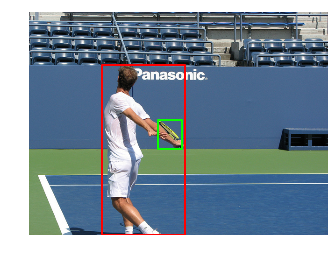

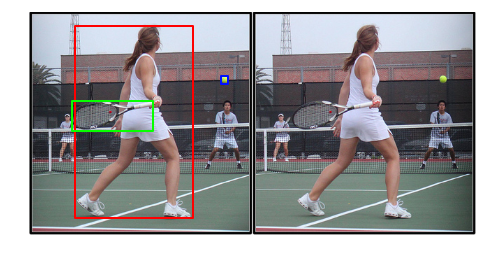

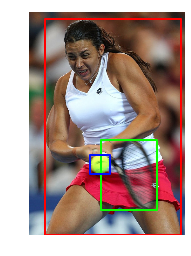

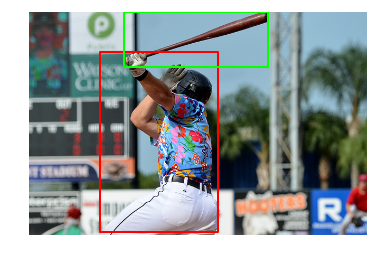

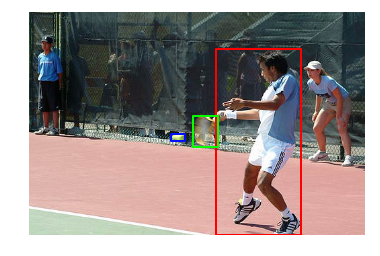

In [6]:
np.random.seed(1)
positive_index = np.where(vcoco['label'] == 1)[0]
positive_index = np.random.permutation(positive_index)

# the demo here laods images from the COCO website, 
# you can alternatively use your own local folder of COCO images.
load_coco_image_from_web = True
if load_coco_image_from_web:
    base_coco_url = 'http://mscoco.org/images/'
    from PIL import Image
    import urllib, cStringIO

cc = plt.get_cmap('hsv', lut=4)

for i in range(5):
    id = positive_index[i]

    # load image
    coco_image = coco.loadImgs(ids=[vcoco['image_id'][id][0]])[0]
    if load_coco_image_from_web:
        coco_url = base_coco_url + str(coco_image['id'])
        file = cStringIO.StringIO(urllib.urlopen(coco_url).read())
        im = np.asarray(Image.open(file))
        
    sy = 4.; sx = float(im.shape[1])/float(im.shape[0])*sy;
    fig, ax = subplot(plt, (1,1), (sy,sx)); ax.set_axis_off(); 
    ax.imshow(im);
    
    # draw bounding box for agent
    draw_bbox(plt, ax, vcoco['bbox'][[id],:], edgecolor=cc(0)[:3])
    role_bbox = vcoco['role_bbox'][id,:]*1.
    role_bbox = role_bbox.reshape((-1,4))
    for j in range(1, len(vcoco['role_name'])):
        if not np.isnan(role_bbox[j,0]):
            draw_bbox(plt, ax, role_bbox[[j],:], edgecolor=cc(j)[:3])